# Hourly electricity consumption clustering with big data and spark

- La idea del proyecto es **buscar el modelo que mejor represente en k clústers los perfiles de consumo eléctrico horario doméstico**
- Trabajaremos con los algoritmos k-means, bisecting k-means
- Al pasar a BIG DATA, trabajamos con el dataset completo **(2396741 observaciones)** de consumos eléctricos horarios diarios de los consumidores **(x0..x23)** 
- Se obtienen **diferentes modelos de clústering para cada algoritmo (para k=2..33)**
    - K=2 (modelo de 2 clústeres), ... k=33 (módelo de 33 clústeres)
- Se calcula el **MAE y el índice de SIL para cada modelo
- Se obtiene una curva de MAE e índice de SIL para cada algoritmo
- Para cada algoritmo (kmeans & bisecting) evaluaremos cada modelo con los algotitmos de Scoring (MAE, MAE de los clústeres)

### Dataset 
El dataset ya se encuentra filtrado:
- Remove rows with some NA column value
- Remove all rows (daily consumption) for non domestic consumer (at least one hour consumption >15000 W)
- Remove daily consumptions (rows) with  daily total consumption  < 100 W

### Import libraries

In [1]:
import time
from pyspark.ml.clustering import KMeans
from pyspark.ml.clustering import KMeansModel
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
import matplotlib.pyplot as plt
import numpy as np
import datetime
import pandas as pd


### Spark session

In [25]:
import warnings
warnings.filterwarnings('ignore')

sparkConf = SparkSession\
        .builder\
        .appName("Spark ML")\
        .getOrCreate()
        


22/11/11 14:23:54 WARN Utils: Your hostname, MacBook-Pro-de-Francisco.local resolves to a loopback address: 127.0.0.1; using 192.168.1.13 instead (on interface en0)
22/11/11 14:23:54 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/11/11 14:23:55 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Pandas Ireland

In [229]:
# Irland pandas (para cada File)
import pandas as pd
fileName = 'File6.csv'
df = pd.read_csv('dateIrland/'+fileName,delimiter=" ",header=None)

In [230]:
df = df.rename(columns={0: "userID", 2: "consumption", 1: "dayHalfHour"})

In [231]:
df['dayHalfHour'] = df['dayHalfHour'].apply(str)

In [232]:
df2 = df.assign(day=lambda x: x.dayHalfHour.str[:3])
df2 = df2.assign(halfHour=lambda x: x.dayHalfHour.str[-2:])

In [233]:
import numpy as np
conditions = [
    (df2['halfHour'] == '01'),
    (df2['halfHour'] == '02'),
    (df2['halfHour'] == '03'), 
    (df2['halfHour'] == '04'),
    (df2['halfHour'] == '05'),
    (df2['halfHour'] == '06'),
    (df2['halfHour'] == '07'),
    (df2['halfHour'] == '08'),
    (df2['halfHour'] == '09'),
    (df2['halfHour'] == '10'),
    (df2['halfHour'] == '11'),
    (df2['halfHour'] == '12'),
    (df2['halfHour'] == '13'), 
    (df2['halfHour'] == '14'),
    (df2['halfHour'] == '15'),
    (df2['halfHour'] == '16'),
    (df2['halfHour'] == '17'),
    (df2['halfHour'] == '18'),
    (df2['halfHour'] == '19'),
    (df2['halfHour'] == '20'),
    (df2['halfHour'] == '21'),
    (df2['halfHour'] == '22'),
    (df2['halfHour'] == '23'), 
    (df2['halfHour'] == '24'),
    (df2['halfHour'] == '25'),
    (df2['halfHour'] == '26'),
    (df2['halfHour'] == '27'),
    (df2['halfHour'] == '28'),
    (df2['halfHour'] == '29'),
    (df2['halfHour'] == '30'),
    (df2['halfHour'] == '31'),
    (df2['halfHour'] == '32'),
    (df2['halfHour'] == '33'), 
    (df2['halfHour'] == '34'),
    (df2['halfHour'] == '35'),
    (df2['halfHour'] == '36'),
    (df2['halfHour'] == '37'),
    (df2['halfHour'] == '38'),
    (df2['halfHour'] == '39'),
    (df2['halfHour'] == '40'),
    (df2['halfHour'] == '41'),
    (df2['halfHour'] == '42'),
    (df2['halfHour'] == '43'), 
    (df2['halfHour'] == '44'),
    (df2['halfHour'] == '45'),
    (df2['halfHour'] == '46'),
    (df2['halfHour'] == '47'),
    (df2['halfHour'] == '48'),

]

choices = ['1', '1', '2','2','3', '3', '4','4','5', '5', '6','6','7', '7', '8','8','9', '9', '10','10','11', '11', '12','12',
          '13', '13', '14','14','15', '15', '16','16','17', '17', '18','18','19', '19','20','20','21', '21', '22','22','23', '23', '24','24']

df2['hour'] = np.select(conditions, choices)


In [234]:
df2

userID dayHalfHour  consumption  day halfHour hour
0           6496       19720        2.958  197       20   10
1           6496       19721        1.443  197       21   11
2           6496       19722        0.131  197       22   11
3           6496       19724        0.144  197       24   12
4           6496       19725        0.208  197       25   13
...          ...         ...          ...  ...      ...  ...
35436007    6269       73044        0.425  730       44   22
35436008    6269       73045        0.385  730       45   23
35436009    6269       73046        0.431  730       46   23
35436010    6269       73047        0.459  730       47   24
35436011    6269       73048        0.515  730       48   24

[35436012 rows x 6 columns]

In [235]:
dfOrdered = df2.sort_values(['userID', 'day','hour'],
              ascending = [True, True,True])

In [236]:
dfOrdered

userID dayHalfHour  consumption  day halfHour hour
221142      6000       19501        0.258  195       01    1
221143      6000       19502        0.171  195       02    1
221160      6000       19519        0.314  195       19   10
221161      6000       19520        1.743  195       20   10
221162      6000       19521        0.376  195       21   11
...          ...         ...          ...  ...      ...  ...
30447753    7444       65514        0.216  655       14    7
30447754    7444       65515        1.055  655       15    8
30447755    7444       65516        0.855  655       16    8
30447756    7444       65517        2.486  655       17    9
30447757    7444       65518        1.794  655       18    9

[35436012 rows x 6 columns]

In [237]:
dfGroupedOut = dfOrdered.groupby(["userID","day","hour"])["consumption"].sum().reset_index(name='consumption')

In [238]:
dfGroupedOut['hour'] = dfGroupedOut['hour'].astype(int)

In [239]:
dfGroupedOutOrdered = dfGroupedOut.sort_values(['userID', 'day','hour'],
              ascending = [True, True,True])

In [240]:
dfGroupedOutOrdered.head(30)

userID  day  hour  consumption
0     6000  195     1        0.429
11    6000  195     2        0.408
17    6000  195     3        0.421
18    6000  195     4        0.988
19    6000  195     5        1.180
20    6000  195     6        0.264
21    6000  195     7        0.260
22    6000  195     8        0.259
23    6000  195     9        0.255
1     6000  195    10        2.057
2     6000  195    11        0.590
3     6000  195    12        0.257
4     6000  195    13        0.259
5     6000  195    14        0.261
6     6000  195    15        0.285
7     6000  195    16        0.293
8     6000  195    17        0.260
9     6000  195    18        0.264
10    6000  195    19        0.813
12    6000  195    20        2.310
13    6000  195    21        0.811
14    6000  195    22        1.899
15    6000  195    23        0.521
16    6000  195    24        0.270
24    6000  196     1        0.292
35    6000  196     2        0.273
41    6000  196     3        0.257
42    6000  196     4        0.258
43    6000  196     5        0.258
44    6000  196     6        0.260

In [241]:
consumersOutliers = dfGroupedOutOrdered [dfGroupedOutOrdered.consumption>15]

In [242]:
# Consumidores que en alguna hora de cualquier día han consumido más de 15 KWh

In [243]:
outliers = consumersOutliers.userID.unique()

In [244]:
outliers

array([6000, 6003, 6007, 6008, 6017, 6029, 6032, 6041, 6066, 6070, 6071,
       6076, 6082, 6119, 6127, 6133, 6134, 6139, 6151, 6152, 6163, 6188,
       6194, 6197, 6210, 6218, 6223, 6224, 6228, 6240, 6248, 6255, 6265,
       6268, 6278, 6288, 6299, 6303, 6309, 6313, 6329, 6332, 6334, 6339,
       6348, 6350, 6353, 6355, 6358, 6361, 6368, 6369, 6372, 6378, 6385,
       6389, 6393, 6398, 6402, 6406, 6423, 6429, 6436, 6448, 6452, 6458,
       6466, 6468, 6480, 6488, 6491, 6510, 6512, 6513, 6515, 6520, 6521,
       6537, 6548, 6549, 6555, 6574, 6578, 6584, 6587, 6594, 6595, 6597,
       6609, 6619, 6620, 6624, 6627, 6638, 6644, 6649, 6650, 6664, 6670,
       6689, 6690, 6695, 6696, 6701, 6702, 6707, 6717, 6718, 6719, 6722,
       6725, 6733, 6745, 6748, 6753, 6758, 6780, 6783, 6816, 6833, 6842,
       6846, 6848, 6867, 6879, 6888, 6896, 6899, 6902, 6909, 6912, 6916,
       6924, 6925, 6927, 6929, 6939, 6946, 6947, 6950, 6951, 6961, 6979,
       6985, 6998, 7001, 7009, 7024, 7028, 7034, 70

In [245]:
filteredDS = dfGroupedOutOrdered [~dfGroupedOutOrdered.userID.isin(outliers)]

In [246]:
filteredDS.head(30)

userID  day  hour  consumption
12866    6001  195     1        0.665
12877    6001  195     2        0.529
12883    6001  195     3        0.553
12884    6001  195     4        0.703
12885    6001  195     5        0.514
12886    6001  195     6        0.532
12887    6001  195     7        0.540
12888    6001  195     8        0.564
12889    6001  195     9        1.135
12867    6001  195    10        1.469
12868    6001  195    11        1.641
12869    6001  195    12        1.483
12870    6001  195    13        1.379
12871    6001  195    14        1.758
12872    6001  195    15        1.250
12873    6001  195    16        1.040
12874    6001  195    17        1.010
12875    6001  195    18        1.653
12876    6001  195    19        1.981
12878    6001  195    20        2.636
12879    6001  195    21        0.872
12880    6001  195    22        2.483
12881    6001  195    23        2.250
12882    6001  195    24        0.585
12890    6001  196     1        0.585
12901    6001  196     2        0.618
12907    6001  196     3        0.545
12908    6001  196     4        0.572
12909    6001  196     5        0.661
12910    6001  196     6        0.574

In [247]:
filteredDS.userID.unique()

array([6001, 6002, 6004, ..., 7442, 7443, 7444])

In [248]:
arrayNP = np.array(filteredDS.consumption)

In [249]:
arrayNP

array([0.665, 0.529, 0.553, ..., 3.664, 2.865, 1.928])

In [250]:
dayArray = []
day = []
cont = 0

for elem in arrayNP:
    cont = cont+1
    day.append(elem)
    if cont==24: ##un dia para un consumidor
        dayArray.append(day)
        day = []
        cont = 0
        
        

In [251]:
dfFinalPandas = pd.DataFrame(dayArray, columns = ['X0', 'X1', 'X2','X3', 'X4', 'X5','X6', 'X7','X8', 'X9','X10', 'X11','X12',
                                                 'X13', 'X14', 'X15','X16', 'X17', 'X18','X19', 'X20', 'X21','X22', 'X23'])

In [252]:
dfFinalPandas

X0     X1     X2     X3     X4     X5     X6     X7     X8     X9  \
0       0.665  0.529  0.553  0.703  0.514  0.532  0.540  0.564  1.135  1.469   
1       0.585  0.618  0.545  0.572  0.661  0.574  0.486  0.548  1.390  0.859   
2       0.519  0.522  0.547  0.530  0.584  0.447  0.537  1.084  1.367  0.556   
3       0.554  0.475  0.474  0.593  0.509  0.476  0.550  0.486  1.215  2.725   
4       0.503  0.565  0.471  0.487  0.565  0.471  0.462  1.061  1.277  1.271   
...       ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
638155  1.673  1.434  2.193  1.220  0.969  0.882  0.781  0.555  0.747  0.479   
638156  2.367  1.445  2.367  2.073  1.775  0.810  1.266  0.534  0.787  1.194   
638157  1.591  1.813  0.937  3.240  2.094  1.593  1.063  1.156  1.075  2.530   
638158  1.630  1.852  1.607  1.837  2.065  1.989  1.079  1.296  1.306  1.027   
638159  2.274  4.311  2.203  0.797  0.937  0.791  1.174  0.749  1.136  0.919   

        ...    X14    X15    X16    X17    X18    X19    X20    X21    X22  \
0       ...  1.250  1.040  1.010  1.653  1.981  2.636  0.872  2.483  2.250   
1       ...  0.994  0.726  0.641  0.742  0.653  0.912  0.831  0.756  0.776   
2       ...  1.261  0.709  0.837  2.533  0.965  0.901  1.222  1.685  0.750   
3       ...  0.687  1.058  1.085  1.344  2.117  0.709  0.619  1.090  0.863   
4       ...  0.730  1.613  0.727  0.724  0.628  0.722  1.656  0.932  0.848   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
638155  ...  2.392  0.922  0.640  0.701  0.540  0.383  0.382  0.398  0.611   
638156  ...  1.962  1.635  1.526  1.122  0.426  0.440  0.397  0.400  0.620   
638157  ...  2.687  1.430  0.721  0.730  0.528  0.425  0.422  0.431  0.884   
638158  ...  2.751  1.475  1.094  0.994  0.991  1.004  0.956  1.126  1.370   
638159  ...  2.222  1.018  0.673  0.627  0.830  0.632  0.383  0.394  0.831   

          X23  
0       0.585  
1       0.932  
2       0.686  
3       0.590  
4       0.591  
...       ...  
638155  2.100  
638156  1.522  
638157  1.527  
638158  1.142  
638159  0.648  

[638160 rows x 24 columns]

In [253]:
dfRound = dfFinalPandas.round(3)

In [254]:
dfRound

X0     X1     X2     X3     X4     X5     X6     X7     X8     X9  \
0       0.665  0.529  0.553  0.703  0.514  0.532  0.540  0.564  1.135  1.469   
1       0.585  0.618  0.545  0.572  0.661  0.574  0.486  0.548  1.390  0.859   
2       0.519  0.522  0.547  0.530  0.584  0.447  0.537  1.084  1.367  0.556   
3       0.554  0.475  0.474  0.593  0.509  0.476  0.550  0.486  1.215  2.725   
4       0.503  0.565  0.471  0.487  0.565  0.471  0.462  1.061  1.277  1.271   
...       ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
638155  1.673  1.434  2.193  1.220  0.969  0.882  0.781  0.555  0.747  0.479   
638156  2.367  1.445  2.367  2.073  1.775  0.810  1.266  0.534  0.787  1.194   
638157  1.591  1.813  0.937  3.240  2.094  1.593  1.063  1.156  1.075  2.530   
638158  1.630  1.852  1.607  1.837  2.065  1.989  1.079  1.296  1.306  1.027   
638159  2.274  4.311  2.203  0.797  0.937  0.791  1.174  0.749  1.136  0.919   

        ...    X14    X15    X16    X17    X18    X19    X20    X21    X22  \
0       ...  1.250  1.040  1.010  1.653  1.981  2.636  0.872  2.483  2.250   
1       ...  0.994  0.726  0.641  0.742  0.653  0.912  0.831  0.756  0.776   
2       ...  1.261  0.709  0.837  2.533  0.965  0.901  1.222  1.685  0.750   
3       ...  0.687  1.058  1.085  1.344  2.117  0.709  0.619  1.090  0.863   
4       ...  0.730  1.613  0.727  0.724  0.628  0.722  1.656  0.932  0.848   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
638155  ...  2.392  0.922  0.640  0.701  0.540  0.383  0.382  0.398  0.611   
638156  ...  1.962  1.635  1.526  1.122  0.426  0.440  0.397  0.400  0.620   
638157  ...  2.687  1.430  0.721  0.730  0.528  0.425  0.422  0.431  0.884   
638158  ...  2.751  1.475  1.094  0.994  0.991  1.004  0.956  1.126  1.370   
638159  ...  2.222  1.018  0.673  0.627  0.830  0.632  0.383  0.394  0.831   

          X23  
0       0.585  
1       0.932  
2       0.686  
3       0.590  
4       0.591  
...       ...  
638155  2.100  
638156  1.522  
638157  1.527  
638158  1.142  
638159  0.648  

[638160 rows x 24 columns]

In [255]:
ddfMult = dfRound.mul(1000)

In [256]:
ddfMult

X0      X1      X2      X3      X4      X5      X6      X7  \
0        665.0   529.0   553.0   703.0   514.0   532.0   540.0   564.0   
1        585.0   618.0   545.0   572.0   661.0   574.0   486.0   548.0   
2        519.0   522.0   547.0   530.0   584.0   447.0   537.0  1084.0   
3        554.0   475.0   474.0   593.0   509.0   476.0   550.0   486.0   
4        503.0   565.0   471.0   487.0   565.0   471.0   462.0  1061.0   
...        ...     ...     ...     ...     ...     ...     ...     ...   
638155  1673.0  1434.0  2193.0  1220.0   969.0   882.0   781.0   555.0   
638156  2367.0  1445.0  2367.0  2073.0  1775.0   810.0  1266.0   534.0   
638157  1591.0  1813.0   937.0  3240.0  2094.0  1593.0  1063.0  1156.0   
638158  1630.0  1852.0  1607.0  1837.0  2065.0  1989.0  1079.0  1296.0   
638159  2274.0  4311.0  2203.0   797.0   937.0   791.0  1174.0   749.0   

            X8      X9  ...     X14     X15     X16     X17     X18     X19  \
0       1135.0  1469.0  ...  1250.0  1040.0  1010.0  1653.0  1981.0  2636.0   
1       1390.0   859.0  ...   994.0   726.0   641.0   742.0   653.0   912.0   
2       1367.0   556.0  ...  1261.0   709.0   837.0  2533.0   965.0   901.0   
3       1215.0  2725.0  ...   687.0  1058.0  1085.0  1344.0  2117.0   709.0   
4       1277.0  1271.0  ...   730.0  1613.0   727.0   724.0   628.0   722.0   
...        ...     ...  ...     ...     ...     ...     ...     ...     ...   
638155   747.0   479.0  ...  2392.0   922.0   640.0   701.0   540.0   383.0   
638156   787.0  1194.0  ...  1962.0  1635.0  1526.0  1122.0   426.0   440.0   
638157  1075.0  2530.0  ...  2687.0  1430.0   721.0   730.0   528.0   425.0   
638158  1306.0  1027.0  ...  2751.0  1475.0  1094.0   994.0   991.0  1004.0   
638159  1136.0   919.0  ...  2222.0  1018.0   673.0   627.0   830.0   632.0   

           X20     X21     X22     X23  
0        872.0  2483.0  2250.0   585.0  
1        831.0   756.0   776.0   932.0  
2       1222.0  1685.0   750.0   686.0  
3        619.0  1090.0   863.0   590.0  
4       1656.0   932.0   848.0   591.0  
...        ...     ...     ...     ...  
638155   382.0   398.0   611.0  2100.0  
638156   397.0   400.0   620.0  1522.0  
638157   422.0   431.0   884.0  1527.0  
638158   956.0  1126.0  1370.0  1142.0  
638159   383.0   394.0   831.0   648.0  

[638160 rows x 24 columns]

In [257]:
result = ddfMult

In [258]:
result

X0      X1      X2      X3      X4      X5      X6      X7  \
0        665.0   529.0   553.0   703.0   514.0   532.0   540.0   564.0   
1        585.0   618.0   545.0   572.0   661.0   574.0   486.0   548.0   
2        519.0   522.0   547.0   530.0   584.0   447.0   537.0  1084.0   
3        554.0   475.0   474.0   593.0   509.0   476.0   550.0   486.0   
4        503.0   565.0   471.0   487.0   565.0   471.0   462.0  1061.0   
...        ...     ...     ...     ...     ...     ...     ...     ...   
638155  1673.0  1434.0  2193.0  1220.0   969.0   882.0   781.0   555.0   
638156  2367.0  1445.0  2367.0  2073.0  1775.0   810.0  1266.0   534.0   
638157  1591.0  1813.0   937.0  3240.0  2094.0  1593.0  1063.0  1156.0   
638158  1630.0  1852.0  1607.0  1837.0  2065.0  1989.0  1079.0  1296.0   
638159  2274.0  4311.0  2203.0   797.0   937.0   791.0  1174.0   749.0   

            X8      X9  ...     X14     X15     X16     X17     X18     X19  \
0       1135.0  1469.0  ...  1250.0  1040.0  1010.0  1653.0  1981.0  2636.0   
1       1390.0   859.0  ...   994.0   726.0   641.0   742.0   653.0   912.0   
2       1367.0   556.0  ...  1261.0   709.0   837.0  2533.0   965.0   901.0   
3       1215.0  2725.0  ...   687.0  1058.0  1085.0  1344.0  2117.0   709.0   
4       1277.0  1271.0  ...   730.0  1613.0   727.0   724.0   628.0   722.0   
...        ...     ...  ...     ...     ...     ...     ...     ...     ...   
638155   747.0   479.0  ...  2392.0   922.0   640.0   701.0   540.0   383.0   
638156   787.0  1194.0  ...  1962.0  1635.0  1526.0  1122.0   426.0   440.0   
638157  1075.0  2530.0  ...  2687.0  1430.0   721.0   730.0   528.0   425.0   
638158  1306.0  1027.0  ...  2751.0  1475.0  1094.0   994.0   991.0  1004.0   
638159  1136.0   919.0  ...  2222.0  1018.0   673.0   627.0   830.0   632.0   

           X20     X21     X22     X23  
0        872.0  2483.0  2250.0   585.0  
1        831.0   756.0   776.0   932.0  
2       1222.0  1685.0   750.0   686.0  
3        619.0  1090.0   863.0   590.0  
4       1656.0   932.0   848.0   591.0  
...        ...     ...     ...     ...  
638155   382.0   398.0   611.0  2100.0  
638156   397.0   400.0   620.0  1522.0  
638157   422.0   431.0   884.0  1527.0  
638158   956.0  1126.0  1370.0  1142.0  
638159   383.0   394.0   831.0   648.0  

[638160 rows x 24 columns]

In [259]:
dfFiltered = result

In [260]:
dfFiltered ["total"] = dfFiltered["X0"] + dfFiltered["X1"] + dfFiltered["X2"] + dfFiltered["X3"] + dfFiltered["X4"] + dfFiltered["X5"] + dfFiltered["X6"] + dfFiltered["X7"] + dfFiltered["X8"] + dfFiltered["X9"]+ dfFiltered["X10"] + dfFiltered["X11"] + dfFiltered["X12"] + dfFiltered["X13"] + dfFiltered["X14"]+ dfFiltered["X15"] + dfFiltered["X16"] + dfFiltered["X17"] + dfFiltered["X18"] + dfFiltered["X19"]+ dfFiltered["X20"] + dfFiltered["X21"] + dfFiltered["X22"] + dfFiltered["X23"] 

In [261]:
dfFiltered

X0      X1      X2      X3      X4      X5      X6      X7  \
0        665.0   529.0   553.0   703.0   514.0   532.0   540.0   564.0   
1        585.0   618.0   545.0   572.0   661.0   574.0   486.0   548.0   
2        519.0   522.0   547.0   530.0   584.0   447.0   537.0  1084.0   
3        554.0   475.0   474.0   593.0   509.0   476.0   550.0   486.0   
4        503.0   565.0   471.0   487.0   565.0   471.0   462.0  1061.0   
...        ...     ...     ...     ...     ...     ...     ...     ...   
638155  1673.0  1434.0  2193.0  1220.0   969.0   882.0   781.0   555.0   
638156  2367.0  1445.0  2367.0  2073.0  1775.0   810.0  1266.0   534.0   
638157  1591.0  1813.0   937.0  3240.0  2094.0  1593.0  1063.0  1156.0   
638158  1630.0  1852.0  1607.0  1837.0  2065.0  1989.0  1079.0  1296.0   
638159  2274.0  4311.0  2203.0   797.0   937.0   791.0  1174.0   749.0   

            X8      X9  ...     X15     X16     X17     X18     X19     X20  \
0       1135.0  1469.0  ...  1040.0  1010.0  1653.0  1981.0  2636.0   872.0   
1       1390.0   859.0  ...   726.0   641.0   742.0   653.0   912.0   831.0   
2       1367.0   556.0  ...   709.0   837.0  2533.0   965.0   901.0  1222.0   
3       1215.0  2725.0  ...  1058.0  1085.0  1344.0  2117.0   709.0   619.0   
4       1277.0  1271.0  ...  1613.0   727.0   724.0   628.0   722.0  1656.0   
...        ...     ...  ...     ...     ...     ...     ...     ...     ...   
638155   747.0   479.0  ...   922.0   640.0   701.0   540.0   383.0   382.0   
638156   787.0  1194.0  ...  1635.0  1526.0  1122.0   426.0   440.0   397.0   
638157  1075.0  2530.0  ...  1430.0   721.0   730.0   528.0   425.0   422.0   
638158  1306.0  1027.0  ...  1475.0  1094.0   994.0   991.0  1004.0   956.0   
638159  1136.0   919.0  ...  1018.0   673.0   627.0   830.0   632.0   383.0   

           X21     X22     X23    total  
0       2483.0  2250.0   585.0  29225.0  
1        756.0   776.0   932.0  21907.0  
2       1685.0   750.0   686.0  21782.0  
3       1090.0   863.0   590.0  22741.0  
4        932.0   848.0   591.0  22204.0  
...        ...     ...     ...      ...  
638155   398.0   611.0  2100.0  28148.0  
638156   400.0   620.0  1522.0  31880.0  
638157   431.0   884.0  1527.0  36869.0  
638158  1126.0  1370.0  1142.0  39821.0  
638159   394.0   831.0   648.0  32941.0  

[638160 rows x 25 columns]

## Remove consumptions days with total < 100 Wh

In [262]:
dfFiltered = dfFiltered[dfFiltered.total > 100] 

In [263]:
dfFiltered

X0      X1      X2      X3      X4      X5      X6      X7  \
0        665.0   529.0   553.0   703.0   514.0   532.0   540.0   564.0   
1        585.0   618.0   545.0   572.0   661.0   574.0   486.0   548.0   
2        519.0   522.0   547.0   530.0   584.0   447.0   537.0  1084.0   
3        554.0   475.0   474.0   593.0   509.0   476.0   550.0   486.0   
4        503.0   565.0   471.0   487.0   565.0   471.0   462.0  1061.0   
...        ...     ...     ...     ...     ...     ...     ...     ...   
638155  1673.0  1434.0  2193.0  1220.0   969.0   882.0   781.0   555.0   
638156  2367.0  1445.0  2367.0  2073.0  1775.0   810.0  1266.0   534.0   
638157  1591.0  1813.0   937.0  3240.0  2094.0  1593.0  1063.0  1156.0   
638158  1630.0  1852.0  1607.0  1837.0  2065.0  1989.0  1079.0  1296.0   
638159  2274.0  4311.0  2203.0   797.0   937.0   791.0  1174.0   749.0   

            X8      X9  ...     X15     X16     X17     X18     X19     X20  \
0       1135.0  1469.0  ...  1040.0  1010.0  1653.0  1981.0  2636.0   872.0   
1       1390.0   859.0  ...   726.0   641.0   742.0   653.0   912.0   831.0   
2       1367.0   556.0  ...   709.0   837.0  2533.0   965.0   901.0  1222.0   
3       1215.0  2725.0  ...  1058.0  1085.0  1344.0  2117.0   709.0   619.0   
4       1277.0  1271.0  ...  1613.0   727.0   724.0   628.0   722.0  1656.0   
...        ...     ...  ...     ...     ...     ...     ...     ...     ...   
638155   747.0   479.0  ...   922.0   640.0   701.0   540.0   383.0   382.0   
638156   787.0  1194.0  ...  1635.0  1526.0  1122.0   426.0   440.0   397.0   
638157  1075.0  2530.0  ...  1430.0   721.0   730.0   528.0   425.0   422.0   
638158  1306.0  1027.0  ...  1475.0  1094.0   994.0   991.0  1004.0   956.0   
638159  1136.0   919.0  ...  1018.0   673.0   627.0   830.0   632.0   383.0   

           X21     X22     X23    total  
0       2483.0  2250.0   585.0  29225.0  
1        756.0   776.0   932.0  21907.0  
2       1685.0   750.0   686.0  21782.0  
3       1090.0   863.0   590.0  22741.0  
4        932.0   848.0   591.0  22204.0  
...        ...     ...     ...      ...  
638155   398.0   611.0  2100.0  28148.0  
638156   400.0   620.0  1522.0  31880.0  
638157   431.0   884.0  1527.0  36869.0  
638158  1126.0  1370.0  1142.0  39821.0  
638159   394.0   831.0   648.0  32941.0  

[634261 rows x 25 columns]

In [264]:
dfFiltered.to_csv("dateIrland/dfFinalPandas6.csv", sep=',', encoding='utf-8')

In [265]:
# Concat dataFiles1-6
fileName1 = "dfFinalPandas1.csv"
fileName2 = "dfFinalPandas2.csv"
fileName3 = "dfFinalPandas3.csv"
fileName4 = "dfFinalPandas4.csv"
fileName5 = "dfFinalPandas5.csv"
fileName6 = "dfFinalPandas6.csv"

df1 = pd.read_csv('dateIrland/'+fileName1,delimiter=",")
df2 = pd.read_csv('dateIrland/'+fileName2,delimiter=",")
df3 = pd.read_csv('dateIrland/'+fileName3,delimiter=",")
df4 = pd.read_csv('dateIrland/'+fileName4,delimiter=",")
df5 = pd.read_csv('dateIrland/'+fileName5,delimiter=",")
df6 = pd.read_csv('dateIrland/'+fileName6,delimiter=",")

frames = [df1, df2, df3, df4, df5, df6]

result = pd.concat(frames)

In [266]:
result.drop(columns=result.columns[0], axis=1, inplace=True)
result

X0      X1      X2      X3      X4      X5      X6      X7  \
0        167.0    50.0   166.0    66.0    72.0   153.0    48.0   162.0   
1         87.0   106.0   130.0    50.0   163.0    50.0   187.0   935.0   
2        218.0    48.0   183.0    90.0   126.0   185.0   211.0   905.0   
3        323.0    50.0   133.0    60.0   145.0    49.0   154.0   443.0   
4        227.0   140.0    57.0   151.0    50.0   133.0   182.0   122.0   
...        ...     ...     ...     ...     ...     ...     ...     ...   
634256  1673.0  1434.0  2193.0  1220.0   969.0   882.0   781.0   555.0   
634257  2367.0  1445.0  2367.0  2073.0  1775.0   810.0  1266.0   534.0   
634258  1591.0  1813.0   937.0  3240.0  2094.0  1593.0  1063.0  1156.0   
634259  1630.0  1852.0  1607.0  1837.0  2065.0  1989.0  1079.0  1296.0   
634260  2274.0  4311.0  2203.0   797.0   937.0   791.0  1174.0   749.0   

            X8      X9  ...     X15     X16     X17     X18     X19     X20  \
0        138.0   206.0  ...    61.0   110.0   127.0    52.0  5050.0  1390.0   
1         79.0   149.0  ...   212.0   130.0    69.0  3590.0   109.0   185.0   
2        516.0   262.0  ...   659.0   574.0   421.0   500.0   439.0   207.0   
3        532.0    58.0  ...    59.0   162.0    58.0  3096.0  3265.0  1415.0   
4         86.0   254.0  ...  2423.0    99.0   110.0    66.0   148.0    98.0   
...        ...     ...  ...     ...     ...     ...     ...     ...     ...   
634256   747.0   479.0  ...   922.0   640.0   701.0   540.0   383.0   382.0   
634257   787.0  1194.0  ...  1635.0  1526.0  1122.0   426.0   440.0   397.0   
634258  1075.0  2530.0  ...  1430.0   721.0   730.0   528.0   425.0   422.0   
634259  1306.0  1027.0  ...  1475.0  1094.0   994.0   991.0  1004.0   956.0   
634260  1136.0   919.0  ...  1018.0   673.0   627.0   830.0   632.0   383.0   

           X21     X22     X23    total  
0        984.0  1262.0   363.0  11203.0  
1        795.0   532.0   319.0   8403.0  
2         81.0    67.0   507.0   7225.0  
3        224.0   276.0   251.0  11338.0  
4        216.0    62.0   109.0  11306.0  
...        ...     ...     ...      ...  
634256   398.0   611.0  2100.0  28148.0  
634257   400.0   620.0  1522.0  31880.0  
634258   431.0   884.0  1527.0  36869.0  
634259  1126.0  1370.0  1142.0  39821.0  
634260   394.0   831.0   648.0  32941.0  

[2806221 rows x 25 columns]

In [268]:
#save full df Ireland
result.to_csv("dateIrland/irelandProcessedDF.csv", sep=',', encoding='utf-8')

### Read full dataset of hourly daily energy consumption (x0..x23)

In [54]:
#Spain
df2 = sparkConf\
       .read.csv('data/dfEnergyFull.csv', header=True, inferSchema=True)

In [269]:
#Ireland
dfIreland = sparkConf\
       .read.csv('dateIrland/irelandProcessedDF.csv', header=True, inferSchema=True)

### Show dataset

In [56]:
#Spain
df = df2.drop("_c0")

In [270]:
#Ireland
df = dfIreland.drop("_c0")

In [271]:
df.show ()

+------+-----+-----+-----+-----+-----+------+------+------+------+------+------+-----+-----+-----+------+------+------+------+------+------+------+------+------+-------+
|    X0|   X1|   X2|   X3|   X4|   X5|    X6|    X7|    X8|    X9|   X10|   X11|  X12|  X13|  X14|   X15|   X16|   X17|   X18|   X19|   X20|   X21|   X22|   X23|  total|
+------+-----+-----+-----+-----+-----+------+------+------+------+------+------+-----+-----+-----+------+------+------+------+------+------+------+------+------+-------+
| 167.0| 50.0|166.0| 66.0| 72.0|153.0|  48.0| 162.0| 138.0| 206.0|  59.0| 120.0|141.0| 58.0|198.0|  61.0| 110.0| 127.0|  52.0|5050.0|1390.0| 984.0|1262.0| 363.0|11203.0|
|  87.0|106.0|130.0| 50.0|163.0| 50.0| 187.0| 935.0|  79.0| 149.0|  58.0| 174.0| 59.0|135.0|100.0| 212.0| 130.0|  69.0|3590.0| 109.0| 185.0| 795.0| 532.0| 319.0| 8403.0|
| 218.0| 48.0|183.0| 90.0|126.0|185.0| 211.0| 905.0| 516.0| 262.0| 123.0| 185.0| 64.0|363.0|291.0| 659.0| 574.0| 421.0| 500.0| 439.0| 207.0|  81.0|  6

In [272]:
numObs = df.count()

### Features vector assembler. Need for algorithm learning

In [273]:
numObs

2806221

In [274]:
# Transforma todas las características en un vector usando VectorAssembler
numericCols = ["X0", "X1", "X2", "X3", "X4", "X5", "X6","X7","X8","X9","X10","X11","X12","X13","X14","X15","X16","X17","X18","X19","X20","X21","X22","X23"]
assembler = VectorAssembler(inputCols=numericCols, outputCol="features")
df = assembler.transform(df)

In [275]:
df.show()

22/11/04 15:06:16 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+------+-----+-----+-----+-----+-----+------+------+------+------+------+------+-----+-----+-----+------+------+------+------+------+------+------+------+------+-------+--------------------+
|    X0|   X1|   X2|   X3|   X4|   X5|    X6|    X7|    X8|    X9|   X10|   X11|  X12|  X13|  X14|   X15|   X16|   X17|   X18|   X19|   X20|   X21|   X22|   X23|  total|            features|
+------+-----+-----+-----+-----+-----+------+------+------+------+------+------+-----+-----+-----+------+------+------+------+------+------+------+------+------+-------+--------------------+
| 167.0| 50.0|166.0| 66.0| 72.0|153.0|  48.0| 162.0| 138.0| 206.0|  59.0| 120.0|141.0| 58.0|198.0|  61.0| 110.0| 127.0|  52.0|5050.0|1390.0| 984.0|1262.0| 363.0|11203.0|[167.0,50.0,166.0...|
|  87.0|106.0|130.0| 50.0|163.0| 50.0| 187.0| 935.0|  79.0| 149.0|  58.0| 174.0| 59.0|135.0|100.0| 212.0| 130.0|  69.0|3590.0| 109.0| 185.0| 795.0| 532.0| 319.0| 8403.0|[87.0,106.0,130.0...|
| 218.0| 48.0|183.0| 90.0|126.0|185.0| 211.0|

### K values for determining optimal number of cluster (best model determination)

In [9]:
kMin=10
kMax=34

### Training k-means model for k values (kMin..kMax) and calculation Silhouette evaluator index value for each model

In [277]:
import warnings
warnings.filterwarnings('ignore')

# Trains a k-means model.

silhouette_score=[]
list_of_centroid_list = []
list_of_models = []

for i in range(kMin, kMax):
    
    print (i)
       
    kmeans = KMeans().setK(i).setSeed(1)                   # Choose random state for reproducibility
    model = kmeans.fit(df) 
    
    # Save ssilhouette score for k value
    list_of_models.append(model)
    
    # Shows the result.
    centers = model.clusterCenters()
           
    list_of_centroid_list.append(centers)
           
    # Make predictions
    predictions = model.transform(df)

    # Evaluate clustering by computing Silhouette score
    evaluator = ClusteringEvaluator()

    silhouette = evaluator.evaluate(predictions)
    
    # Save ssilhouette score for k value
    silhouette_score.append(silhouette)
    

10


22/11/04 15:06:28 WARN MemoryStore: Not enough space to cache rdd_40_0 in memory! (computed 20.5 MiB so far)
22/11/04 15:06:28 WARN BlockManager: Persisting block rdd_40_0 to disk instead.
22/11/04 15:06:30 WARN MemoryStore: Not enough space to cache rdd_40_11 in memory! (computed 30.8 MiB so far)
22/11/04 15:06:30 WARN BlockManager: Persisting block rdd_40_11 to disk instead.
22/11/04 15:06:30 WARN MemoryStore: Not enough space to cache rdd_40_4 in memory! (computed 30.8 MiB so far)
22/11/04 15:06:30 WARN BlockManager: Persisting block rdd_40_4 to disk instead.
22/11/04 15:06:30 WARN MemoryStore: Not enough space to cache rdd_40_9 in memory! (computed 30.8 MiB so far)
22/11/04 15:06:30 WARN MemoryStore: Not enough space to cache rdd_40_1 in memory! (computed 30.8 MiB so far)
22/11/04 15:06:30 WARN BlockManager: Persisting block rdd_40_9 to disk instead.
22/11/04 15:06:30 WARN BlockManager: Persisting block rdd_40_1 to disk instead.
22/11/04 15:06:30 WARN MemoryStore: Not enough space 

22/11/04 15:06:38 WARN MemoryStore: Not enough space to cache rdd_40_8 in memory! (computed 5.8 MiB so far)
22/11/04 15:06:38 WARN MemoryStore: Not enough space to cache rdd_40_10 in memory! (computed 5.8 MiB so far)
22/11/04 15:06:38 WARN MemoryStore: Not enough space to cache rdd_40_7 in memory! (computed 13.7 MiB so far)
22/11/04 15:06:38 WARN MemoryStore: Not enough space to cache rdd_40_11 in memory! (computed 13.7 MiB so far)
22/11/04 15:06:38 WARN MemoryStore: Not enough space to cache rdd_40_6 in memory! (computed 9.0 MiB so far)
22/11/04 15:06:38 WARN MemoryStore: Not enough space to cache rdd_40_1 in memory! (computed 46.4 MiB so far)
22/11/04 15:06:39 WARN MemoryStore: Not enough space to cache rdd_40_0 in memory! (computed 9.0 MiB so far)
22/11/04 15:06:39 WARN MemoryStore: Not enough space to cache rdd_40_6 in memory! (computed 9.0 MiB so far)
22/11/04 15:06:39 WARN MemoryStore: Not enough space to cache rdd_40_7 in memory! (computed 9.0 MiB so far)
22/11/04 15:06:39 WARN 

22/11/04 15:06:43 WARN MemoryStore: Not enough space to cache rdd_40_6 in memory! (computed 30.8 MiB so far)
22/11/04 15:06:43 WARN MemoryStore: Not enough space to cache rdd_40_7 in memory! (computed 30.8 MiB so far)
22/11/04 15:06:43 WARN MemoryStore: Not enough space to cache rdd_40_8 in memory! (computed 9.0 MiB so far)
22/11/04 15:06:43 WARN MemoryStore: Not enough space to cache rdd_40_11 in memory! (computed 9.0 MiB so far)
22/11/04 15:06:43 WARN MemoryStore: Not enough space to cache rdd_40_1 in memory! (computed 9.0 MiB so far)
22/11/04 15:06:43 WARN MemoryStore: Not enough space to cache rdd_40_6 in memory! (computed 9.0 MiB so far)
22/11/04 15:06:43 WARN MemoryStore: Not enough space to cache rdd_40_0 in memory! (computed 9.0 MiB so far)
22/11/04 15:06:44 WARN MemoryStore: Not enough space to cache rdd_40_3 in memory! (computed 30.8 MiB so far)
22/11/04 15:06:44 WARN MemoryStore: Not enough space to cache rdd_40_7 in memory! (computed 30.8 MiB so far)
22/11/04 15:06:44 WARN 

22/11/04 15:06:51 WARN MemoryStore: Not enough space to cache rdd_40_8 in memory! (computed 13.7 MiB so far)
22/11/04 15:06:52 WARN MemoryStore: Not enough space to cache rdd_40_1 in memory! (computed 2.5 MiB so far)
22/11/04 15:06:52 WARN MemoryStore: Not enough space to cache rdd_40_6 in memory! (computed 2.5 MiB so far)
22/11/04 15:06:52 WARN MemoryStore: Not enough space to cache rdd_40_11 in memory! (computed 2.5 MiB so far)
22/11/04 15:06:52 WARN MemoryStore: Not enough space to cache rdd_40_3 in memory! (computed 2.5 MiB so far)
22/11/04 15:06:52 WARN MemoryStore: Not enough space to cache rdd_40_0 in memory! (computed 2.5 MiB so far)
22/11/04 15:06:52 WARN MemoryStore: Not enough space to cache rdd_40_8 in memory! (computed 13.7 MiB so far)
22/11/04 15:06:52 WARN MemoryStore: Not enough space to cache rdd_40_11 in memory! (computed 2.5 MiB so far)
22/11/04 15:06:52 WARN MemoryStore: Not enough space to cache rdd_40_1 in memory! (computed 2.5 MiB so far)
22/11/04 15:06:52 WARN M

11


22/11/04 15:07:16 WARN MemoryStore: Not enough space to cache rdd_126_6 in memory! (computed 20.5 MiB so far)
22/11/04 15:07:16 WARN BlockManager: Persisting block rdd_126_6 to disk instead.
22/11/04 15:07:17 WARN MemoryStore: Not enough space to cache rdd_126_10 in memory! (computed 30.8 MiB so far)
22/11/04 15:07:17 WARN BlockManager: Persisting block rdd_126_10 to disk instead.
22/11/04 15:07:17 WARN MemoryStore: Not enough space to cache rdd_126_2 in memory! (computed 30.6 MiB so far)
22/11/04 15:07:17 WARN BlockManager: Persisting block rdd_126_2 to disk instead.
22/11/04 15:07:17 WARN MemoryStore: Not enough space to cache rdd_126_1 in memory! (computed 30.8 MiB so far)
22/11/04 15:07:17 WARN BlockManager: Persisting block rdd_126_1 to disk instead.
22/11/04 15:07:17 WARN MemoryStore: Not enough space to cache rdd_126_4 in memory! (computed 30.8 MiB so far)
22/11/04 15:07:17 WARN BlockManager: Persisting block rdd_126_4 to disk instead.
22/11/04 15:07:17 WARN MemoryStore: Not eno

22/11/04 15:07:26 WARN MemoryStore: Not enough space to cache rdd_126_1 in memory! (computed 9.0 MiB so far)
22/11/04 15:07:26 WARN MemoryStore: Not enough space to cache rdd_126_8 in memory! (computed 5.8 MiB so far)
22/11/04 15:07:26 WARN MemoryStore: Not enough space to cache rdd_126_10 in memory! (computed 13.7 MiB so far)
22/11/04 15:07:26 WARN MemoryStore: Not enough space to cache rdd_126_6 in memory! (computed 13.7 MiB so far)
22/11/04 15:07:26 WARN MemoryStore: Not enough space to cache rdd_126_5 in memory! (computed 13.7 MiB so far)
22/11/04 15:07:26 WARN MemoryStore: Not enough space to cache rdd_126_2 in memory! (computed 46.1 MiB so far)
22/11/04 15:07:26 WARN MemoryStore: Not enough space to cache rdd_126_10 in memory! (computed 9.0 MiB so far)
22/11/04 15:07:26 WARN MemoryStore: Not enough space to cache rdd_126_5 in memory! (computed 5.8 MiB so far)
22/11/04 15:07:26 WARN MemoryStore: Not enough space to cache rdd_126_1 in memory! (computed 13.7 MiB so far)
22/11/04 15:

22/11/04 15:07:31 WARN MemoryStore: Not enough space to cache rdd_126_0 in memory! (computed 2.5 MiB so far)
22/11/04 15:07:31 WARN MemoryStore: Not enough space to cache rdd_126_10 in memory! (computed 3.8 MiB so far)
22/11/04 15:07:31 WARN MemoryStore: Not enough space to cache rdd_126_1 in memory! (computed 3.8 MiB so far)
22/11/04 15:07:31 WARN MemoryStore: Not enough space to cache rdd_126_2 in memory! (computed 5.8 MiB so far)
22/11/04 15:07:31 WARN MemoryStore: Not enough space to cache rdd_126_6 in memory! (computed 9.0 MiB so far)
22/11/04 15:07:31 WARN MemoryStore: Not enough space to cache rdd_126_8 in memory! (computed 20.5 MiB so far)
22/11/04 15:07:31 WARN MemoryStore: Not enough space to cache rdd_126_8 in memory! (computed 3.8 MiB so far)
22/11/04 15:07:31 WARN MemoryStore: Not enough space to cache rdd_126_6 in memory! (computed 3.8 MiB so far)
22/11/04 15:07:31 WARN MemoryStore: Not enough space to cache rdd_126_1 in memory! (computed 3.8 MiB so far)
22/11/04 15:07:31

22/11/04 15:07:39 WARN MemoryStore: Not enough space to cache rdd_126_10 in memory! (computed 20.5 MiB so far)
22/11/04 15:07:39 WARN MemoryStore: Not enough space to cache rdd_126_1 in memory! (computed 2.5 MiB so far)
22/11/04 15:07:39 WARN MemoryStore: Not enough space to cache rdd_126_10 in memory! (computed 3.8 MiB so far)
22/11/04 15:07:39 WARN MemoryStore: Not enough space to cache rdd_126_6 in memory! (computed 3.8 MiB so far)
22/11/04 15:07:39 WARN MemoryStore: Not enough space to cache rdd_126_8 in memory! (computed 3.8 MiB so far)
22/11/04 15:07:39 WARN MemoryStore: Not enough space to cache rdd_126_0 in memory! (computed 3.8 MiB so far)
22/11/04 15:07:39 WARN MemoryStore: Not enough space to cache rdd_126_2 in memory! (computed 20.4 MiB so far)
22/11/04 15:07:40 WARN MemoryStore: Not enough space to cache rdd_126_0 in memory! (computed 3.8 MiB so far)
22/11/04 15:07:40 WARN MemoryStore: Not enough space to cache rdd_126_8 in memory! (computed 3.8 MiB so far)
22/11/04 15:07:

12


22/11/04 15:08:01 WARN MemoryStore: Not enough space to cache rdd_212_3 in memory! (computed 20.5 MiB so far)
22/11/04 15:08:01 WARN BlockManager: Persisting block rdd_212_3 to disk instead.
22/11/04 15:08:02 WARN MemoryStore: Not enough space to cache rdd_212_4 in memory! (computed 30.8 MiB so far)
22/11/04 15:08:02 WARN BlockManager: Persisting block rdd_212_4 to disk instead.
22/11/04 15:08:02 WARN MemoryStore: Not enough space to cache rdd_212_2 in memory! (computed 30.6 MiB so far)
22/11/04 15:08:02 WARN BlockManager: Persisting block rdd_212_2 to disk instead.
22/11/04 15:08:02 WARN MemoryStore: Not enough space to cache rdd_212_5 in memory! (computed 30.8 MiB so far)
22/11/04 15:08:02 WARN BlockManager: Persisting block rdd_212_5 to disk instead.
22/11/04 15:08:02 WARN MemoryStore: Not enough space to cache rdd_212_1 in memory! (computed 30.8 MiB so far)
22/11/04 15:08:02 WARN BlockManager: Persisting block rdd_212_1 to disk instead.
22/11/04 15:08:02 WARN MemoryStore: Not enoug

22/11/04 15:08:10 WARN MemoryStore: Not enough space to cache rdd_212_3 in memory! (computed 9.0 MiB so far)
22/11/04 15:08:10 WARN MemoryStore: Not enough space to cache rdd_212_1 in memory! (computed 9.0 MiB so far)
22/11/04 15:08:10 WARN MemoryStore: Not enough space to cache rdd_212_0 in memory! (computed 9.0 MiB so far)
22/11/04 15:08:10 WARN MemoryStore: Not enough space to cache rdd_212_5 in memory! (computed 9.0 MiB so far)
22/11/04 15:08:10 WARN MemoryStore: Not enough space to cache rdd_220_6 in memory! (computed 2.0 MiB so far)
22/11/04 15:08:10 WARN MemoryStore: Not enough space to cache rdd_212_4 in memory! (computed 9.0 MiB so far)
22/11/04 15:08:10 WARN MemoryStore: Not enough space to cache rdd_220_9 in memory! (computed 1024.2 KiB so far)
22/11/04 15:08:10 WARN MemoryStore: Not enough space to cache rdd_220_10 in memory! (computed 1024.2 KiB so far)
22/11/04 15:08:10 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_216_

22/11/04 15:08:15 WARN MemoryStore: Not enough space to cache rdd_212_2 in memory! (computed 20.4 MiB so far)
22/11/04 15:08:16 WARN MemoryStore: Not enough space to cache rdd_212_8 in memory! (computed 3.8 MiB so far)
22/11/04 15:08:16 WARN MemoryStore: Not enough space to cache rdd_212_3 in memory! (computed 3.8 MiB so far)
22/11/04 15:08:16 WARN MemoryStore: Not enough space to cache rdd_212_7 in memory! (computed 3.8 MiB so far)
22/11/04 15:08:16 WARN MemoryStore: Not enough space to cache rdd_212_5 in memory! (computed 3.8 MiB so far)
22/11/04 15:08:16 WARN MemoryStore: Not enough space to cache rdd_212_0 in memory! (computed 3.8 MiB so far)
22/11/04 15:08:16 WARN MemoryStore: Not enough space to cache rdd_212_2 in memory! (computed 3.8 MiB so far)
22/11/04 15:08:17 WARN MemoryStore: Not enough space to cache rdd_212_3 in memory! (computed 3.8 MiB so far)
22/11/04 15:08:17 WARN MemoryStore: Not enough space to cache rdd_212_5 in memory! (computed 3.8 MiB so far)
22/11/04 15:08:17 

22/11/04 15:08:25 WARN MemoryStore: Not enough space to cache rdd_212_2 in memory! (computed 3.8 MiB so far)
22/11/04 15:08:25 WARN MemoryStore: Not enough space to cache rdd_212_5 in memory! (computed 3.8 MiB so far)
22/11/04 15:08:25 WARN MemoryStore: Not enough space to cache rdd_212_8 in memory! (computed 3.8 MiB so far)
22/11/04 15:08:25 WARN MemoryStore: Not enough space to cache rdd_212_7 in memory! (computed 3.8 MiB so far)
22/11/04 15:08:25 WARN MemoryStore: Not enough space to cache rdd_212_3 in memory! (computed 3.8 MiB so far)
22/11/04 15:08:25 WARN MemoryStore: Not enough space to cache rdd_212_0 in memory! (computed 3.8 MiB so far)
22/11/04 15:08:26 WARN MemoryStore: Not enough space to cache rdd_212_7 in memory! (computed 3.8 MiB so far)
22/11/04 15:08:26 WARN MemoryStore: Not enough space to cache rdd_212_8 in memory! (computed 3.8 MiB so far)
22/11/04 15:08:26 WARN MemoryStore: Not enough space to cache rdd_212_0 in memory! (computed 3.8 MiB so far)
22/11/04 15:08:26 W

13


22/11/04 15:08:47 WARN MemoryStore: Not enough space to cache rdd_298_0 in memory! (computed 20.5 MiB so far)
22/11/04 15:08:47 WARN BlockManager: Persisting block rdd_298_0 to disk instead.
22/11/04 15:08:48 WARN MemoryStore: Not enough space to cache rdd_298_6 in memory! (computed 30.8 MiB so far)
22/11/04 15:08:48 WARN BlockManager: Persisting block rdd_298_6 to disk instead.
22/11/04 15:08:48 WARN MemoryStore: Not enough space to cache rdd_298_11 in memory! (computed 30.8 MiB so far)
22/11/04 15:08:48 WARN BlockManager: Persisting block rdd_298_11 to disk instead.
22/11/04 15:08:48 WARN MemoryStore: Not enough space to cache rdd_298_8 in memory! (computed 30.8 MiB so far)
22/11/04 15:08:48 WARN BlockManager: Persisting block rdd_298_8 to disk instead.
22/11/04 15:08:48 WARN MemoryStore: Not enough space to cache rdd_298_5 in memory! (computed 30.8 MiB so far)
22/11/04 15:08:48 WARN BlockManager: Persisting block rdd_298_5 to disk instead.
22/11/04 15:08:48 WARN MemoryStore: Not eno

22/11/04 15:08:55 WARN MemoryStore: Not enough space to cache rdd_302_5 in memory! (computed 1024.2 KiB so far)
22/11/04 15:08:55 WARN MemoryStore: Not enough space to cache rdd_302_10 in memory! (computed 1024.2 KiB so far)
22/11/04 15:08:55 WARN MemoryStore: Not enough space to cache rdd_302_8 in memory! (computed 2.0 MiB so far)
22/11/04 15:08:56 WARN MemoryStore: Not enough space to cache rdd_298_0 in memory! (computed 1734.5 KiB so far)
22/11/04 15:08:56 WARN MemoryStore: Not enough space to cache rdd_298_4 in memory! (computed 5.8 MiB so far)
22/11/04 15:08:56 WARN MemoryStore: Not enough space to cache rdd_298_2 in memory! (computed 2.5 MiB so far)
22/11/04 15:08:56 WARN MemoryStore: Not enough space to cache rdd_298_6 in memory! (computed 3.8 MiB so far)
22/11/04 15:08:56 WARN MemoryStore: Not enough space to cache rdd_298_1 in memory! (computed 30.8 MiB so far)
22/11/04 15:08:56 WARN MemoryStore: Not enough space to cache rdd_298_9 in memory! (computed 30.8 MiB so far)
22/11/0

22/11/04 15:09:08 WARN MemoryStore: Not enough space to cache rdd_298_5 in memory! (computed 30.8 MiB so far)
22/11/04 15:09:08 WARN MemoryStore: Not enough space to cache rdd_298_11 in memory! (computed 30.8 MiB so far)
22/11/04 15:09:09 WARN MemoryStore: Not enough space to cache rdd_298_0 in memory! (computed 9.0 MiB so far)
22/11/04 15:09:09 WARN MemoryStore: Not enough space to cache rdd_298_11 in memory! (computed 9.0 MiB so far)
22/11/04 15:09:09 WARN MemoryStore: Not enough space to cache rdd_298_5 in memory! (computed 9.0 MiB so far)
22/11/04 15:09:09 WARN MemoryStore: Not enough space to cache rdd_298_6 in memory! (computed 9.0 MiB so far)
22/11/04 15:09:09 WARN MemoryStore: Not enough space to cache rdd_298_4 in memory! (computed 9.0 MiB so far)
22/11/04 15:09:09 WARN MemoryStore: Not enough space to cache rdd_298_2 in memory! (computed 30.6 MiB so far)
22/11/04 15:09:09 WARN MemoryStore: Not enough space to cache rdd_298_1 in memory! (computed 30.8 MiB so far)
22/11/04 15:0

14


22/11/04 15:09:33 WARN MemoryStore: Not enough space to cache rdd_384_8 in memory! (computed 20.5 MiB so far)
22/11/04 15:09:33 WARN BlockManager: Persisting block rdd_384_8 to disk instead.
22/11/04 15:09:34 WARN MemoryStore: Not enough space to cache rdd_384_6 in memory! (computed 30.8 MiB so far)
22/11/04 15:09:34 WARN BlockManager: Persisting block rdd_384_6 to disk instead.
22/11/04 15:09:35 WARN MemoryStore: Not enough space to cache rdd_384_0 in memory! (computed 30.8 MiB so far)
22/11/04 15:09:35 WARN BlockManager: Persisting block rdd_384_0 to disk instead.
22/11/04 15:09:35 WARN MemoryStore: Not enough space to cache rdd_384_11 in memory! (computed 30.8 MiB so far)
22/11/04 15:09:35 WARN BlockManager: Persisting block rdd_384_11 to disk instead.
22/11/04 15:09:35 WARN MemoryStore: Not enough space to cache rdd_384_3 in memory! (computed 30.8 MiB so far)
22/11/04 15:09:35 WARN BlockManager: Persisting block rdd_384_3 to disk instead.
22/11/04 15:09:35 WARN MemoryStore: Not eno

22/11/04 15:09:42 WARN MemoryStore: Not enough space to cache rdd_384_1 in memory! (computed 9.0 MiB so far)
22/11/04 15:09:42 WARN MemoryStore: Not enough space to cache rdd_384_0 in memory! (computed 9.0 MiB so far)
22/11/04 15:09:42 WARN MemoryStore: Not enough space to cache rdd_384_5 in memory! (computed 13.7 MiB so far)
22/11/04 15:09:42 WARN MemoryStore: Not enough space to cache rdd_384_9 in memory! (computed 13.7 MiB so far)
22/11/04 15:09:42 WARN MemoryStore: Not enough space to cache rdd_384_7 in memory! (computed 13.7 MiB so far)
22/11/04 15:09:42 WARN MemoryStore: Not enough space to cache rdd_384_2 in memory! (computed 9.0 MiB so far)
22/11/04 15:09:43 WARN MemoryStore: Not enough space to cache rdd_384_9 in memory! (computed 9.0 MiB so far)
22/11/04 15:09:43 WARN MemoryStore: Not enough space to cache rdd_384_5 in memory! (computed 9.0 MiB so far)
22/11/04 15:09:43 WARN MemoryStore: Not enough space to cache rdd_384_6 in memory! (computed 9.0 MiB so far)
22/11/04 15:09:4

22/11/04 15:09:55 WARN MemoryStore: Not enough space to cache rdd_384_9 in memory! (computed 2.5 MiB so far)
22/11/04 15:09:55 WARN MemoryStore: Not enough space to cache rdd_384_5 in memory! (computed 3.8 MiB so far)
22/11/04 15:09:55 WARN MemoryStore: Not enough space to cache rdd_384_7 in memory! (computed 3.8 MiB so far)
22/11/04 15:09:55 WARN MemoryStore: Not enough space to cache rdd_384_3 in memory! (computed 3.8 MiB so far)
22/11/04 15:09:55 WARN MemoryStore: Not enough space to cache rdd_384_1 in memory! (computed 3.8 MiB so far)
22/11/04 15:09:55 WARN MemoryStore: Not enough space to cache rdd_384_6 in memory! (computed 20.5 MiB so far)
22/11/04 15:09:56 WARN MemoryStore: Not enough space to cache rdd_384_3 in memory! (computed 3.8 MiB so far)
22/11/04 15:09:56 WARN MemoryStore: Not enough space to cache rdd_384_7 in memory! (computed 3.8 MiB so far)
22/11/04 15:09:56 WARN MemoryStore: Not enough space to cache rdd_384_1 in memory! (computed 3.8 MiB so far)
22/11/04 15:09:56 

15


22/11/04 15:10:17 WARN MemoryStore: Not enough space to cache rdd_470_9 in memory! (computed 20.5 MiB so far)
22/11/04 15:10:17 WARN BlockManager: Persisting block rdd_470_9 to disk instead.
22/11/04 15:10:18 WARN MemoryStore: Not enough space to cache rdd_470_7 in memory! (computed 30.8 MiB so far)
22/11/04 15:10:18 WARN BlockManager: Persisting block rdd_470_7 to disk instead.
22/11/04 15:10:18 WARN MemoryStore: Not enough space to cache rdd_470_5 in memory! (computed 30.8 MiB so far)
22/11/04 15:10:18 WARN BlockManager: Persisting block rdd_470_5 to disk instead.
22/11/04 15:10:18 WARN MemoryStore: Not enough space to cache rdd_470_3 in memory! (computed 30.8 MiB so far)
22/11/04 15:10:18 WARN BlockManager: Persisting block rdd_470_3 to disk instead.
22/11/04 15:10:18 WARN MemoryStore: Not enough space to cache rdd_470_11 in memory! (computed 30.8 MiB so far)
22/11/04 15:10:18 WARN BlockManager: Persisting block rdd_470_11 to disk instead.
22/11/04 15:10:18 WARN MemoryStore: Not eno

22/11/04 15:10:26 WARN MemoryStore: Not enough space to cache rdd_470_4 in memory! (computed 9.0 MiB so far)
22/11/04 15:10:26 WARN MemoryStore: Not enough space to cache rdd_470_3 in memory! (computed 9.0 MiB so far)
22/11/04 15:10:26 WARN MemoryStore: Not enough space to cache rdd_470_6 in memory! (computed 13.7 MiB so far)
22/11/04 15:10:26 WARN MemoryStore: Not enough space to cache rdd_470_8 in memory! (computed 13.7 MiB so far)
22/11/04 15:10:26 WARN MemoryStore: Not enough space to cache rdd_470_1 in memory! (computed 13.7 MiB so far)
22/11/04 15:10:26 WARN MemoryStore: Not enough space to cache rdd_470_5 in memory! (computed 9.0 MiB so far)
22/11/04 15:10:27 WARN MemoryStore: Not enough space to cache rdd_470_8 in memory! (computed 9.0 MiB so far)
22/11/04 15:10:27 WARN MemoryStore: Not enough space to cache rdd_478_10 in memory! (computed 1024.2 KiB so far)
22/11/04 15:10:27 WARN MemoryStore: Not enough space to cache rdd_478_11 in memory! (computed 1024.2 KiB so far)
22/11/04

22/11/04 15:10:32 WARN MemoryStore: Not enough space to cache rdd_470_0 in memory! (computed 20.5 MiB so far)
22/11/04 15:10:32 WARN MemoryStore: Not enough space to cache rdd_470_5 in memory! (computed 3.8 MiB so far)
22/11/04 15:10:32 WARN MemoryStore: Not enough space to cache rdd_470_1 in memory! (computed 3.8 MiB so far)
22/11/04 15:10:32 WARN MemoryStore: Not enough space to cache rdd_470_3 in memory! (computed 3.8 MiB so far)
22/11/04 15:10:32 WARN MemoryStore: Not enough space to cache rdd_470_0 in memory! (computed 3.8 MiB so far)
22/11/04 15:10:32 WARN MemoryStore: Not enough space to cache rdd_470_7 in memory! (computed 3.8 MiB so far)
22/11/04 15:10:32 WARN MemoryStore: Not enough space to cache rdd_470_8 in memory! (computed 3.8 MiB so far)
22/11/04 15:10:33 WARN MemoryStore: Not enough space to cache rdd_470_7 in memory! (computed 3.8 MiB so far)
22/11/04 15:10:33 WARN MemoryStore: Not enough space to cache rdd_470_0 in memory! (computed 3.8 MiB so far)
22/11/04 15:10:33 

22/11/04 15:10:41 WARN MemoryStore: Not enough space to cache rdd_470_7 in memory! (computed 3.8 MiB so far)
22/11/04 15:10:41 WARN MemoryStore: Not enough space to cache rdd_470_3 in memory! (computed 3.8 MiB so far)
22/11/04 15:10:41 WARN MemoryStore: Not enough space to cache rdd_470_1 in memory! (computed 3.8 MiB so far)
22/11/04 15:10:41 WARN MemoryStore: Not enough space to cache rdd_470_0 in memory! (computed 3.8 MiB so far)
22/11/04 15:10:41 WARN MemoryStore: Not enough space to cache rdd_470_8 in memory! (computed 3.8 MiB so far)
22/11/04 15:10:41 WARN MemoryStore: Not enough space to cache rdd_470_5 in memory! (computed 3.8 MiB so far)
22/11/04 15:10:42 WARN MemoryStore: Not enough space to cache rdd_470_7 in memory! (computed 3.8 MiB so far)
22/11/04 15:10:42 WARN MemoryStore: Not enough space to cache rdd_470_0 in memory! (computed 3.8 MiB so far)
22/11/04 15:10:42 WARN MemoryStore: Not enough space to cache rdd_470_1 in memory! (computed 3.8 MiB so far)
22/11/04 15:10:42 W

16


22/11/04 15:11:04 WARN MemoryStore: Not enough space to cache rdd_556_9 in memory! (computed 20.5 MiB so far)
22/11/04 15:11:04 WARN BlockManager: Persisting block rdd_556_9 to disk instead.
22/11/04 15:11:06 WARN MemoryStore: Not enough space to cache rdd_556_5 in memory! (computed 30.8 MiB so far)
22/11/04 15:11:06 WARN BlockManager: Persisting block rdd_556_5 to disk instead.
22/11/04 15:11:06 WARN MemoryStore: Not enough space to cache rdd_556_10 in memory! (computed 30.8 MiB so far)
22/11/04 15:11:06 WARN BlockManager: Persisting block rdd_556_10 to disk instead.
22/11/04 15:11:06 WARN MemoryStore: Not enough space to cache rdd_556_11 in memory! (computed 30.8 MiB so far)
22/11/04 15:11:06 WARN BlockManager: Persisting block rdd_556_11 to disk instead.
22/11/04 15:11:06 WARN MemoryStore: Not enough space to cache rdd_556_8 in memory! (computed 30.8 MiB so far)
22/11/04 15:11:06 WARN BlockManager: Persisting block rdd_556_8 to disk instead.
22/11/04 15:11:06 WARN MemoryStore: Not e

22/11/04 15:11:14 WARN MemoryStore: Not enough space to cache rdd_556_0 in memory! (computed 9.0 MiB so far)
22/11/04 15:11:14 WARN MemoryStore: Not enough space to cache rdd_556_6 in memory! (computed 9.0 MiB so far)
22/11/04 15:11:14 WARN MemoryStore: Not enough space to cache rdd_556_7 in memory! (computed 13.7 MiB so far)
22/11/04 15:11:14 WARN MemoryStore: Not enough space to cache rdd_556_3 in memory! (computed 13.7 MiB so far)
22/11/04 15:11:14 WARN MemoryStore: Not enough space to cache rdd_556_4 in memory! (computed 9.0 MiB so far)
22/11/04 15:11:14 WARN MemoryStore: Not enough space to cache rdd_556_8 in memory! (computed 46.4 MiB so far)
22/11/04 15:11:15 WARN MemoryStore: Not enough space to cache rdd_556_0 in memory! (computed 9.0 MiB so far)
22/11/04 15:11:15 WARN MemoryStore: Not enough space to cache rdd_556_8 in memory! (computed 9.0 MiB so far)
22/11/04 15:11:15 WARN MemoryStore: Not enough space to cache rdd_556_4 in memory! (computed 5.8 MiB so far)
22/11/04 15:11:1

22/11/04 15:11:20 WARN MemoryStore: Not enough space to cache rdd_556_8 in memory! (computed 9.0 MiB so far)
22/11/04 15:11:20 WARN MemoryStore: Not enough space to cache rdd_556_3 in memory! (computed 9.0 MiB so far)
22/11/04 15:11:20 WARN MemoryStore: Not enough space to cache rdd_556_7 in memory! (computed 9.0 MiB so far)
22/11/04 15:11:20 WARN MemoryStore: Not enough space to cache rdd_556_4 in memory! (computed 9.0 MiB so far)
22/11/04 15:11:20 WARN MemoryStore: Not enough space to cache rdd_556_6 in memory! (computed 9.0 MiB so far)
22/11/04 15:11:20 WARN MemoryStore: Not enough space to cache rdd_556_2 in memory! (computed 30.6 MiB so far)
22/11/04 15:11:20 WARN MemoryStore: Not enough space to cache rdd_556_11 in memory! (computed 30.8 MiB so far)
22/11/04 15:11:20 WARN MemoryStore: Not enough space to cache rdd_556_3 in memory! (computed 9.0 MiB so far)
22/11/04 15:11:20 WARN MemoryStore: Not enough space to cache rdd_556_6 in memory! (computed 9.0 MiB so far)
22/11/04 15:11:2

22/11/04 15:11:28 WARN MemoryStore: Not enough space to cache rdd_556_11 in memory! (computed 2.5 MiB so far)
22/11/04 15:11:28 WARN MemoryStore: Not enough space to cache rdd_556_4 in memory! (computed 2.5 MiB so far)
22/11/04 15:11:28 WARN MemoryStore: Not enough space to cache rdd_556_3 in memory! (computed 2.5 MiB so far)
22/11/04 15:11:28 WARN MemoryStore: Not enough space to cache rdd_556_6 in memory! (computed 2.5 MiB so far)
22/11/04 15:11:28 WARN MemoryStore: Not enough space to cache rdd_556_8 in memory! (computed 2.5 MiB so far)
22/11/04 15:11:29 WARN MemoryStore: Not enough space to cache rdd_556_7 in memory! (computed 13.7 MiB so far)
22/11/04 15:11:29 WARN MemoryStore: Not enough space to cache rdd_556_4 in memory! (computed 2.5 MiB so far)
22/11/04 15:11:29 WARN MemoryStore: Not enough space to cache rdd_556_6 in memory! (computed 2.5 MiB so far)
22/11/04 15:11:29 WARN MemoryStore: Not enough space to cache rdd_556_11 in memory! (computed 2.5 MiB so far)
22/11/04 15:11:2

17


22/11/04 15:11:55 WARN MemoryStore: Not enough space to cache rdd_642_3 in memory! (computed 20.5 MiB so far)
22/11/04 15:11:55 WARN BlockManager: Persisting block rdd_642_3 to disk instead.
22/11/04 15:11:57 WARN MemoryStore: Not enough space to cache rdd_642_11 in memory! (computed 30.8 MiB so far)
22/11/04 15:11:57 WARN BlockManager: Persisting block rdd_642_11 to disk instead.
22/11/04 15:11:57 WARN MemoryStore: Not enough space to cache rdd_642_9 in memory! (computed 30.8 MiB so far)
22/11/04 15:11:57 WARN BlockManager: Persisting block rdd_642_9 to disk instead.
22/11/04 15:11:57 WARN MemoryStore: Not enough space to cache rdd_642_2 in memory! (computed 30.6 MiB so far)
22/11/04 15:11:57 WARN BlockManager: Persisting block rdd_642_2 to disk instead.
22/11/04 15:11:57 WARN MemoryStore: Not enough space to cache rdd_642_5 in memory! (computed 30.8 MiB so far)
22/11/04 15:11:57 WARN BlockManager: Persisting block rdd_642_5 to disk instead.
22/11/04 15:11:57 WARN MemoryStore: Not eno

22/11/04 15:12:09 WARN MemoryStore: Not enough space to cache rdd_642_10 in memory! (computed 13.7 MiB so far)
22/11/04 15:12:09 WARN MemoryStore: Not enough space to cache rdd_642_8 in memory! (computed 9.0 MiB so far)
22/11/04 15:12:09 WARN MemoryStore: Not enough space to cache rdd_642_5 in memory! (computed 13.7 MiB so far)
22/11/04 15:12:09 WARN MemoryStore: Not enough space to cache rdd_642_2 in memory! (computed 9.0 MiB so far)
22/11/04 15:12:09 WARN MemoryStore: Not enough space to cache rdd_642_3 in memory! (computed 9.0 MiB so far)
22/11/04 15:12:09 WARN MemoryStore: Not enough space to cache rdd_642_1 in memory! (computed 9.0 MiB so far)
22/11/04 15:12:10 WARN MemoryStore: Not enough space to cache rdd_642_1 in memory! (computed 5.7 MiB so far)
22/11/04 15:12:10 WARN MemoryStore: Not enough space to cache rdd_642_2 in memory! (computed 5.8 MiB so far)
22/11/04 15:12:10 WARN MemoryStore: Not enough space to cache rdd_642_9 in memory! (computed 9.0 MiB so far)
22/11/04 15:12:1

22/11/04 15:12:34 WARN MemoryStore: Not enough space to cache rdd_642_0 in memory! (computed 3.8 MiB so far)
22/11/04 15:12:34 WARN MemoryStore: Not enough space to cache rdd_642_1 in memory! (computed 3.8 MiB so far)
22/11/04 15:12:34 WARN MemoryStore: Not enough space to cache rdd_642_2 in memory! (computed 3.8 MiB so far)
22/11/04 15:12:34 WARN MemoryStore: Not enough space to cache rdd_642_8 in memory! (computed 3.8 MiB so far)
22/11/04 15:12:34 WARN MemoryStore: Not enough space to cache rdd_642_10 in memory! (computed 3.8 MiB so far)
22/11/04 15:12:34 WARN MemoryStore: Not enough space to cache rdd_642_5 in memory! (computed 3.8 MiB so far)
22/11/04 15:12:35 WARN MemoryStore: Not enough space to cache rdd_642_1 in memory! (computed 3.8 MiB so far)
22/11/04 15:12:35 WARN MemoryStore: Not enough space to cache rdd_642_10 in memory! (computed 3.8 MiB so far)
22/11/04 15:12:35 WARN MemoryStore: Not enough space to cache rdd_642_5 in memory! (computed 3.8 MiB so far)
22/11/04 15:12:35

18


22/11/04 15:13:02 WARN MemoryStore: Not enough space to cache rdd_728_9 in memory! (computed 20.5 MiB so far)
22/11/04 15:13:02 WARN BlockManager: Persisting block rdd_728_9 to disk instead.
22/11/04 15:13:03 WARN MemoryStore: Not enough space to cache rdd_728_8 in memory! (computed 30.8 MiB so far)
22/11/04 15:13:03 WARN BlockManager: Persisting block rdd_728_8 to disk instead.
22/11/04 15:13:03 WARN MemoryStore: Not enough space to cache rdd_728_7 in memory! (computed 30.8 MiB so far)
22/11/04 15:13:03 WARN BlockManager: Persisting block rdd_728_7 to disk instead.
22/11/04 15:13:03 WARN MemoryStore: Not enough space to cache rdd_728_6 in memory! (computed 30.8 MiB so far)
22/11/04 15:13:03 WARN BlockManager: Persisting block rdd_728_6 to disk instead.
22/11/04 15:13:03 WARN MemoryStore: Not enough space to cache rdd_728_0 in memory! (computed 30.8 MiB so far)
22/11/04 15:13:03 WARN BlockManager: Persisting block rdd_728_0 to disk instead.
22/11/04 15:13:03 WARN MemoryStore: Not enoug

22/11/04 15:13:11 WARN MemoryStore: Not enough space to cache rdd_728_10 in memory! (computed 9.0 MiB so far)
22/11/04 15:13:11 WARN MemoryStore: Not enough space to cache rdd_728_0 in memory! (computed 9.0 MiB so far)
22/11/04 15:13:11 WARN MemoryStore: Not enough space to cache rdd_728_9 in memory! (computed 13.7 MiB so far)
22/11/04 15:13:11 WARN MemoryStore: Not enough space to cache rdd_728_8 in memory! (computed 13.7 MiB so far)
22/11/04 15:13:11 WARN MemoryStore: Not enough space to cache rdd_728_6 in memory! (computed 13.7 MiB so far)
22/11/04 15:13:11 WARN MemoryStore: Not enough space to cache rdd_728_3 in memory! (computed 9.0 MiB so far)
22/11/04 15:13:12 WARN MemoryStore: Not enough space to cache rdd_728_6 in memory! (computed 9.0 MiB so far)
22/11/04 15:13:12 WARN MemoryStore: Not enough space to cache rdd_728_10 in memory! (computed 9.0 MiB so far)
22/11/04 15:13:12 WARN MemoryStore: Not enough space to cache rdd_728_9 in memory! (computed 9.0 MiB so far)
22/11/04 15:13

22/11/04 15:13:17 WARN MemoryStore: Not enough space to cache rdd_728_0 in memory! (computed 3.8 MiB so far)
22/11/04 15:13:17 WARN MemoryStore: Not enough space to cache rdd_728_3 in memory! (computed 3.8 MiB so far)
22/11/04 15:13:17 WARN MemoryStore: Not enough space to cache rdd_728_10 in memory! (computed 3.8 MiB so far)
22/11/04 15:13:17 WARN MemoryStore: Not enough space to cache rdd_728_8 in memory! (computed 3.8 MiB so far)
22/11/04 15:13:17 WARN MemoryStore: Not enough space to cache rdd_728_1 in memory! (computed 3.8 MiB so far)
22/11/04 15:13:17 WARN MemoryStore: Not enough space to cache rdd_728_7 in memory! (computed 3.8 MiB so far)
22/11/04 15:13:18 WARN MemoryStore: Not enough space to cache rdd_728_8 in memory! (computed 3.8 MiB so far)
22/11/04 15:13:18 WARN MemoryStore: Not enough space to cache rdd_728_0 in memory! (computed 3.8 MiB so far)
22/11/04 15:13:18 WARN MemoryStore: Not enough space to cache rdd_728_10 in memory! (computed 3.8 MiB so far)
22/11/04 15:13:18

22/11/04 15:13:27 WARN MemoryStore: Not enough space to cache rdd_728_1 in memory! (computed 3.8 MiB so far)
22/11/04 15:13:27 WARN MemoryStore: Not enough space to cache rdd_728_8 in memory! (computed 3.8 MiB so far)
22/11/04 15:13:27 WARN MemoryStore: Not enough space to cache rdd_728_7 in memory! (computed 3.8 MiB so far)
22/11/04 15:13:27 WARN MemoryStore: Not enough space to cache rdd_728_0 in memory! (computed 3.8 MiB so far)
22/11/04 15:13:27 WARN MemoryStore: Not enough space to cache rdd_728_3 in memory! (computed 3.8 MiB so far)
22/11/04 15:13:27 WARN MemoryStore: Not enough space to cache rdd_728_10 in memory! (computed 3.8 MiB so far)
22/11/04 15:13:28 WARN MemoryStore: Not enough space to cache rdd_728_1 in memory! (computed 3.8 MiB so far)
22/11/04 15:13:28 WARN MemoryStore: Not enough space to cache rdd_728_8 in memory! (computed 3.8 MiB so far)
22/11/04 15:13:28 WARN MemoryStore: Not enough space to cache rdd_728_10 in memory! (computed 3.8 MiB so far)
22/11/04 15:13:28

19


22/11/04 15:13:53 WARN MemoryStore: Not enough space to cache rdd_814_9 in memory! (computed 20.5 MiB so far)
22/11/04 15:13:53 WARN BlockManager: Persisting block rdd_814_9 to disk instead.
22/11/04 15:13:54 WARN MemoryStore: Not enough space to cache rdd_814_3 in memory! (computed 30.8 MiB so far)
22/11/04 15:13:54 WARN BlockManager: Persisting block rdd_814_3 to disk instead.
22/11/04 15:13:54 WARN MemoryStore: Not enough space to cache rdd_814_2 in memory! (computed 30.6 MiB so far)
22/11/04 15:13:54 WARN BlockManager: Persisting block rdd_814_2 to disk instead.
22/11/04 15:13:54 WARN MemoryStore: Not enough space to cache rdd_814_1 in memory! (computed 30.8 MiB so far)
22/11/04 15:13:54 WARN BlockManager: Persisting block rdd_814_1 to disk instead.
22/11/04 15:13:54 WARN MemoryStore: Not enough space to cache rdd_814_0 in memory! (computed 30.8 MiB so far)
22/11/04 15:13:54 WARN BlockManager: Persisting block rdd_814_0 to disk instead.
22/11/04 15:13:54 WARN MemoryStore: Not enoug

22/11/04 15:14:02 WARN MemoryStore: Not enough space to cache rdd_814_5 in memory! (computed 9.0 MiB so far)
22/11/04 15:14:02 WARN MemoryStore: Not enough space to cache rdd_814_4 in memory! (computed 9.0 MiB so far)
22/11/04 15:14:02 WARN MemoryStore: Not enough space to cache rdd_814_7 in memory! (computed 13.7 MiB so far)
22/11/04 15:14:02 WARN MemoryStore: Not enough space to cache rdd_814_10 in memory! (computed 13.7 MiB so far)
22/11/04 15:14:02 WARN MemoryStore: Not enough space to cache rdd_814_9 in memory! (computed 13.7 MiB so far)
22/11/04 15:14:02 WARN MemoryStore: Not enough space to cache rdd_814_3 in memory! (computed 46.4 MiB so far)
22/11/04 15:14:03 WARN MemoryStore: Not enough space to cache rdd_814_2 in memory! (computed 9.0 MiB so far)
22/11/04 15:14:03 WARN MemoryStore: Not enough space to cache rdd_814_10 in memory! (computed 9.0 MiB so far)
22/11/04 15:14:03 WARN MemoryStore: Not enough space to cache rdd_822_8 in memory! (computed 1024.2 KiB so far)
22/11/04 1

22/11/04 15:14:08 WARN MemoryStore: Not enough space to cache rdd_814_10 in memory! (computed 2.5 MiB so far)
22/11/04 15:14:08 WARN MemoryStore: Not enough space to cache rdd_814_9 in memory! (computed 3.8 MiB so far)
22/11/04 15:14:08 WARN MemoryStore: Not enough space to cache rdd_814_7 in memory! (computed 3.8 MiB so far)
22/11/04 15:14:08 WARN MemoryStore: Not enough space to cache rdd_814_0 in memory! (computed 3.8 MiB so far)
22/11/04 15:14:08 WARN MemoryStore: Not enough space to cache rdd_814_4 in memory! (computed 3.8 MiB so far)
22/11/04 15:14:08 WARN MemoryStore: Not enough space to cache rdd_814_2 in memory! (computed 3.8 MiB so far)
22/11/04 15:14:08 WARN MemoryStore: Not enough space to cache rdd_814_4 in memory! (computed 2.5 MiB so far)
22/11/04 15:14:08 WARN MemoryStore: Not enough space to cache rdd_814_9 in memory! (computed 3.8 MiB so far)
22/11/04 15:14:08 WARN MemoryStore: Not enough space to cache rdd_814_10 in memory! (computed 3.8 MiB so far)
22/11/04 15:14:08

22/11/04 15:14:16 WARN MemoryStore: Not enough space to cache rdd_814_7 in memory! (computed 20.5 MiB so far)
22/11/04 15:14:16 WARN MemoryStore: Not enough space to cache rdd_814_2 in memory! (computed 2.5 MiB so far)
22/11/04 15:14:16 WARN MemoryStore: Not enough space to cache rdd_814_9 in memory! (computed 3.8 MiB so far)
22/11/04 15:14:16 WARN MemoryStore: Not enough space to cache rdd_814_10 in memory! (computed 3.8 MiB so far)
22/11/04 15:14:16 WARN MemoryStore: Not enough space to cache rdd_814_0 in memory! (computed 3.8 MiB so far)
22/11/04 15:14:16 WARN MemoryStore: Not enough space to cache rdd_814_4 in memory! (computed 3.8 MiB so far)
22/11/04 15:14:17 WARN MemoryStore: Not enough space to cache rdd_814_7 in memory! (computed 20.5 MiB so far)
22/11/04 15:14:17 WARN MemoryStore: Not enough space to cache rdd_814_7 in memory! (computed 2.5 MiB so far)
22/11/04 15:14:17 WARN MemoryStore: Not enough space to cache rdd_814_10 in memory! (computed 3.8 MiB so far)
22/11/04 15:14:

20


22/11/04 15:14:42 WARN MemoryStore: Not enough space to cache rdd_900_8 in memory! (computed 20.5 MiB so far)
22/11/04 15:14:42 WARN BlockManager: Persisting block rdd_900_8 to disk instead.
22/11/04 15:14:43 WARN MemoryStore: Not enough space to cache rdd_900_9 in memory! (computed 30.8 MiB so far)
22/11/04 15:14:43 WARN BlockManager: Persisting block rdd_900_9 to disk instead.
22/11/04 15:14:43 WARN MemoryStore: Not enough space to cache rdd_900_2 in memory! (computed 30.6 MiB so far)
22/11/04 15:14:43 WARN BlockManager: Persisting block rdd_900_2 to disk instead.
22/11/04 15:14:43 WARN MemoryStore: Not enough space to cache rdd_900_0 in memory! (computed 30.8 MiB so far)
22/11/04 15:14:43 WARN BlockManager: Persisting block rdd_900_0 to disk instead.
22/11/04 15:14:43 WARN MemoryStore: Not enough space to cache rdd_900_11 in memory! (computed 30.8 MiB so far)
22/11/04 15:14:43 WARN BlockManager: Persisting block rdd_900_11 to disk instead.
22/11/04 15:14:43 WARN MemoryStore: Not eno

22/11/04 15:14:51 WARN MemoryStore: Not enough space to cache rdd_900_8 in memory! (computed 9.0 MiB so far)
22/11/04 15:14:51 WARN MemoryStore: Not enough space to cache rdd_900_4 in memory! (computed 9.0 MiB so far)
22/11/04 15:14:51 WARN MemoryStore: Not enough space to cache rdd_900_7 in memory! (computed 13.7 MiB so far)
22/11/04 15:14:51 WARN MemoryStore: Not enough space to cache rdd_900_10 in memory! (computed 13.7 MiB so far)
22/11/04 15:14:51 WARN MemoryStore: Not enough space to cache rdd_900_3 in memory! (computed 13.7 MiB so far)
22/11/04 15:14:51 WARN MemoryStore: Not enough space to cache rdd_900_6 in memory! (computed 9.0 MiB so far)
22/11/04 15:14:51 WARN MemoryStore: Not enough space to cache rdd_900_3 in memory! (computed 9.0 MiB so far)
22/11/04 15:14:51 WARN MemoryStore: Not enough space to cache rdd_908_2 in memory! (computed 1024.2 KiB so far)
22/11/04 15:14:51 WARN MemoryStore: Not enough space to cache rdd_900_0 in memory! (computed 9.0 MiB so far)
22/11/04 15:

22/11/04 15:14:57 WARN MemoryStore: Not enough space to cache rdd_900_8 in memory! (computed 3.8 MiB so far)
22/11/04 15:14:57 WARN MemoryStore: Not enough space to cache rdd_900_0 in memory! (computed 3.8 MiB so far)
22/11/04 15:14:57 WARN MemoryStore: Not enough space to cache rdd_900_1 in memory! (computed 3.8 MiB so far)
22/11/04 15:14:57 WARN MemoryStore: Not enough space to cache rdd_900_6 in memory! (computed 3.8 MiB so far)
22/11/04 15:14:57 WARN MemoryStore: Not enough space to cache rdd_900_10 in memory! (computed 3.8 MiB so far)
22/11/04 15:14:57 WARN MemoryStore: Not enough space to cache rdd_900_3 in memory! (computed 3.8 MiB so far)
22/11/04 15:14:57 WARN MemoryStore: Not enough space to cache rdd_900_1 in memory! (computed 3.8 MiB so far)
22/11/04 15:14:57 WARN MemoryStore: Not enough space to cache rdd_900_8 in memory! (computed 3.8 MiB so far)
22/11/04 15:14:57 WARN MemoryStore: Not enough space to cache rdd_900_0 in memory! (computed 3.8 MiB so far)
22/11/04 15:14:57 

22/11/04 15:15:06 WARN MemoryStore: Not enough space to cache rdd_900_1 in memory! (computed 3.8 MiB so far)
22/11/04 15:15:06 WARN MemoryStore: Not enough space to cache rdd_900_3 in memory! (computed 3.8 MiB so far)
22/11/04 15:15:06 WARN MemoryStore: Not enough space to cache rdd_900_0 in memory! (computed 3.8 MiB so far)
22/11/04 15:15:06 WARN MemoryStore: Not enough space to cache rdd_900_6 in memory! (computed 3.8 MiB so far)
22/11/04 15:15:06 WARN MemoryStore: Not enough space to cache rdd_900_10 in memory! (computed 3.8 MiB so far)
22/11/04 15:15:06 WARN MemoryStore: Not enough space to cache rdd_900_8 in memory! (computed 3.8 MiB so far)
22/11/04 15:15:06 WARN MemoryStore: Not enough space to cache rdd_900_6 in memory! (computed 3.8 MiB so far)
22/11/04 15:15:06 WARN MemoryStore: Not enough space to cache rdd_900_1 in memory! (computed 3.8 MiB so far)
22/11/04 15:15:06 WARN MemoryStore: Not enough space to cache rdd_900_10 in memory! (computed 3.8 MiB so far)
22/11/04 15:15:06

21


22/11/04 15:15:30 WARN MemoryStore: Not enough space to cache rdd_986_4 in memory! (computed 20.5 MiB so far)
22/11/04 15:15:30 WARN BlockManager: Persisting block rdd_986_4 to disk instead.
22/11/04 15:15:31 WARN MemoryStore: Not enough space to cache rdd_986_0 in memory! (computed 30.8 MiB so far)
22/11/04 15:15:31 WARN BlockManager: Persisting block rdd_986_0 to disk instead.
22/11/04 15:15:31 WARN MemoryStore: Not enough space to cache rdd_986_10 in memory! (computed 30.8 MiB so far)
22/11/04 15:15:31 WARN BlockManager: Persisting block rdd_986_10 to disk instead.
22/11/04 15:15:31 WARN MemoryStore: Not enough space to cache rdd_986_5 in memory! (computed 30.8 MiB so far)
22/11/04 15:15:31 WARN BlockManager: Persisting block rdd_986_5 to disk instead.
22/11/04 15:15:32 WARN MemoryStore: Not enough space to cache rdd_986_11 in memory! (computed 30.8 MiB so far)
22/11/04 15:15:32 WARN BlockManager: Persisting block rdd_986_11 to disk instead.
22/11/04 15:15:32 WARN MemoryStore: Not e

22/11/04 15:15:39 WARN MemoryStore: Not enough space to cache rdd_986_0 in memory! (computed 9.0 MiB so far)
22/11/04 15:15:39 WARN MemoryStore: Not enough space to cache rdd_986_8 in memory! (computed 9.0 MiB so far)
22/11/04 15:15:39 WARN MemoryStore: Not enough space to cache rdd_986_3 in memory! (computed 13.7 MiB so far)
22/11/04 15:15:39 WARN MemoryStore: Not enough space to cache rdd_986_4 in memory! (computed 13.7 MiB so far)
22/11/04 15:15:39 WARN MemoryStore: Not enough space to cache rdd_986_9 in memory! (computed 13.7 MiB so far)
22/11/04 15:15:39 WARN MemoryStore: Not enough space to cache rdd_986_10 in memory! (computed 9.0 MiB so far)
22/11/04 15:15:40 WARN MemoryStore: Not enough space to cache rdd_986_9 in memory! (computed 9.0 MiB so far)
22/11/04 15:15:40 WARN MemoryStore: Not enough space to cache rdd_994_5 in memory! (computed 1024.2 KiB so far)
22/11/04 15:15:40 WARN MemoryStore: Not enough space to cache rdd_994_11 in memory! (computed 1024.2 KiB so far)
22/11/04

22/11/04 15:15:45 WARN MemoryStore: Not enough space to cache rdd_986_9 in memory! (computed 3.8 MiB so far)
22/11/04 15:15:45 WARN MemoryStore: Not enough space to cache rdd_986_10 in memory! (computed 3.8 MiB so far)
22/11/04 15:15:45 WARN MemoryStore: Not enough space to cache rdd_986_8 in memory! (computed 3.8 MiB so far)
22/11/04 15:15:45 WARN MemoryStore: Not enough space to cache rdd_986_0 in memory! (computed 3.8 MiB so far)
22/11/04 15:15:45 WARN MemoryStore: Not enough space to cache rdd_986_7 in memory! (computed 3.8 MiB so far)
22/11/04 15:15:45 WARN MemoryStore: Not enough space to cache rdd_986_3 in memory! (computed 3.8 MiB so far)
22/11/04 15:15:46 WARN MemoryStore: Not enough space to cache rdd_986_9 in memory! (computed 3.8 MiB so far)
22/11/04 15:15:46 WARN MemoryStore: Not enough space to cache rdd_986_10 in memory! (computed 3.8 MiB so far)
22/11/04 15:15:46 WARN MemoryStore: Not enough space to cache rdd_986_0 in memory! (computed 3.8 MiB so far)
22/11/04 15:15:46

22/11/04 15:15:54 WARN MemoryStore: Not enough space to cache rdd_986_10 in memory! (computed 3.8 MiB so far)
22/11/04 15:15:54 WARN MemoryStore: Not enough space to cache rdd_986_8 in memory! (computed 3.8 MiB so far)
22/11/04 15:15:54 WARN MemoryStore: Not enough space to cache rdd_986_0 in memory! (computed 3.8 MiB so far)
22/11/04 15:15:54 WARN MemoryStore: Not enough space to cache rdd_986_9 in memory! (computed 3.8 MiB so far)
22/11/04 15:15:54 WARN MemoryStore: Not enough space to cache rdd_986_7 in memory! (computed 3.8 MiB so far)
22/11/04 15:15:54 WARN MemoryStore: Not enough space to cache rdd_986_3 in memory! (computed 3.8 MiB so far)
22/11/04 15:15:55 WARN MemoryStore: Not enough space to cache rdd_986_7 in memory! (computed 3.8 MiB so far)
22/11/04 15:15:55 WARN MemoryStore: Not enough space to cache rdd_986_8 in memory! (computed 3.8 MiB so far)
22/11/04 15:15:55 WARN MemoryStore: Not enough space to cache rdd_986_0 in memory! (computed 3.8 MiB so far)
22/11/04 15:15:55 

22


22/11/04 15:16:20 WARN MemoryStore: Not enough space to cache rdd_1072_6 in memory! (computed 20.5 MiB so far)
22/11/04 15:16:20 WARN BlockManager: Persisting block rdd_1072_6 to disk instead.
22/11/04 15:16:22 WARN MemoryStore: Not enough space to cache rdd_1072_4 in memory! (computed 30.8 MiB so far)
22/11/04 15:16:22 WARN BlockManager: Persisting block rdd_1072_4 to disk instead.
22/11/04 15:16:22 WARN MemoryStore: Not enough space to cache rdd_1072_8 in memory! (computed 30.8 MiB so far)
22/11/04 15:16:22 WARN BlockManager: Persisting block rdd_1072_8 to disk instead.
22/11/04 15:16:22 WARN MemoryStore: Not enough space to cache rdd_1072_7 in memory! (computed 30.8 MiB so far)
22/11/04 15:16:22 WARN BlockManager: Persisting block rdd_1072_7 to disk instead.
22/11/04 15:16:22 WARN MemoryStore: Not enough space to cache rdd_1072_1 in memory! (computed 30.8 MiB so far)
22/11/04 15:16:22 WARN BlockManager: Persisting block rdd_1072_1 to disk instead.
22/11/04 15:16:22 WARN MemoryStore:

22/11/04 15:16:30 WARN MemoryStore: Not enough space to cache rdd_1072_10 in memory! (computed 9.0 MiB so far)
22/11/04 15:16:30 WARN MemoryStore: Not enough space to cache rdd_1072_3 in memory! (computed 9.0 MiB so far)
22/11/04 15:16:30 WARN MemoryStore: Not enough space to cache rdd_1072_1 in memory! (computed 13.7 MiB so far)
22/11/04 15:16:30 WARN MemoryStore: Not enough space to cache rdd_1072_0 in memory! (computed 13.7 MiB so far)
22/11/04 15:16:30 WARN MemoryStore: Not enough space to cache rdd_1072_7 in memory! (computed 13.7 MiB so far)
22/11/04 15:16:30 WARN MemoryStore: Not enough space to cache rdd_1072_4 in memory! (computed 9.0 MiB so far)
22/11/04 15:16:30 WARN MemoryStore: Not enough space to cache rdd_1072_1 in memory! (computed 9.0 MiB so far)
22/11/04 15:16:30 WARN MemoryStore: Not enough space to cache rdd_1072_10 in memory! (computed 9.0 MiB so far)
22/11/04 15:16:30 WARN MemoryStore: Not enough space to cache rdd_1072_0 in memory! (computed 9.0 MiB so far)
22/11

22/11/04 15:16:35 WARN MemoryStore: Not enough space to cache rdd_1072_0 in memory! (computed 30.8 MiB so far)
22/11/04 15:16:35 WARN MemoryStore: Not enough space to cache rdd_1072_7 in memory! (computed 30.8 MiB so far)
22/11/04 15:16:36 WARN MemoryStore: Not enough space to cache rdd_1072_9 in memory! (computed 9.0 MiB so far)
22/11/04 15:16:36 WARN MemoryStore: Not enough space to cache rdd_1072_0 in memory! (computed 9.0 MiB so far)
22/11/04 15:16:36 WARN MemoryStore: Not enough space to cache rdd_1072_3 in memory! (computed 9.0 MiB so far)
22/11/04 15:16:36 WARN MemoryStore: Not enough space to cache rdd_1072_4 in memory! (computed 9.0 MiB so far)
22/11/04 15:16:36 WARN MemoryStore: Not enough space to cache rdd_1072_7 in memory! (computed 9.0 MiB so far)
22/11/04 15:16:36 WARN MemoryStore: Not enough space to cache rdd_1072_10 in memory! (computed 30.8 MiB so far)
22/11/04 15:16:36 WARN MemoryStore: Not enough space to cache rdd_1072_11 in memory! (computed 30.8 MiB so far)
22/1

22/11/04 15:16:45 WARN MemoryStore: Not enough space to cache rdd_1072_11 in memory! (computed 30.8 MiB so far)
22/11/04 15:16:45 WARN MemoryStore: Not enough space to cache rdd_1072_3 in memory! (computed 30.8 MiB so far)
22/11/04 15:16:45 WARN MemoryStore: Not enough space to cache rdd_1072_10 in memory! (computed 9.0 MiB so far)
22/11/04 15:16:45 WARN MemoryStore: Not enough space to cache rdd_1072_3 in memory! (computed 9.0 MiB so far)
22/11/04 15:16:45 WARN MemoryStore: Not enough space to cache rdd_1072_0 in memory! (computed 9.0 MiB so far)
22/11/04 15:16:45 WARN MemoryStore: Not enough space to cache rdd_1072_11 in memory! (computed 9.0 MiB so far)
22/11/04 15:16:45 WARN MemoryStore: Not enough space to cache rdd_1072_4 in memory! (computed 9.0 MiB so far)
22/11/04 15:16:45 WARN MemoryStore: Not enough space to cache rdd_1072_9 in memory! (computed 30.8 MiB so far)
22/11/04 15:16:45 WARN MemoryStore: Not enough space to cache rdd_1072_7 in memory! (computed 30.8 MiB so far)
22/

23


22/11/04 15:17:12 WARN MemoryStore: Not enough space to cache rdd_1158_6 in memory! (computed 20.5 MiB so far)
22/11/04 15:17:12 WARN BlockManager: Persisting block rdd_1158_6 to disk instead.
22/11/04 15:17:14 WARN MemoryStore: Not enough space to cache rdd_1158_3 in memory! (computed 30.8 MiB so far)
22/11/04 15:17:14 WARN BlockManager: Persisting block rdd_1158_3 to disk instead.
22/11/04 15:17:14 WARN MemoryStore: Not enough space to cache rdd_1158_7 in memory! (computed 30.8 MiB so far)
22/11/04 15:17:14 WARN BlockManager: Persisting block rdd_1158_7 to disk instead.
22/11/04 15:17:14 WARN MemoryStore: Not enough space to cache rdd_1158_0 in memory! (computed 30.8 MiB so far)
22/11/04 15:17:14 WARN BlockManager: Persisting block rdd_1158_0 to disk instead.
22/11/04 15:17:14 WARN MemoryStore: Not enough space to cache rdd_1158_10 in memory! (computed 30.8 MiB so far)
22/11/04 15:17:14 WARN BlockManager: Persisting block rdd_1158_10 to disk instead.
22/11/04 15:17:14 WARN MemoryStor

22/11/04 15:17:21 WARN MemoryStore: Not enough space to cache rdd_1158_1 in memory! (computed 9.0 MiB so far)
22/11/04 15:17:21 WARN MemoryStore: Not enough space to cache rdd_1158_8 in memory! (computed 5.8 MiB so far)
22/11/04 15:17:21 WARN MemoryStore: Not enough space to cache rdd_1158_11 in memory! (computed 13.7 MiB so far)
22/11/04 15:17:21 WARN MemoryStore: Not enough space to cache rdd_1158_0 in memory! (computed 13.7 MiB so far)
22/11/04 15:17:21 WARN MemoryStore: Not enough space to cache rdd_1158_5 in memory! (computed 9.0 MiB so far)
22/11/04 15:17:22 WARN MemoryStore: Not enough space to cache rdd_1158_4 in memory! (computed 46.4 MiB so far)
22/11/04 15:17:23 WARN MemoryStore: Not enough space to cache rdd_1158_2 in memory! (computed 9.0 MiB so far)
22/11/04 15:17:23 WARN MemoryStore: Not enough space to cache rdd_1158_5 in memory! (computed 9.0 MiB so far)
22/11/04 15:17:23 WARN MemoryStore: Not enough space to cache rdd_1158_8 in memory! (computed 5.8 MiB so far)
22/11/

22/11/04 15:17:28 WARN MemoryStore: Not enough space to cache rdd_1158_3 in memory! (computed 30.8 MiB so far)
22/11/04 15:17:28 WARN MemoryStore: Not enough space to cache rdd_1158_5 in memory! (computed 30.8 MiB so far)
22/11/04 15:17:29 WARN MemoryStore: Not enough space to cache rdd_1158_3 in memory! (computed 9.0 MiB so far)
22/11/04 15:17:29 WARN MemoryStore: Not enough space to cache rdd_1158_10 in memory! (computed 9.0 MiB so far)
22/11/04 15:17:29 WARN MemoryStore: Not enough space to cache rdd_1158_5 in memory! (computed 9.0 MiB so far)
22/11/04 15:17:29 WARN MemoryStore: Not enough space to cache rdd_1158_8 in memory! (computed 9.0 MiB so far)
22/11/04 15:17:29 WARN MemoryStore: Not enough space to cache rdd_1158_2 in memory! (computed 9.0 MiB so far)
22/11/04 15:17:29 WARN MemoryStore: Not enough space to cache rdd_1158_11 in memory! (computed 30.8 MiB so far)
22/11/04 15:17:29 WARN MemoryStore: Not enough space to cache rdd_1158_4 in memory! (computed 30.8 MiB so far)
22/1

22/11/04 15:17:39 WARN MemoryStore: Not enough space to cache rdd_1158_10 in memory! (computed 2.5 MiB so far)
22/11/04 15:17:39 WARN MemoryStore: Not enough space to cache rdd_1158_5 in memory! (computed 2.5 MiB so far)
22/11/04 15:17:39 WARN MemoryStore: Not enough space to cache rdd_1158_4 in memory! (computed 2.5 MiB so far)
22/11/04 15:17:39 WARN MemoryStore: Not enough space to cache rdd_1158_2 in memory! (computed 2.5 MiB so far)
22/11/04 15:17:39 WARN MemoryStore: Not enough space to cache rdd_1158_8 in memory! (computed 2.5 MiB so far)
22/11/04 15:17:39 WARN MemoryStore: Not enough space to cache rdd_1158_11 in memory! (computed 2.5 MiB so far)
22/11/04 15:17:40 WARN MemoryStore: Not enough space to cache rdd_1158_8 in memory! (computed 2.5 MiB so far)
22/11/04 15:17:40 WARN MemoryStore: Not enough space to cache rdd_1158_11 in memory! (computed 2.5 MiB so far)
22/11/04 15:17:40 WARN MemoryStore: Not enough space to cache rdd_1158_4 in memory! (computed 2.5 MiB so far)
22/11/0

24


22/11/04 15:18:05 WARN MemoryStore: Not enough space to cache rdd_1244_2 in memory! (computed 20.4 MiB so far)
22/11/04 15:18:05 WARN BlockManager: Persisting block rdd_1244_2 to disk instead.
22/11/04 15:18:06 WARN MemoryStore: Not enough space to cache rdd_1244_3 in memory! (computed 30.8 MiB so far)
22/11/04 15:18:06 WARN BlockManager: Persisting block rdd_1244_3 to disk instead.
22/11/04 15:18:06 WARN MemoryStore: Not enough space to cache rdd_1244_5 in memory! (computed 30.8 MiB so far)
22/11/04 15:18:06 WARN BlockManager: Persisting block rdd_1244_5 to disk instead.
22/11/04 15:18:06 WARN MemoryStore: Not enough space to cache rdd_1244_11 in memory! (computed 30.8 MiB so far)
22/11/04 15:18:06 WARN BlockManager: Persisting block rdd_1244_11 to disk instead.
22/11/04 15:18:06 WARN MemoryStore: Not enough space to cache rdd_1244_10 in memory! (computed 30.8 MiB so far)
22/11/04 15:18:06 WARN BlockManager: Persisting block rdd_1244_10 to disk instead.
22/11/04 15:18:06 WARN MemorySt

22/11/04 15:18:14 WARN MemoryStore: Not enough space to cache rdd_1244_9 in memory! (computed 9.0 MiB so far)
22/11/04 15:18:14 WARN MemoryStore: Not enough space to cache rdd_1244_6 in memory! (computed 9.0 MiB so far)
22/11/04 15:18:14 WARN MemoryStore: Not enough space to cache rdd_1244_0 in memory! (computed 9.0 MiB so far)
22/11/04 15:18:14 WARN MemoryStore: Not enough space to cache rdd_1244_5 in memory! (computed 9.0 MiB so far)
22/11/04 15:18:14 WARN MemoryStore: Not enough space to cache rdd_1244_2 in memory! (computed 9.0 MiB so far)
22/11/04 15:18:14 WARN MemoryStore: Not enough space to cache rdd_1244_11 in memory! (computed 46.4 MiB so far)
22/11/04 15:18:15 WARN MemoryStore: Not enough space to cache rdd_1244_9 in memory! (computed 9.0 MiB so far)
22/11/04 15:18:15 WARN MemoryStore: Not enough space to cache rdd_1244_0 in memory! (computed 9.0 MiB so far)
22/11/04 15:18:15 WARN MemoryStore: Not enough space to cache rdd_1244_4 in memory! (computed 5.8 MiB so far)
22/11/04

22/11/04 15:18:20 WARN MemoryStore: Not enough space to cache rdd_1244_9 in memory! (computed 30.8 MiB so far)
22/11/04 15:18:20 WARN MemoryStore: Not enough space to cache rdd_1244_11 in memory! (computed 30.8 MiB so far)
22/11/04 15:18:20 WARN MemoryStore: Not enough space to cache rdd_1244_1 in memory! (computed 9.0 MiB so far)
22/11/04 15:18:20 WARN MemoryStore: Not enough space to cache rdd_1244_2 in memory! (computed 9.0 MiB so far)
22/11/04 15:18:20 WARN MemoryStore: Not enough space to cache rdd_1244_4 in memory! (computed 9.0 MiB so far)
22/11/04 15:18:20 WARN MemoryStore: Not enough space to cache rdd_1244_0 in memory! (computed 9.0 MiB so far)
22/11/04 15:18:20 WARN MemoryStore: Not enough space to cache rdd_1244_6 in memory! (computed 9.0 MiB so far)
22/11/04 15:18:21 WARN MemoryStore: Not enough space to cache rdd_1244_9 in memory! (computed 30.8 MiB so far)
22/11/04 15:18:21 WARN MemoryStore: Not enough space to cache rdd_1244_11 in memory! (computed 30.8 MiB so far)
22/1

22/11/04 15:18:30 WARN MemoryStore: Not enough space to cache rdd_1244_4 in memory! (computed 30.8 MiB so far)
22/11/04 15:18:30 WARN MemoryStore: Not enough space to cache rdd_1244_11 in memory! (computed 30.8 MiB so far)
22/11/04 15:18:30 WARN MemoryStore: Not enough space to cache rdd_1244_0 in memory! (computed 9.0 MiB so far)
22/11/04 15:18:30 WARN MemoryStore: Not enough space to cache rdd_1244_6 in memory! (computed 9.0 MiB so far)
22/11/04 15:18:30 WARN MemoryStore: Not enough space to cache rdd_1244_9 in memory! (computed 9.0 MiB so far)
22/11/04 15:18:30 WARN MemoryStore: Not enough space to cache rdd_1244_1 in memory! (computed 9.0 MiB so far)
22/11/04 15:18:30 WARN MemoryStore: Not enough space to cache rdd_1244_11 in memory! (computed 9.0 MiB so far)
22/11/04 15:18:30 WARN MemoryStore: Not enough space to cache rdd_1244_2 in memory! (computed 30.6 MiB so far)
22/11/04 15:18:30 WARN MemoryStore: Not enough space to cache rdd_1244_4 in memory! (computed 30.8 MiB so far)
22/1

25


22/11/04 15:18:57 WARN MemoryStore: Not enough space to cache rdd_1330_1 in memory! (computed 20.5 MiB so far)
22/11/04 15:18:57 WARN BlockManager: Persisting block rdd_1330_1 to disk instead.
22/11/04 15:18:58 WARN MemoryStore: Not enough space to cache rdd_1330_4 in memory! (computed 30.8 MiB so far)
22/11/04 15:18:58 WARN BlockManager: Persisting block rdd_1330_4 to disk instead.
22/11/04 15:18:58 WARN MemoryStore: Not enough space to cache rdd_1330_8 in memory! (computed 30.8 MiB so far)
22/11/04 15:18:58 WARN BlockManager: Persisting block rdd_1330_8 to disk instead.
22/11/04 15:18:58 WARN MemoryStore: Not enough space to cache rdd_1330_2 in memory! (computed 30.6 MiB so far)
22/11/04 15:18:58 WARN BlockManager: Persisting block rdd_1330_2 to disk instead.
22/11/04 15:18:58 WARN MemoryStore: Not enough space to cache rdd_1330_3 in memory! (computed 30.8 MiB so far)
22/11/04 15:18:58 WARN BlockManager: Persisting block rdd_1330_3 to disk instead.
22/11/04 15:18:58 WARN MemoryStore:

22/11/04 15:19:06 WARN MemoryStore: Not enough space to cache rdd_1330_5 in memory! (computed 9.0 MiB so far)
22/11/04 15:19:06 WARN MemoryStore: Not enough space to cache rdd_1330_9 in memory! (computed 9.0 MiB so far)
22/11/04 15:19:06 WARN MemoryStore: Not enough space to cache rdd_1330_3 in memory! (computed 13.7 MiB so far)
22/11/04 15:19:06 WARN MemoryStore: Not enough space to cache rdd_1330_1 in memory! (computed 13.7 MiB so far)
22/11/04 15:19:06 WARN MemoryStore: Not enough space to cache rdd_1330_7 in memory! (computed 13.7 MiB so far)
22/11/04 15:19:06 WARN MemoryStore: Not enough space to cache rdd_1330_8 in memory! (computed 9.0 MiB so far)
22/11/04 15:19:06 WARN MemoryStore: Not enough space to cache rdd_1338_11 in memory! (computed 1024.2 KiB so far)
22/11/04 15:19:06 WARN MemoryStore: Not enough space to cache rdd_1338_2 in memory! (computed 1024.2 KiB so far)
22/11/04 15:19:06 WARN MemoryStore: Not enough space to cache rdd_1330_3 in memory! (computed 9.0 MiB so far)


22/11/04 15:19:12 WARN MemoryStore: Not enough space to cache rdd_1330_7 in memory! (computed 30.8 MiB so far)
22/11/04 15:19:13 WARN MemoryStore: Not enough space to cache rdd_1330_3 in memory! (computed 9.0 MiB so far)
22/11/04 15:19:13 WARN MemoryStore: Not enough space to cache rdd_1330_0 in memory! (computed 9.0 MiB so far)
22/11/04 15:19:13 WARN MemoryStore: Not enough space to cache rdd_1330_5 in memory! (computed 9.0 MiB so far)
22/11/04 15:19:13 WARN MemoryStore: Not enough space to cache rdd_1330_9 in memory! (computed 13.7 MiB so far)
22/11/04 15:19:13 WARN MemoryStore: Not enough space to cache rdd_1330_8 in memory! (computed 20.5 MiB so far)
22/11/04 15:19:13 WARN MemoryStore: Not enough space to cache rdd_1330_6 in memory! (computed 20.5 MiB so far)
22/11/04 15:19:13 WARN MemoryStore: Not enough space to cache rdd_1330_7 in memory! (computed 30.8 MiB so far)
22/11/04 15:19:13 WARN MemoryStore: Not enough space to cache rdd_1330_8 in memory! (computed 9.0 MiB so far)
22/11

26


22/11/04 15:19:49 WARN MemoryStore: Not enough space to cache rdd_1416_4 in memory! (computed 20.5 MiB so far)
22/11/04 15:19:49 WARN BlockManager: Persisting block rdd_1416_4 to disk instead.
22/11/04 15:19:50 WARN MemoryStore: Not enough space to cache rdd_1416_10 in memory! (computed 30.8 MiB so far)
22/11/04 15:19:50 WARN BlockManager: Persisting block rdd_1416_10 to disk instead.
22/11/04 15:19:50 WARN MemoryStore: Not enough space to cache rdd_1416_0 in memory! (computed 30.8 MiB so far)
22/11/04 15:19:50 WARN BlockManager: Persisting block rdd_1416_0 to disk instead.
22/11/04 15:19:50 WARN MemoryStore: Not enough space to cache rdd_1416_1 in memory! (computed 30.8 MiB so far)
22/11/04 15:19:50 WARN BlockManager: Persisting block rdd_1416_1 to disk instead.
22/11/04 15:19:50 WARN MemoryStore: Not enough space to cache rdd_1416_9 in memory! (computed 30.8 MiB so far)
22/11/04 15:19:50 WARN BlockManager: Persisting block rdd_1416_9 to disk instead.
22/11/04 15:19:50 WARN MemoryStor

22/11/04 15:19:58 WARN MemoryStore: Not enough space to cache rdd_1416_6 in memory! (computed 9.0 MiB so far)
22/11/04 15:19:58 WARN MemoryStore: Not enough space to cache rdd_1416_8 in memory! (computed 9.0 MiB so far)
22/11/04 15:19:58 WARN MemoryStore: Not enough space to cache rdd_1416_4 in memory! (computed 13.7 MiB so far)
22/11/04 15:19:58 WARN MemoryStore: Not enough space to cache rdd_1416_9 in memory! (computed 13.7 MiB so far)
22/11/04 15:19:58 WARN MemoryStore: Not enough space to cache rdd_1416_5 in memory! (computed 13.7 MiB so far)
22/11/04 15:19:58 WARN MemoryStore: Not enough space to cache rdd_1416_10 in memory! (computed 9.0 MiB so far)
22/11/04 15:19:59 WARN MemoryStore: Not enough space to cache rdd_1416_8 in memory! (computed 9.0 MiB so far)
22/11/04 15:19:59 WARN MemoryStore: Not enough space to cache rdd_1416_9 in memory! (computed 9.0 MiB so far)
22/11/04 15:19:59 WARN MemoryStore: Not enough space to cache rdd_1416_5 in memory! (computed 9.0 MiB so far)
22/11/

22/11/04 15:20:04 WARN MemoryStore: Not enough space to cache rdd_1416_6 in memory! (computed 13.7 MiB so far)
22/11/04 15:20:04 WARN MemoryStore: Not enough space to cache rdd_1416_10 in memory! (computed 20.5 MiB so far)
22/11/04 15:20:04 WARN MemoryStore: Not enough space to cache rdd_1416_8 in memory! (computed 20.5 MiB so far)
22/11/04 15:20:04 WARN MemoryStore: Not enough space to cache rdd_1416_9 in memory! (computed 30.8 MiB so far)
22/11/04 15:20:05 WARN MemoryStore: Not enough space to cache rdd_1416_4 in memory! (computed 9.0 MiB so far)
22/11/04 15:20:05 WARN MemoryStore: Not enough space to cache rdd_1416_5 in memory! (computed 9.0 MiB so far)
22/11/04 15:20:05 WARN MemoryStore: Not enough space to cache rdd_1416_6 in memory! (computed 9.0 MiB so far)
22/11/04 15:20:05 WARN MemoryStore: Not enough space to cache rdd_1416_1 in memory! (computed 13.7 MiB so far)
22/11/04 15:20:05 WARN MemoryStore: Not enough space to cache rdd_1416_8 in memory! (computed 20.5 MiB so far)
22/

22/11/04 15:20:14 WARN MemoryStore: Not enough space to cache rdd_1416_9 in memory! (computed 9.0 MiB so far)
22/11/04 15:20:14 WARN MemoryStore: Not enough space to cache rdd_1416_6 in memory! (computed 9.0 MiB so far)
22/11/04 15:20:14 WARN MemoryStore: Not enough space to cache rdd_1416_1 in memory! (computed 9.0 MiB so far)
22/11/04 15:20:14 WARN MemoryStore: Not enough space to cache rdd_1416_5 in memory! (computed 13.7 MiB so far)
22/11/04 15:20:14 WARN MemoryStore: Not enough space to cache rdd_1416_10 in memory! (computed 20.5 MiB so far)
22/11/04 15:20:14 WARN MemoryStore: Not enough space to cache rdd_1416_4 in memory! (computed 20.5 MiB so far)
22/11/04 15:20:14 WARN MemoryStore: Not enough space to cache rdd_1416_8 in memory! (computed 30.8 MiB so far)
22/11/04 15:20:15 WARN MemoryStore: Not enough space to cache rdd_1416_6 in memory! (computed 9.0 MiB so far)
22/11/04 15:20:15 WARN MemoryStore: Not enough space to cache rdd_1416_4 in memory! (computed 9.0 MiB so far)
22/11

27


22/11/04 15:20:43 WARN MemoryStore: Not enough space to cache rdd_1502_10 in memory! (computed 20.5 MiB so far)
22/11/04 15:20:43 WARN BlockManager: Persisting block rdd_1502_10 to disk instead.
22/11/04 15:20:45 WARN MemoryStore: Not enough space to cache rdd_1502_8 in memory! (computed 30.8 MiB so far)
22/11/04 15:20:45 WARN BlockManager: Persisting block rdd_1502_8 to disk instead.
22/11/04 15:20:45 WARN MemoryStore: Not enough space to cache rdd_1502_5 in memory! (computed 30.8 MiB so far)
22/11/04 15:20:45 WARN BlockManager: Persisting block rdd_1502_5 to disk instead.
22/11/04 15:20:45 WARN MemoryStore: Not enough space to cache rdd_1502_7 in memory! (computed 30.8 MiB so far)
22/11/04 15:20:45 WARN BlockManager: Persisting block rdd_1502_7 to disk instead.
22/11/04 15:20:45 WARN MemoryStore: Not enough space to cache rdd_1502_11 in memory! (computed 30.8 MiB so far)
22/11/04 15:20:45 WARN BlockManager: Persisting block rdd_1502_11 to disk instead.
22/11/04 15:20:45 WARN MemorySt

22/11/04 15:20:52 WARN MemoryStore: Not enough space to cache rdd_1502_5 in memory! (computed 9.0 MiB so far)
22/11/04 15:20:52 WARN MemoryStore: Not enough space to cache rdd_1502_4 in memory! (computed 5.8 MiB so far)
22/11/04 15:20:52 WARN MemoryStore: Not enough space to cache rdd_1502_6 in memory! (computed 13.7 MiB so far)
22/11/04 15:20:52 WARN MemoryStore: Not enough space to cache rdd_1502_2 in memory! (computed 13.6 MiB so far)
22/11/04 15:20:52 WARN MemoryStore: Not enough space to cache rdd_1502_11 in memory! (computed 9.0 MiB so far)
22/11/04 15:20:53 WARN MemoryStore: Not enough space to cache rdd_1502_3 in memory! (computed 46.4 MiB so far)
22/11/04 15:20:54 WARN MemoryStore: Not enough space to cache rdd_1502_3 in memory! (computed 9.0 MiB so far)
22/11/04 15:20:54 WARN MemoryStore: Not enough space to cache rdd_1502_6 in memory! (computed 9.0 MiB so far)
22/11/04 15:20:54 WARN MemoryStore: Not enough space to cache rdd_1502_4 in memory! (computed 5.8 MiB so far)
22/11/

22/11/04 15:20:59 WARN MemoryStore: Not enough space to cache rdd_1502_5 in memory! (computed 30.8 MiB so far)
22/11/04 15:20:59 WARN MemoryStore: Not enough space to cache rdd_1502_11 in memory! (computed 30.8 MiB so far)
22/11/04 15:20:59 WARN MemoryStore: Not enough space to cache rdd_1502_4 in memory! (computed 9.0 MiB so far)
22/11/04 15:20:59 WARN MemoryStore: Not enough space to cache rdd_1502_3 in memory! (computed 9.0 MiB so far)
22/11/04 15:20:59 WARN MemoryStore: Not enough space to cache rdd_1502_11 in memory! (computed 9.0 MiB so far)
22/11/04 15:20:59 WARN MemoryStore: Not enough space to cache rdd_1502_5 in memory! (computed 9.0 MiB so far)
22/11/04 15:20:59 WARN MemoryStore: Not enough space to cache rdd_1502_0 in memory! (computed 9.0 MiB so far)
22/11/04 15:20:59 WARN MemoryStore: Not enough space to cache rdd_1502_2 in memory! (computed 30.6 MiB so far)
22/11/04 15:20:59 WARN MemoryStore: Not enough space to cache rdd_1502_9 in memory! (computed 30.8 MiB so far)
22/1

22/11/04 15:21:08 WARN MemoryStore: Not enough space to cache rdd_1502_2 in memory! (computed 30.6 MiB so far)
22/11/04 15:21:08 WARN MemoryStore: Not enough space to cache rdd_1502_9 in memory! (computed 30.8 MiB so far)
22/11/04 15:21:09 WARN MemoryStore: Not enough space to cache rdd_1502_11 in memory! (computed 5.8 MiB so far)
22/11/04 15:21:09 WARN MemoryStore: Not enough space to cache rdd_1502_9 in memory! (computed 9.0 MiB so far)
22/11/04 15:21:09 WARN MemoryStore: Not enough space to cache rdd_1502_5 in memory! (computed 9.0 MiB so far)
22/11/04 15:21:09 WARN MemoryStore: Not enough space to cache rdd_1502_4 in memory! (computed 9.0 MiB so far)
22/11/04 15:21:09 WARN MemoryStore: Not enough space to cache rdd_1502_0 in memory! (computed 20.5 MiB so far)
22/11/04 15:21:09 WARN MemoryStore: Not enough space to cache rdd_1502_3 in memory! (computed 20.5 MiB so far)
22/11/04 15:21:09 WARN MemoryStore: Not enough space to cache rdd_1502_2 in memory! (computed 30.6 MiB so far)
22/1

28


22/11/04 15:21:37 WARN MemoryStore: Not enough space to cache rdd_1588_9 in memory! (computed 20.5 MiB so far)
22/11/04 15:21:37 WARN BlockManager: Persisting block rdd_1588_9 to disk instead.
22/11/04 15:21:39 WARN MemoryStore: Not enough space to cache rdd_1588_10 in memory! (computed 30.8 MiB so far)
22/11/04 15:21:39 WARN BlockManager: Persisting block rdd_1588_10 to disk instead.
22/11/04 15:21:39 WARN MemoryStore: Not enough space to cache rdd_1588_8 in memory! (computed 30.8 MiB so far)
22/11/04 15:21:39 WARN BlockManager: Persisting block rdd_1588_8 to disk instead.
22/11/04 15:21:39 WARN MemoryStore: Not enough space to cache rdd_1588_4 in memory! (computed 30.8 MiB so far)
22/11/04 15:21:39 WARN BlockManager: Persisting block rdd_1588_4 to disk instead.
22/11/04 15:21:39 WARN MemoryStore: Not enough space to cache rdd_1588_5 in memory! (computed 30.8 MiB so far)
22/11/04 15:21:39 WARN BlockManager: Persisting block rdd_1588_5 to disk instead.
22/11/04 15:21:39 WARN MemoryStor

22/11/04 15:21:53 WARN MemoryStore: Not enough space to cache rdd_1588_10 in memory! (computed 9.0 MiB so far)
22/11/04 15:21:53 WARN MemoryStore: Not enough space to cache rdd_1588_9 in memory! (computed 9.0 MiB so far)
22/11/04 15:21:53 WARN MemoryStore: Not enough space to cache rdd_1588_5 in memory! (computed 9.0 MiB so far)
22/11/04 15:21:53 WARN MemoryStore: Not enough space to cache rdd_1588_1 in memory! (computed 13.7 MiB so far)
22/11/04 15:21:53 WARN MemoryStore: Not enough space to cache rdd_1588_4 in memory! (computed 20.5 MiB so far)
22/11/04 15:21:53 WARN MemoryStore: Not enough space to cache rdd_1588_0 in memory! (computed 20.5 MiB so far)
22/11/04 15:21:53 WARN MemoryStore: Not enough space to cache rdd_1588_7 in memory! (computed 20.5 MiB so far)
22/11/04 15:21:54 WARN MemoryStore: Not enough space to cache rdd_1588_5 in memory! (computed 9.0 MiB so far)
22/11/04 15:21:54 WARN MemoryStore: Not enough space to cache rdd_1588_9 in memory! (computed 9.0 MiB so far)
22/11

22/11/04 15:22:03 WARN MemoryStore: Not enough space to cache rdd_1588_0 in memory! (computed 2.5 MiB so far)
22/11/04 15:22:03 WARN MemoryStore: Not enough space to cache rdd_1588_10 in memory! (computed 3.8 MiB so far)
22/11/04 15:22:03 WARN MemoryStore: Not enough space to cache rdd_1588_7 in memory! (computed 3.8 MiB so far)
22/11/04 15:22:03 WARN MemoryStore: Not enough space to cache rdd_1588_4 in memory! (computed 3.8 MiB so far)
22/11/04 15:22:03 WARN MemoryStore: Not enough space to cache rdd_1588_5 in memory! (computed 3.8 MiB so far)
22/11/04 15:22:03 WARN MemoryStore: Not enough space to cache rdd_1588_1 in memory! (computed 3.8 MiB so far)
22/11/04 15:22:04 WARN MemoryStore: Not enough space to cache rdd_1588_5 in memory! (computed 2.5 MiB so far)
22/11/04 15:22:04 WARN MemoryStore: Not enough space to cache rdd_1588_0 in memory! (computed 3.8 MiB so far)
22/11/04 15:22:04 WARN MemoryStore: Not enough space to cache rdd_1588_4 in memory! (computed 3.8 MiB so far)
22/11/04 

29


22/11/04 15:22:33 WARN MemoryStore: Not enough space to cache rdd_1674_6 in memory! (computed 20.5 MiB so far)
22/11/04 15:22:33 WARN BlockManager: Persisting block rdd_1674_6 to disk instead.
22/11/04 15:22:34 WARN MemoryStore: Not enough space to cache rdd_1674_10 in memory! (computed 30.8 MiB so far)
22/11/04 15:22:34 WARN BlockManager: Persisting block rdd_1674_10 to disk instead.
22/11/04 15:22:34 WARN MemoryStore: Not enough space to cache rdd_1674_3 in memory! (computed 30.8 MiB so far)
22/11/04 15:22:34 WARN BlockManager: Persisting block rdd_1674_3 to disk instead.
22/11/04 15:22:34 WARN MemoryStore: Not enough space to cache rdd_1674_7 in memory! (computed 30.8 MiB so far)
22/11/04 15:22:34 WARN BlockManager: Persisting block rdd_1674_7 to disk instead.
22/11/04 15:22:34 WARN MemoryStore: Not enough space to cache rdd_1674_1 in memory! (computed 30.8 MiB so far)
22/11/04 15:22:34 WARN BlockManager: Persisting block rdd_1674_1 to disk instead.
22/11/04 15:22:34 WARN MemoryStor

22/11/04 15:22:43 WARN MemoryStore: Not enough space to cache rdd_1674_11 in memory! (computed 9.0 MiB so far)
22/11/04 15:22:43 WARN MemoryStore: Not enough space to cache rdd_1674_1 in memory! (computed 20.5 MiB so far)
22/11/04 15:22:43 WARN MemoryStore: Not enough space to cache rdd_1674_4 in memory! (computed 20.5 MiB so far)
22/11/04 15:22:43 WARN MemoryStore: Not enough space to cache rdd_1674_10 in memory! (computed 46.4 MiB so far)
22/11/04 15:22:44 WARN MemoryStore: Not enough space to cache rdd_1674_6 in memory! (computed 46.4 MiB so far)
22/11/04 15:22:44 WARN MemoryStore: Not enough space to cache rdd_1674_6 in memory! (computed 13.7 MiB so far)
22/11/04 15:22:44 WARN MemoryStore: Not enough space to cache rdd_1674_11 in memory! (computed 13.7 MiB so far)
22/11/04 15:22:44 WARN MemoryStore: Not enough space to cache rdd_1674_4 in memory! (computed 13.7 MiB so far)
22/11/04 15:22:44 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing blo

22/11/04 15:22:52 WARN MemoryStore: Not enough space to cache rdd_1674_2 in memory! (computed 13.6 MiB so far)
22/11/04 15:22:52 WARN MemoryStore: Not enough space to cache rdd_1674_10 in memory! (computed 13.7 MiB so far)
22/11/04 15:22:52 WARN MemoryStore: Not enough space to cache rdd_1674_11 in memory! (computed 13.7 MiB so far)
22/11/04 15:22:52 WARN MemoryStore: Not enough space to cache rdd_1674_6 in memory! (computed 13.7 MiB so far)
22/11/04 15:22:52 WARN MemoryStore: Not enough space to cache rdd_1674_1 in memory! (computed 13.7 MiB so far)
22/11/04 15:22:52 WARN MemoryStore: Not enough space to cache rdd_1674_3 in memory! (computed 20.5 MiB so far)
22/11/04 15:22:52 WARN MemoryStore: Not enough space to cache rdd_1674_0 in memory! (computed 20.5 MiB so far)
22/11/04 15:22:52 WARN MemoryStore: Not enough space to cache rdd_1674_8 in memory! (computed 20.5 MiB so far)
22/11/04 15:22:53 WARN MemoryStore: Not enough space to cache rdd_1674_3 in memory! (computed 13.7 MiB so far)

22/11/04 15:23:03 WARN MemoryStore: Not enough space to cache rdd_1674_1 in memory! (computed 13.7 MiB so far)
22/11/04 15:23:03 WARN MemoryStore: Not enough space to cache rdd_1674_10 in memory! (computed 13.7 MiB so far)
22/11/04 15:23:03 WARN MemoryStore: Not enough space to cache rdd_1674_3 in memory! (computed 13.7 MiB so far)
22/11/04 15:23:03 WARN MemoryStore: Not enough space to cache rdd_1674_11 in memory! (computed 13.7 MiB so far)
22/11/04 15:23:03 WARN MemoryStore: Not enough space to cache rdd_1674_8 in memory! (computed 13.7 MiB so far)
22/11/04 15:23:03 WARN MemoryStore: Not enough space to cache rdd_1674_0 in memory! (computed 20.5 MiB so far)
22/11/04 15:23:03 WARN MemoryStore: Not enough space to cache rdd_1674_2 in memory! (computed 20.4 MiB so far)
22/11/04 15:23:03 WARN MemoryStore: Not enough space to cache rdd_1674_6 in memory! (computed 20.5 MiB so far)
22/11/04 15:23:04 WARN MemoryStore: Not enough space to cache rdd_1674_8 in memory! (computed 13.7 MiB so far)

30


22/11/04 15:23:33 WARN MemoryStore: Not enough space to cache rdd_1760_9 in memory! (computed 20.5 MiB so far)
22/11/04 15:23:33 WARN BlockManager: Persisting block rdd_1760_9 to disk instead.
22/11/04 15:23:34 WARN MemoryStore: Not enough space to cache rdd_1760_11 in memory! (computed 30.8 MiB so far)
22/11/04 15:23:34 WARN BlockManager: Persisting block rdd_1760_11 to disk instead.
22/11/04 15:23:34 WARN MemoryStore: Not enough space to cache rdd_1760_0 in memory! (computed 30.8 MiB so far)
22/11/04 15:23:34 WARN BlockManager: Persisting block rdd_1760_0 to disk instead.
22/11/04 15:23:34 WARN MemoryStore: Not enough space to cache rdd_1760_10 in memory! (computed 30.8 MiB so far)
22/11/04 15:23:34 WARN BlockManager: Persisting block rdd_1760_10 to disk instead.
22/11/04 15:23:34 WARN MemoryStore: Not enough space to cache rdd_1760_3 in memory! (computed 30.8 MiB so far)
22/11/04 15:23:34 WARN BlockManager: Persisting block rdd_1760_3 to disk instead.
22/11/04 15:23:34 WARN MemorySt

22/11/04 15:23:42 WARN MemoryStore: Not enough space to cache rdd_1760_1 in memory! (computed 9.0 MiB so far)
22/11/04 15:23:42 WARN MemoryStore: Not enough space to cache rdd_1760_2 in memory! (computed 9.0 MiB so far)
22/11/04 15:23:42 WARN MemoryStore: Not enough space to cache rdd_1760_11 in memory! (computed 20.5 MiB so far)
22/11/04 15:23:42 WARN MemoryStore: Not enough space to cache rdd_1760_10 in memory! (computed 20.5 MiB so far)
22/11/04 15:23:42 WARN MemoryStore: Not enough space to cache rdd_1760_3 in memory! (computed 20.5 MiB so far)
22/11/04 15:23:43 WARN MemoryStore: Not enough space to cache rdd_1760_2 in memory! (computed 5.8 MiB so far)
22/11/04 15:23:43 WARN MemoryStore: Not enough space to cache rdd_1760_10 in memory! (computed 9.0 MiB so far)
22/11/04 15:23:43 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_1768_10 in memory.
22/11/04 15:23:43 WARN MemoryStore: Not enough space to cache rdd_1768_10 in memory! (co

22/11/04 15:23:49 WARN MemoryStore: Not enough space to cache rdd_1760_10 in memory! (computed 2.5 MiB so far)
22/11/04 15:23:49 WARN MemoryStore: Not enough space to cache rdd_1760_0 in memory! (computed 2.5 MiB so far)
22/11/04 15:23:49 WARN MemoryStore: Not enough space to cache rdd_1760_6 in memory! (computed 2.5 MiB so far)
22/11/04 15:23:49 WARN MemoryStore: Not enough space to cache rdd_1760_11 in memory! (computed 2.5 MiB so far)
22/11/04 15:23:49 WARN MemoryStore: Not enough space to cache rdd_1760_2 in memory! (computed 2.5 MiB so far)
22/11/04 15:23:49 WARN MemoryStore: Not enough space to cache rdd_1760_3 in memory! (computed 2.5 MiB so far)
22/11/04 15:23:50 WARN MemoryStore: Not enough space to cache rdd_1760_3 in memory! (computed 2.5 MiB so far)
22/11/04 15:23:50 WARN MemoryStore: Not enough space to cache rdd_1760_0 in memory! (computed 2.5 MiB so far)
22/11/04 15:23:50 WARN MemoryStore: Not enough space to cache rdd_1760_2 in memory! (computed 2.5 MiB so far)
22/11/04

22/11/04 15:24:01 WARN MemoryStore: Not enough space to cache rdd_1760_10 in memory! (computed 2.5 MiB so far)
22/11/04 15:24:01 WARN MemoryStore: Not enough space to cache rdd_1760_11 in memory! (computed 2.5 MiB so far)
22/11/04 15:24:01 WARN MemoryStore: Not enough space to cache rdd_1760_6 in memory! (computed 2.5 MiB so far)
22/11/04 15:24:01 WARN MemoryStore: Not enough space to cache rdd_1760_2 in memory! (computed 2.5 MiB so far)
22/11/04 15:24:01 WARN MemoryStore: Not enough space to cache rdd_1760_3 in memory! (computed 2.5 MiB so far)
22/11/04 15:24:01 WARN MemoryStore: Not enough space to cache rdd_1760_0 in memory! (computed 2.5 MiB so far)
22/11/04 15:24:02 WARN MemoryStore: Not enough space to cache rdd_1760_3 in memory! (computed 2.5 MiB so far)
22/11/04 15:24:02 WARN MemoryStore: Not enough space to cache rdd_1760_10 in memory! (computed 2.5 MiB so far)
22/11/04 15:24:02 WARN MemoryStore: Not enough space to cache rdd_1760_11 in memory! (computed 1734.5 KiB so far)
22/

31


22/11/04 15:24:28 WARN MemoryStore: Not enough space to cache rdd_1846_9 in memory! (computed 20.5 MiB so far)
22/11/04 15:24:28 WARN BlockManager: Persisting block rdd_1846_9 to disk instead.
22/11/04 15:24:30 WARN MemoryStore: Not enough space to cache rdd_1846_8 in memory! (computed 30.8 MiB so far)
22/11/04 15:24:30 WARN BlockManager: Persisting block rdd_1846_8 to disk instead.
22/11/04 15:24:30 WARN MemoryStore: Not enough space to cache rdd_1846_2 in memory! (computed 30.6 MiB so far)
22/11/04 15:24:30 WARN BlockManager: Persisting block rdd_1846_2 to disk instead.
22/11/04 15:24:30 WARN MemoryStore: Not enough space to cache rdd_1846_10 in memory! (computed 30.8 MiB so far)
22/11/04 15:24:30 WARN BlockManager: Persisting block rdd_1846_10 to disk instead.
22/11/04 15:24:30 WARN MemoryStore: Not enough space to cache rdd_1846_4 in memory! (computed 30.8 MiB so far)
22/11/04 15:24:30 WARN BlockManager: Persisting block rdd_1846_4 to disk instead.
22/11/04 15:24:30 WARN MemoryStor

22/11/04 15:24:38 WARN MemoryStore: Not enough space to cache rdd_1846_10 in memory! (computed 9.0 MiB so far)
22/11/04 15:24:38 WARN MemoryStore: Not enough space to cache rdd_1846_8 in memory! (computed 9.0 MiB so far)
22/11/04 15:24:38 WARN MemoryStore: Not enough space to cache rdd_1846_5 in memory! (computed 20.5 MiB so far)
22/11/04 15:24:38 WARN MemoryStore: Not enough space to cache rdd_1846_3 in memory! (computed 20.5 MiB so far)
22/11/04 15:24:38 WARN MemoryStore: Not enough space to cache rdd_1846_7 in memory! (computed 46.4 MiB so far)
22/11/04 15:24:38 WARN MemoryStore: Not enough space to cache rdd_1846_8 in memory! (computed 9.0 MiB so far)
22/11/04 15:24:38 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_1850_8 in memory.
22/11/04 15:24:38 WARN MemoryStore: Not enough space to cache rdd_1846_3 in memory! (computed 9.0 MiB so far)
22/11/04 15:24:38 WARN MemoryStore: Not enough space to cache rdd_1850_8 in memory! (comput

22/11/04 15:24:45 WARN MemoryStore: Not enough space to cache rdd_1846_6 in memory! (computed 9.0 MiB so far)
22/11/04 15:24:45 WARN MemoryStore: Not enough space to cache rdd_1846_0 in memory! (computed 9.0 MiB so far)
22/11/04 15:24:45 WARN MemoryStore: Not enough space to cache rdd_1846_10 in memory! (computed 9.0 MiB so far)
22/11/04 15:24:45 WARN MemoryStore: Not enough space to cache rdd_1846_7 in memory! (computed 13.7 MiB so far)
22/11/04 15:24:45 WARN MemoryStore: Not enough space to cache rdd_1846_3 in memory! (computed 13.7 MiB so far)
22/11/04 15:24:45 WARN MemoryStore: Not enough space to cache rdd_1846_5 in memory! (computed 20.5 MiB so far)
22/11/04 15:24:46 WARN MemoryStore: Not enough space to cache rdd_1846_7 in memory! (computed 3.8 MiB so far)
22/11/04 15:24:46 WARN MemoryStore: Not enough space to cache rdd_1846_0 in memory! (computed 3.8 MiB so far)
22/11/04 15:24:46 WARN MemoryStore: Not enough space to cache rdd_1846_3 in memory! (computed 3.8 MiB so far)
22/11/

22/11/04 15:24:56 WARN MemoryStore: Not enough space to cache rdd_1846_6 in memory! (computed 3.8 MiB so far)
22/11/04 15:24:56 WARN MemoryStore: Not enough space to cache rdd_1846_10 in memory! (computed 3.8 MiB so far)
22/11/04 15:24:56 WARN MemoryStore: Not enough space to cache rdd_1846_3 in memory! (computed 3.8 MiB so far)
22/11/04 15:24:56 WARN MemoryStore: Not enough space to cache rdd_1846_0 in memory! (computed 3.8 MiB so far)
22/11/04 15:24:56 WARN MemoryStore: Not enough space to cache rdd_1846_7 in memory! (computed 3.8 MiB so far)
22/11/04 15:24:56 WARN MemoryStore: Not enough space to cache rdd_1846_5 in memory! (computed 3.8 MiB so far)
22/11/04 15:24:57 WARN MemoryStore: Not enough space to cache rdd_1846_0 in memory! (computed 3.8 MiB so far)
22/11/04 15:24:57 WARN MemoryStore: Not enough space to cache rdd_1846_3 in memory! (computed 3.8 MiB so far)
22/11/04 15:24:57 WARN MemoryStore: Not enough space to cache rdd_1846_7 in memory! (computed 3.8 MiB so far)
22/11/04 

32


22/11/04 15:25:25 WARN MemoryStore: Not enough space to cache rdd_1932_1 in memory! (computed 20.5 MiB so far)
22/11/04 15:25:25 WARN BlockManager: Persisting block rdd_1932_1 to disk instead.
22/11/04 15:25:26 WARN MemoryStore: Not enough space to cache rdd_1932_8 in memory! (computed 30.8 MiB so far)
22/11/04 15:25:26 WARN BlockManager: Persisting block rdd_1932_8 to disk instead.
22/11/04 15:25:26 WARN MemoryStore: Not enough space to cache rdd_1932_6 in memory! (computed 30.8 MiB so far)
22/11/04 15:25:26 WARN BlockManager: Persisting block rdd_1932_6 to disk instead.
22/11/04 15:25:26 WARN MemoryStore: Not enough space to cache rdd_1932_7 in memory! (computed 30.8 MiB so far)
22/11/04 15:25:26 WARN BlockManager: Persisting block rdd_1932_7 to disk instead.
22/11/04 15:25:26 WARN MemoryStore: Not enough space to cache rdd_1932_2 in memory! (computed 30.6 MiB so far)
22/11/04 15:25:26 WARN BlockManager: Persisting block rdd_1932_2 to disk instead.
22/11/04 15:25:26 WARN MemoryStore:

22/11/04 15:25:35 WARN MemoryStore: Not enough space to cache rdd_1932_0 in memory! (computed 9.0 MiB so far)
22/11/04 15:25:35 WARN MemoryStore: Not enough space to cache rdd_1932_4 in memory! (computed 20.5 MiB so far)
22/11/04 15:25:35 WARN MemoryStore: Not enough space to cache rdd_1932_9 in memory! (computed 20.5 MiB so far)
22/11/04 15:25:35 WARN MemoryStore: Not enough space to cache rdd_1932_7 in memory! (computed 20.5 MiB so far)
22/11/04 15:25:35 WARN MemoryStore: Not enough space to cache rdd_1932_1 in memory! (computed 20.5 MiB so far)
22/11/04 15:25:36 WARN MemoryStore: Not enough space to cache rdd_1932_7 in memory! (computed 5.8 MiB so far)
22/11/04 15:25:36 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_1936_7 in memory.
22/11/04 15:25:36 WARN MemoryStore: Not enough space to cache rdd_1936_7 in memory! (computed 640.0 B so far)
22/11/04 15:25:36 WARN MemoryStore: Not enough space to cache rdd_1932_1 in memory! (comput

22/11/04 15:25:43 WARN MemoryStore: Not enough space to cache rdd_1932_0 in memory! (computed 3.8 MiB so far)
22/11/04 15:25:43 WARN MemoryStore: Not enough space to cache rdd_1932_1 in memory! (computed 3.8 MiB so far)
22/11/04 15:25:43 WARN MemoryStore: Not enough space to cache rdd_1932_7 in memory! (computed 3.8 MiB so far)
22/11/04 15:25:43 WARN MemoryStore: Not enough space to cache rdd_1932_9 in memory! (computed 3.8 MiB so far)
22/11/04 15:25:43 WARN MemoryStore: Not enough space to cache rdd_1932_10 in memory! (computed 3.8 MiB so far)
22/11/04 15:25:43 WARN MemoryStore: Not enough space to cache rdd_1932_8 in memory! (computed 3.8 MiB so far)
22/11/04 15:25:43 WARN MemoryStore: Not enough space to cache rdd_1932_7 in memory! (computed 3.8 MiB so far)
22/11/04 15:25:43 WARN MemoryStore: Not enough space to cache rdd_1932_0 in memory! (computed 3.8 MiB so far)
22/11/04 15:25:43 WARN MemoryStore: Not enough space to cache rdd_1932_9 in memory! (computed 3.8 MiB so far)
22/11/04 

22/11/04 15:25:53 WARN MemoryStore: Not enough space to cache rdd_1932_10 in memory! (computed 20.5 MiB so far)
22/11/04 15:25:54 WARN MemoryStore: Not enough space to cache rdd_1932_7 in memory! (computed 3.8 MiB so far)
22/11/04 15:25:54 WARN MemoryStore: Not enough space to cache rdd_1932_0 in memory! (computed 3.8 MiB so far)
22/11/04 15:25:54 WARN MemoryStore: Not enough space to cache rdd_1932_1 in memory! (computed 3.8 MiB so far)
22/11/04 15:25:54 WARN MemoryStore: Not enough space to cache rdd_1932_10 in memory! (computed 3.8 MiB so far)
22/11/04 15:25:54 WARN MemoryStore: Not enough space to cache rdd_1932_9 in memory! (computed 3.8 MiB so far)
22/11/04 15:25:54 WARN MemoryStore: Not enough space to cache rdd_1932_8 in memory! (computed 3.8 MiB so far)
22/11/04 15:25:55 WARN MemoryStore: Not enough space to cache rdd_1932_7 in memory! (computed 3.8 MiB so far)
22/11/04 15:25:55 WARN MemoryStore: Not enough space to cache rdd_1932_10 in memory! (computed 3.8 MiB so far)
22/11/

33


22/11/04 15:26:21 WARN MemoryStore: Not enough space to cache rdd_2018_8 in memory! (computed 20.5 MiB so far)
22/11/04 15:26:21 WARN BlockManager: Persisting block rdd_2018_8 to disk instead.
22/11/04 15:26:23 WARN MemoryStore: Not enough space to cache rdd_2018_6 in memory! (computed 30.8 MiB so far)
22/11/04 15:26:23 WARN BlockManager: Persisting block rdd_2018_6 to disk instead.
22/11/04 15:26:23 WARN MemoryStore: Not enough space to cache rdd_2018_1 in memory! (computed 30.8 MiB so far)
22/11/04 15:26:23 WARN BlockManager: Persisting block rdd_2018_1 to disk instead.
22/11/04 15:26:23 WARN MemoryStore: Not enough space to cache rdd_2018_3 in memory! (computed 30.8 MiB so far)
22/11/04 15:26:23 WARN BlockManager: Persisting block rdd_2018_3 to disk instead.
22/11/04 15:26:23 WARN MemoryStore: Not enough space to cache rdd_2018_10 in memory! (computed 30.8 MiB so far)
22/11/04 15:26:23 WARN BlockManager: Persisting block rdd_2018_10 to disk instead.
22/11/04 15:26:23 WARN MemoryStor

22/11/04 15:26:34 WARN MemoryStore: Not enough space to cache rdd_2018_0 in memory! (computed 13.7 MiB so far)
22/11/04 15:26:34 WARN MemoryStore: Not enough space to cache rdd_2018_6 in memory! (computed 13.7 MiB so far)
22/11/04 15:26:34 WARN MemoryStore: Not enough space to cache rdd_2018_10 in memory! (computed 13.7 MiB so far)
22/11/04 15:26:34 WARN MemoryStore: Not enough space to cache rdd_2018_1 in memory! (computed 13.7 MiB so far)
22/11/04 15:26:34 WARN MemoryStore: Not enough space to cache rdd_2018_8 in memory! (computed 13.7 MiB so far)
22/11/04 15:26:35 WARN MemoryStore: Not enough space to cache rdd_2018_3 in memory! (computed 46.4 MiB so far)
22/11/04 15:26:35 WARN MemoryStore: Not enough space to cache rdd_2018_1 in memory! (computed 9.0 MiB so far)
22/11/04 15:26:35 WARN MemoryStore: Not enough space to cache rdd_2018_3 in memory! (computed 9.0 MiB so far)
22/11/04 15:26:35 WARN MemoryStore: Not enough space to cache rdd_2018_8 in memory! (computed 9.0 MiB so far)
22/

22/11/04 15:26:47 WARN MemoryStore: Not enough space to cache rdd_2018_3 in memory! (computed 3.8 MiB so far)
22/11/04 15:26:47 WARN MemoryStore: Not enough space to cache rdd_2018_2 in memory! (computed 3.8 MiB so far)
22/11/04 15:26:47 WARN MemoryStore: Not enough space to cache rdd_2018_10 in memory! (computed 3.8 MiB so far)
22/11/04 15:26:47 WARN MemoryStore: Not enough space to cache rdd_2018_6 in memory! (computed 3.8 MiB so far)
22/11/04 15:26:47 WARN MemoryStore: Not enough space to cache rdd_2018_8 in memory! (computed 3.8 MiB so far)
22/11/04 15:26:47 WARN MemoryStore: Not enough space to cache rdd_2018_0 in memory! (computed 3.8 MiB so far)
22/11/04 15:26:48 WARN MemoryStore: Not enough space to cache rdd_2018_10 in memory! (computed 3.8 MiB so far)
22/11/04 15:26:48 WARN MemoryStore: Not enough space to cache rdd_2018_3 in memory! (computed 3.8 MiB so far)
22/11/04 15:26:48 WARN MemoryStore: Not enough space to cache rdd_2018_0 in memory! (computed 3.8 MiB so far)
22/11/04

### Save kmeans models

In [13]:
#Spain
k = kMin
for model in list_of_models:
    nameModel = "km_"+str(k)
    KMeansModel.save(model,nameModel)
    k = k+1
   
   

In [279]:
#Ireland
k = kMin
for model in list_of_models:
    nameModel = "km_ireland_"+str(k)
    KMeansModel.save(model,nameModel)
    k = k+1

### Save SIL score for kmeans models

In [15]:
import pickle
file_name = "silhouette_score_kmeans_models.pkl"
open_file = open(file_name, "wb")
pickle.dump(silhouette_score, open_file)

In [ ]:
import pickle
file_name = "silhouette_score_kmeans_models_Ire.pkl"
open_file = open(file_name, "wb")
pickle.dump(silhouette_score, open_file)

### Import models

In [26]:
# Load models
list_of_models = []

for i in range(kMin, kMax): 
    nameModel = "km_"+str(i)
    model_ = KMeansModel.load(nameModel)
    list_of_models.append(model_)
   

In [41]:
list_of_models

[KMeansModel: uid=KMeans_0984e584fa79, k=10, distanceMeasure=euclidean, numFeatures=24,
 KMeansModel: uid=KMeans_39a0c4f3895a, k=11, distanceMeasure=euclidean, numFeatures=24,
 KMeansModel: uid=KMeans_00d29a8d3fca, k=12, distanceMeasure=euclidean, numFeatures=24,
 KMeansModel: uid=KMeans_c7476623016e, k=13, distanceMeasure=euclidean, numFeatures=24,
 KMeansModel: uid=KMeans_8f5cb4c8d9a9, k=14, distanceMeasure=euclidean, numFeatures=24,
 KMeansModel: uid=KMeans_6caca98c174d, k=15, distanceMeasure=euclidean, numFeatures=24,
 KMeansModel: uid=KMeans_029b3a96efd9, k=16, distanceMeasure=euclidean, numFeatures=24,
 KMeansModel: uid=KMeans_778b499211b8, k=17, distanceMeasure=euclidean, numFeatures=24,
 KMeansModel: uid=KMeans_e96b7848907f, k=18, distanceMeasure=euclidean, numFeatures=24,
 KMeansModel: uid=KMeans_e6a3390a9993, k=19, distanceMeasure=euclidean, numFeatures=24,
 KMeansModel: uid=KMeans_ea66b3f4b79f, k=20, distanceMeasure=euclidean, numFeatures=24,
 KMeansModel: uid=KMeans_5a026a1

In [27]:
# Load models
list_of_models_ire = []

for i in range(kMin, kMax): 
    nameModel = "km_ireland_"+str(i)
    model_ = KMeansModel.load(nameModel)
    list_of_models_ire.append(model_)

In [29]:
list_of_models_ire

[KMeansModel: uid=KMeans_6ffc351f7402, k=10, distanceMeasure=euclidean, numFeatures=24,
 KMeansModel: uid=KMeans_4c83c0463573, k=11, distanceMeasure=euclidean, numFeatures=24,
 KMeansModel: uid=KMeans_774922e0aecb, k=12, distanceMeasure=euclidean, numFeatures=24,
 KMeansModel: uid=KMeans_f8555018133e, k=13, distanceMeasure=euclidean, numFeatures=24,
 KMeansModel: uid=KMeans_f76042b5271e, k=14, distanceMeasure=euclidean, numFeatures=24,
 KMeansModel: uid=KMeans_b554c931da28, k=15, distanceMeasure=euclidean, numFeatures=24,
 KMeansModel: uid=KMeans_e11288990644, k=16, distanceMeasure=euclidean, numFeatures=24,
 KMeansModel: uid=KMeans_b365588664d6, k=17, distanceMeasure=euclidean, numFeatures=24,
 KMeansModel: uid=KMeans_e808e692a20c, k=18, distanceMeasure=euclidean, numFeatures=24,
 KMeansModel: uid=KMeans_21375310ec8a, k=19, distanceMeasure=euclidean, numFeatures=24,
 KMeansModel: uid=KMeans_dd31d8920ce8, k=20, distanceMeasure=euclidean, numFeatures=24,
 KMeansModel: uid=KMeans_1a5ea7b

### Import SIL Score for models

In [21]:
#Spain
import pickle

with open('silhouette_score_kmeans_models.pkl', 'rb') as f:
    silhouette_score_kmeans_models = pickle.load(f)

### Calculating MAE 
$$ MAE = \frac{ (\frac{1}{n})\sum_{i=1}^{n}\left | y_{i} - x_{i} \right | } {24} $$

In [281]:
from pyspark.sql import SQLContext
from pyspark import  SparkContext
sc = SparkContext.getOrCreate()
sqlContext = SQLContext(sc)
from pyspark.sql import functions as F

MAE_score=[]

modelo = kMin

for model in list_of_models:
    
    print (modelo)
    
    # Create dataframe dataset__ with centroid asigned by model for every row
    predictions=model.transform(df).withColumnRenamed("prediction","cluster_id")

    dataset__ = predictions.drop("features")
 
    #Get centroids for model
    centers = model.clusterCenters()

    # Model Centroids to dataframe
    centers_p_df = pd.DataFrame(centers)
 
    centers_p_df.insert(0, 'cluster_id', range(0, len(centers_p_df)))

    centers_df = sqlContext.createDataFrame(centers_p_df)
 
     ## df with x0..x23 (observation) and 0..23 (centroid asigned by model)
    final_df = dataset__.join(centers_df, on="cluster_id").drop("cluster_id")

    # Add diff column to dataframe ()
     
    final_df = final_df.withColumn("diff",
                            F.abs(F.col("X0") - F.col("0")) + F.abs(F.col("X1") - F.col("1")) +
                            F.abs(F.col("X2") - F.col("2")) + F.abs(F.col("X3") - F.col("3")) +
                            F.abs(F.col("X4") - F.col("4")) + F.abs(F.col("X5") - F.col("5")) +
                            F.abs(F.col("X6") - F.col("6")) + F.abs(F.col("X7") - F.col("7")) +
                            F.abs(F.col("X8") - F.col("8")) + F.abs(F.col("X9") - F.col("9")) +
                            F.abs(F.col("X10") - F.col("10")) + F.abs(F.col("X11") - F.col("11")) +
                            F.abs(F.col("X12") - F.col("12")) + F.abs(F.col("X13") - F.col("13")) +
                            F.abs(F.col("X14") - F.col("14")) + F.abs(F.col("X15") - F.col("15")) +
                            F.abs(F.col("X16") - F.col("16")) + F.abs(F.col("X17") - F.col("17")) +
                            F.abs(F.col("X18") - F.col("18")) + F.abs(F.col("X19") - F.col("19")) +
                            F.abs(F.col("X20") - F.col("20")) + F.abs(F.col("X21") - F.col("21")) +
                            F.abs(F.col("X22") - F.col("22")) + F.abs(F.col("X23") - F.col("23")) 
                       )
    
    # Get the sum of the row with diff
    sumDF = final_df.agg({'diff': 'sum'})
    #sumDF.show()
    
    sumDiff = sumDF.collect()[0][0]
    
    mae = (sumDiff/final_df.count())
    #print ("MAE")
    mae_ = mae/24
    MAE_score.append(mae_) 
  
    
    modelo = modelo +1
    


10


11


12


13


14


15


16


17


18


19


20


21


22


23


24


25


26


27


28


29


30


31


32


33


## Save models MAE and RMAE

In [23]:
file_name = "MAE_score_kmeans.pkl"
open_file = open(file_name, "wb")
pickle.dump(MAE_score, open_file)
open_file.close()
file_name = "rMAE_score_kmeans.pkl"
open_file = open(file_name, "wb")
pickle.dump(RMAE_score, open_file)
open_file.close()

In [282]:
import pickle
file_name = "MAE_score_kmeans_ireland.pkl"
open_file = open(file_name, "wb")
pickle.dump(MAE_Ireland_score, open_file)
open_file.close()

## Load models MAE

In [2]:
# load MAE
import pickle

with open('MAE_score_kmeans.pkl', 'rb') as f:
    MAE_score = pickle.load(f)
with open('MAE_score_kmeans_ireland.pkl', 'rb') as f:
    MAE_score_Ireland = pickle.load(f)


In [3]:
MAE_score_Ireland

[599.8273179342157,
 594.5964780120746,
 590.8954748201544,
 585.139993078896,
 580.7376352886516,
 577.9361277110926,
 576.0955500293487,
 573.1062371576527,
 567.8420146300083,
 564.7511846872609,
 565.4103795544034,
 561.3801476972927,
 559.5553143068057,
 554.8100193581536,
 555.184104680375,
 553.7190271128177,
 552.1465268994781,
 549.7780792192278,
 548.625152495796,
 545.7480878860983,
 543.1079851072947,
 542.9276912993768,
 540.0582077985177,
 541.7335652843999]

In [4]:
MAE_NO_DECIMAL_Spain = list(map(int, MAE_score))

In [5]:
MAE_NO_DECIMAL_Ire= list(map(int, MAE_score_Ireland))

In [6]:
MAE_NO_DECIMAL_Ire

[599,
 594,
 590,
 585,
 580,
 577,
 576,
 573,
 567,
 564,
 565,
 561,
 559,
 554,
 555,
 553,
 552,
 549,
 548,
 545,
 543,
 542,
 540,
 541]

### MAE Wh
- Plot MAE value for each kmeans model

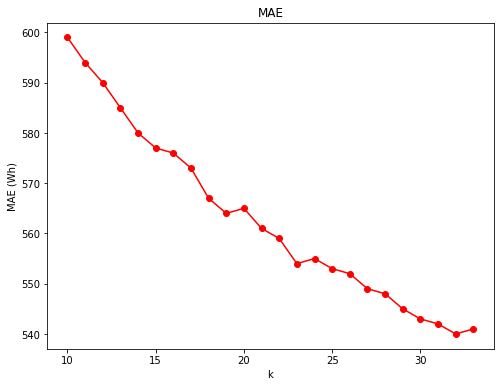

In [23]:
#Visualizing the silhouette scores in a plot

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(kMin,kMax),MAE_NO_DECIMAL_Ire,marker="o",color="red")
ax.set_xlabel('k')
ax.set_ylabel('MAE (Wh)')
ax.title.set_text('MAE')

<bound method KMeansModel.predict of KMeansModel: uid=KMeans_6ffc351f7402, k=10, distanceMeasure=euclidean, numFeatures=24>

## SIL

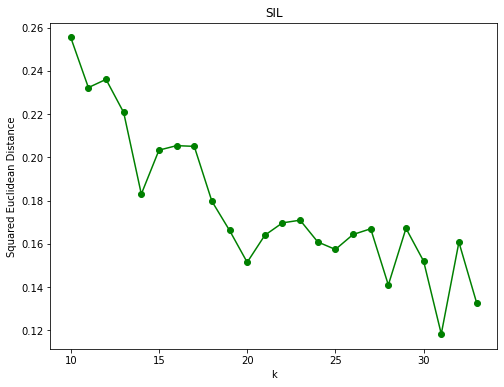

In [32]:
#Visualizing the silhouette scores in a plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(kMin,kMax),silhouette_score_kmeans_models,marker="o",color="green")
ax.set_xlabel('k')
ax.set_ylabel('Squared Euclidean Distance')
ax.title.set_text('SIL')

### Model centroids of each kmean model
   

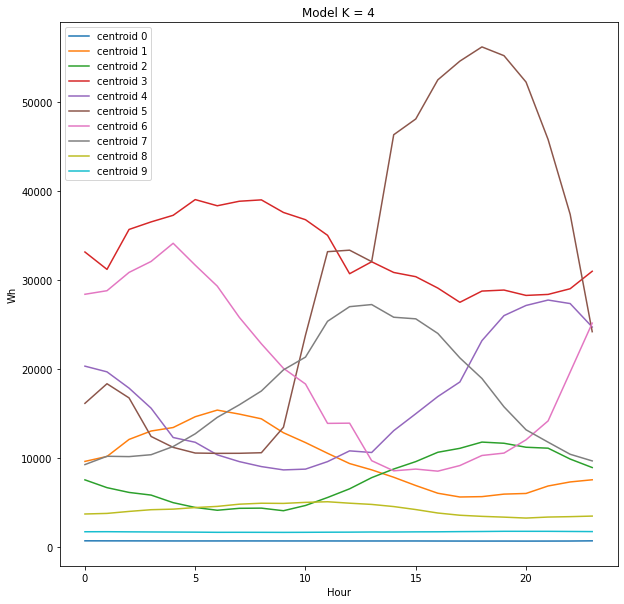

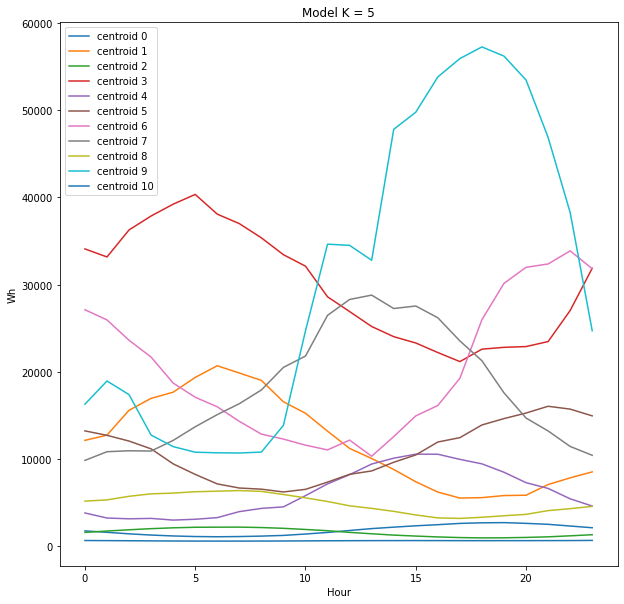

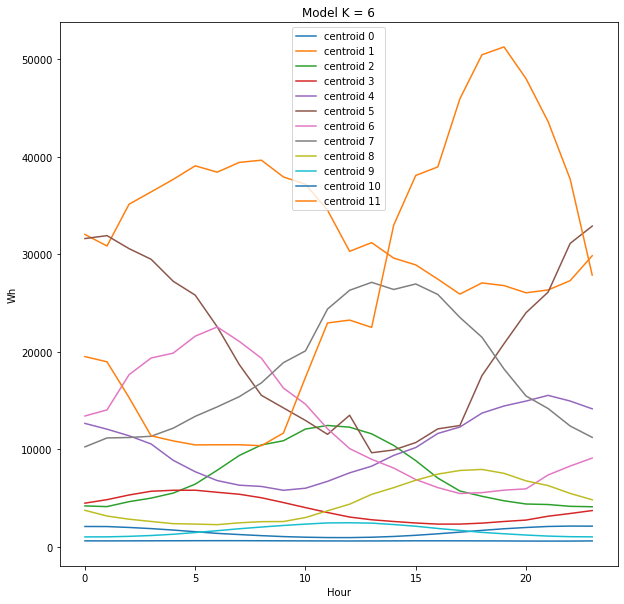

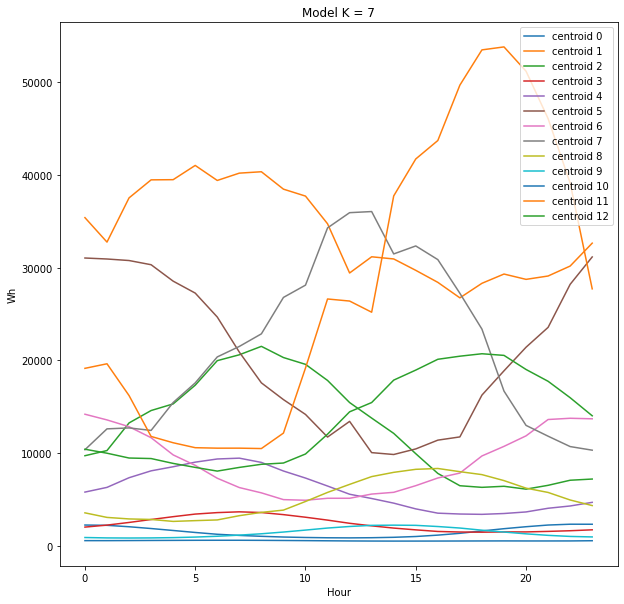

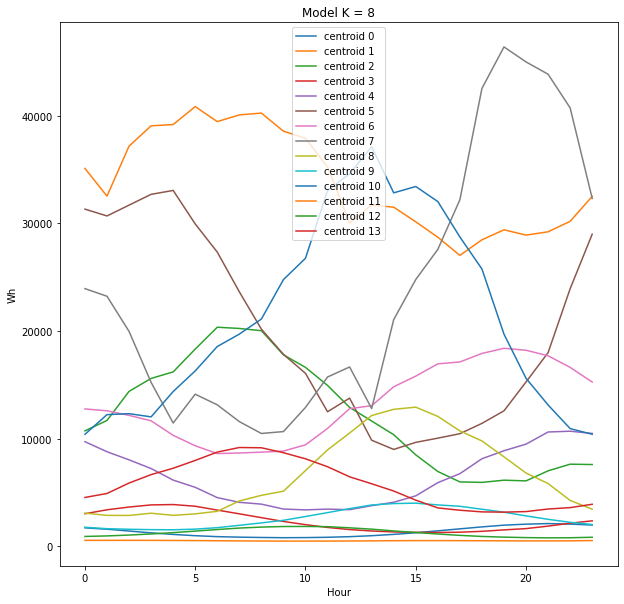

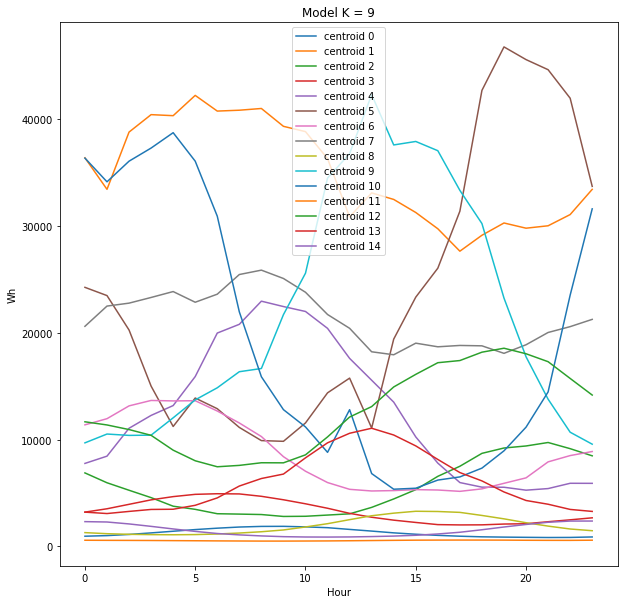

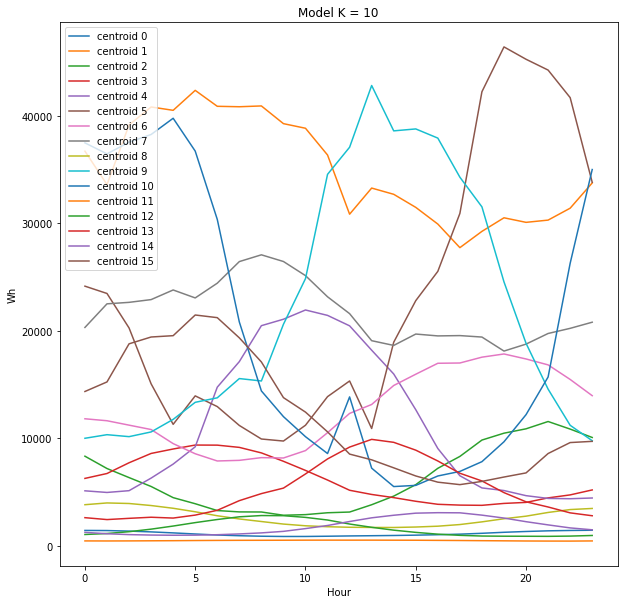

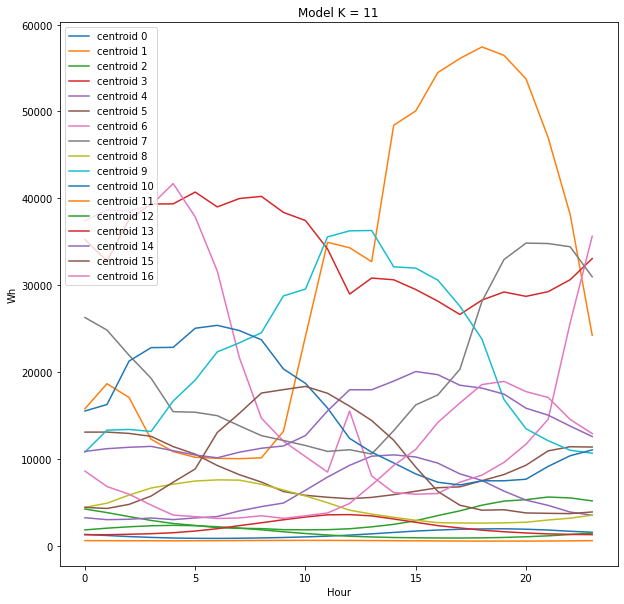

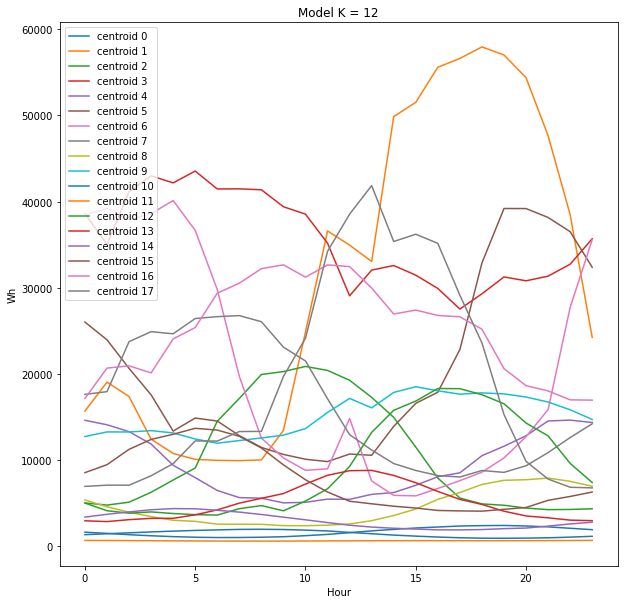

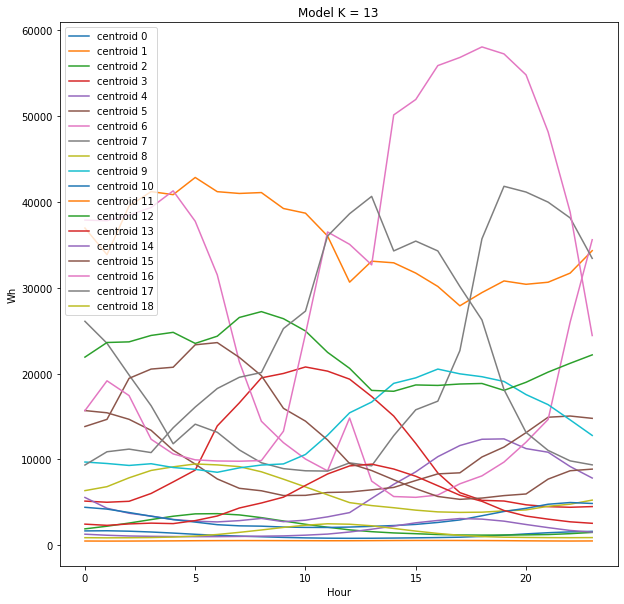

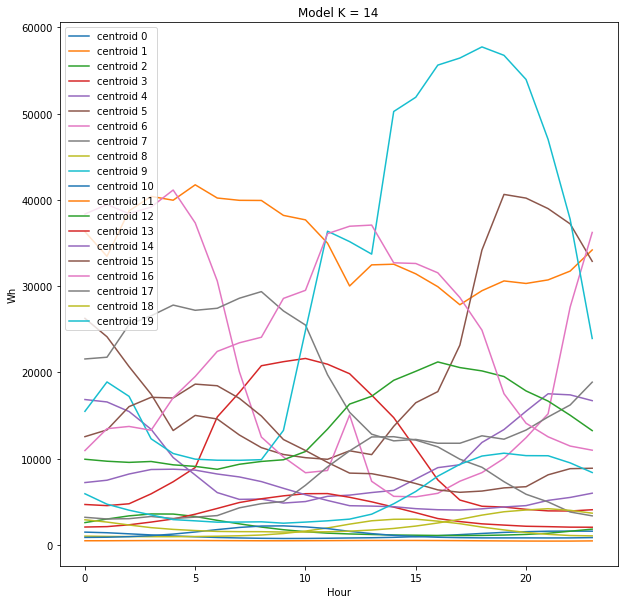

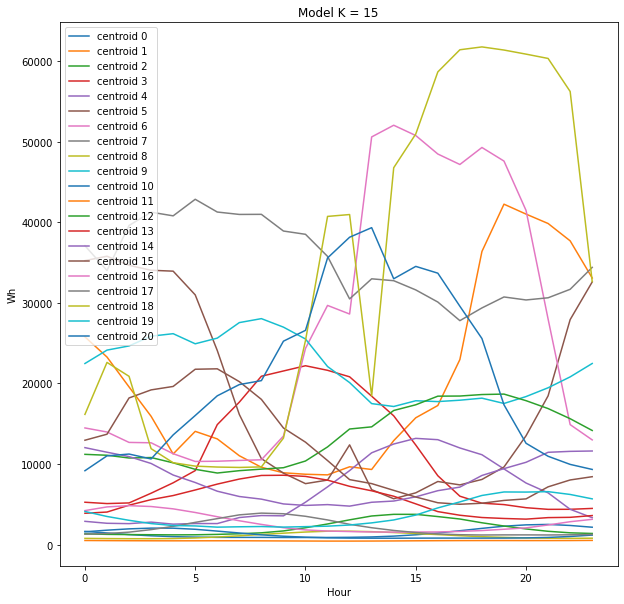

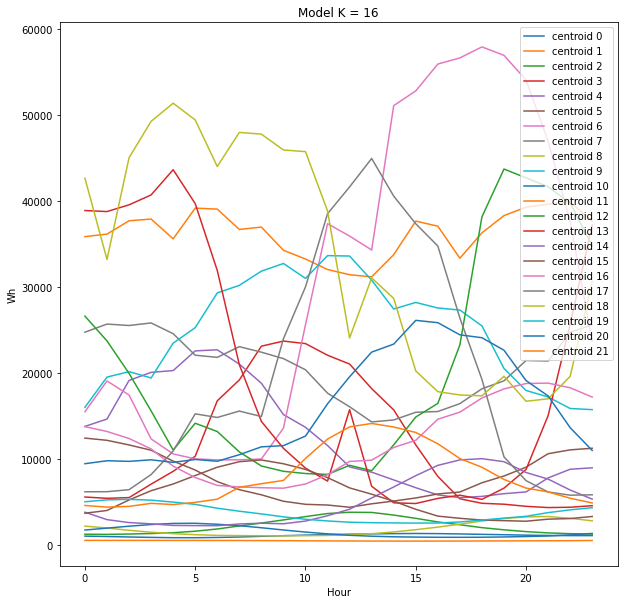

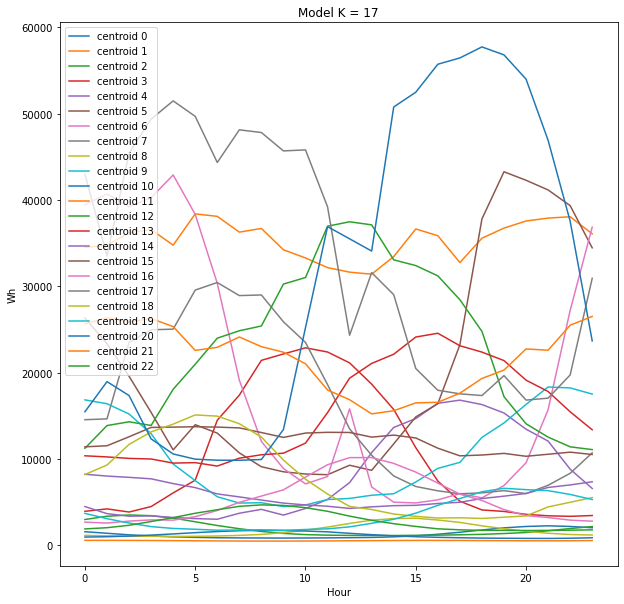

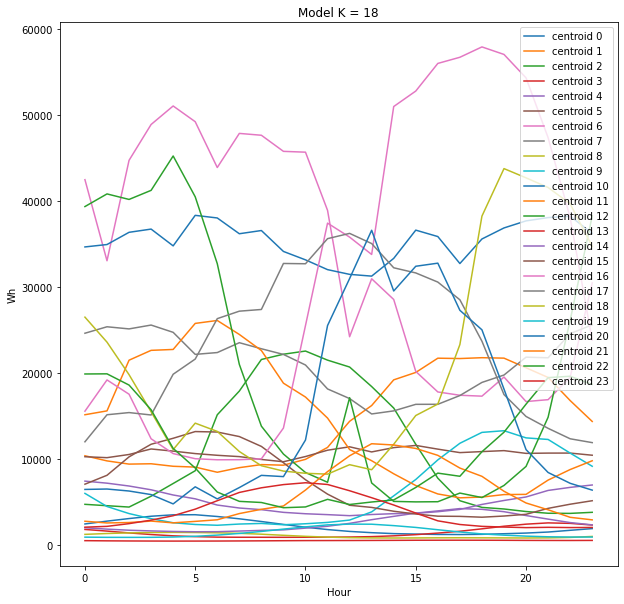

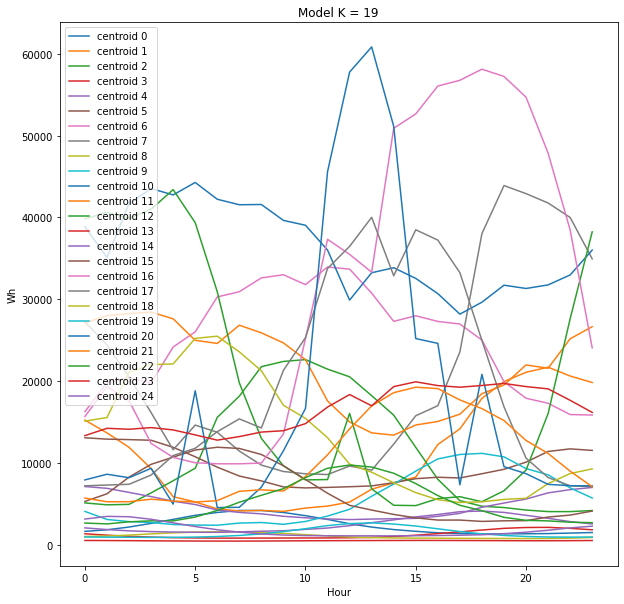

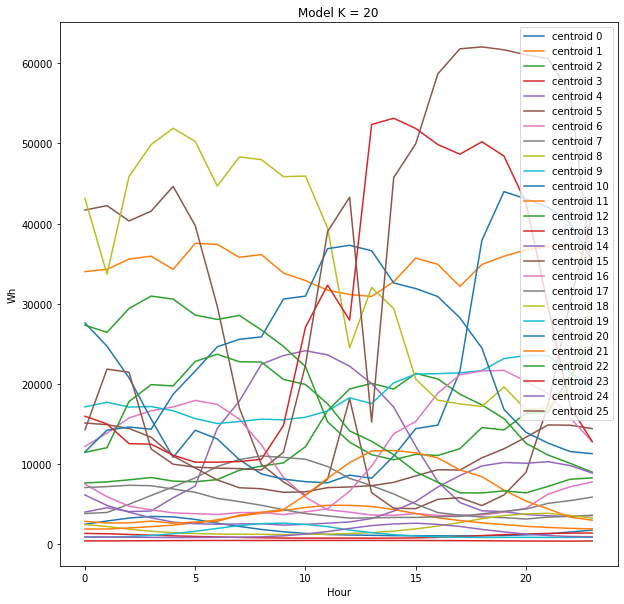

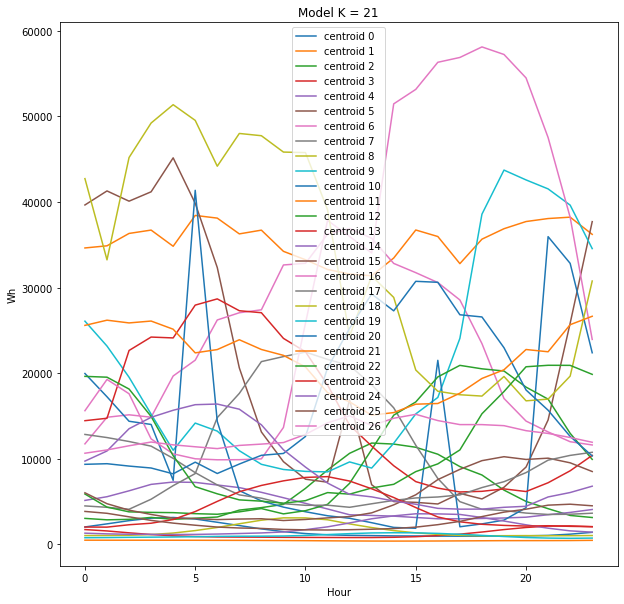

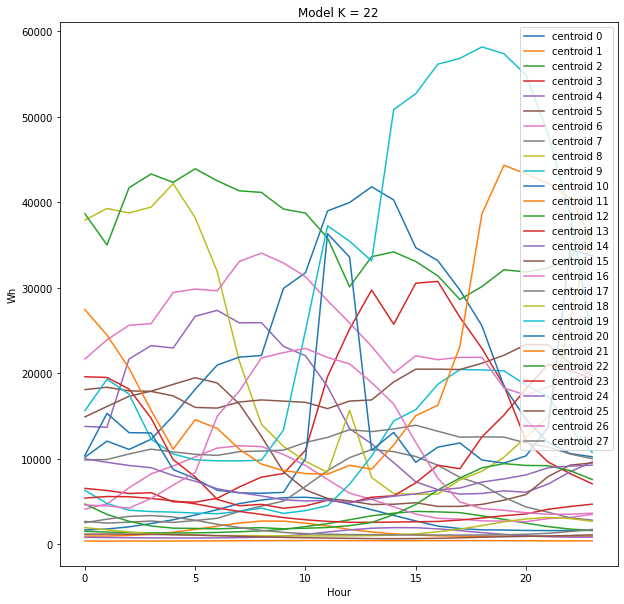

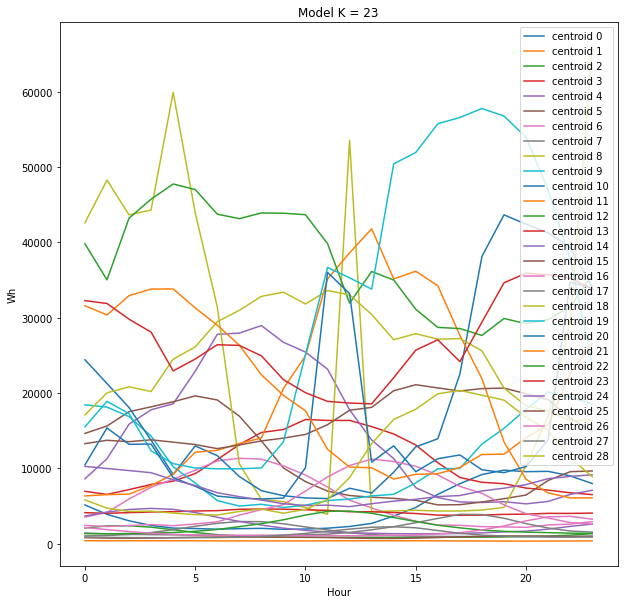

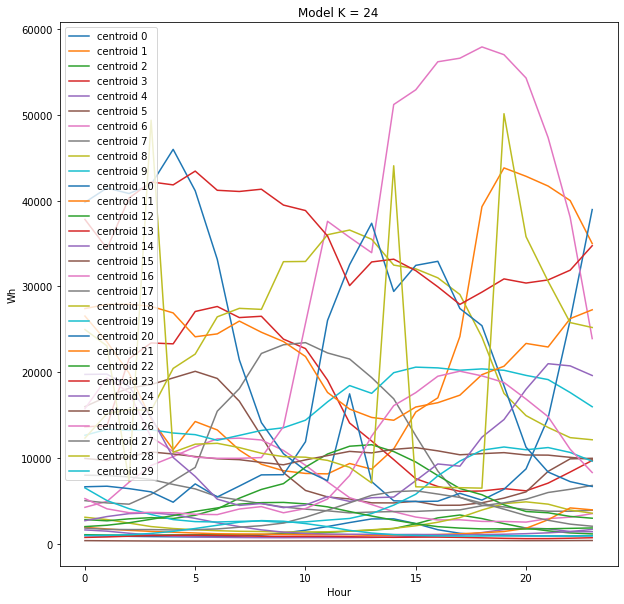

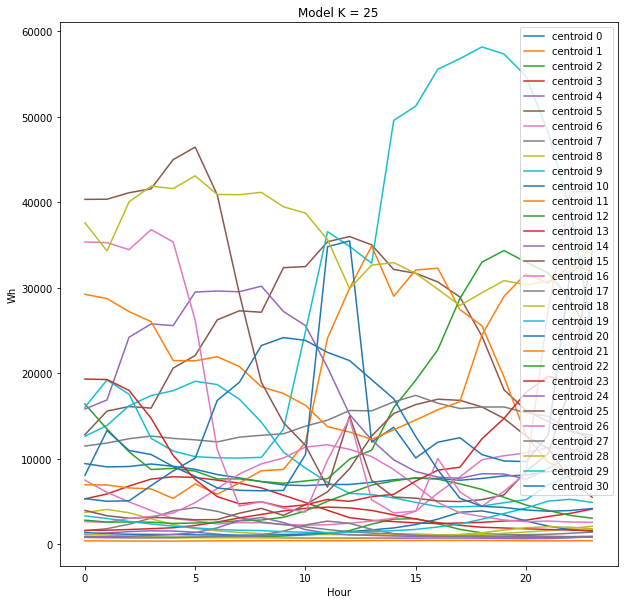

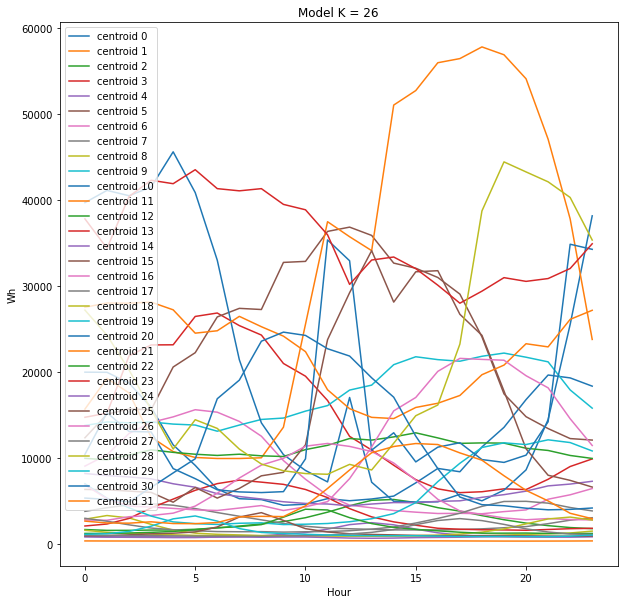

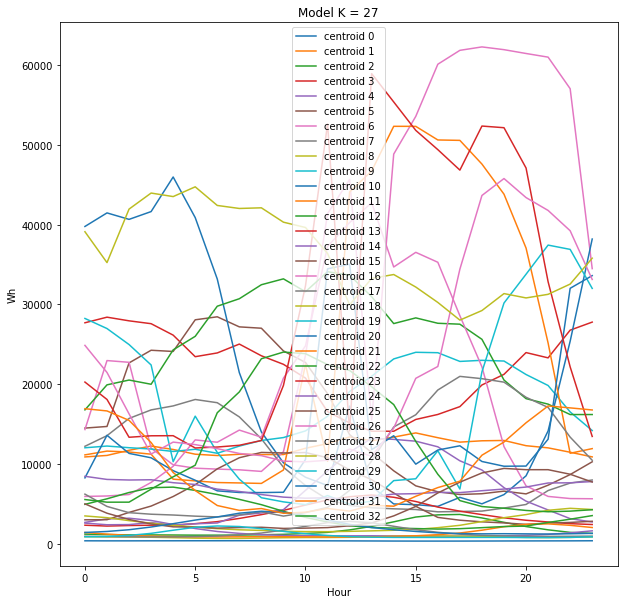

In [179]:
kIndex = 4
from random import randint
from matplotlib import cm

#Hours
x = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23])

bla = list_of_models[0:1]

for model in list_of_models:
    
    centroids = model.clusterCenters()
    
    
    #fig, axs = plt.subplots(len(centroids))
    #fig.subplots_adjust(hspace = .5, wspace=.001)
    #fig.suptitle('Centroids for  model k = ' + str(kIndex))
    #fig.tight_layout()

    #Create colors for centroids of model
    
    colors = cm.get_cmap('plasma', len(centroids))
    
    
    plt.figure(figsize=(10, 10))
    
    
    for i in range (0, len(centroids)):
        
        y = centroids[i]
        #axs[i].plot(x, y, 'tab:red')
        #axs[i].set_title("centroid " + str(i))
        
        plt.plot(x, y, label='centroid '+ str(i) )
        
      
    plt.ylabel("Wh")
    plt.xlabel("Hour")
    plt.title("Model K = " + str(kIndex) )
    plt.legend()
    plt.show()
                
    kIndex = kIndex + 1

### Plot centroids for purposed Model with optimal k value

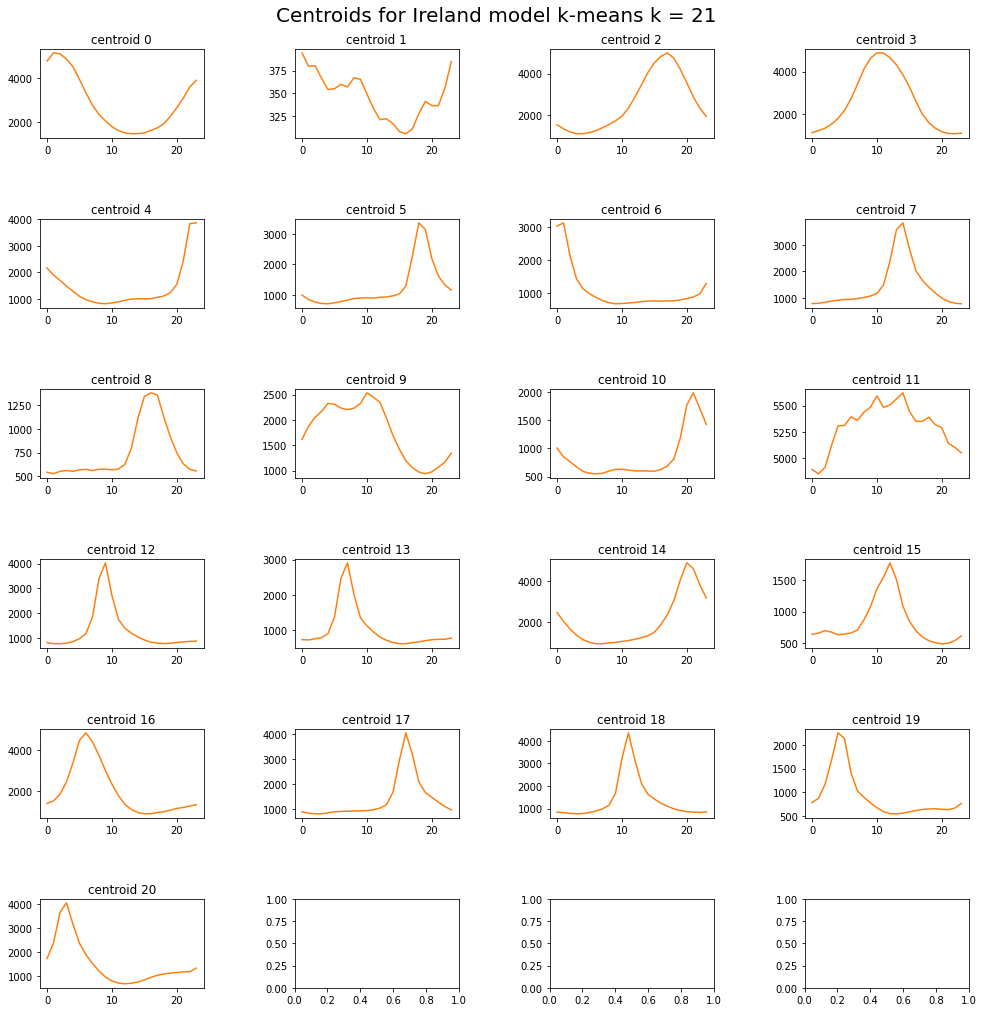

In [357]:
# nCent = 0
opt = 21
model_ = list_of_models[opt-kMin] ## cambiar por el mejor modelo
bestModel = model_
centroids = bestModel.clusterCenters()

#Hours
x = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23])

M =6
N= 4

fig, axs = plt.subplots(M, N,figsize=(15,15))

fig.tight_layout(pad=6.0)

fig.suptitle('Centroids for Ireland model k-means k = '+str(opt), fontsize=20)
nCent = 0
for i in range(M):
    for j in range(N):
            if (nCent<opt):
                y = centroids[nCent]
                axs[i, j].plot(x, y, 'tab:orange')
                axs[i, j].set_title("centroid " + str(nCent))
                nCent+=1
            #plt.plot(axs)


 


# Training  bisectional k-means models

Bisecting k-means is a kind of hierarchical clustering using a divisive (or “top-down”) approach: all observations start in one cluster, and splits are performed recursively as one moves down the hierarchy.

https://spark.apache.org/docs/latest/ml-clustering.html

In [107]:
import warnings
warnings.filterwarnings('ignore')
from pyspark.ml.clustering import BisectingKMeans

# Trains a k-means model.

silhouette_bisect_score=[]
list_of_centroid_list_bisect = []
list_of_models_bisect = []

k = kMin

for i in range(kMin, kMax):
    
    print ("Training model k:"+str(k))
    
    bkm = BisectingKMeans().setK(i).setSeed(1)
    # Choose random state for reproducibility
    model = bkm.fit(df) 
    
    # Save ssilhouette score for k value
    list_of_models_bisect.append(model)
    
    # Shows the result.
    centers = model.clusterCenters()
           
    list_of_centroid_list_bisect.append(centers)
           
    # Make predictions
    predictions = model.transform(df)

    # Evaluate clustering by computing Silhouette score
    evaluator = ClusteringEvaluator()

    silhouette = evaluator.evaluate(predictions)
    
    # Save ssilhouette score for k value
    silhouette_bisect_score.append(silhouette)
    
    k = k +1
    




Training model k:2


22/06/09 20:16:04 WARN MemoryStore: Not enough space to cache rdd_7226_7 in memory! (computed 21.1 MiB so far)
22/06/09 20:16:04 WARN BlockManager: Persisting block rdd_7226_7 to disk instead.
22/06/09 20:16:05 WARN MemoryStore: Not enough space to cache rdd_7226_8 in memory! (computed 30.8 MiB so far)
22/06/09 20:16:05 WARN BlockManager: Persisting block rdd_7226_8 to disk instead.
22/06/09 20:16:05 WARN MemoryStore: Not enough space to cache rdd_7226_9 in memory! (computed 30.8 MiB so far)
22/06/09 20:16:05 WARN BlockManager: Persisting block rdd_7226_9 to disk instead.
22/06/09 20:16:05 WARN MemoryStore: Not enough space to cache rdd_7226_0 in memory! (computed 30.5 MiB so far)
22/06/09 20:16:05 WARN BlockManager: Persisting block rdd_7226_0 to disk instead.
22/06/09 20:16:05 WARN MemoryStore: Not enough space to cache rdd_7226_2 in memory! (computed 30.8 MiB so far)
22/06/09 20:16:05 WARN BlockManager: Persisting block rdd_7226_2 to disk instead.
22/06/09 20:16:05 WARN MemoryStore:

22/06/09 20:16:18 WARN MemoryStore: Not enough space to cache rdd_7226_1 in memory! (computed 13.7 MiB so far)
22/06/09 20:16:18 WARN MemoryStore: Not enough space to cache rdd_7226_10 in memory! (computed 13.7 MiB so far)
22/06/09 20:16:18 WARN MemoryStore: Not enough space to cache rdd_7226_0 in memory! (computed 13.6 MiB so far)
22/06/09 20:16:18 WARN MemoryStore: Not enough space to cache rdd_7226_9 in memory! (computed 20.5 MiB so far)
22/06/09 20:16:18 WARN MemoryStore: Not enough space to cache rdd_7226_6 in memory! (computed 20.5 MiB so far)
22/06/09 20:16:18 WARN MemoryStore: Not enough space to cache rdd_7226_3 in memory! (computed 21.1 MiB so far)
22/06/09 20:16:18 WARN MemoryStore: Not enough space to cache rdd_7226_7 in memory! (computed 21.1 MiB so far)
22/06/09 20:16:19 WARN MemoryStore: Not enough space to cache rdd_7226_6 in memory! (computed 13.7 MiB so far)
22/06/09 20:16:19 WARN MemoryStore: Not enough space to cache rdd_7226_7 in memory! (computed 13.7 MiB so far)


22/06/09 20:16:32 WARN MemoryStore: Not enough space to cache rdd_7226_1 in memory! (computed 13.7 MiB so far)
22/06/09 20:16:32 WARN MemoryStore: Not enough space to cache rdd_7226_9 in memory! (computed 13.7 MiB so far)
22/06/09 20:16:32 WARN MemoryStore: Not enough space to cache rdd_7226_0 in memory! (computed 13.6 MiB so far)
22/06/09 20:16:32 WARN MemoryStore: Not enough space to cache rdd_7226_10 in memory! (computed 20.5 MiB so far)
22/06/09 20:16:32 WARN MemoryStore: Not enough space to cache rdd_7226_7 in memory! (computed 21.1 MiB so far)
22/06/09 20:16:32 WARN MemoryStore: Not enough space to cache rdd_7226_6 in memory! (computed 20.5 MiB so far)
22/06/09 20:16:32 WARN MemoryStore: Not enough space to cache rdd_7226_3 in memory! (computed 21.1 MiB so far)
22/06/09 20:16:33 WARN MemoryStore: Not enough space to cache rdd_7226_0 in memory! (computed 13.6 MiB so far)
22/06/09 20:16:33 WARN MemoryStore: Not enough space to cache rdd_7226_7 in memory! (computed 13.7 MiB so far)


Training model k:3


22/06/09 20:16:47 WARN MemoryStore: Not enough space to cache rdd_7345_7 in memory! (computed 21.1 MiB so far)
22/06/09 20:16:47 WARN BlockManager: Persisting block rdd_7345_7 to disk instead.
22/06/09 20:16:49 WARN MemoryStore: Not enough space to cache rdd_7345_11 in memory! (computed 30.8 MiB so far)
22/06/09 20:16:49 WARN BlockManager: Persisting block rdd_7345_11 to disk instead.
22/06/09 20:16:49 WARN MemoryStore: Not enough space to cache rdd_7345_8 in memory! (computed 30.8 MiB so far)
22/06/09 20:16:49 WARN BlockManager: Persisting block rdd_7345_8 to disk instead.
22/06/09 20:16:49 WARN MemoryStore: Not enough space to cache rdd_7345_4 in memory! (computed 30.6 MiB so far)
22/06/09 20:16:49 WARN BlockManager: Persisting block rdd_7345_4 to disk instead.
22/06/09 20:16:49 WARN MemoryStore: Not enough space to cache rdd_7345_9 in memory! (computed 30.8 MiB so far)
22/06/09 20:16:49 WARN BlockManager: Persisting block rdd_7345_9 to disk instead.
22/06/09 20:16:49 WARN MemoryStor

22/06/09 20:17:17 WARN MemoryStore: Not enough space to cache rdd_7345_6 in memory! (computed 9.0 MiB so far)
22/06/09 20:17:17 WARN MemoryStore: Not enough space to cache rdd_7345_9 in memory! (computed 9.0 MiB so far)
22/06/09 20:17:17 WARN MemoryStore: Not enough space to cache rdd_7345_10 in memory! (computed 5.8 MiB so far)
22/06/09 20:17:17 WARN MemoryStore: Not enough space to cache rdd_7345_8 in memory! (computed 13.7 MiB so far)
22/06/09 20:17:17 WARN MemoryStore: Not enough space to cache rdd_7345_4 in memory! (computed 13.6 MiB so far)
22/06/09 20:17:17 WARN MemoryStore: Not enough space to cache rdd_7345_7 in memory! (computed 47.4 MiB so far)
22/06/09 20:17:18 WARN MemoryStore: Not enough space to cache rdd_7345_4 in memory! (computed 9.0 MiB so far)
22/06/09 20:17:18 WARN MemoryStore: Not enough space to cache rdd_7345_6 in memory! (computed 9.0 MiB so far)
22/06/09 20:17:18 WARN MemoryStore: Not enough space to cache rdd_7345_7 in memory! (computed 9.0 MiB so far)
22/06/

22/06/09 20:17:31 WARN MemoryStore: Not enough space to cache rdd_7345_10 in memory! (computed 9.0 MiB so far)
22/06/09 20:17:31 WARN MemoryStore: Not enough space to cache rdd_7345_6 in memory! (computed 9.0 MiB so far)
22/06/09 20:17:31 WARN MemoryStore: Not enough space to cache rdd_7345_7 in memory! (computed 9.0 MiB so far)
22/06/09 20:17:31 WARN MemoryStore: Not enough space to cache rdd_7345_4 in memory! (computed 9.0 MiB so far)
22/06/09 20:17:31 WARN MemoryStore: Not enough space to cache rdd_7345_8 in memory! (computed 9.0 MiB so far)
22/06/09 20:17:31 WARN MemoryStore: Not enough space to cache rdd_7345_9 in memory! (computed 9.0 MiB so far)
22/06/09 20:17:32 WARN MemoryStore: Not enough space to cache rdd_7345_9 in memory! (computed 9.0 MiB so far)
22/06/09 20:17:32 WARN MemoryStore: Not enough space to cache rdd_7345_6 in memory! (computed 9.0 MiB so far)
22/06/09 20:17:32 WARN MemoryStore: Not enough space to cache rdd_7345_4 in memory! (computed 9.0 MiB so far)
22/06/09 

Training model k:4


22/06/09 20:17:53 WARN MemoryStore: Not enough space to cache rdd_7547_9 in memory! (computed 20.5 MiB so far)
22/06/09 20:17:53 WARN BlockManager: Persisting block rdd_7547_9 to disk instead.
22/06/09 20:17:54 WARN MemoryStore: Not enough space to cache rdd_7547_10 in memory! (computed 30.8 MiB so far)
22/06/09 20:17:54 WARN BlockManager: Persisting block rdd_7547_10 to disk instead.
22/06/09 20:17:54 WARN MemoryStore: Not enough space to cache rdd_7547_2 in memory! (computed 30.8 MiB so far)
22/06/09 20:17:54 WARN BlockManager: Persisting block rdd_7547_2 to disk instead.
22/06/09 20:17:54 WARN MemoryStore: Not enough space to cache rdd_7547_4 in memory! (computed 30.6 MiB so far)
22/06/09 20:17:54 WARN BlockManager: Persisting block rdd_7547_4 to disk instead.
22/06/09 20:17:55 WARN MemoryStore: Not enough space to cache rdd_7547_6 in memory! (computed 30.8 MiB so far)
22/06/09 20:17:55 WARN BlockManager: Persisting block rdd_7547_6 to disk instead.
22/06/09 20:17:55 WARN MemoryStor

22/06/09 20:18:23 WARN MemoryStore: Not enough space to cache rdd_7547_4 in memory! (computed 13.6 MiB so far)
22/06/09 20:18:23 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_7632_4 in memory.
22/06/09 20:18:23 WARN MemoryStore: Not enough space to cache rdd_7632_4 in memory! (computed 640.0 B so far)
22/06/09 20:18:23 WARN BlockManager: Persisting block rdd_7632_4 to disk instead.
22/06/09 20:18:23 WARN MemoryStore: Not enough space to cache rdd_7547_10 in memory! (computed 13.7 MiB so far)
22/06/09 20:18:23 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_7632_10 in memory.
22/06/09 20:18:23 WARN MemoryStore: Not enough space to cache rdd_7632_10 in memory! (computed 640.0 B so far)
22/06/09 20:18:23 WARN BlockManager: Persisting block rdd_7632_10 to disk instead.
22/06/09 20:18:23 WARN MemoryStore: Not enough space to cache rdd_7547_5 in memory! (computed 13.7 MiB so far)
22/06/09 

22/06/09 20:18:35 WARN MemoryStore: Not enough space to cache rdd_7547_10 in memory! (computed 13.7 MiB so far)
22/06/09 20:18:36 WARN MemoryStore: Not enough space to cache rdd_7547_5 in memory! (computed 9.0 MiB so far)
22/06/09 20:18:36 WARN MemoryStore: Not enough space to cache rdd_7547_8 in memory! (computed 9.0 MiB so far)
22/06/09 20:18:36 WARN MemoryStore: Not enough space to cache rdd_7547_4 in memory! (computed 9.0 MiB so far)
22/06/09 20:18:36 WARN MemoryStore: Not enough space to cache rdd_7547_3 in memory! (computed 9.0 MiB so far)
22/06/09 20:18:36 WARN MemoryStore: Not enough space to cache rdd_7547_2 in memory! (computed 9.0 MiB so far)
22/06/09 20:18:36 WARN MemoryStore: Not enough space to cache rdd_7547_10 in memory! (computed 13.7 MiB so far)
22/06/09 20:18:38 WARN MemoryStore: Not enough space to cache rdd_7547_8 in memory! (computed 9.0 MiB so far)
22/06/09 20:18:38 WARN MemoryStore: Not enough space to cache rdd_7547_4 in memory! (computed 9.0 MiB so far)
22/06/

Training model k:5


22/06/09 20:19:03 WARN MemoryStore: Not enough space to cache rdd_7749_0 in memory! (computed 20.3 MiB so far)
22/06/09 20:19:03 WARN BlockManager: Persisting block rdd_7749_0 to disk instead.
22/06/09 20:19:04 WARN MemoryStore: Not enough space to cache rdd_7749_11 in memory! (computed 30.8 MiB so far)
22/06/09 20:19:04 WARN BlockManager: Persisting block rdd_7749_11 to disk instead.
22/06/09 20:19:04 WARN MemoryStore: Not enough space to cache rdd_7749_9 in memory! (computed 30.8 MiB so far)
22/06/09 20:19:04 WARN BlockManager: Persisting block rdd_7749_9 to disk instead.
22/06/09 20:19:04 WARN MemoryStore: Not enough space to cache rdd_7749_1 in memory! (computed 30.8 MiB so far)
22/06/09 20:19:04 WARN BlockManager: Persisting block rdd_7749_1 to disk instead.
22/06/09 20:19:04 WARN MemoryStore: Not enough space to cache rdd_7749_8 in memory! (computed 30.8 MiB so far)
22/06/09 20:19:04 WARN BlockManager: Persisting block rdd_7749_8 to disk instead.
22/06/09 20:19:04 WARN MemoryStor

22/06/09 20:19:19 WARN MemoryStore: Not enough space to cache rdd_7749_1 in memory! (computed 20.5 MiB so far)
22/06/09 20:19:19 WARN MemoryStore: Not enough space to cache rdd_7749_6 in memory! (computed 20.5 MiB so far)
22/06/09 20:19:19 WARN MemoryStore: Not enough space to cache rdd_7749_7 in memory! (computed 21.1 MiB so far)
22/06/09 20:19:19 WARN MemoryStore: Not enough space to cache rdd_7749_5 in memory! (computed 20.8 MiB so far)
22/06/09 20:19:19 WARN MemoryStore: Not enough space to cache rdd_7749_3 in memory! (computed 21.1 MiB so far)
22/06/09 20:19:19 WARN MemoryStore: Not enough space to cache rdd_7749_8 in memory! (computed 20.5 MiB so far)
22/06/09 20:19:19 WARN MemoryStore: Not enough space to cache rdd_7749_2 in memory! (computed 20.5 MiB so far)
22/06/09 20:19:19 WARN MemoryStore: Not enough space to cache rdd_7749_9 in memory! (computed 30.8 MiB so far)
22/06/09 20:19:21 WARN MemoryStore: Not enough space to cache rdd_7749_7 in memory! (computed 21.1 MiB so far)
2

22/06/09 20:19:34 WARN MemoryStore: Not enough space to cache rdd_7749_2 in memory! (computed 20.5 MiB so far)
22/06/09 20:19:34 WARN MemoryStore: Not enough space to cache rdd_7749_9 in memory! (computed 20.5 MiB so far)
22/06/09 20:19:34 WARN MemoryStore: Not enough space to cache rdd_7749_7 in memory! (computed 21.1 MiB so far)
22/06/09 20:19:34 WARN MemoryStore: Not enough space to cache rdd_7749_8 in memory! (computed 20.5 MiB so far)
22/06/09 20:19:34 WARN MemoryStore: Not enough space to cache rdd_7749_6 in memory! (computed 20.5 MiB so far)
22/06/09 20:19:34 WARN MemoryStore: Not enough space to cache rdd_7749_3 in memory! (computed 21.1 MiB so far)
22/06/09 20:19:34 WARN MemoryStore: Not enough space to cache rdd_7749_5 in memory! (computed 20.8 MiB so far)
22/06/09 20:19:35 WARN MemoryStore: Not enough space to cache rdd_7749_1 in memory! (computed 30.8 MiB so far)
22/06/09 20:19:36 WARN MemoryStore: Not enough space to cache rdd_7749_9 in memory! (computed 20.5 MiB so far)
2

22/06/09 20:19:46 WARN MemoryStore: Not enough space to cache rdd_7749_7 in memory! (computed 13.7 MiB so far)
22/06/09 20:19:46 WARN MemoryStore: Not enough space to cache rdd_7749_6 in memory! (computed 13.7 MiB so far)
22/06/09 20:19:46 WARN MemoryStore: Not enough space to cache rdd_7749_9 in memory! (computed 20.5 MiB so far)
22/06/09 20:19:46 WARN MemoryStore: Not enough space to cache rdd_7749_8 in memory! (computed 20.5 MiB so far)
22/06/09 20:19:46 WARN MemoryStore: Not enough space to cache rdd_7749_5 in memory! (computed 20.8 MiB so far)
22/06/09 20:19:46 WARN MemoryStore: Not enough space to cache rdd_7749_1 in memory! (computed 20.5 MiB so far)
22/06/09 20:19:46 WARN MemoryStore: Not enough space to cache rdd_7749_3 in memory! (computed 21.1 MiB so far)
22/06/09 20:19:46 WARN MemoryStore: Not enough space to cache rdd_7749_2 in memory! (computed 20.5 MiB so far)
22/06/09 20:19:48 WARN MemoryStore: Not enough space to cache rdd_7749_1 in memory! (computed 13.7 MiB so far)
2

22/06/09 20:20:02 WARN MemoryStore: Not enough space to cache rdd_7749_5 in memory! (computed 13.7 MiB so far)
22/06/09 20:20:02 WARN MemoryStore: Not enough space to cache rdd_7749_8 in memory! (computed 20.5 MiB so far)
22/06/09 20:20:02 WARN MemoryStore: Not enough space to cache rdd_7749_2 in memory! (computed 20.5 MiB so far)
22/06/09 20:20:02 WARN MemoryStore: Not enough space to cache rdd_7749_6 in memory! (computed 20.5 MiB so far)
22/06/09 20:20:02 WARN MemoryStore: Not enough space to cache rdd_7749_1 in memory! (computed 20.5 MiB so far)
22/06/09 20:20:02 WARN MemoryStore: Not enough space to cache rdd_7749_9 in memory! (computed 20.5 MiB so far)
22/06/09 20:20:02 WARN MemoryStore: Not enough space to cache rdd_7749_7 in memory! (computed 21.1 MiB so far)
22/06/09 20:20:03 WARN MemoryStore: Not enough space to cache rdd_7749_3 in memory! (computed 21.1 MiB so far)
22/06/09 20:20:04 WARN MemoryStore: Not enough space to cache rdd_7749_9 in memory! (computed 13.7 MiB so far)
2

22/06/09 20:20:15 WARN MemoryStore: Not enough space to cache rdd_7749_1 in memory! (computed 20.5 MiB so far)
22/06/09 20:20:15 WARN MemoryStore: Not enough space to cache rdd_7749_3 in memory! (computed 13.7 MiB so far)
22/06/09 20:20:15 WARN MemoryStore: Not enough space to cache rdd_7749_5 in memory! (computed 13.7 MiB so far)
22/06/09 20:20:15 WARN MemoryStore: Not enough space to cache rdd_7749_6 in memory! (computed 20.5 MiB so far)
22/06/09 20:20:15 WARN MemoryStore: Not enough space to cache rdd_7749_7 in memory! (computed 13.7 MiB so far)
22/06/09 20:20:15 WARN MemoryStore: Not enough space to cache rdd_7749_2 in memory! (computed 13.7 MiB so far)
22/06/09 20:20:15 WARN MemoryStore: Not enough space to cache rdd_7749_9 in memory! (computed 30.8 MiB so far)
22/06/09 20:20:15 WARN MemoryStore: Not enough space to cache rdd_7749_8 in memory! (computed 30.8 MiB so far)
22/06/09 20:20:16 WARN MemoryStore: Not enough space to cache rdd_7749_5 in memory! (computed 13.7 MiB so far)
2

22/06/09 20:20:26 WARN MemoryStore: Not enough space to cache rdd_7749_6 in memory! (computed 13.7 MiB so far)
22/06/09 20:20:26 WARN MemoryStore: Not enough space to cache rdd_7749_1 in memory! (computed 13.7 MiB so far)
22/06/09 20:20:26 WARN MemoryStore: Not enough space to cache rdd_7749_3 in memory! (computed 21.1 MiB so far)
22/06/09 20:20:26 WARN MemoryStore: Not enough space to cache rdd_7749_2 in memory! (computed 20.5 MiB so far)
22/06/09 20:20:26 WARN MemoryStore: Not enough space to cache rdd_7749_9 in memory! (computed 20.5 MiB so far)
22/06/09 20:20:27 WARN MemoryStore: Not enough space to cache rdd_7749_5 in memory! (computed 20.8 MiB so far)
22/06/09 20:20:27 WARN MemoryStore: Not enough space to cache rdd_7749_7 in memory! (computed 21.1 MiB so far)
22/06/09 20:20:27 WARN MemoryStore: Not enough space to cache rdd_7749_8 in memory! (computed 20.5 MiB so far)
22/06/09 20:20:28 WARN MemoryStore: Not enough space to cache rdd_7749_7 in memory! (computed 13.7 MiB so far)
2

Training model k:6


22/06/09 20:20:53 WARN MemoryStore: Not enough space to cache rdd_8034_3 in memory! (computed 21.1 MiB so far)
22/06/09 20:20:53 WARN BlockManager: Persisting block rdd_8034_3 to disk instead.
22/06/09 20:20:54 WARN MemoryStore: Not enough space to cache rdd_8034_0 in memory! (computed 30.5 MiB so far)
22/06/09 20:20:54 WARN BlockManager: Persisting block rdd_8034_0 to disk instead.
22/06/09 20:20:54 WARN MemoryStore: Not enough space to cache rdd_8034_8 in memory! (computed 30.8 MiB so far)
22/06/09 20:20:54 WARN BlockManager: Persisting block rdd_8034_8 to disk instead.
22/06/09 20:20:54 WARN MemoryStore: Not enough space to cache rdd_8034_2 in memory! (computed 30.8 MiB so far)
22/06/09 20:20:54 WARN MemoryStore: Not enough space to cache rdd_8034_4 in memory! (computed 30.6 MiB so far)
22/06/09 20:20:54 WARN BlockManager: Persisting block rdd_8034_2 to disk instead.
22/06/09 20:20:54 WARN BlockManager: Persisting block rdd_8034_4 to disk instead.
22/06/09 20:20:54 WARN MemoryStore:

22/06/09 20:21:09 WARN MemoryStore: Not enough space to cache rdd_8034_8 in memory! (computed 13.7 MiB so far)
22/06/09 20:21:09 WARN MemoryStore: Not enough space to cache rdd_8034_1 in memory! (computed 13.7 MiB so far)
22/06/09 20:21:09 WARN MemoryStore: Not enough space to cache rdd_8034_4 in memory! (computed 13.6 MiB so far)
22/06/09 20:21:09 WARN MemoryStore: Not enough space to cache rdd_8034_9 in memory! (computed 20.5 MiB so far)
22/06/09 20:21:09 WARN MemoryStore: Not enough space to cache rdd_8034_6 in memory! (computed 20.5 MiB so far)
22/06/09 20:21:09 WARN MemoryStore: Not enough space to cache rdd_8034_0 in memory! (computed 20.3 MiB so far)
22/06/09 20:21:09 WARN MemoryStore: Not enough space to cache rdd_8034_5 in memory! (computed 20.8 MiB so far)
22/06/09 20:21:10 WARN MemoryStore: Not enough space to cache rdd_8034_6 in memory! (computed 13.7 MiB so far)
22/06/09 20:21:10 WARN MemoryStore: Not enough space to cache rdd_8034_0 in memory! (computed 13.6 MiB so far)
2

22/06/09 20:21:26 WARN MemoryStore: Not enough space to cache rdd_8034_1 in memory! (computed 13.7 MiB so far)
22/06/09 20:21:26 WARN MemoryStore: Not enough space to cache rdd_8034_9 in memory! (computed 13.7 MiB so far)
22/06/09 20:21:26 WARN MemoryStore: Not enough space to cache rdd_8034_6 in memory! (computed 13.7 MiB so far)
22/06/09 20:21:26 WARN MemoryStore: Not enough space to cache rdd_8034_4 in memory! (computed 20.4 MiB so far)
22/06/09 20:21:26 WARN MemoryStore: Not enough space to cache rdd_8034_0 in memory! (computed 20.3 MiB so far)
22/06/09 20:21:26 WARN MemoryStore: Not enough space to cache rdd_8034_8 in memory! (computed 20.5 MiB so far)
22/06/09 20:21:26 WARN MemoryStore: Not enough space to cache rdd_8034_5 in memory! (computed 20.8 MiB so far)
22/06/09 20:21:27 WARN MemoryStore: Not enough space to cache rdd_8034_4 in memory! (computed 13.6 MiB so far)
22/06/09 20:21:27 WARN MemoryStore: Not enough space to cache rdd_8034_9 in memory! (computed 13.7 MiB so far)
2

22/06/09 20:21:41 WARN MemoryStore: Not enough space to cache rdd_8034_6 in memory! (computed 13.7 MiB so far)
22/06/09 20:21:41 WARN MemoryStore: Not enough space to cache rdd_8034_4 in memory! (computed 13.6 MiB so far)
22/06/09 20:21:41 WARN MemoryStore: Not enough space to cache rdd_8034_8 in memory! (computed 13.7 MiB so far)
22/06/09 20:21:41 WARN MemoryStore: Not enough space to cache rdd_8034_1 in memory! (computed 13.7 MiB so far)
22/06/09 20:21:41 WARN MemoryStore: Not enough space to cache rdd_8034_5 in memory! (computed 13.7 MiB so far)
22/06/09 20:21:41 WARN MemoryStore: Not enough space to cache rdd_8034_0 in memory! (computed 13.6 MiB so far)
22/06/09 20:21:41 WARN MemoryStore: Not enough space to cache rdd_8034_9 in memory! (computed 20.5 MiB so far)
22/06/09 20:21:43 WARN MemoryStore: Not enough space to cache rdd_8034_8 in memory! (computed 13.7 MiB so far)
22/06/09 20:21:43 WARN MemoryStore: Not enough space to cache rdd_8034_5 in memory! (computed 13.7 MiB so far)
2

22/06/09 20:22:01 WARN MemoryStore: Not enough space to cache rdd_8034_0 in memory! (computed 13.6 MiB so far)
22/06/09 20:22:01 WARN MemoryStore: Not enough space to cache rdd_8034_4 in memory! (computed 13.6 MiB so far)
22/06/09 20:22:01 WARN MemoryStore: Not enough space to cache rdd_8034_9 in memory! (computed 13.7 MiB so far)
22/06/09 20:22:01 WARN MemoryStore: Not enough space to cache rdd_8034_1 in memory! (computed 13.7 MiB so far)
22/06/09 20:22:01 WARN MemoryStore: Not enough space to cache rdd_8034_5 in memory! (computed 13.7 MiB so far)
22/06/09 20:22:01 WARN MemoryStore: Not enough space to cache rdd_8034_8 in memory! (computed 13.7 MiB so far)
22/06/09 20:22:01 WARN MemoryStore: Not enough space to cache rdd_8034_6 in memory! (computed 20.5 MiB so far)
22/06/09 20:22:03 WARN MemoryStore: Not enough space to cache rdd_8034_8 in memory! (computed 13.7 MiB so far)
22/06/09 20:22:03 WARN MemoryStore: Not enough space to cache rdd_8034_4 in memory! (computed 13.6 MiB so far)
2

22/06/09 20:22:19 WARN MemoryStore: Not enough space to cache rdd_8034_4 in memory! (computed 13.6 MiB so far)
22/06/09 20:22:19 WARN MemoryStore: Not enough space to cache rdd_8034_9 in memory! (computed 13.7 MiB so far)
22/06/09 20:22:19 WARN MemoryStore: Not enough space to cache rdd_8034_5 in memory! (computed 13.7 MiB so far)
22/06/09 20:22:19 WARN MemoryStore: Not enough space to cache rdd_8034_6 in memory! (computed 13.7 MiB so far)
22/06/09 20:22:19 WARN MemoryStore: Not enough space to cache rdd_8034_1 in memory! (computed 13.7 MiB so far)
22/06/09 20:22:19 WARN MemoryStore: Not enough space to cache rdd_8034_0 in memory! (computed 13.6 MiB so far)
22/06/09 20:22:19 WARN MemoryStore: Not enough space to cache rdd_8034_8 in memory! (computed 20.5 MiB so far)
22/06/09 20:22:21 WARN MemoryStore: Not enough space to cache rdd_8034_5 in memory! (computed 13.7 MiB so far)
22/06/09 20:22:21 WARN MemoryStore: Not enough space to cache rdd_8034_1 in memory! (computed 13.7 MiB so far)
2

22/06/09 20:22:36 WARN MemoryStore: Not enough space to cache rdd_8034_1 in memory! (computed 13.7 MiB so far)
22/06/09 20:22:36 WARN MemoryStore: Not enough space to cache rdd_8034_0 in memory! (computed 13.6 MiB so far)
22/06/09 20:22:36 WARN MemoryStore: Not enough space to cache rdd_8034_9 in memory! (computed 13.7 MiB so far)
22/06/09 20:22:36 WARN MemoryStore: Not enough space to cache rdd_8034_8 in memory! (computed 13.7 MiB so far)
22/06/09 20:22:36 WARN MemoryStore: Not enough space to cache rdd_8034_6 in memory! (computed 13.7 MiB so far)
22/06/09 20:22:36 WARN MemoryStore: Not enough space to cache rdd_8034_4 in memory! (computed 13.6 MiB so far)
22/06/09 20:22:36 WARN MemoryStore: Not enough space to cache rdd_8034_5 in memory! (computed 20.8 MiB so far)
22/06/09 20:22:37 WARN MemoryStore: Not enough space to cache rdd_8034_9 in memory! (computed 13.7 MiB so far)
22/06/09 20:22:37 WARN MemoryStore: Not enough space to cache rdd_8034_8 in memory! (computed 13.7 MiB so far)
2

Training model k:7


22/06/09 20:22:56 WARN MemoryStore: Not enough space to cache rdd_8319_7 in memory! (computed 21.1 MiB so far)
22/06/09 20:22:56 WARN BlockManager: Persisting block rdd_8319_7 to disk instead.
22/06/09 20:22:57 WARN MemoryStore: Not enough space to cache rdd_8319_11 in memory! (computed 30.8 MiB so far)
22/06/09 20:22:57 WARN BlockManager: Persisting block rdd_8319_11 to disk instead.
22/06/09 20:22:57 WARN MemoryStore: Not enough space to cache rdd_8319_1 in memory! (computed 30.8 MiB so far)
22/06/09 20:22:57 WARN BlockManager: Persisting block rdd_8319_1 to disk instead.
22/06/09 20:22:57 WARN MemoryStore: Not enough space to cache rdd_8319_10 in memory! (computed 30.8 MiB so far)
22/06/09 20:22:57 WARN BlockManager: Persisting block rdd_8319_10 to disk instead.
22/06/09 20:22:57 WARN MemoryStore: Not enough space to cache rdd_8319_6 in memory! (computed 30.8 MiB so far)
22/06/09 20:22:57 WARN BlockManager: Persisting block rdd_8319_6 to disk instead.
22/06/09 20:22:57 WARN MemorySt

22/06/09 20:23:11 WARN MemoryStore: Not enough space to cache rdd_8319_9 in memory! (computed 20.5 MiB so far)
22/06/09 20:23:11 WARN MemoryStore: Not enough space to cache rdd_8319_6 in memory! (computed 20.5 MiB so far)
22/06/09 20:23:11 WARN MemoryStore: Not enough space to cache rdd_8319_2 in memory! (computed 20.5 MiB so far)
22/06/09 20:23:11 WARN MemoryStore: Not enough space to cache rdd_8319_5 in memory! (computed 20.8 MiB so far)
22/06/09 20:23:11 WARN MemoryStore: Not enough space to cache rdd_8319_0 in memory! (computed 20.3 MiB so far)
22/06/09 20:23:11 WARN MemoryStore: Not enough space to cache rdd_8319_10 in memory! (computed 20.5 MiB so far)
22/06/09 20:23:11 WARN MemoryStore: Not enough space to cache rdd_8319_8 in memory! (computed 20.5 MiB so far)
22/06/09 20:23:12 WARN MemoryStore: Not enough space to cache rdd_8319_7 in memory! (computed 31.6 MiB so far)
22/06/09 20:23:13 WARN MemoryStore: Not enough space to cache rdd_8319_6 in memory! (computed 20.5 MiB so far)


22/06/09 20:23:32 WARN MemoryStore: Not enough space to cache rdd_8319_7 in memory! (computed 21.1 MiB so far)
22/06/09 20:23:32 WARN MemoryStore: Not enough space to cache rdd_8319_0 in memory! (computed 20.3 MiB so far)
22/06/09 20:23:32 WARN MemoryStore: Not enough space to cache rdd_8319_5 in memory! (computed 20.8 MiB so far)
22/06/09 20:23:32 WARN MemoryStore: Not enough space to cache rdd_8319_6 in memory! (computed 20.5 MiB so far)
22/06/09 20:23:32 WARN MemoryStore: Not enough space to cache rdd_8319_2 in memory! (computed 20.5 MiB so far)
22/06/09 20:23:32 WARN MemoryStore: Not enough space to cache rdd_8319_9 in memory! (computed 20.5 MiB so far)
22/06/09 20:23:32 WARN MemoryStore: Not enough space to cache rdd_8319_8 in memory! (computed 20.5 MiB so far)
22/06/09 20:23:32 WARN MemoryStore: Not enough space to cache rdd_8319_10 in memory! (computed 30.8 MiB so far)
22/06/09 20:23:34 WARN MemoryStore: Not enough space to cache rdd_8319_10 in memory! (computed 20.5 MiB so far)

22/06/09 20:23:48 WARN MemoryStore: Not enough space to cache rdd_8319_6 in memory! (computed 13.7 MiB so far)
22/06/09 20:23:48 WARN MemoryStore: Not enough space to cache rdd_8319_9 in memory! (computed 20.5 MiB so far)
22/06/09 20:23:48 WARN MemoryStore: Not enough space to cache rdd_8319_8 in memory! (computed 20.5 MiB so far)
22/06/09 20:23:48 WARN MemoryStore: Not enough space to cache rdd_8319_7 in memory! (computed 21.1 MiB so far)
22/06/09 20:23:48 WARN MemoryStore: Not enough space to cache rdd_8319_2 in memory! (computed 20.5 MiB so far)
22/06/09 20:23:48 WARN MemoryStore: Not enough space to cache rdd_8319_0 in memory! (computed 20.3 MiB so far)
22/06/09 20:23:48 WARN MemoryStore: Not enough space to cache rdd_8319_5 in memory! (computed 20.8 MiB so far)
22/06/09 20:23:48 WARN MemoryStore: Not enough space to cache rdd_8319_10 in memory! (computed 20.5 MiB so far)
22/06/09 20:23:49 WARN MemoryStore: Not enough space to cache rdd_8319_6 in memory! (computed 13.7 MiB so far)


22/06/09 20:24:08 WARN MemoryStore: Not enough space to cache rdd_8319_8 in memory! (computed 13.7 MiB so far)
22/06/09 20:24:08 WARN MemoryStore: Not enough space to cache rdd_8319_6 in memory! (computed 20.5 MiB so far)
22/06/09 20:24:08 WARN MemoryStore: Not enough space to cache rdd_8319_7 in memory! (computed 21.1 MiB so far)
22/06/09 20:24:08 WARN MemoryStore: Not enough space to cache rdd_8319_9 in memory! (computed 20.5 MiB so far)
22/06/09 20:24:08 WARN MemoryStore: Not enough space to cache rdd_8319_0 in memory! (computed 20.3 MiB so far)
22/06/09 20:24:08 WARN MemoryStore: Not enough space to cache rdd_8319_2 in memory! (computed 20.5 MiB so far)
22/06/09 20:24:08 WARN MemoryStore: Not enough space to cache rdd_8319_10 in memory! (computed 20.5 MiB so far)
22/06/09 20:24:08 WARN MemoryStore: Not enough space to cache rdd_8319_5 in memory! (computed 20.8 MiB so far)
22/06/09 20:24:09 WARN MemoryStore: Not enough space to cache rdd_8319_2 in memory! (computed 13.7 MiB so far)


22/06/09 20:24:24 WARN MemoryStore: Not enough space to cache rdd_8319_7 in memory! (computed 13.7 MiB so far)
22/06/09 20:24:24 WARN MemoryStore: Not enough space to cache rdd_8319_6 in memory! (computed 20.5 MiB so far)
22/06/09 20:24:24 WARN MemoryStore: Not enough space to cache rdd_8319_8 in memory! (computed 20.5 MiB so far)
22/06/09 20:24:24 WARN MemoryStore: Not enough space to cache rdd_8319_5 in memory! (computed 13.7 MiB so far)
22/06/09 20:24:24 WARN MemoryStore: Not enough space to cache rdd_8319_10 in memory! (computed 20.5 MiB so far)
22/06/09 20:24:24 WARN MemoryStore: Not enough space to cache rdd_8319_0 in memory! (computed 30.5 MiB so far)
22/06/09 20:24:24 WARN MemoryStore: Not enough space to cache rdd_8319_9 in memory! (computed 20.5 MiB so far)
22/06/09 20:24:24 WARN MemoryStore: Not enough space to cache rdd_8319_2 in memory! (computed 20.5 MiB so far)
22/06/09 20:24:26 WARN MemoryStore: Not enough space to cache rdd_8319_0 in memory! (computed 13.6 MiB so far)


22/06/09 20:24:46 WARN MemoryStore: Not enough space to cache rdd_8319_0 in memory! (computed 13.6 MiB so far)
22/06/09 20:24:46 WARN MemoryStore: Not enough space to cache rdd_8319_2 in memory! (computed 20.5 MiB so far)
22/06/09 20:24:46 WARN MemoryStore: Not enough space to cache rdd_8319_9 in memory! (computed 20.5 MiB so far)
22/06/09 20:24:46 WARN MemoryStore: Not enough space to cache rdd_8319_8 in memory! (computed 20.5 MiB so far)
22/06/09 20:24:46 WARN MemoryStore: Not enough space to cache rdd_8319_10 in memory! (computed 20.5 MiB so far)
22/06/09 20:24:46 WARN MemoryStore: Not enough space to cache rdd_8319_6 in memory! (computed 20.5 MiB so far)
22/06/09 20:24:46 WARN MemoryStore: Not enough space to cache rdd_8319_7 in memory! (computed 21.1 MiB so far)
22/06/09 20:24:46 WARN MemoryStore: Not enough space to cache rdd_8319_5 in memory! (computed 20.8 MiB so far)
22/06/09 20:24:48 WARN MemoryStore: Not enough space to cache rdd_8319_2 in memory! (computed 13.7 MiB so far)


Training model k:8


22/06/09 20:25:22 WARN MemoryStore: Not enough space to cache rdd_8604_9 in memory! (computed 20.5 MiB so far)
22/06/09 20:25:22 WARN BlockManager: Persisting block rdd_8604_9 to disk instead.
22/06/09 20:25:23 WARN MemoryStore: Not enough space to cache rdd_8604_0 in memory! (computed 30.5 MiB so far)
22/06/09 20:25:23 WARN BlockManager: Persisting block rdd_8604_0 to disk instead.
22/06/09 20:25:23 WARN MemoryStore: Not enough space to cache rdd_8604_1 in memory! (computed 30.8 MiB so far)
22/06/09 20:25:23 WARN BlockManager: Persisting block rdd_8604_1 to disk instead.
22/06/09 20:25:23 WARN MemoryStore: Not enough space to cache rdd_8604_11 in memory! (computed 30.8 MiB so far)
22/06/09 20:25:23 WARN BlockManager: Persisting block rdd_8604_11 to disk instead.
22/06/09 20:25:23 WARN MemoryStore: Not enough space to cache rdd_8604_8 in memory! (computed 30.8 MiB so far)
22/06/09 20:25:23 WARN BlockManager: Persisting block rdd_8604_8 to disk instead.
22/06/09 20:25:23 WARN MemoryStor

22/06/09 20:25:54 WARN MemoryStore: Not enough space to cache rdd_8604_2 in memory! (computed 9.0 MiB so far)
22/06/09 20:25:54 WARN MemoryStore: Not enough space to cache rdd_8604_10 in memory! (computed 5.8 MiB so far)
22/06/09 20:25:54 WARN MemoryStore: Not enough space to cache rdd_8604_6 in memory! (computed 9.0 MiB so far)
22/06/09 20:25:54 WARN MemoryStore: Not enough space to cache rdd_8604_1 in memory! (computed 9.0 MiB so far)
22/06/09 20:25:54 WARN MemoryStore: Not enough space to cache rdd_8604_8 in memory! (computed 9.0 MiB so far)
22/06/09 20:25:54 WARN MemoryStore: Not enough space to cache rdd_8604_9 in memory! (computed 13.7 MiB so far)
22/06/09 20:25:55 WARN MemoryStore: Not enough space to cache rdd_8604_9 in memory! (computed 9.0 MiB so far)
22/06/09 20:25:55 WARN MemoryStore: Not enough space to cache rdd_8604_1 in memory! (computed 9.0 MiB so far)
22/06/09 20:25:55 WARN MemoryStore: Not enough space to cache rdd_8604_2 in memory! (computed 9.0 MiB so far)
22/06/09

22/06/09 20:26:12 WARN MemoryStore: Not enough space to cache rdd_8604_2 in memory! (computed 9.0 MiB so far)
22/06/09 20:26:12 WARN MemoryStore: Not enough space to cache rdd_8604_9 in memory! (computed 9.0 MiB so far)
22/06/09 20:26:12 WARN MemoryStore: Not enough space to cache rdd_8604_6 in memory! (computed 9.0 MiB so far)
22/06/09 20:26:12 WARN MemoryStore: Not enough space to cache rdd_8604_1 in memory! (computed 9.0 MiB so far)
22/06/09 20:26:12 WARN MemoryStore: Not enough space to cache rdd_8604_8 in memory! (computed 9.0 MiB so far)
22/06/09 20:26:12 WARN MemoryStore: Not enough space to cache rdd_8604_10 in memory! (computed 9.0 MiB so far)
22/06/09 20:26:13 WARN MemoryStore: Not enough space to cache rdd_8604_2 in memory! (computed 9.0 MiB so far)
22/06/09 20:26:13 WARN MemoryStore: Not enough space to cache rdd_8604_9 in memory! (computed 9.0 MiB so far)
22/06/09 20:26:13 WARN MemoryStore: Not enough space to cache rdd_8604_8 in memory! (computed 9.0 MiB so far)
22/06/09 

22/06/09 20:26:26 WARN MemoryStore: Not enough space to cache rdd_8604_1 in memory! (computed 9.0 MiB so far)
22/06/09 20:26:26 WARN MemoryStore: Not enough space to cache rdd_8604_9 in memory! (computed 9.0 MiB so far)
22/06/09 20:26:26 WARN MemoryStore: Not enough space to cache rdd_8604_8 in memory! (computed 9.0 MiB so far)
22/06/09 20:26:26 WARN MemoryStore: Not enough space to cache rdd_8604_10 in memory! (computed 9.0 MiB so far)
22/06/09 20:26:26 WARN MemoryStore: Not enough space to cache rdd_8604_6 in memory! (computed 9.0 MiB so far)
22/06/09 20:26:26 WARN MemoryStore: Not enough space to cache rdd_8604_2 in memory! (computed 9.0 MiB so far)
22/06/09 20:26:27 WARN MemoryStore: Not enough space to cache rdd_8604_2 in memory! (computed 9.0 MiB so far)
22/06/09 20:26:27 WARN MemoryStore: Not enough space to cache rdd_8604_6 in memory! (computed 9.0 MiB so far)
22/06/09 20:26:27 WARN MemoryStore: Not enough space to cache rdd_8604_8 in memory! (computed 9.0 MiB so far)
22/06/09 

22/06/09 20:26:43 WARN MemoryStore: Not enough space to cache rdd_8604_2 in memory! (computed 9.0 MiB so far)
22/06/09 20:26:43 WARN MemoryStore: Not enough space to cache rdd_8604_8 in memory! (computed 9.0 MiB so far)
22/06/09 20:26:43 WARN MemoryStore: Not enough space to cache rdd_8604_1 in memory! (computed 9.0 MiB so far)
22/06/09 20:26:43 WARN MemoryStore: Not enough space to cache rdd_8604_10 in memory! (computed 9.0 MiB so far)
22/06/09 20:26:43 WARN MemoryStore: Not enough space to cache rdd_8604_6 in memory! (computed 9.0 MiB so far)
22/06/09 20:26:43 WARN MemoryStore: Not enough space to cache rdd_8604_9 in memory! (computed 9.0 MiB so far)
22/06/09 20:26:44 WARN MemoryStore: Not enough space to cache rdd_8604_9 in memory! (computed 9.0 MiB so far)
22/06/09 20:26:44 WARN MemoryStore: Not enough space to cache rdd_8604_6 in memory! (computed 9.0 MiB so far)
22/06/09 20:26:44 WARN MemoryStore: Not enough space to cache rdd_8604_10 in memory! (computed 9.0 MiB so far)
22/06/09

Training model k:9


22/06/09 20:27:06 WARN MemoryStore: Not enough space to cache rdd_8889_7 in memory! (computed 21.1 MiB so far)
22/06/09 20:27:06 WARN BlockManager: Persisting block rdd_8889_7 to disk instead.
22/06/09 20:27:08 WARN MemoryStore: Not enough space to cache rdd_8889_9 in memory! (computed 30.8 MiB so far)
22/06/09 20:27:08 WARN MemoryStore: Not enough space to cache rdd_8889_0 in memory! (computed 30.5 MiB so far)
22/06/09 20:27:08 WARN BlockManager: Persisting block rdd_8889_9 to disk instead.
22/06/09 20:27:08 WARN BlockManager: Persisting block rdd_8889_0 to disk instead.
22/06/09 20:27:08 WARN MemoryStore: Not enough space to cache rdd_8889_1 in memory! (computed 30.8 MiB so far)
22/06/09 20:27:08 WARN BlockManager: Persisting block rdd_8889_1 to disk instead.
22/06/09 20:27:08 WARN MemoryStore: Not enough space to cache rdd_8889_11 in memory! (computed 30.8 MiB so far)
22/06/09 20:27:08 WARN BlockManager: Persisting block rdd_8889_11 to disk instead.
22/06/09 20:27:08 WARN MemoryStor

22/06/09 20:27:42 WARN MemoryStore: Not enough space to cache rdd_8889_10 in memory! (computed 13.7 MiB so far)
22/06/09 20:27:42 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_8974_10 in memory.
22/06/09 20:27:42 WARN MemoryStore: Not enough space to cache rdd_8974_10 in memory! (computed 640.0 B so far)
22/06/09 20:27:42 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_8974_8 in memory.
22/06/09 20:27:42 WARN MemoryStore: Not enough space to cache rdd_8974_8 in memory! (computed 640.0 B so far)
22/06/09 20:27:42 WARN BlockManager: Persisting block rdd_8974_10 to disk instead.
22/06/09 20:27:42 WARN BlockManager: Persisting block rdd_8974_8 to disk instead.
22/06/09 20:27:42 WARN MemoryStore: Not enough space to cache rdd_8889_7 in memory! (computed 13.7 MiB so far)
22/06/09 20:27:42 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_897

22/06/09 20:27:57 WARN MemoryStore: Not enough space to cache rdd_8889_9 in memory! (computed 9.0 MiB so far)
22/06/09 20:27:57 WARN MemoryStore: Not enough space to cache rdd_8889_7 in memory! (computed 9.0 MiB so far)
22/06/09 20:27:57 WARN MemoryStore: Not enough space to cache rdd_8889_8 in memory! (computed 9.0 MiB so far)
22/06/09 20:27:57 WARN MemoryStore: Not enough space to cache rdd_8889_6 in memory! (computed 9.0 MiB so far)
22/06/09 20:27:57 WARN MemoryStore: Not enough space to cache rdd_8889_10 in memory! (computed 9.0 MiB so far)
22/06/09 20:27:57 WARN MemoryStore: Not enough space to cache rdd_8889_2 in memory! (computed 9.0 MiB so far)
22/06/09 20:27:59 WARN MemoryStore: Not enough space to cache rdd_8889_7 in memory! (computed 9.0 MiB so far)
22/06/09 20:27:59 WARN MemoryStore: Not enough space to cache rdd_8889_8 in memory! (computed 9.0 MiB so far)
22/06/09 20:27:59 WARN MemoryStore: Not enough space to cache rdd_8889_2 in memory! (computed 9.0 MiB so far)
22/06/09 

22/06/09 20:28:12 WARN MemoryStore: Not enough space to cache rdd_8889_9 in memory! (computed 13.7 MiB so far)
22/06/09 20:28:12 WARN MemoryStore: Not enough space to cache rdd_8889_6 in memory! (computed 13.7 MiB so far)
22/06/09 20:28:13 WARN MemoryStore: Not enough space to cache rdd_8889_2 in memory! (computed 5.8 MiB so far)
22/06/09 20:28:13 WARN MemoryStore: Not enough space to cache rdd_8889_7 in memory! (computed 9.0 MiB so far)
22/06/09 20:28:13 WARN MemoryStore: Not enough space to cache rdd_8889_10 in memory! (computed 9.0 MiB so far)
22/06/09 20:28:13 WARN MemoryStore: Not enough space to cache rdd_8889_8 in memory! (computed 13.7 MiB so far)
22/06/09 20:28:14 WARN MemoryStore: Not enough space to cache rdd_8889_2 in memory! (computed 9.0 MiB so far)
22/06/09 20:28:14 WARN MemoryStore: Not enough space to cache rdd_8889_9 in memory! (computed 9.0 MiB so far)
22/06/09 20:28:14 WARN MemoryStore: Not enough space to cache rdd_8889_8 in memory! (computed 9.0 MiB so far)
22/06/

22/06/09 20:28:30 WARN MemoryStore: Not enough space to cache rdd_8889_9 in memory! (computed 9.0 MiB so far)
22/06/09 20:28:30 WARN MemoryStore: Not enough space to cache rdd_8889_7 in memory! (computed 9.0 MiB so far)
22/06/09 20:28:30 WARN MemoryStore: Not enough space to cache rdd_8889_6 in memory! (computed 9.0 MiB so far)
22/06/09 20:28:30 WARN MemoryStore: Not enough space to cache rdd_8889_2 in memory! (computed 9.0 MiB so far)
22/06/09 20:28:30 WARN MemoryStore: Not enough space to cache rdd_8889_8 in memory! (computed 9.0 MiB so far)
22/06/09 20:28:30 WARN MemoryStore: Not enough space to cache rdd_8889_10 in memory! (computed 9.0 MiB so far)
22/06/09 20:28:32 WARN MemoryStore: Not enough space to cache rdd_8889_6 in memory! (computed 9.0 MiB so far)
22/06/09 20:28:32 WARN MemoryStore: Not enough space to cache rdd_8889_8 in memory! (computed 9.0 MiB so far)
22/06/09 20:28:32 WARN MemoryStore: Not enough space to cache rdd_8889_2 in memory! (computed 9.0 MiB so far)
22/06/09 

22/06/09 20:28:43 WARN MemoryStore: Not enough space to cache rdd_8889_6 in memory! (computed 9.0 MiB so far)
22/06/09 20:28:43 WARN MemoryStore: Not enough space to cache rdd_8889_10 in memory! (computed 9.0 MiB so far)
22/06/09 20:28:43 WARN MemoryStore: Not enough space to cache rdd_8889_7 in memory! (computed 9.0 MiB so far)
22/06/09 20:28:43 WARN MemoryStore: Not enough space to cache rdd_8889_9 in memory! (computed 9.0 MiB so far)
22/06/09 20:28:43 WARN MemoryStore: Not enough space to cache rdd_8889_2 in memory! (computed 9.0 MiB so far)
22/06/09 20:28:43 WARN MemoryStore: Not enough space to cache rdd_8889_8 in memory! (computed 9.0 MiB so far)
22/06/09 20:28:43 WARN MemoryStore: Not enough space to cache rdd_8889_10 in memory! (computed 9.0 MiB so far)
22/06/09 20:28:43 WARN MemoryStore: Not enough space to cache rdd_8889_7 in memory! (computed 9.0 MiB so far)
22/06/09 20:28:43 WARN MemoryStore: Not enough space to cache rdd_8889_2 in memory! (computed 9.0 MiB so far)
22/06/09

22/06/09 20:28:51 WARN MemoryStore: Not enough space to cache rdd_8889_8 in memory! (computed 9.0 MiB so far)
22/06/09 20:28:51 WARN MemoryStore: Not enough space to cache rdd_8889_10 in memory! (computed 9.0 MiB so far)
22/06/09 20:28:51 WARN MemoryStore: Not enough space to cache rdd_8889_7 in memory! (computed 9.0 MiB so far)
22/06/09 20:28:51 WARN MemoryStore: Not enough space to cache rdd_8889_6 in memory! (computed 9.0 MiB so far)
22/06/09 20:28:51 WARN MemoryStore: Not enough space to cache rdd_8889_2 in memory! (computed 9.0 MiB so far)
22/06/09 20:28:51 WARN MemoryStore: Not enough space to cache rdd_8889_9 in memory! (computed 9.0 MiB so far)
22/06/09 20:28:51 WARN MemoryStore: Not enough space to cache rdd_8889_9 in memory! (computed 9.0 MiB so far)
22/06/09 20:28:51 WARN MemoryStore: Not enough space to cache rdd_8889_7 in memory! (computed 9.0 MiB so far)
22/06/09 20:28:51 WARN MemoryStore: Not enough space to cache rdd_8889_2 in memory! (computed 9.0 MiB so far)
22/06/09 

Training model k:10


22/06/09 20:29:09 WARN MemoryStore: Not enough space to cache rdd_9257_3 in memory! (computed 21.1 MiB so far)
22/06/09 20:29:09 WARN BlockManager: Persisting block rdd_9257_3 to disk instead.
22/06/09 20:29:10 WARN MemoryStore: Not enough space to cache rdd_9257_0 in memory! (computed 30.5 MiB so far)
22/06/09 20:29:10 WARN BlockManager: Persisting block rdd_9257_0 to disk instead.
22/06/09 20:29:10 WARN MemoryStore: Not enough space to cache rdd_9257_4 in memory! (computed 30.6 MiB so far)
22/06/09 20:29:10 WARN BlockManager: Persisting block rdd_9257_4 to disk instead.
22/06/09 20:29:10 WARN MemoryStore: Not enough space to cache rdd_9257_9 in memory! (computed 30.8 MiB so far)
22/06/09 20:29:10 WARN BlockManager: Persisting block rdd_9257_9 to disk instead.
22/06/09 20:29:10 WARN MemoryStore: Not enough space to cache rdd_9257_2 in memory! (computed 30.8 MiB so far)
22/06/09 20:29:10 WARN BlockManager: Persisting block rdd_9257_2 to disk instead.
22/06/09 20:29:10 WARN MemoryStore:

22/06/09 20:29:43 WARN MemoryStore: Not enough space to cache rdd_9257_2 in memory! (computed 30.8 MiB so far)
22/06/09 20:29:43 WARN MemoryStore: Not enough space to cache rdd_9257_4 in memory! (computed 30.6 MiB so far)
22/06/09 20:29:43 WARN MemoryStore: Not enough space to cache rdd_9257_9 in memory! (computed 30.8 MiB so far)
22/06/09 20:29:43 WARN MemoryStore: Not enough space to cache rdd_9257_7 in memory! (computed 31.6 MiB so far)
22/06/09 20:29:45 WARN MemoryStore: Not enough space to cache rdd_9257_2 in memory! (computed 20.5 MiB so far)
22/06/09 20:29:45 WARN MemoryStore: Not enough space to cache rdd_9257_1 in memory! (computed 20.5 MiB so far)
22/06/09 20:29:45 WARN MemoryStore: Not enough space to cache rdd_9257_3 in memory! (computed 21.1 MiB so far)
22/06/09 20:29:45 WARN MemoryStore: Not enough space to cache rdd_9257_5 in memory! (computed 20.8 MiB so far)
22/06/09 20:29:45 WARN MemoryStore: Not enough space to cache rdd_9257_7 in memory! (computed 21.1 MiB so far)
2

22/06/09 20:29:58 WARN MemoryStore: Not enough space to cache rdd_9257_0 in memory! (computed 13.6 MiB so far)
22/06/09 20:29:58 WARN MemoryStore: Not enough space to cache rdd_9257_5 in memory! (computed 20.8 MiB so far)
22/06/09 20:29:58 WARN MemoryStore: Not enough space to cache rdd_9257_7 in memory! (computed 21.1 MiB so far)
22/06/09 20:29:58 WARN MemoryStore: Not enough space to cache rdd_9257_3 in memory! (computed 21.1 MiB so far)
22/06/09 20:29:58 WARN MemoryStore: Not enough space to cache rdd_9257_1 in memory! (computed 20.5 MiB so far)
22/06/09 20:29:58 WARN MemoryStore: Not enough space to cache rdd_9257_2 in memory! (computed 20.5 MiB so far)
22/06/09 20:29:58 WARN MemoryStore: Not enough space to cache rdd_9257_9 in memory! (computed 30.8 MiB so far)
22/06/09 20:29:58 WARN MemoryStore: Not enough space to cache rdd_9257_4 in memory! (computed 30.6 MiB so far)
22/06/09 20:29:58 WARN MemoryStore: Not enough space to cache rdd_9257_10 in memory! (computed 30.8 MiB so far)


22/06/09 20:30:13 WARN MemoryStore: Not enough space to cache rdd_9257_10 in memory! (computed 20.5 MiB so far)
22/06/09 20:30:13 WARN MemoryStore: Not enough space to cache rdd_9257_1 in memory! (computed 20.5 MiB so far)
22/06/09 20:30:13 WARN MemoryStore: Not enough space to cache rdd_9257_5 in memory! (computed 20.8 MiB so far)
22/06/09 20:30:13 WARN MemoryStore: Not enough space to cache rdd_9257_9 in memory! (computed 20.5 MiB so far)
22/06/09 20:30:13 WARN MemoryStore: Not enough space to cache rdd_9257_4 in memory! (computed 20.4 MiB so far)
22/06/09 20:30:13 WARN MemoryStore: Not enough space to cache rdd_9257_7 in memory! (computed 21.1 MiB so far)
22/06/09 20:30:13 WARN MemoryStore: Not enough space to cache rdd_9257_3 in memory! (computed 21.1 MiB so far)
22/06/09 20:30:13 WARN MemoryStore: Not enough space to cache rdd_9257_2 in memory! (computed 30.8 MiB so far)
22/06/09 20:30:13 WARN MemoryStore: Not enough space to cache rdd_9257_0 in memory! (computed 30.5 MiB so far)


22/06/09 20:30:27 WARN MemoryStore: Not enough space to cache rdd_9257_9 in memory! (computed 20.5 MiB so far)
22/06/09 20:30:27 WARN MemoryStore: Not enough space to cache rdd_9257_5 in memory! (computed 20.8 MiB so far)
22/06/09 20:30:27 WARN MemoryStore: Not enough space to cache rdd_9257_1 in memory! (computed 20.5 MiB so far)
22/06/09 20:30:27 WARN MemoryStore: Not enough space to cache rdd_9257_2 in memory! (computed 20.5 MiB so far)
22/06/09 20:30:27 WARN MemoryStore: Not enough space to cache rdd_9257_0 in memory! (computed 20.3 MiB so far)
22/06/09 20:30:27 WARN MemoryStore: Not enough space to cache rdd_9257_3 in memory! (computed 21.1 MiB so far)
22/06/09 20:30:27 WARN MemoryStore: Not enough space to cache rdd_9257_7 in memory! (computed 21.1 MiB so far)
22/06/09 20:30:27 WARN MemoryStore: Not enough space to cache rdd_9257_4 in memory! (computed 30.6 MiB so far)
22/06/09 20:30:27 WARN MemoryStore: Not enough space to cache rdd_9257_10 in memory! (computed 30.8 MiB so far)


22/06/09 20:30:40 WARN MemoryStore: Not enough space to cache rdd_9257_2 in memory! (computed 20.5 MiB so far)
22/06/09 20:30:40 WARN MemoryStore: Not enough space to cache rdd_9257_10 in memory! (computed 20.5 MiB so far)
22/06/09 20:30:40 WARN MemoryStore: Not enough space to cache rdd_9257_9 in memory! (computed 20.5 MiB so far)
22/06/09 20:30:40 WARN MemoryStore: Not enough space to cache rdd_9257_3 in memory! (computed 21.1 MiB so far)
22/06/09 20:30:40 WARN MemoryStore: Not enough space to cache rdd_9257_7 in memory! (computed 21.1 MiB so far)
22/06/09 20:30:40 WARN MemoryStore: Not enough space to cache rdd_9257_4 in memory! (computed 20.4 MiB so far)
22/06/09 20:30:40 WARN MemoryStore: Not enough space to cache rdd_9257_5 in memory! (computed 20.8 MiB so far)
22/06/09 20:30:41 WARN MemoryStore: Not enough space to cache rdd_9257_0 in memory! (computed 30.5 MiB so far)
22/06/09 20:30:41 WARN MemoryStore: Not enough space to cache rdd_9257_1 in memory! (computed 30.8 MiB so far)


22/06/09 20:30:56 WARN MemoryStore: Not enough space to cache rdd_9257_4 in memory! (computed 20.4 MiB so far)
22/06/09 20:30:56 WARN MemoryStore: Not enough space to cache rdd_9257_7 in memory! (computed 21.1 MiB so far)
22/06/09 20:30:56 WARN MemoryStore: Not enough space to cache rdd_9257_3 in memory! (computed 21.1 MiB so far)
22/06/09 20:30:56 WARN MemoryStore: Not enough space to cache rdd_9257_2 in memory! (computed 20.5 MiB so far)
22/06/09 20:30:56 WARN MemoryStore: Not enough space to cache rdd_9257_10 in memory! (computed 20.5 MiB so far)
22/06/09 20:30:56 WARN MemoryStore: Not enough space to cache rdd_9257_9 in memory! (computed 20.5 MiB so far)
22/06/09 20:30:56 WARN MemoryStore: Not enough space to cache rdd_9257_5 in memory! (computed 20.8 MiB so far)
22/06/09 20:30:56 WARN MemoryStore: Not enough space to cache rdd_9257_0 in memory! (computed 30.5 MiB so far)
22/06/09 20:30:56 WARN MemoryStore: Not enough space to cache rdd_9257_1 in memory! (computed 30.8 MiB so far)


22/06/09 20:31:07 WARN MemoryStore: Not enough space to cache rdd_9508_8 in memory! (computed 2.0 MiB so far)
22/06/09 20:31:07 WARN BlockManager: Persisting block rdd_9508_8 to disk instead.
22/06/09 20:31:09 WARN MemoryStore: Not enough space to cache rdd_9257_5 in memory! (computed 20.8 MiB so far)
22/06/09 20:31:09 WARN MemoryStore: Not enough space to cache rdd_9257_1 in memory! (computed 20.5 MiB so far)
22/06/09 20:31:09 WARN MemoryStore: Not enough space to cache rdd_9257_9 in memory! (computed 20.5 MiB so far)
22/06/09 20:31:09 WARN MemoryStore: Not enough space to cache rdd_9257_2 in memory! (computed 13.7 MiB so far)
22/06/09 20:31:09 WARN MemoryStore: Not enough space to cache rdd_9257_3 in memory! (computed 13.7 MiB so far)
22/06/09 20:31:09 WARN MemoryStore: Not enough space to cache rdd_9257_10 in memory! (computed 20.5 MiB so far)
22/06/09 20:31:09 WARN MemoryStore: Not enough space to cache rdd_9257_0 in memory! (computed 30.5 MiB so far)
22/06/09 20:31:09 WARN MemoryS

22/06/09 20:31:31 WARN MemoryStore: Not enough space to cache rdd_9257_2 in memory! (computed 30.8 MiB so far)
22/06/09 20:31:31 WARN MemoryStore: Not enough space to cache rdd_9257_1 in memory! (computed 30.8 MiB so far)
22/06/09 20:31:32 WARN MemoryStore: Not enough space to cache rdd_9257_3 in memory! (computed 21.1 MiB so far)
22/06/09 20:31:32 WARN MemoryStore: Not enough space to cache rdd_9257_4 in memory! (computed 20.4 MiB so far)
22/06/09 20:31:32 WARN MemoryStore: Not enough space to cache rdd_9257_1 in memory! (computed 20.5 MiB so far)
22/06/09 20:31:32 WARN MemoryStore: Not enough space to cache rdd_9257_9 in memory! (computed 20.5 MiB so far)
22/06/09 20:31:32 WARN MemoryStore: Not enough space to cache rdd_9257_7 in memory! (computed 21.1 MiB so far)
22/06/09 20:31:32 WARN MemoryStore: Not enough space to cache rdd_9257_10 in memory! (computed 20.5 MiB so far)
22/06/09 20:31:32 WARN MemoryStore: Not enough space to cache rdd_9257_5 in memory! (computed 20.8 MiB so far)


Training model k:11


22/06/09 20:31:52 WARN MemoryStore: Not enough space to cache rdd_9625_7 in memory! (computed 21.1 MiB so far)
22/06/09 20:31:52 WARN BlockManager: Persisting block rdd_9625_7 to disk instead.
22/06/09 20:31:53 WARN MemoryStore: Not enough space to cache rdd_9625_9 in memory! (computed 30.8 MiB so far)
22/06/09 20:31:53 WARN BlockManager: Persisting block rdd_9625_9 to disk instead.
22/06/09 20:31:53 WARN MemoryStore: Not enough space to cache rdd_9625_11 in memory! (computed 30.8 MiB so far)
22/06/09 20:31:53 WARN BlockManager: Persisting block rdd_9625_11 to disk instead.
22/06/09 20:31:53 WARN MemoryStore: Not enough space to cache rdd_9625_0 in memory! (computed 30.5 MiB so far)
22/06/09 20:31:53 WARN MemoryStore: Not enough space to cache rdd_9625_10 in memory! (computed 30.8 MiB so far)
22/06/09 20:31:53 WARN BlockManager: Persisting block rdd_9625_10 to disk instead.
22/06/09 20:31:53 WARN BlockManager: Persisting block rdd_9625_0 to disk instead.
22/06/09 20:31:53 WARN MemorySt

22/06/09 20:32:22 WARN MemoryStore: Not enough space to cache rdd_9625_6 in memory! (computed 13.7 MiB so far)
22/06/09 20:32:22 WARN MemoryStore: Not enough space to cache rdd_9625_3 in memory! (computed 13.7 MiB so far)
22/06/09 20:32:22 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_9710_6 in memory.
22/06/09 20:32:22 WARN MemoryStore: Not enough space to cache rdd_9710_6 in memory! (computed 640.0 B so far)
22/06/09 20:32:22 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_9710_3 in memory.
22/06/09 20:32:22 WARN BlockManager: Persisting block rdd_9710_6 to disk instead.
22/06/09 20:32:22 WARN MemoryStore: Not enough space to cache rdd_9710_3 in memory! (computed 640.0 B so far)
22/06/09 20:32:22 WARN BlockManager: Persisting block rdd_9710_3 to disk instead.
22/06/09 20:32:22 WARN MemoryStore: Not enough space to cache rdd_9625_10 in memory! (computed 13.7 MiB so far)
22/06/09 20:

22/06/09 20:32:39 WARN MemoryStore: Not enough space to cache rdd_9625_6 in memory! (computed 9.0 MiB so far)
22/06/09 20:32:39 WARN MemoryStore: Not enough space to cache rdd_9625_1 in memory! (computed 9.0 MiB so far)
22/06/09 20:32:39 WARN MemoryStore: Not enough space to cache rdd_9625_2 in memory! (computed 9.0 MiB so far)
22/06/09 20:32:39 WARN MemoryStore: Not enough space to cache rdd_9625_10 in memory! (computed 9.0 MiB so far)
22/06/09 20:32:39 WARN MemoryStore: Not enough space to cache rdd_9625_3 in memory! (computed 9.0 MiB so far)
22/06/09 20:32:39 WARN MemoryStore: Not enough space to cache rdd_9625_9 in memory! (computed 9.0 MiB so far)
22/06/09 20:32:40 WARN MemoryStore: Not enough space to cache rdd_9625_9 in memory! (computed 9.0 MiB so far)
22/06/09 20:32:40 WARN MemoryStore: Not enough space to cache rdd_9625_6 in memory! (computed 9.0 MiB so far)
22/06/09 20:32:40 WARN MemoryStore: Not enough space to cache rdd_9625_2 in memory! (computed 9.0 MiB so far)
22/06/09 

22/06/09 20:32:52 WARN MemoryStore: Not enough space to cache rdd_9625_1 in memory! (computed 9.0 MiB so far)
22/06/09 20:32:52 WARN MemoryStore: Not enough space to cache rdd_9625_10 in memory! (computed 9.0 MiB so far)
22/06/09 20:32:52 WARN MemoryStore: Not enough space to cache rdd_9625_9 in memory! (computed 13.7 MiB so far)
22/06/09 20:32:52 WARN MemoryStore: Not enough space to cache rdd_9625_6 in memory! (computed 5.8 MiB so far)
22/06/09 20:32:52 WARN MemoryStore: Not enough space to cache rdd_9625_2 in memory! (computed 5.8 MiB so far)
22/06/09 20:32:52 WARN MemoryStore: Not enough space to cache rdd_9625_3 in memory! (computed 21.1 MiB so far)
22/06/09 20:32:53 WARN MemoryStore: Not enough space to cache rdd_9625_9 in memory! (computed 9.0 MiB so far)
22/06/09 20:32:53 WARN MemoryStore: Not enough space to cache rdd_9625_3 in memory! (computed 9.0 MiB so far)
22/06/09 20:32:53 WARN MemoryStore: Not enough space to cache rdd_9625_1 in memory! (computed 9.0 MiB so far)
22/06/0

22/06/09 20:33:09 WARN MemoryStore: Not enough space to cache rdd_9625_1 in memory! (computed 9.0 MiB so far)
22/06/09 20:33:09 WARN MemoryStore: Not enough space to cache rdd_9625_2 in memory! (computed 9.0 MiB so far)
22/06/09 20:33:09 WARN MemoryStore: Not enough space to cache rdd_9625_6 in memory! (computed 9.0 MiB so far)
22/06/09 20:33:09 WARN MemoryStore: Not enough space to cache rdd_9625_3 in memory! (computed 9.0 MiB so far)
22/06/09 20:33:09 WARN MemoryStore: Not enough space to cache rdd_9625_10 in memory! (computed 9.0 MiB so far)
22/06/09 20:33:09 WARN MemoryStore: Not enough space to cache rdd_9625_9 in memory! (computed 9.0 MiB so far)
22/06/09 20:33:11 WARN MemoryStore: Not enough space to cache rdd_9625_3 in memory! (computed 9.0 MiB so far)
22/06/09 20:33:11 WARN MemoryStore: Not enough space to cache rdd_9625_2 in memory! (computed 9.0 MiB so far)
22/06/09 20:33:11 WARN MemoryStore: Not enough space to cache rdd_9625_1 in memory! (computed 9.0 MiB so far)
22/06/09 

22/06/09 20:33:24 WARN MemoryStore: Not enough space to cache rdd_9625_2 in memory! (computed 9.0 MiB so far)
22/06/09 20:33:24 WARN MemoryStore: Not enough space to cache rdd_9625_9 in memory! (computed 9.0 MiB so far)
22/06/09 20:33:24 WARN MemoryStore: Not enough space to cache rdd_9625_6 in memory! (computed 9.0 MiB so far)
22/06/09 20:33:24 WARN MemoryStore: Not enough space to cache rdd_9625_3 in memory! (computed 9.0 MiB so far)
22/06/09 20:33:24 WARN MemoryStore: Not enough space to cache rdd_9625_10 in memory! (computed 9.0 MiB so far)
22/06/09 20:33:24 WARN MemoryStore: Not enough space to cache rdd_9625_1 in memory! (computed 9.0 MiB so far)
22/06/09 20:33:26 WARN MemoryStore: Not enough space to cache rdd_9625_1 in memory! (computed 9.0 MiB so far)
22/06/09 20:33:26 WARN MemoryStore: Not enough space to cache rdd_9625_3 in memory! (computed 9.0 MiB so far)
22/06/09 20:33:26 WARN MemoryStore: Not enough space to cache rdd_9625_2 in memory! (computed 9.0 MiB so far)
22/06/09 

22/06/09 20:33:41 WARN MemoryStore: Not enough space to cache rdd_9625_6 in memory! (computed 9.0 MiB so far)
22/06/09 20:33:41 WARN MemoryStore: Not enough space to cache rdd_9625_2 in memory! (computed 9.0 MiB so far)
22/06/09 20:33:41 WARN MemoryStore: Not enough space to cache rdd_9625_9 in memory! (computed 9.0 MiB so far)
22/06/09 20:33:41 WARN MemoryStore: Not enough space to cache rdd_9625_3 in memory! (computed 9.0 MiB so far)
22/06/09 20:33:41 WARN MemoryStore: Not enough space to cache rdd_9625_1 in memory! (computed 9.0 MiB so far)
22/06/09 20:33:41 WARN MemoryStore: Not enough space to cache rdd_9625_10 in memory! (computed 9.0 MiB so far)
22/06/09 20:33:42 WARN MemoryStore: Not enough space to cache rdd_9625_9 in memory! (computed 9.0 MiB so far)
22/06/09 20:33:42 WARN MemoryStore: Not enough space to cache rdd_9625_1 in memory! (computed 9.0 MiB so far)
22/06/09 20:33:42 WARN MemoryStore: Not enough space to cache rdd_9625_3 in memory! (computed 9.0 MiB so far)
22/06/09 

Training model k:12


22/06/09 20:34:03 WARN MemoryStore: Not enough space to cache rdd_9993_8 in memory! (computed 20.5 MiB so far)
22/06/09 20:34:03 WARN BlockManager: Persisting block rdd_9993_8 to disk instead.
22/06/09 20:34:04 WARN MemoryStore: Not enough space to cache rdd_9993_9 in memory! (computed 30.8 MiB so far)
22/06/09 20:34:04 WARN BlockManager: Persisting block rdd_9993_9 to disk instead.
22/06/09 20:34:04 WARN MemoryStore: Not enough space to cache rdd_9993_2 in memory! (computed 30.8 MiB so far)
22/06/09 20:34:04 WARN BlockManager: Persisting block rdd_9993_2 to disk instead.
22/06/09 20:34:04 WARN MemoryStore: Not enough space to cache rdd_9993_10 in memory! (computed 30.8 MiB so far)
22/06/09 20:34:04 WARN BlockManager: Persisting block rdd_9993_10 to disk instead.
22/06/09 20:34:04 WARN MemoryStore: Not enough space to cache rdd_9993_11 in memory! (computed 30.8 MiB so far)
22/06/09 20:34:04 WARN BlockManager: Persisting block rdd_9993_11 to disk instead.
22/06/09 20:34:04 WARN MemorySt

22/06/09 20:34:19 WARN MemoryStore: Not enough space to cache rdd_9993_2 in memory! (computed 13.7 MiB so far)
22/06/09 20:34:19 WARN MemoryStore: Not enough space to cache rdd_9993_7 in memory! (computed 13.7 MiB so far)
22/06/09 20:34:19 WARN MemoryStore: Not enough space to cache rdd_9993_10 in memory! (computed 13.7 MiB so far)
22/06/09 20:34:19 WARN MemoryStore: Not enough space to cache rdd_9993_9 in memory! (computed 20.5 MiB so far)
22/06/09 20:34:19 WARN MemoryStore: Not enough space to cache rdd_9993_6 in memory! (computed 20.5 MiB so far)
22/06/09 20:34:19 WARN MemoryStore: Not enough space to cache rdd_9993_8 in memory! (computed 20.5 MiB so far)
22/06/09 20:34:19 WARN MemoryStore: Not enough space to cache rdd_9993_5 in memory! (computed 20.8 MiB so far)
22/06/09 20:34:21 WARN MemoryStore: Not enough space to cache rdd_9993_8 in memory! (computed 13.7 MiB so far)
22/06/09 20:34:21 WARN MemoryStore: Not enough space to cache rdd_9993_9 in memory! (computed 13.7 MiB so far)


22/06/09 20:34:35 WARN MemoryStore: Not enough space to cache rdd_9993_7 in memory! (computed 13.7 MiB so far)
22/06/09 20:34:35 WARN MemoryStore: Not enough space to cache rdd_9993_2 in memory! (computed 13.7 MiB so far)
22/06/09 20:34:35 WARN MemoryStore: Not enough space to cache rdd_9993_5 in memory! (computed 13.7 MiB so far)
22/06/09 20:34:35 WARN MemoryStore: Not enough space to cache rdd_9993_9 in memory! (computed 20.5 MiB so far)
22/06/09 20:34:35 WARN MemoryStore: Not enough space to cache rdd_9993_10 in memory! (computed 20.5 MiB so far)
22/06/09 20:34:35 WARN MemoryStore: Not enough space to cache rdd_9993_8 in memory! (computed 20.5 MiB so far)
22/06/09 20:34:35 WARN MemoryStore: Not enough space to cache rdd_9993_6 in memory! (computed 20.5 MiB so far)
22/06/09 20:34:37 WARN MemoryStore: Not enough space to cache rdd_9993_5 in memory! (computed 13.7 MiB so far)
22/06/09 20:34:37 WARN MemoryStore: Not enough space to cache rdd_9993_9 in memory! (computed 13.7 MiB so far)


22/06/09 20:34:47 WARN MemoryStore: Not enough space to cache rdd_9993_6 in memory! (computed 13.7 MiB so far)
22/06/09 20:34:47 WARN MemoryStore: Not enough space to cache rdd_9993_5 in memory! (computed 13.7 MiB so far)
22/06/09 20:34:47 WARN MemoryStore: Not enough space to cache rdd_9993_9 in memory! (computed 13.7 MiB so far)
22/06/09 20:34:47 WARN MemoryStore: Not enough space to cache rdd_9993_8 in memory! (computed 13.7 MiB so far)
22/06/09 20:34:47 WARN MemoryStore: Not enough space to cache rdd_9993_2 in memory! (computed 13.7 MiB so far)
22/06/09 20:34:47 WARN MemoryStore: Not enough space to cache rdd_9993_7 in memory! (computed 13.7 MiB so far)
22/06/09 20:34:47 WARN MemoryStore: Not enough space to cache rdd_9993_10 in memory! (computed 20.5 MiB so far)
22/06/09 20:34:48 WARN MemoryStore: Not enough space to cache rdd_9993_9 in memory! (computed 13.7 MiB so far)
22/06/09 20:34:48 WARN MemoryStore: Not enough space to cache rdd_9993_2 in memory! (computed 13.7 MiB so far)


22/06/09 20:35:03 WARN MemoryStore: Not enough space to cache rdd_9993_7 in memory! (computed 13.7 MiB so far)
22/06/09 20:35:03 WARN MemoryStore: Not enough space to cache rdd_9993_5 in memory! (computed 13.7 MiB so far)
22/06/09 20:35:03 WARN MemoryStore: Not enough space to cache rdd_9993_9 in memory! (computed 13.7 MiB so far)
22/06/09 20:35:03 WARN MemoryStore: Not enough space to cache rdd_9993_2 in memory! (computed 13.7 MiB so far)
22/06/09 20:35:03 WARN MemoryStore: Not enough space to cache rdd_9993_10 in memory! (computed 13.7 MiB so far)
22/06/09 20:35:03 WARN MemoryStore: Not enough space to cache rdd_9993_8 in memory! (computed 13.7 MiB so far)
22/06/09 20:35:03 WARN MemoryStore: Not enough space to cache rdd_9993_6 in memory! (computed 20.5 MiB so far)
22/06/09 20:35:04 WARN MemoryStore: Not enough space to cache rdd_9993_2 in memory! (computed 13.7 MiB so far)
22/06/09 20:35:04 WARN MemoryStore: Not enough space to cache rdd_9993_6 in memory! (computed 13.7 MiB so far)


22/06/09 20:35:17 WARN MemoryStore: Not enough space to cache rdd_9993_10 in memory! (computed 13.7 MiB so far)
22/06/09 20:35:17 WARN MemoryStore: Not enough space to cache rdd_9993_8 in memory! (computed 13.7 MiB so far)
22/06/09 20:35:17 WARN MemoryStore: Not enough space to cache rdd_9993_2 in memory! (computed 13.7 MiB so far)
22/06/09 20:35:17 WARN MemoryStore: Not enough space to cache rdd_9993_5 in memory! (computed 13.7 MiB so far)
22/06/09 20:35:17 WARN MemoryStore: Not enough space to cache rdd_9993_9 in memory! (computed 13.7 MiB so far)
22/06/09 20:35:17 WARN MemoryStore: Not enough space to cache rdd_9993_7 in memory! (computed 13.7 MiB so far)
22/06/09 20:35:17 WARN MemoryStore: Not enough space to cache rdd_9993_6 in memory! (computed 20.5 MiB so far)
22/06/09 20:35:19 WARN MemoryStore: Not enough space to cache rdd_9993_2 in memory! (computed 13.7 MiB so far)
22/06/09 20:35:19 WARN MemoryStore: Not enough space to cache rdd_9993_7 in memory! (computed 13.7 MiB so far)


22/06/09 20:35:34 WARN MemoryStore: Not enough space to cache rdd_9993_8 in memory! (computed 13.7 MiB so far)
22/06/09 20:35:34 WARN MemoryStore: Not enough space to cache rdd_9993_2 in memory! (computed 13.7 MiB so far)
22/06/09 20:35:34 WARN MemoryStore: Not enough space to cache rdd_9993_5 in memory! (computed 13.7 MiB so far)
22/06/09 20:35:34 WARN MemoryStore: Not enough space to cache rdd_9993_6 in memory! (computed 13.7 MiB so far)
22/06/09 20:35:34 WARN MemoryStore: Not enough space to cache rdd_9993_7 in memory! (computed 13.7 MiB so far)
22/06/09 20:35:34 WARN MemoryStore: Not enough space to cache rdd_9993_9 in memory! (computed 13.7 MiB so far)
22/06/09 20:35:34 WARN MemoryStore: Not enough space to cache rdd_9993_10 in memory! (computed 20.5 MiB so far)
22/06/09 20:35:36 WARN MemoryStore: Not enough space to cache rdd_9993_5 in memory! (computed 13.7 MiB so far)
22/06/09 20:35:36 WARN MemoryStore: Not enough space to cache rdd_9993_10 in memory! (computed 13.7 MiB so far)

22/06/09 20:36:03 WARN MemoryStore: Not enough space to cache rdd_9993_2 in memory! (computed 13.7 MiB so far)
22/06/09 20:36:03 WARN MemoryStore: Not enough space to cache rdd_9993_6 in memory! (computed 13.7 MiB so far)
22/06/09 20:36:03 WARN MemoryStore: Not enough space to cache rdd_9993_5 in memory! (computed 13.7 MiB so far)
22/06/09 20:36:03 WARN MemoryStore: Not enough space to cache rdd_9993_8 in memory! (computed 13.7 MiB so far)
22/06/09 20:36:03 WARN MemoryStore: Not enough space to cache rdd_9993_10 in memory! (computed 13.7 MiB so far)
22/06/09 20:36:03 WARN MemoryStore: Not enough space to cache rdd_9993_9 in memory! (computed 13.7 MiB so far)
22/06/09 20:36:03 WARN MemoryStore: Not enough space to cache rdd_9993_7 in memory! (computed 21.1 MiB so far)
22/06/09 20:36:04 WARN MemoryStore: Not enough space to cache rdd_9993_8 in memory! (computed 13.7 MiB so far)
22/06/09 20:36:04 WARN MemoryStore: Not enough space to cache rdd_9993_5 in memory! (computed 13.7 MiB so far)


Training model k:13


22/06/09 20:36:26 WARN MemoryStore: Not enough space to cache rdd_10361_7 in memory! (computed 21.1 MiB so far)
22/06/09 20:36:26 WARN BlockManager: Persisting block rdd_10361_7 to disk instead.
22/06/09 20:36:27 WARN MemoryStore: Not enough space to cache rdd_10361_2 in memory! (computed 30.8 MiB so far)
22/06/09 20:36:27 WARN BlockManager: Persisting block rdd_10361_2 to disk instead.
22/06/09 20:36:27 WARN MemoryStore: Not enough space to cache rdd_10361_0 in memory! (computed 30.5 MiB so far)
22/06/09 20:36:27 WARN BlockManager: Persisting block rdd_10361_0 to disk instead.
22/06/09 20:36:27 WARN MemoryStore: Not enough space to cache rdd_10361_8 in memory! (computed 30.8 MiB so far)
22/06/09 20:36:27 WARN BlockManager: Persisting block rdd_10361_8 to disk instead.
22/06/09 20:36:27 WARN MemoryStore: Not enough space to cache rdd_10361_5 in memory! (computed 31.2 MiB so far)
22/06/09 20:36:27 WARN BlockManager: Persisting block rdd_10361_5 to disk instead.
22/06/09 20:36:27 WARN Me

22/06/09 20:36:41 WARN MemoryStore: Not enough space to cache rdd_10361_7 in memory! (computed 13.7 MiB so far)
22/06/09 20:36:41 WARN MemoryStore: Not enough space to cache rdd_10361_6 in memory! (computed 13.7 MiB so far)
22/06/09 20:36:41 WARN MemoryStore: Not enough space to cache rdd_10361_0 in memory! (computed 13.6 MiB so far)
22/06/09 20:36:41 WARN MemoryStore: Not enough space to cache rdd_10361_10 in memory! (computed 20.5 MiB so far)
22/06/09 20:36:41 WARN MemoryStore: Not enough space to cache rdd_10361_8 in memory! (computed 20.5 MiB so far)
22/06/09 20:36:41 WARN MemoryStore: Not enough space to cache rdd_10361_1 in memory! (computed 20.5 MiB so far)
22/06/09 20:36:41 WARN MemoryStore: Not enough space to cache rdd_10361_9 in memory! (computed 20.5 MiB so far)
22/06/09 20:36:42 WARN MemoryStore: Not enough space to cache rdd_10361_9 in memory! (computed 13.7 MiB so far)
22/06/09 20:36:42 WARN MemoryStore: Not enough space to cache rdd_10361_6 in memory! (computed 13.7 MiB

22/06/09 20:36:57 WARN MemoryStore: Not enough space to cache rdd_10361_8 in memory! (computed 13.7 MiB so far)
22/06/09 20:36:57 WARN MemoryStore: Not enough space to cache rdd_10361_7 in memory! (computed 13.7 MiB so far)
22/06/09 20:36:57 WARN MemoryStore: Not enough space to cache rdd_10361_6 in memory! (computed 13.7 MiB so far)
22/06/09 20:36:57 WARN MemoryStore: Not enough space to cache rdd_10361_0 in memory! (computed 20.3 MiB so far)
22/06/09 20:36:57 WARN MemoryStore: Not enough space to cache rdd_10361_9 in memory! (computed 20.5 MiB so far)
22/06/09 20:36:57 WARN MemoryStore: Not enough space to cache rdd_10361_1 in memory! (computed 20.5 MiB so far)
22/06/09 20:36:57 WARN MemoryStore: Not enough space to cache rdd_10361_10 in memory! (computed 20.5 MiB so far)
22/06/09 20:36:59 WARN MemoryStore: Not enough space to cache rdd_10361_8 in memory! (computed 13.7 MiB so far)
22/06/09 20:36:59 WARN MemoryStore: Not enough space to cache rdd_10361_0 in memory! (computed 13.6 MiB

22/06/09 20:37:11 WARN MemoryStore: Not enough space to cache rdd_10361_9 in memory! (computed 13.7 MiB so far)
22/06/09 20:37:11 WARN MemoryStore: Not enough space to cache rdd_10361_8 in memory! (computed 13.7 MiB so far)
22/06/09 20:37:11 WARN MemoryStore: Not enough space to cache rdd_10361_6 in memory! (computed 13.7 MiB so far)
22/06/09 20:37:11 WARN MemoryStore: Not enough space to cache rdd_10361_1 in memory! (computed 13.7 MiB so far)
22/06/09 20:37:11 WARN MemoryStore: Not enough space to cache rdd_10361_0 in memory! (computed 13.6 MiB so far)
22/06/09 20:37:11 WARN MemoryStore: Not enough space to cache rdd_10361_7 in memory! (computed 13.7 MiB so far)
22/06/09 20:37:11 WARN MemoryStore: Not enough space to cache rdd_10361_10 in memory! (computed 20.5 MiB so far)
22/06/09 20:37:13 WARN MemoryStore: Not enough space to cache rdd_10361_7 in memory! (computed 13.7 MiB so far)
22/06/09 20:37:13 WARN MemoryStore: Not enough space to cache rdd_10361_9 in memory! (computed 13.7 MiB

22/06/09 20:37:28 WARN MemoryStore: Not enough space to cache rdd_10361_7 in memory! (computed 13.7 MiB so far)
22/06/09 20:37:28 WARN MemoryStore: Not enough space to cache rdd_10361_9 in memory! (computed 13.7 MiB so far)
22/06/09 20:37:28 WARN MemoryStore: Not enough space to cache rdd_10361_1 in memory! (computed 13.7 MiB so far)
22/06/09 20:37:28 WARN MemoryStore: Not enough space to cache rdd_10361_8 in memory! (computed 13.7 MiB so far)
22/06/09 20:37:28 WARN MemoryStore: Not enough space to cache rdd_10361_10 in memory! (computed 13.7 MiB so far)
22/06/09 20:37:28 WARN MemoryStore: Not enough space to cache rdd_10361_0 in memory! (computed 13.6 MiB so far)
22/06/09 20:37:28 WARN MemoryStore: Not enough space to cache rdd_10361_6 in memory! (computed 20.5 MiB so far)
22/06/09 20:37:30 WARN MemoryStore: Not enough space to cache rdd_10361_6 in memory! (computed 13.7 MiB so far)
22/06/09 20:37:30 WARN MemoryStore: Not enough space to cache rdd_10361_7 in memory! (computed 13.7 MiB

22/06/09 20:37:45 WARN MemoryStore: Not enough space to cache rdd_10361_10 in memory! (computed 13.7 MiB so far)
22/06/09 20:37:45 WARN MemoryStore: Not enough space to cache rdd_10361_9 in memory! (computed 13.7 MiB so far)
22/06/09 20:37:45 WARN MemoryStore: Not enough space to cache rdd_10361_1 in memory! (computed 13.7 MiB so far)
22/06/09 20:37:45 WARN MemoryStore: Not enough space to cache rdd_10361_7 in memory! (computed 13.7 MiB so far)
22/06/09 20:37:45 WARN MemoryStore: Not enough space to cache rdd_10361_6 in memory! (computed 13.7 MiB so far)
22/06/09 20:37:45 WARN MemoryStore: Not enough space to cache rdd_10361_0 in memory! (computed 13.6 MiB so far)
22/06/09 20:37:45 WARN MemoryStore: Not enough space to cache rdd_10361_8 in memory! (computed 20.5 MiB so far)
22/06/09 20:37:46 WARN MemoryStore: Not enough space to cache rdd_10361_10 in memory! (computed 13.7 MiB so far)
22/06/09 20:37:46 WARN MemoryStore: Not enough space to cache rdd_10361_1 in memory! (computed 13.7 Mi

22/06/09 20:38:01 WARN MemoryStore: Not enough space to cache rdd_10361_8 in memory! (computed 13.7 MiB so far)
22/06/09 20:38:01 WARN MemoryStore: Not enough space to cache rdd_10361_10 in memory! (computed 13.7 MiB so far)
22/06/09 20:38:01 WARN MemoryStore: Not enough space to cache rdd_10361_9 in memory! (computed 13.7 MiB so far)
22/06/09 20:38:01 WARN MemoryStore: Not enough space to cache rdd_10361_6 in memory! (computed 13.7 MiB so far)
22/06/09 20:38:01 WARN MemoryStore: Not enough space to cache rdd_10361_0 in memory! (computed 13.6 MiB so far)
22/06/09 20:38:01 WARN MemoryStore: Not enough space to cache rdd_10361_1 in memory! (computed 13.7 MiB so far)
22/06/09 20:38:01 WARN MemoryStore: Not enough space to cache rdd_10361_7 in memory! (computed 21.1 MiB so far)
22/06/09 20:38:02 WARN MemoryStore: Not enough space to cache rdd_10361_0 in memory! (computed 13.6 MiB so far)
22/06/09 20:38:02 WARN MemoryStore: Not enough space to cache rdd_10361_10 in memory! (computed 13.7 Mi

22/06/09 20:38:15 WARN MemoryStore: Not enough space to cache rdd_10361_7 in memory! (computed 13.7 MiB so far)
22/06/09 20:38:15 WARN MemoryStore: Not enough space to cache rdd_10361_8 in memory! (computed 13.7 MiB so far)
22/06/09 20:38:15 WARN MemoryStore: Not enough space to cache rdd_10361_1 in memory! (computed 13.7 MiB so far)
22/06/09 20:38:15 WARN MemoryStore: Not enough space to cache rdd_10361_10 in memory! (computed 13.7 MiB so far)
22/06/09 20:38:15 WARN MemoryStore: Not enough space to cache rdd_10361_0 in memory! (computed 13.6 MiB so far)
22/06/09 20:38:15 WARN MemoryStore: Not enough space to cache rdd_10361_6 in memory! (computed 13.7 MiB so far)
22/06/09 20:38:15 WARN MemoryStore: Not enough space to cache rdd_10361_9 in memory! (computed 20.5 MiB so far)
22/06/09 20:38:17 WARN MemoryStore: Not enough space to cache rdd_10361_10 in memory! (computed 13.7 MiB so far)
22/06/09 20:38:17 WARN MemoryStore: Not enough space to cache rdd_10361_0 in memory! (computed 13.6 Mi

22/06/09 20:38:31 WARN MemoryStore: Not enough space to cache rdd_10361_9 in memory! (computed 13.7 MiB so far)
22/06/09 20:38:31 WARN MemoryStore: Not enough space to cache rdd_10361_7 in memory! (computed 13.7 MiB so far)
22/06/09 20:38:31 WARN MemoryStore: Not enough space to cache rdd_10361_10 in memory! (computed 13.7 MiB so far)
22/06/09 20:38:31 WARN MemoryStore: Not enough space to cache rdd_10361_6 in memory! (computed 13.7 MiB so far)
22/06/09 20:38:31 WARN MemoryStore: Not enough space to cache rdd_10361_0 in memory! (computed 13.6 MiB so far)
22/06/09 20:38:31 WARN MemoryStore: Not enough space to cache rdd_10361_1 in memory! (computed 13.7 MiB so far)
22/06/09 20:38:31 WARN MemoryStore: Not enough space to cache rdd_10361_8 in memory! (computed 20.5 MiB so far)
22/06/09 20:38:32 WARN MemoryStore: Not enough space to cache rdd_10361_7 in memory! (computed 13.7 MiB so far)
22/06/09 20:38:32 WARN MemoryStore: Not enough space to cache rdd_10361_1 in memory! (computed 13.7 MiB

Training model k:14


22/06/09 20:38:52 WARN MemoryStore: Not enough space to cache rdd_10729_8 in memory! (computed 20.5 MiB so far)
22/06/09 20:38:52 WARN BlockManager: Persisting block rdd_10729_8 to disk instead.
22/06/09 20:38:54 WARN MemoryStore: Not enough space to cache rdd_10729_4 in memory! (computed 30.6 MiB so far)
22/06/09 20:38:54 WARN BlockManager: Persisting block rdd_10729_4 to disk instead.
22/06/09 20:38:54 WARN MemoryStore: Not enough space to cache rdd_10729_11 in memory! (computed 30.8 MiB so far)
22/06/09 20:38:54 WARN BlockManager: Persisting block rdd_10729_11 to disk instead.
22/06/09 20:38:54 WARN MemoryStore: Not enough space to cache rdd_10729_6 in memory! (computed 30.8 MiB so far)
22/06/09 20:38:54 WARN BlockManager: Persisting block rdd_10729_6 to disk instead.
22/06/09 20:38:54 WARN MemoryStore: Not enough space to cache rdd_10729_1 in memory! (computed 30.8 MiB so far)
22/06/09 20:38:54 WARN BlockManager: Persisting block rdd_10729_1 to disk instead.
22/06/09 20:38:54 WARN 

22/06/09 20:39:11 WARN MemoryStore: Not enough space to cache rdd_10729_2 in memory! (computed 20.5 MiB so far)
22/06/09 20:39:12 WARN MemoryStore: Not enough space to cache rdd_10729_3 in memory! (computed 21.1 MiB so far)
22/06/09 20:39:12 WARN MemoryStore: Not enough space to cache rdd_10729_8 in memory! (computed 20.5 MiB so far)
22/06/09 20:39:12 WARN MemoryStore: Not enough space to cache rdd_10729_0 in memory! (computed 20.3 MiB so far)
22/06/09 20:39:12 WARN MemoryStore: Not enough space to cache rdd_10729_1 in memory! (computed 20.5 MiB so far)
22/06/09 20:39:12 WARN MemoryStore: Not enough space to cache rdd_10729_5 in memory! (computed 20.8 MiB so far)
22/06/09 20:39:12 WARN MemoryStore: Not enough space to cache rdd_10729_10 in memory! (computed 20.5 MiB so far)
22/06/09 20:39:12 WARN MemoryStore: Not enough space to cache rdd_10729_6 in memory! (computed 30.8 MiB so far)
22/06/09 20:39:14 WARN MemoryStore: Not enough space to cache rdd_10729_2 in memory! (computed 20.5 MiB

22/06/09 20:39:38 WARN MemoryStore: Not enough space to cache rdd_10729_2 in memory! (computed 20.5 MiB so far)
22/06/09 20:39:38 WARN MemoryStore: Not enough space to cache rdd_10729_0 in memory! (computed 20.3 MiB so far)
22/06/09 20:39:38 WARN MemoryStore: Not enough space to cache rdd_10729_5 in memory! (computed 20.8 MiB so far)
22/06/09 20:39:38 WARN MemoryStore: Not enough space to cache rdd_10729_8 in memory! (computed 20.5 MiB so far)
22/06/09 20:39:38 WARN MemoryStore: Not enough space to cache rdd_10729_6 in memory! (computed 20.5 MiB so far)
22/06/09 20:39:38 WARN MemoryStore: Not enough space to cache rdd_10729_10 in memory! (computed 20.5 MiB so far)
22/06/09 20:39:38 WARN MemoryStore: Not enough space to cache rdd_10729_1 in memory! (computed 20.5 MiB so far)
22/06/09 20:39:38 WARN MemoryStore: Not enough space to cache rdd_10729_3 in memory! (computed 31.7 MiB so far)
22/06/09 20:39:40 WARN MemoryStore: Not enough space to cache rdd_10729_2 in memory! (computed 20.5 MiB

22/06/09 20:39:52 WARN MemoryStore: Not enough space to cache rdd_10729_5 in memory! (computed 13.7 MiB so far)
22/06/09 20:39:52 WARN MemoryStore: Not enough space to cache rdd_10729_8 in memory! (computed 20.5 MiB so far)
22/06/09 20:39:52 WARN MemoryStore: Not enough space to cache rdd_10729_2 in memory! (computed 20.5 MiB so far)
22/06/09 20:39:52 WARN MemoryStore: Not enough space to cache rdd_10729_10 in memory! (computed 20.5 MiB so far)
22/06/09 20:39:53 WARN MemoryStore: Not enough space to cache rdd_10729_1 in memory! (computed 20.5 MiB so far)
22/06/09 20:39:53 WARN MemoryStore: Not enough space to cache rdd_10729_0 in memory! (computed 20.3 MiB so far)
22/06/09 20:39:53 WARN MemoryStore: Not enough space to cache rdd_10729_3 in memory! (computed 21.1 MiB so far)
22/06/09 20:39:53 WARN MemoryStore: Not enough space to cache rdd_10729_6 in memory! (computed 20.5 MiB so far)
22/06/09 20:39:54 WARN MemoryStore: Not enough space to cache rdd_10729_0 in memory! (computed 13.6 MiB

22/06/09 20:40:11 WARN MemoryStore: Not enough space to cache rdd_10729_2 in memory! (computed 13.7 MiB so far)
22/06/09 20:40:11 WARN MemoryStore: Not enough space to cache rdd_10729_8 in memory! (computed 20.5 MiB so far)
22/06/09 20:40:11 WARN MemoryStore: Not enough space to cache rdd_10729_5 in memory! (computed 20.8 MiB so far)
22/06/09 20:40:11 WARN MemoryStore: Not enough space to cache rdd_10729_10 in memory! (computed 20.5 MiB so far)
22/06/09 20:40:11 WARN MemoryStore: Not enough space to cache rdd_10729_6 in memory! (computed 20.5 MiB so far)
22/06/09 20:40:11 WARN MemoryStore: Not enough space to cache rdd_10729_1 in memory! (computed 20.5 MiB so far)
22/06/09 20:40:11 WARN MemoryStore: Not enough space to cache rdd_10729_0 in memory! (computed 20.3 MiB so far)
22/06/09 20:40:11 WARN MemoryStore: Not enough space to cache rdd_10729_3 in memory! (computed 21.1 MiB so far)
22/06/09 20:40:13 WARN MemoryStore: Not enough space to cache rdd_10729_2 in memory! (computed 13.7 MiB

22/06/09 20:40:27 WARN MemoryStore: Not enough space to cache rdd_10729_2 in memory! (computed 20.5 MiB so far)
22/06/09 20:40:27 WARN MemoryStore: Not enough space to cache rdd_10729_1 in memory! (computed 20.5 MiB so far)
22/06/09 20:40:27 WARN MemoryStore: Not enough space to cache rdd_10729_3 in memory! (computed 13.7 MiB so far)
22/06/09 20:40:27 WARN MemoryStore: Not enough space to cache rdd_10729_5 in memory! (computed 13.7 MiB so far)
22/06/09 20:40:27 WARN MemoryStore: Not enough space to cache rdd_10729_6 in memory! (computed 13.7 MiB so far)
22/06/09 20:40:27 WARN MemoryStore: Not enough space to cache rdd_10729_8 in memory! (computed 30.8 MiB so far)
22/06/09 20:40:27 WARN MemoryStore: Not enough space to cache rdd_10729_10 in memory! (computed 30.8 MiB so far)
22/06/09 20:40:27 WARN MemoryStore: Not enough space to cache rdd_10729_0 in memory! (computed 20.3 MiB so far)
22/06/09 20:40:29 WARN MemoryStore: Not enough space to cache rdd_10729_0 in memory! (computed 13.6 MiB

22/06/09 20:40:45 WARN MemoryStore: Not enough space to cache rdd_10729_8 in memory! (computed 13.7 MiB so far)
22/06/09 20:40:45 WARN MemoryStore: Not enough space to cache rdd_10729_0 in memory! (computed 20.3 MiB so far)
22/06/09 20:40:45 WARN MemoryStore: Not enough space to cache rdd_10729_1 in memory! (computed 20.5 MiB so far)
22/06/09 20:40:45 WARN MemoryStore: Not enough space to cache rdd_10729_10 in memory! (computed 20.5 MiB so far)
22/06/09 20:40:45 WARN MemoryStore: Not enough space to cache rdd_10729_6 in memory! (computed 20.5 MiB so far)
22/06/09 20:40:45 WARN MemoryStore: Not enough space to cache rdd_10729_2 in memory! (computed 20.5 MiB so far)
22/06/09 20:40:45 WARN MemoryStore: Not enough space to cache rdd_10729_3 in memory! (computed 21.1 MiB so far)
22/06/09 20:40:45 WARN MemoryStore: Not enough space to cache rdd_10729_5 in memory! (computed 20.8 MiB so far)
22/06/09 20:40:46 WARN MemoryStore: Not enough space to cache rdd_10729_6 in memory! (computed 13.7 MiB

22/06/09 20:41:00 WARN MemoryStore: Not enough space to cache rdd_10729_10 in memory! (computed 13.7 MiB so far)
22/06/09 20:41:00 WARN MemoryStore: Not enough space to cache rdd_10729_2 in memory! (computed 13.7 MiB so far)
22/06/09 20:41:01 WARN MemoryStore: Not enough space to cache rdd_10729_0 in memory! (computed 20.3 MiB so far)
22/06/09 20:41:01 WARN MemoryStore: Not enough space to cache rdd_10729_8 in memory! (computed 20.5 MiB so far)
22/06/09 20:41:01 WARN MemoryStore: Not enough space to cache rdd_10729_6 in memory! (computed 20.5 MiB so far)
22/06/09 20:41:01 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_10980_6 in memory.
22/06/09 20:41:01 WARN MemoryStore: Not enough space to cache rdd_10980_6 in memory! (computed 640.0 B so far)
22/06/09 20:41:01 WARN BlockManager: Persisting block rdd_10980_6 to disk instead.
22/06/09 20:41:01 WARN MemoryStore: Not enough space to cache rdd_10729_5 in memory! (computed 20.8 MiB so fa

22/06/09 20:41:13 WARN MemoryStore: Not enough space to cache rdd_10729_2 in memory! (computed 13.7 MiB so far)
22/06/09 20:41:13 WARN MemoryStore: Not enough space to cache rdd_10729_1 in memory! (computed 20.5 MiB so far)
22/06/09 20:41:13 WARN MemoryStore: Not enough space to cache rdd_10729_10 in memory! (computed 20.5 MiB so far)
22/06/09 20:41:13 WARN MemoryStore: Not enough space to cache rdd_10729_5 in memory! (computed 20.8 MiB so far)
22/06/09 20:41:13 WARN MemoryStore: Not enough space to cache rdd_10729_3 in memory! (computed 21.1 MiB so far)
22/06/09 20:41:13 WARN MemoryStore: Not enough space to cache rdd_10729_6 in memory! (computed 20.5 MiB so far)
22/06/09 20:41:13 WARN MemoryStore: Not enough space to cache rdd_10729_8 in memory! (computed 20.5 MiB so far)
22/06/09 20:41:13 WARN MemoryStore: Not enough space to cache rdd_10729_0 in memory! (computed 20.3 MiB so far)
22/06/09 20:41:14 WARN MemoryStore: Not enough space to cache rdd_10729_3 in memory! (computed 13.7 MiB

22/06/09 20:41:29 WARN MemoryStore: Not enough space to cache rdd_10729_8 in memory! (computed 13.7 MiB so far)
22/06/09 20:41:29 WARN MemoryStore: Not enough space to cache rdd_10729_1 in memory! (computed 20.5 MiB so far)
22/06/09 20:41:29 WARN MemoryStore: Not enough space to cache rdd_10729_10 in memory! (computed 20.5 MiB so far)
22/06/09 20:41:29 WARN MemoryStore: Not enough space to cache rdd_10729_6 in memory! (computed 20.5 MiB so far)
22/06/09 20:41:29 WARN MemoryStore: Not enough space to cache rdd_10729_2 in memory! (computed 20.5 MiB so far)
22/06/09 20:41:29 WARN MemoryStore: Not enough space to cache rdd_10729_0 in memory! (computed 20.3 MiB so far)
22/06/09 20:41:29 WARN MemoryStore: Not enough space to cache rdd_10729_5 in memory! (computed 20.8 MiB so far)
22/06/09 20:41:29 WARN MemoryStore: Not enough space to cache rdd_10729_3 in memory! (computed 21.1 MiB so far)
22/06/09 20:41:30 WARN MemoryStore: Not enough space to cache rdd_10729_3 in memory! (computed 13.7 MiB

Training model k:15


22/06/09 20:41:50 WARN MemoryStore: Not enough space to cache rdd_11097_5 in memory! (computed 20.8 MiB so far)
22/06/09 20:41:50 WARN BlockManager: Persisting block rdd_11097_5 to disk instead.
22/06/09 20:41:52 WARN MemoryStore: Not enough space to cache rdd_11097_0 in memory! (computed 30.5 MiB so far)
22/06/09 20:41:52 WARN BlockManager: Persisting block rdd_11097_0 to disk instead.
22/06/09 20:41:52 WARN MemoryStore: Not enough space to cache rdd_11097_1 in memory! (computed 30.8 MiB so far)
22/06/09 20:41:52 WARN BlockManager: Persisting block rdd_11097_1 to disk instead.
22/06/09 20:41:52 WARN MemoryStore: Not enough space to cache rdd_11097_11 in memory! (computed 30.8 MiB so far)
22/06/09 20:41:52 WARN BlockManager: Persisting block rdd_11097_11 to disk instead.
22/06/09 20:41:52 WARN MemoryStore: Not enough space to cache rdd_11097_6 in memory! (computed 30.8 MiB so far)
22/06/09 20:41:52 WARN BlockManager: Persisting block rdd_11097_6 to disk instead.
22/06/09 20:41:52 WARN 

22/06/09 20:42:06 WARN MemoryStore: Not enough space to cache rdd_11097_10 in memory! (computed 9.0 MiB so far)
22/06/09 20:42:06 WARN MemoryStore: Not enough space to cache rdd_11097_2 in memory! (computed 13.7 MiB so far)
22/06/09 20:42:06 WARN MemoryStore: Not enough space to cache rdd_11097_7 in memory! (computed 13.7 MiB so far)
22/06/09 20:42:06 WARN MemoryStore: Not enough space to cache rdd_11097_3 in memory! (computed 13.7 MiB so far)
22/06/09 20:42:06 WARN MemoryStore: Not enough space to cache rdd_11097_0 in memory! (computed 13.6 MiB so far)
22/06/09 20:42:06 WARN MemoryStore: Not enough space to cache rdd_11097_1 in memory! (computed 13.7 MiB so far)
22/06/09 20:42:07 WARN MemoryStore: Not enough space to cache rdd_11097_0 in memory! (computed 9.0 MiB so far)
22/06/09 20:42:07 WARN MemoryStore: Not enough space to cache rdd_11097_7 in memory! (computed 13.7 MiB so far)
22/06/09 20:42:07 WARN MemoryStore: Not enough space to cache rdd_11097_10 in memory! (computed 13.7 MiB 

22/06/09 20:42:22 WARN MemoryStore: Not enough space to cache rdd_11097_7 in memory! (computed 13.7 MiB so far)
22/06/09 20:42:22 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_11182_7 in memory.
22/06/09 20:42:22 WARN MemoryStore: Not enough space to cache rdd_11182_7 in memory! (computed 640.0 B so far)
22/06/09 20:42:22 WARN BlockManager: Persisting block rdd_11182_7 to disk instead.
22/06/09 20:42:22 WARN MemoryStore: Not enough space to cache rdd_11097_0 in memory! (computed 13.6 MiB so far)
22/06/09 20:42:22 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_11182_0 in memory.
22/06/09 20:42:22 WARN MemoryStore: Not enough space to cache rdd_11182_0 in memory! (computed 640.0 B so far)
22/06/09 20:42:22 WARN BlockManager: Persisting block rdd_11182_0 to disk instead.
22/06/09 20:42:22 WARN MemoryStore: Not enough space to cache rdd_11097_2 in memory! (computed 13.7 MiB so far)
22/0

22/06/09 20:42:35 WARN MemoryStore: Not enough space to cache rdd_11097_0 in memory! (computed 9.0 MiB so far)
22/06/09 20:42:35 WARN MemoryStore: Not enough space to cache rdd_11097_2 in memory! (computed 13.7 MiB so far)
22/06/09 20:42:36 WARN MemoryStore: Not enough space to cache rdd_11097_2 in memory! (computed 9.0 MiB so far)
22/06/09 20:42:36 WARN MemoryStore: Not enough space to cache rdd_11097_3 in memory! (computed 9.0 MiB so far)
22/06/09 20:42:36 WARN MemoryStore: Not enough space to cache rdd_11097_1 in memory! (computed 9.0 MiB so far)
22/06/09 20:42:36 WARN MemoryStore: Not enough space to cache rdd_11097_10 in memory! (computed 9.0 MiB so far)
22/06/09 20:42:36 WARN MemoryStore: Not enough space to cache rdd_11097_0 in memory! (computed 9.0 MiB so far)
22/06/09 20:42:36 WARN MemoryStore: Not enough space to cache rdd_11097_7 in memory! (computed 13.7 MiB so far)
22/06/09 20:42:38 WARN MemoryStore: Not enough space to cache rdd_11097_0 in memory! (computed 9.0 MiB so far

22/06/09 20:42:50 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_11265_1 in memory.
22/06/09 20:42:50 WARN MemoryStore: Not enough space to cache rdd_11265_1 in memory! (computed 640.0 B so far)
22/06/09 20:42:50 WARN BlockManager: Persisting block rdd_11265_1 to disk instead.
22/06/09 20:42:50 WARN MemoryStore: Not enough space to cache rdd_11265_5 in memory! (computed 1024.2 KiB so far)
22/06/09 20:42:50 WARN BlockManager: Persisting block rdd_11265_5 to disk instead.
22/06/09 20:42:50 WARN MemoryStore: Not enough space to cache rdd_11265_8 in memory! (computed 1024.2 KiB so far)
22/06/09 20:42:50 WARN BlockManager: Persisting block rdd_11265_8 to disk instead.
22/06/09 20:42:52 WARN MemoryStore: Not enough space to cache rdd_11097_1 in memory! (computed 9.0 MiB so far)
22/06/09 20:42:52 WARN MemoryStore: Not enough space to cache rdd_11097_3 in memory! (computed 21.1 MiB so far)
22/06/09 20:42:52 WARN MemoryStore: Not enough space 

22/06/09 20:43:06 WARN MemoryStore: Not enough space to cache rdd_11097_2 in memory! (computed 13.7 MiB so far)
22/06/09 20:43:07 WARN MemoryStore: Not enough space to cache rdd_11097_2 in memory! (computed 9.0 MiB so far)
22/06/09 20:43:07 WARN MemoryStore: Not enough space to cache rdd_11097_3 in memory! (computed 9.0 MiB so far)
22/06/09 20:43:07 WARN MemoryStore: Not enough space to cache rdd_11097_0 in memory! (computed 9.0 MiB so far)
22/06/09 20:43:07 WARN MemoryStore: Not enough space to cache rdd_11097_7 in memory! (computed 9.0 MiB so far)
22/06/09 20:43:07 WARN MemoryStore: Not enough space to cache rdd_11097_10 in memory! (computed 9.0 MiB so far)
22/06/09 20:43:07 WARN MemoryStore: Not enough space to cache rdd_11097_1 in memory! (computed 13.7 MiB so far)
22/06/09 20:43:08 WARN MemoryStore: Not enough space to cache rdd_11097_1 in memory! (computed 9.0 MiB so far)
22/06/09 20:43:08 WARN MemoryStore: Not enough space to cache rdd_11097_10 in memory! (computed 9.0 MiB so fa

22/06/09 20:43:21 WARN MemoryStore: Not enough space to cache rdd_11097_7 in memory! (computed 9.0 MiB so far)
22/06/09 20:43:21 WARN MemoryStore: Not enough space to cache rdd_11097_1 in memory! (computed 9.0 MiB so far)
22/06/09 20:43:21 WARN MemoryStore: Not enough space to cache rdd_11097_0 in memory! (computed 9.0 MiB so far)
22/06/09 20:43:21 WARN MemoryStore: Not enough space to cache rdd_11097_3 in memory! (computed 9.0 MiB so far)
22/06/09 20:43:21 WARN MemoryStore: Not enough space to cache rdd_11097_10 in memory! (computed 9.0 MiB so far)
22/06/09 20:43:21 WARN MemoryStore: Not enough space to cache rdd_11097_2 in memory! (computed 13.7 MiB so far)
22/06/09 20:43:22 WARN MemoryStore: Not enough space to cache rdd_11097_1 in memory! (computed 9.0 MiB so far)
22/06/09 20:43:22 WARN MemoryStore: Not enough space to cache rdd_11097_7 in memory! (computed 9.0 MiB so far)
22/06/09 20:43:22 WARN MemoryStore: Not enough space to cache rdd_11097_2 in memory! (computed 9.0 MiB so far)

22/06/09 20:43:39 WARN MemoryStore: Not enough space to cache rdd_11097_10 in memory! (computed 9.0 MiB so far)
22/06/09 20:43:39 WARN MemoryStore: Not enough space to cache rdd_11097_0 in memory! (computed 9.0 MiB so far)
22/06/09 20:43:39 WARN MemoryStore: Not enough space to cache rdd_11097_2 in memory! (computed 9.0 MiB so far)
22/06/09 20:43:39 WARN MemoryStore: Not enough space to cache rdd_11097_1 in memory! (computed 9.0 MiB so far)
22/06/09 20:43:39 WARN MemoryStore: Not enough space to cache rdd_11097_3 in memory! (computed 9.0 MiB so far)
22/06/09 20:43:39 WARN MemoryStore: Not enough space to cache rdd_11097_7 in memory! (computed 13.7 MiB so far)
22/06/09 20:43:41 WARN MemoryStore: Not enough space to cache rdd_11097_0 in memory! (computed 9.0 MiB so far)
22/06/09 20:43:41 WARN MemoryStore: Not enough space to cache rdd_11097_1 in memory! (computed 9.0 MiB so far)
22/06/09 20:43:41 WARN MemoryStore: Not enough space to cache rdd_11097_3 in memory! (computed 9.0 MiB so far)

Training model k:16


22/06/09 20:44:09 WARN MemoryStore: Not enough space to cache rdd_11465_7 in memory! (computed 21.1 MiB so far)
22/06/09 20:44:09 WARN BlockManager: Persisting block rdd_11465_7 to disk instead.
22/06/09 20:44:10 WARN MemoryStore: Not enough space to cache rdd_11465_10 in memory! (computed 30.8 MiB so far)
22/06/09 20:44:10 WARN BlockManager: Persisting block rdd_11465_10 to disk instead.
22/06/09 20:44:10 WARN MemoryStore: Not enough space to cache rdd_11465_0 in memory! (computed 30.5 MiB so far)
22/06/09 20:44:10 WARN BlockManager: Persisting block rdd_11465_0 to disk instead.
22/06/09 20:44:10 WARN MemoryStore: Not enough space to cache rdd_11465_8 in memory! (computed 30.8 MiB so far)
22/06/09 20:44:10 WARN BlockManager: Persisting block rdd_11465_8 to disk instead.
22/06/09 20:44:10 WARN MemoryStore: Not enough space to cache rdd_11465_9 in memory! (computed 30.8 MiB so far)
22/06/09 20:44:10 WARN BlockManager: Persisting block rdd_11465_9 to disk instead.
22/06/09 20:44:10 WARN 

22/06/09 20:44:27 WARN MemoryStore: Not enough space to cache rdd_11465_6 in memory! (computed 20.5 MiB so far)
22/06/09 20:44:27 WARN MemoryStore: Not enough space to cache rdd_11465_8 in memory! (computed 20.5 MiB so far)
22/06/09 20:44:27 WARN MemoryStore: Not enough space to cache rdd_11465_3 in memory! (computed 21.1 MiB so far)
22/06/09 20:44:27 WARN MemoryStore: Not enough space to cache rdd_11465_10 in memory! (computed 20.5 MiB so far)
22/06/09 20:44:27 WARN MemoryStore: Not enough space to cache rdd_11465_7 in memory! (computed 21.1 MiB so far)
22/06/09 20:44:27 WARN MemoryStore: Not enough space to cache rdd_11465_1 in memory! (computed 20.5 MiB so far)
22/06/09 20:44:27 WARN MemoryStore: Not enough space to cache rdd_11465_5 in memory! (computed 20.8 MiB so far)
22/06/09 20:44:27 WARN MemoryStore: Not enough space to cache rdd_11465_2 in memory! (computed 30.8 MiB so far)
22/06/09 20:44:29 WARN MemoryStore: Not enough space to cache rdd_11465_10 in memory! (computed 20.5 Mi

22/06/09 20:44:44 WARN MemoryStore: Not enough space to cache rdd_11465_7 in memory! (computed 21.1 MiB so far)
22/06/09 20:44:44 WARN MemoryStore: Not enough space to cache rdd_11465_10 in memory! (computed 20.5 MiB so far)
22/06/09 20:44:44 WARN MemoryStore: Not enough space to cache rdd_11465_1 in memory! (computed 20.5 MiB so far)
22/06/09 20:44:44 WARN MemoryStore: Not enough space to cache rdd_11465_2 in memory! (computed 20.5 MiB so far)
22/06/09 20:44:44 WARN MemoryStore: Not enough space to cache rdd_11465_6 in memory! (computed 20.5 MiB so far)
22/06/09 20:44:44 WARN MemoryStore: Not enough space to cache rdd_11465_5 in memory! (computed 20.8 MiB so far)
22/06/09 20:44:44 WARN MemoryStore: Not enough space to cache rdd_11465_3 in memory! (computed 21.1 MiB so far)
22/06/09 20:44:44 WARN MemoryStore: Not enough space to cache rdd_11465_8 in memory! (computed 30.8 MiB so far)
22/06/09 20:44:46 WARN MemoryStore: Not enough space to cache rdd_11465_1 in memory! (computed 20.5 MiB

22/06/09 20:44:57 WARN MemoryStore: Not enough space to cache rdd_11465_2 in memory! (computed 13.7 MiB so far)
22/06/09 20:44:57 WARN MemoryStore: Not enough space to cache rdd_11465_6 in memory! (computed 20.5 MiB so far)
22/06/09 20:44:57 WARN MemoryStore: Not enough space to cache rdd_11465_8 in memory! (computed 20.5 MiB so far)
22/06/09 20:44:57 WARN MemoryStore: Not enough space to cache rdd_11465_10 in memory! (computed 20.5 MiB so far)
22/06/09 20:44:57 WARN MemoryStore: Not enough space to cache rdd_11465_7 in memory! (computed 21.1 MiB so far)
22/06/09 20:44:57 WARN MemoryStore: Not enough space to cache rdd_11465_3 in memory! (computed 21.1 MiB so far)
22/06/09 20:44:57 WARN MemoryStore: Not enough space to cache rdd_11465_1 in memory! (computed 20.5 MiB so far)
22/06/09 20:44:57 WARN MemoryStore: Not enough space to cache rdd_11465_5 in memory! (computed 20.8 MiB so far)
22/06/09 20:44:58 WARN MemoryStore: Not enough space to cache rdd_11465_6 in memory! (computed 13.7 MiB

22/06/09 20:45:12 WARN MemoryStore: Not enough space to cache rdd_11465_6 in memory! (computed 13.7 MiB so far)
22/06/09 20:45:12 WARN MemoryStore: Not enough space to cache rdd_11465_3 in memory! (computed 21.1 MiB so far)
22/06/09 20:45:12 WARN MemoryStore: Not enough space to cache rdd_11465_7 in memory! (computed 21.1 MiB so far)
22/06/09 20:45:12 WARN MemoryStore: Not enough space to cache rdd_11465_1 in memory! (computed 20.5 MiB so far)
22/06/09 20:45:12 WARN MemoryStore: Not enough space to cache rdd_11465_10 in memory! (computed 20.5 MiB so far)
22/06/09 20:45:12 WARN MemoryStore: Not enough space to cache rdd_11465_2 in memory! (computed 20.5 MiB so far)
22/06/09 20:45:12 WARN MemoryStore: Not enough space to cache rdd_11465_5 in memory! (computed 20.8 MiB so far)
22/06/09 20:45:12 WARN MemoryStore: Not enough space to cache rdd_11465_8 in memory! (computed 20.5 MiB so far)
22/06/09 20:45:14 WARN MemoryStore: Not enough space to cache rdd_11465_5 in memory! (computed 13.7 MiB

22/06/09 20:45:26 WARN MemoryStore: Not enough space to cache rdd_11465_6 in memory! (computed 20.5 MiB so far)
22/06/09 20:45:26 WARN MemoryStore: Not enough space to cache rdd_11465_1 in memory! (computed 13.7 MiB so far)
22/06/09 20:45:26 WARN MemoryStore: Not enough space to cache rdd_11465_8 in memory! (computed 13.7 MiB so far)
22/06/09 20:45:26 WARN MemoryStore: Not enough space to cache rdd_11465_5 in memory! (computed 13.7 MiB so far)
22/06/09 20:45:26 WARN MemoryStore: Not enough space to cache rdd_11465_7 in memory! (computed 13.7 MiB so far)
22/06/09 20:45:26 WARN MemoryStore: Not enough space to cache rdd_11465_2 in memory! (computed 20.5 MiB so far)
22/06/09 20:45:26 WARN MemoryStore: Not enough space to cache rdd_11465_3 in memory! (computed 31.7 MiB so far)
22/06/09 20:45:26 WARN MemoryStore: Not enough space to cache rdd_11465_10 in memory! (computed 30.8 MiB so far)
22/06/09 20:45:27 WARN MemoryStore: Not enough space to cache rdd_11465_7 in memory! (computed 13.7 MiB

22/06/09 20:45:42 WARN MemoryStore: Not enough space to cache rdd_11465_10 in memory! (computed 20.5 MiB so far)
22/06/09 20:45:42 WARN MemoryStore: Not enough space to cache rdd_11465_6 in memory! (computed 20.5 MiB so far)
22/06/09 20:45:42 WARN MemoryStore: Not enough space to cache rdd_11465_1 in memory! (computed 20.5 MiB so far)
22/06/09 20:45:42 WARN MemoryStore: Not enough space to cache rdd_11465_7 in memory! (computed 21.1 MiB so far)
22/06/09 20:45:42 WARN MemoryStore: Not enough space to cache rdd_11465_5 in memory! (computed 20.8 MiB so far)
22/06/09 20:45:42 WARN MemoryStore: Not enough space to cache rdd_11465_3 in memory! (computed 21.1 MiB so far)
22/06/09 20:45:44 WARN MemoryStore: Not enough space to cache rdd_11465_7 in memory! (computed 13.7 MiB so far)
22/06/09 20:45:44 WARN MemoryStore: Not enough space to cache rdd_11465_1 in memory! (computed 20.5 MiB so far)
22/06/09 20:45:44 WARN MemoryStore: Not enough space to cache rdd_11465_10 in memory! (computed 20.5 Mi

22/06/09 20:45:58 WARN MemoryStore: Not enough space to cache rdd_11465_10 in memory! (computed 13.7 MiB so far)
22/06/09 20:45:58 WARN MemoryStore: Not enough space to cache rdd_11465_8 in memory! (computed 20.5 MiB so far)
22/06/09 20:45:58 WARN MemoryStore: Not enough space to cache rdd_11465_6 in memory! (computed 20.5 MiB so far)
22/06/09 20:45:58 WARN MemoryStore: Not enough space to cache rdd_11465_5 in memory! (computed 20.8 MiB so far)
22/06/09 20:45:58 WARN MemoryStore: Not enough space to cache rdd_11465_2 in memory! (computed 20.5 MiB so far)
22/06/09 20:45:58 WARN MemoryStore: Not enough space to cache rdd_11465_7 in memory! (computed 21.1 MiB so far)
22/06/09 20:45:58 WARN MemoryStore: Not enough space to cache rdd_11465_1 in memory! (computed 20.5 MiB so far)
22/06/09 20:45:58 WARN MemoryStore: Not enough space to cache rdd_11465_3 in memory! (computed 21.1 MiB so far)
22/06/09 20:46:00 WARN MemoryStore: Not enough space to cache rdd_11465_8 in memory! (computed 13.7 MiB

22/06/09 20:46:11 WARN MemoryStore: Not enough space to cache rdd_11465_5 in memory! (computed 13.7 MiB so far)
22/06/09 20:46:11 WARN MemoryStore: Not enough space to cache rdd_11465_1 in memory! (computed 20.5 MiB so far)
22/06/09 20:46:11 WARN MemoryStore: Not enough space to cache rdd_11465_8 in memory! (computed 20.5 MiB so far)
22/06/09 20:46:11 WARN MemoryStore: Not enough space to cache rdd_11465_6 in memory! (computed 20.5 MiB so far)
22/06/09 20:46:11 WARN MemoryStore: Not enough space to cache rdd_11465_3 in memory! (computed 21.1 MiB so far)
22/06/09 20:46:11 WARN MemoryStore: Not enough space to cache rdd_11465_7 in memory! (computed 21.1 MiB so far)
22/06/09 20:46:11 WARN MemoryStore: Not enough space to cache rdd_11465_10 in memory! (computed 20.5 MiB so far)
22/06/09 20:46:11 WARN MemoryStore: Not enough space to cache rdd_11465_2 in memory! (computed 20.5 MiB so far)
22/06/09 20:46:12 WARN MemoryStore: Not enough space to cache rdd_11465_1 in memory! (computed 13.7 MiB

22/06/09 20:46:26 WARN MemoryStore: Not enough space to cache rdd_11465_2 in memory! (computed 13.7 MiB so far)
22/06/09 20:46:27 WARN MemoryStore: Not enough space to cache rdd_11465_1 in memory! (computed 20.5 MiB so far)
22/06/09 20:46:27 WARN MemoryStore: Not enough space to cache rdd_11465_6 in memory! (computed 20.5 MiB so far)
22/06/09 20:46:27 WARN MemoryStore: Not enough space to cache rdd_11465_8 in memory! (computed 20.5 MiB so far)
22/06/09 20:46:27 WARN MemoryStore: Not enough space to cache rdd_11465_10 in memory! (computed 20.5 MiB so far)
22/06/09 20:46:27 WARN MemoryStore: Not enough space to cache rdd_11465_5 in memory! (computed 20.8 MiB so far)
22/06/09 20:46:27 WARN MemoryStore: Not enough space to cache rdd_11465_7 in memory! (computed 21.1 MiB so far)
22/06/09 20:46:27 WARN MemoryStore: Not enough space to cache rdd_11465_3 in memory! (computed 21.1 MiB so far)
22/06/09 20:46:28 WARN MemoryStore: Not enough space to cache rdd_11465_10 in memory! (computed 13.7 Mi

Training model k:17


22/06/09 20:46:53 WARN MemoryStore: Not enough space to cache rdd_11833_7 in memory! (computed 21.1 MiB so far)
22/06/09 20:46:53 WARN BlockManager: Persisting block rdd_11833_7 to disk instead.
22/06/09 20:46:54 WARN MemoryStore: Not enough space to cache rdd_11833_0 in memory! (computed 30.5 MiB so far)
22/06/09 20:46:54 WARN BlockManager: Persisting block rdd_11833_0 to disk instead.
22/06/09 20:46:54 WARN MemoryStore: Not enough space to cache rdd_11833_10 in memory! (computed 30.8 MiB so far)
22/06/09 20:46:54 WARN BlockManager: Persisting block rdd_11833_10 to disk instead.
22/06/09 20:46:54 WARN MemoryStore: Not enough space to cache rdd_11833_9 in memory! (computed 30.8 MiB so far)
22/06/09 20:46:54 WARN BlockManager: Persisting block rdd_11833_9 to disk instead.
22/06/09 20:46:54 WARN MemoryStore: Not enough space to cache rdd_11833_11 in memory! (computed 30.8 MiB so far)
22/06/09 20:46:54 WARN BlockManager: Persisting block rdd_11833_11 to disk instead.
22/06/09 20:46:54 WAR

22/06/09 20:47:13 WARN MemoryStore: Not enough space to cache rdd_11833_9 in memory! (computed 13.7 MiB so far)
22/06/09 20:47:13 WARN MemoryStore: Not enough space to cache rdd_11833_1 in memory! (computed 13.7 MiB so far)
22/06/09 20:47:13 WARN MemoryStore: Not enough space to cache rdd_11833_2 in memory! (computed 13.7 MiB so far)
22/06/09 20:47:13 WARN MemoryStore: Not enough space to cache rdd_11833_4 in memory! (computed 20.4 MiB so far)
22/06/09 20:47:13 WARN MemoryStore: Not enough space to cache rdd_11833_10 in memory! (computed 20.5 MiB so far)
22/06/09 20:47:13 WARN MemoryStore: Not enough space to cache rdd_11833_8 in memory! (computed 20.5 MiB so far)
22/06/09 20:47:13 WARN MemoryStore: Not enough space to cache rdd_11833_3 in memory! (computed 21.1 MiB so far)
22/06/09 20:47:15 WARN MemoryStore: Not enough space to cache rdd_11833_9 in memory! (computed 13.7 MiB so far)
22/06/09 20:47:15 WARN MemoryStore: Not enough space to cache rdd_11833_8 in memory! (computed 13.7 MiB

22/06/09 20:47:35 WARN MemoryStore: Not enough space to cache rdd_11833_4 in memory! (computed 13.6 MiB so far)
22/06/09 20:47:35 WARN MemoryStore: Not enough space to cache rdd_11833_2 in memory! (computed 13.7 MiB so far)
22/06/09 20:47:35 WARN MemoryStore: Not enough space to cache rdd_11833_10 in memory! (computed 13.7 MiB so far)
22/06/09 20:47:35 WARN MemoryStore: Not enough space to cache rdd_11833_8 in memory! (computed 20.5 MiB so far)
22/06/09 20:47:35 WARN MemoryStore: Not enough space to cache rdd_11833_1 in memory! (computed 20.5 MiB so far)
22/06/09 20:47:35 WARN MemoryStore: Not enough space to cache rdd_11833_9 in memory! (computed 20.5 MiB so far)
22/06/09 20:47:35 WARN MemoryStore: Not enough space to cache rdd_11833_3 in memory! (computed 21.1 MiB so far)
22/06/09 20:47:37 WARN MemoryStore: Not enough space to cache rdd_11833_2 in memory! (computed 13.7 MiB so far)
22/06/09 20:47:37 WARN MemoryStore: Not enough space to cache rdd_11833_10 in memory! (computed 13.7 Mi

22/06/09 20:47:50 WARN MemoryStore: Not enough space to cache rdd_11833_9 in memory! (computed 13.7 MiB so far)
22/06/09 20:47:50 WARN MemoryStore: Not enough space to cache rdd_11833_1 in memory! (computed 13.7 MiB so far)
22/06/09 20:47:50 WARN MemoryStore: Not enough space to cache rdd_11833_2 in memory! (computed 13.7 MiB so far)
22/06/09 20:47:50 WARN MemoryStore: Not enough space to cache rdd_11833_4 in memory! (computed 13.6 MiB so far)
22/06/09 20:47:50 WARN MemoryStore: Not enough space to cache rdd_11833_8 in memory! (computed 13.7 MiB so far)
22/06/09 20:47:50 WARN MemoryStore: Not enough space to cache rdd_11833_10 in memory! (computed 13.7 MiB so far)
22/06/09 20:47:50 WARN MemoryStore: Not enough space to cache rdd_11833_3 in memory! (computed 21.1 MiB so far)
22/06/09 20:47:51 WARN MemoryStore: Not enough space to cache rdd_11833_3 in memory! (computed 13.7 MiB so far)
22/06/09 20:47:51 WARN MemoryStore: Not enough space to cache rdd_11833_2 in memory! (computed 13.7 MiB

22/06/09 20:48:07 WARN MemoryStore: Not enough space to cache rdd_11833_1 in memory! (computed 13.7 MiB so far)
22/06/09 20:48:07 WARN MemoryStore: Not enough space to cache rdd_11833_10 in memory! (computed 13.7 MiB so far)
22/06/09 20:48:07 WARN MemoryStore: Not enough space to cache rdd_11833_9 in memory! (computed 13.7 MiB so far)
22/06/09 20:48:07 WARN MemoryStore: Not enough space to cache rdd_11833_4 in memory! (computed 13.6 MiB so far)
22/06/09 20:48:07 WARN MemoryStore: Not enough space to cache rdd_11833_2 in memory! (computed 13.7 MiB so far)
22/06/09 20:48:07 WARN MemoryStore: Not enough space to cache rdd_11833_3 in memory! (computed 13.7 MiB so far)
22/06/09 20:48:07 WARN MemoryStore: Not enough space to cache rdd_11833_8 in memory! (computed 20.5 MiB so far)
22/06/09 20:48:09 WARN MemoryStore: Not enough space to cache rdd_11833_8 in memory! (computed 13.7 MiB so far)
22/06/09 20:48:09 WARN MemoryStore: Not enough space to cache rdd_11833_9 in memory! (computed 13.7 MiB

22/06/09 20:48:36 WARN MemoryStore: Not enough space to cache rdd_11833_10 in memory! (computed 13.7 MiB so far)
22/06/09 20:48:36 WARN MemoryStore: Not enough space to cache rdd_11833_1 in memory! (computed 13.7 MiB so far)
22/06/09 20:48:36 WARN MemoryStore: Not enough space to cache rdd_11833_4 in memory! (computed 13.6 MiB so far)
22/06/09 20:48:36 WARN MemoryStore: Not enough space to cache rdd_11833_9 in memory! (computed 13.7 MiB so far)
22/06/09 20:48:36 WARN MemoryStore: Not enough space to cache rdd_11833_3 in memory! (computed 13.7 MiB so far)
22/06/09 20:48:36 WARN MemoryStore: Not enough space to cache rdd_11833_2 in memory! (computed 13.7 MiB so far)
22/06/09 20:48:36 WARN MemoryStore: Not enough space to cache rdd_11833_8 in memory! (computed 20.5 MiB so far)
22/06/09 20:48:38 WARN MemoryStore: Not enough space to cache rdd_11833_9 in memory! (computed 13.7 MiB so far)
22/06/09 20:48:38 WARN MemoryStore: Not enough space to cache rdd_11833_2 in memory! (computed 13.7 MiB

22/06/09 20:49:08 WARN MemoryStore: Not enough space to cache rdd_11833_3 in memory! (computed 13.7 MiB so far)
22/06/09 20:49:08 WARN MemoryStore: Not enough space to cache rdd_11833_4 in memory! (computed 13.6 MiB so far)
22/06/09 20:49:08 WARN MemoryStore: Not enough space to cache rdd_11833_9 in memory! (computed 13.7 MiB so far)
22/06/09 20:49:08 WARN MemoryStore: Not enough space to cache rdd_11833_10 in memory! (computed 13.7 MiB so far)
22/06/09 20:49:08 WARN MemoryStore: Not enough space to cache rdd_11833_1 in memory! (computed 13.7 MiB so far)
22/06/09 20:49:08 WARN MemoryStore: Not enough space to cache rdd_11833_2 in memory! (computed 13.7 MiB so far)
22/06/09 20:49:08 WARN MemoryStore: Not enough space to cache rdd_11833_8 in memory! (computed 20.5 MiB so far)
22/06/09 20:49:09 WARN MemoryStore: Not enough space to cache rdd_11833_4 in memory! (computed 13.6 MiB so far)
22/06/09 20:49:09 WARN MemoryStore: Not enough space to cache rdd_11833_10 in memory! (computed 13.7 Mi

22/06/09 20:49:24 WARN MemoryStore: Not enough space to cache rdd_11833_10 in memory! (computed 9.0 MiB so far)
22/06/09 20:49:24 WARN MemoryStore: Not enough space to cache rdd_11833_8 in memory! (computed 9.0 MiB so far)
22/06/09 20:49:24 WARN MemoryStore: Not enough space to cache rdd_11833_4 in memory! (computed 9.0 MiB so far)
22/06/09 20:49:24 WARN MemoryStore: Not enough space to cache rdd_11833_2 in memory! (computed 9.0 MiB so far)
22/06/09 20:49:24 WARN MemoryStore: Not enough space to cache rdd_11833_9 in memory! (computed 9.0 MiB so far)
22/06/09 20:49:24 WARN MemoryStore: Not enough space to cache rdd_11833_3 in memory! (computed 9.0 MiB so far)
22/06/09 20:49:24 WARN MemoryStore: Not enough space to cache rdd_11833_3 in memory! (computed 9.0 MiB so far)
22/06/09 20:49:24 WARN MemoryStore: Not enough space to cache rdd_11833_10 in memory! (computed 9.0 MiB so far)
22/06/09 20:49:24 WARN MemoryStore: Not enough space to cache rdd_11833_4 in memory! (computed 9.0 MiB so far)

22/06/09 20:49:33 WARN MemoryStore: Not enough space to cache rdd_11833_3 in memory! (computed 9.0 MiB so far)
22/06/09 20:49:33 WARN MemoryStore: Not enough space to cache rdd_11833_10 in memory! (computed 9.0 MiB so far)
22/06/09 20:49:33 WARN MemoryStore: Not enough space to cache rdd_11833_2 in memory! (computed 9.0 MiB so far)
22/06/09 20:49:33 WARN MemoryStore: Not enough space to cache rdd_11833_8 in memory! (computed 9.0 MiB so far)
22/06/09 20:49:33 WARN MemoryStore: Not enough space to cache rdd_11833_4 in memory! (computed 9.0 MiB so far)
22/06/09 20:49:33 WARN MemoryStore: Not enough space to cache rdd_11833_9 in memory! (computed 9.0 MiB so far)
22/06/09 20:49:33 WARN MemoryStore: Not enough space to cache rdd_11833_3 in memory! (computed 9.0 MiB so far)
22/06/09 20:49:33 WARN MemoryStore: Not enough space to cache rdd_11833_4 in memory! (computed 9.0 MiB so far)
22/06/09 20:49:33 WARN MemoryStore: Not enough space to cache rdd_11833_8 in memory! (computed 9.0 MiB so far)


Training model k:18


22/06/09 20:49:53 WARN MemoryStore: Not enough space to cache rdd_12284_3 in memory! (computed 21.1 MiB so far)
22/06/09 20:49:53 WARN BlockManager: Persisting block rdd_12284_3 to disk instead.
22/06/09 20:49:54 WARN MemoryStore: Not enough space to cache rdd_12284_4 in memory! (computed 30.6 MiB so far)
22/06/09 20:49:54 WARN BlockManager: Persisting block rdd_12284_4 to disk instead.
22/06/09 20:49:54 WARN MemoryStore: Not enough space to cache rdd_12284_0 in memory! (computed 30.5 MiB so far)
22/06/09 20:49:54 WARN BlockManager: Persisting block rdd_12284_0 to disk instead.
22/06/09 20:49:54 WARN MemoryStore: Not enough space to cache rdd_12284_1 in memory! (computed 30.8 MiB so far)
22/06/09 20:49:54 WARN BlockManager: Persisting block rdd_12284_1 to disk instead.
22/06/09 20:49:54 WARN MemoryStore: Not enough space to cache rdd_12284_2 in memory! (computed 30.8 MiB so far)
22/06/09 20:49:54 WARN BlockManager: Persisting block rdd_12284_2 to disk instead.
22/06/09 20:49:54 WARN Me

22/06/09 20:50:07 WARN MemoryStore: Not enough space to cache rdd_12284_0 in memory! (computed 9.0 MiB so far)
22/06/09 20:50:07 WARN MemoryStore: Not enough space to cache rdd_12284_8 in memory! (computed 13.7 MiB so far)
22/06/09 20:50:07 WARN MemoryStore: Not enough space to cache rdd_12284_7 in memory! (computed 13.7 MiB so far)
22/06/09 20:50:07 WARN MemoryStore: Not enough space to cache rdd_12284_2 in memory! (computed 13.7 MiB so far)
22/06/09 20:50:07 WARN MemoryStore: Not enough space to cache rdd_12284_10 in memory! (computed 13.7 MiB so far)
22/06/09 20:50:07 WARN MemoryStore: Not enough space to cache rdd_12284_1 in memory! (computed 13.7 MiB so far)
22/06/09 20:50:09 WARN MemoryStore: Not enough space to cache rdd_12284_0 in memory! (computed 9.0 MiB so far)
22/06/09 20:50:09 WARN MemoryStore: Not enough space to cache rdd_12284_7 in memory! (computed 13.7 MiB so far)
22/06/09 20:50:09 WARN MemoryStore: Not enough space to cache rdd_12284_2 in memory! (computed 13.7 MiB s

22/06/09 20:50:23 WARN MemoryStore: Not enough space to cache rdd_12284_1 in memory! (computed 13.7 MiB so far)
22/06/09 20:50:23 WARN MemoryStore: Not enough space to cache rdd_12284_2 in memory! (computed 13.7 MiB so far)
22/06/09 20:50:23 WARN MemoryStore: Not enough space to cache rdd_12284_7 in memory! (computed 13.7 MiB so far)
22/06/09 20:50:23 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_12369_2 in memory.
22/06/09 20:50:23 WARN MemoryStore: Not enough space to cache rdd_12369_2 in memory! (computed 640.0 B so far)
22/06/09 20:50:23 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_12369_7 in memory.
22/06/09 20:50:23 WARN MemoryStore: Not enough space to cache rdd_12369_7 in memory! (computed 640.0 B so far)
22/06/09 20:50:23 WARN BlockManager: Persisting block rdd_12369_2 to disk instead.
22/06/09 20:50:23 WARN BlockManager: Persisting block rdd_12369_7 to disk instead.
22/0

22/06/09 20:50:36 WARN MemoryStore: Not enough space to cache rdd_12284_2 in memory! (computed 13.7 MiB so far)
22/06/09 20:50:38 WARN MemoryStore: Not enough space to cache rdd_12284_1 in memory! (computed 9.0 MiB so far)
22/06/09 20:50:38 WARN MemoryStore: Not enough space to cache rdd_12284_0 in memory! (computed 9.0 MiB so far)
22/06/09 20:50:38 WARN MemoryStore: Not enough space to cache rdd_12284_8 in memory! (computed 9.0 MiB so far)
22/06/09 20:50:38 WARN MemoryStore: Not enough space to cache rdd_12284_7 in memory! (computed 9.0 MiB so far)
22/06/09 20:50:38 WARN MemoryStore: Not enough space to cache rdd_12284_10 in memory! (computed 9.0 MiB so far)
22/06/09 20:50:38 WARN MemoryStore: Not enough space to cache rdd_12284_2 in memory! (computed 13.7 MiB so far)
22/06/09 20:50:39 WARN MemoryStore: Not enough space to cache rdd_12284_1 in memory! (computed 9.0 MiB so far)
22/06/09 20:50:39 WARN MemoryStore: Not enough space to cache rdd_12284_2 in memory! (computed 9.0 MiB so far

22/06/09 20:50:53 WARN MemoryStore: Not enough space to cache rdd_12452_5 in memory! (computed 1024.2 KiB so far)
22/06/09 20:50:53 WARN BlockManager: Persisting block rdd_12452_5 to disk instead.
22/06/09 20:50:53 WARN MemoryStore: Not enough space to cache rdd_12452_11 in memory! (computed 1024.2 KiB so far)
22/06/09 20:50:53 WARN BlockManager: Persisting block rdd_12452_11 to disk instead.
22/06/09 20:50:53 WARN MemoryStore: Not enough space to cache rdd_12452_3 in memory! (computed 1024.2 KiB so far)
22/06/09 20:50:53 WARN BlockManager: Persisting block rdd_12452_3 to disk instead.
22/06/09 20:50:56 WARN MemoryStore: Not enough space to cache rdd_12284_10 in memory! (computed 13.7 MiB so far)
22/06/09 20:50:56 WARN MemoryStore: Not enough space to cache rdd_12284_2 in memory! (computed 20.5 MiB so far)
22/06/09 20:50:56 WARN MemoryStore: Not enough space to cache rdd_12284_8 in memory! (computed 9.0 MiB so far)
22/06/09 20:50:56 WARN MemoryStore: Not enough space to cache rdd_12284

22/06/09 20:51:15 WARN MemoryStore: Not enough space to cache rdd_12284_7 in memory! (computed 9.0 MiB so far)
22/06/09 20:51:15 WARN MemoryStore: Not enough space to cache rdd_12284_1 in memory! (computed 9.0 MiB so far)
22/06/09 20:51:15 WARN MemoryStore: Not enough space to cache rdd_12284_0 in memory! (computed 13.6 MiB so far)
22/06/09 20:51:17 WARN MemoryStore: Not enough space to cache rdd_12284_2 in memory! (computed 9.0 MiB so far)
22/06/09 20:51:17 WARN MemoryStore: Not enough space to cache rdd_12284_7 in memory! (computed 9.0 MiB so far)
22/06/09 20:51:17 WARN MemoryStore: Not enough space to cache rdd_12284_10 in memory! (computed 9.0 MiB so far)
22/06/09 20:51:17 WARN MemoryStore: Not enough space to cache rdd_12284_0 in memory! (computed 9.0 MiB so far)
22/06/09 20:51:17 WARN MemoryStore: Not enough space to cache rdd_12284_1 in memory! (computed 9.0 MiB so far)
22/06/09 20:51:17 WARN MemoryStore: Not enough space to cache rdd_12284_8 in memory! (computed 13.7 MiB so far

22/06/09 20:51:33 WARN MemoryStore: Not enough space to cache rdd_12284_2 in memory! (computed 9.0 MiB so far)
22/06/09 20:51:33 WARN MemoryStore: Not enough space to cache rdd_12284_0 in memory! (computed 9.0 MiB so far)
22/06/09 20:51:33 WARN MemoryStore: Not enough space to cache rdd_12284_1 in memory! (computed 9.0 MiB so far)
22/06/09 20:51:33 WARN MemoryStore: Not enough space to cache rdd_12284_7 in memory! (computed 9.0 MiB so far)
22/06/09 20:51:33 WARN MemoryStore: Not enough space to cache rdd_12284_10 in memory! (computed 9.0 MiB so far)
22/06/09 20:51:33 WARN MemoryStore: Not enough space to cache rdd_12284_8 in memory! (computed 13.7 MiB so far)
22/06/09 20:51:35 WARN MemoryStore: Not enough space to cache rdd_12284_2 in memory! (computed 9.0 MiB so far)
22/06/09 20:51:35 WARN MemoryStore: Not enough space to cache rdd_12284_1 in memory! (computed 9.0 MiB so far)
22/06/09 20:51:35 WARN MemoryStore: Not enough space to cache rdd_12284_0 in memory! (computed 9.0 MiB so far)

22/06/09 20:51:51 WARN MemoryStore: Not enough space to cache rdd_12284_2 in memory! (computed 9.0 MiB so far)
22/06/09 20:51:51 WARN MemoryStore: Not enough space to cache rdd_12284_0 in memory! (computed 9.0 MiB so far)
22/06/09 20:51:51 WARN MemoryStore: Not enough space to cache rdd_12284_10 in memory! (computed 9.0 MiB so far)
22/06/09 20:51:51 WARN MemoryStore: Not enough space to cache rdd_12284_1 in memory! (computed 9.0 MiB so far)
22/06/09 20:51:51 WARN MemoryStore: Not enough space to cache rdd_12284_7 in memory! (computed 9.0 MiB so far)
22/06/09 20:51:51 WARN MemoryStore: Not enough space to cache rdd_12284_8 in memory! (computed 13.7 MiB so far)
22/06/09 20:51:52 WARN MemoryStore: Not enough space to cache rdd_12284_8 in memory! (computed 9.0 MiB so far)
22/06/09 20:51:52 WARN MemoryStore: Not enough space to cache rdd_12284_1 in memory! (computed 9.0 MiB so far)
22/06/09 20:51:52 WARN MemoryStore: Not enough space to cache rdd_12284_10 in memory! (computed 9.0 MiB so far

22/06/09 20:52:02 WARN MemoryStore: Not enough space to cache rdd_12284_0 in memory! (computed 45.8 MiB so far)
22/06/09 20:52:02 WARN MemoryStore: Not enough space to cache rdd_12284_10 in memory! (computed 9.0 MiB so far)
22/06/09 20:52:02 WARN MemoryStore: Not enough space to cache rdd_12284_1 in memory! (computed 9.0 MiB so far)
22/06/09 20:52:02 WARN MemoryStore: Not enough space to cache rdd_12284_0 in memory! (computed 9.0 MiB so far)
22/06/09 20:52:02 WARN MemoryStore: Not enough space to cache rdd_12284_7 in memory! (computed 9.0 MiB so far)
22/06/09 20:52:02 WARN MemoryStore: Not enough space to cache rdd_12284_8 in memory! (computed 9.0 MiB so far)
22/06/09 20:52:02 WARN MemoryStore: Not enough space to cache rdd_12284_2 in memory! (computed 13.7 MiB so far)
22/06/09 20:52:03 WARN MemoryStore: Not enough space to cache rdd_12284_1 in memory! (computed 9.0 MiB so far)
22/06/09 20:52:03 WARN MemoryStore: Not enough space to cache rdd_12284_2 in memory! (computed 9.0 MiB so far

Training model k:19


22/06/09 20:52:32 WARN MemoryStore: Not enough space to cache rdd_12735_7 in memory! (computed 21.1 MiB so far)
22/06/09 20:52:32 WARN BlockManager: Persisting block rdd_12735_7 to disk instead.
22/06/09 20:52:33 WARN MemoryStore: Not enough space to cache rdd_12735_4 in memory! (computed 30.6 MiB so far)
22/06/09 20:52:33 WARN BlockManager: Persisting block rdd_12735_4 to disk instead.
22/06/09 20:52:33 WARN MemoryStore: Not enough space to cache rdd_12735_10 in memory! (computed 30.8 MiB so far)
22/06/09 20:52:33 WARN BlockManager: Persisting block rdd_12735_10 to disk instead.
22/06/09 20:52:33 WARN MemoryStore: Not enough space to cache rdd_12735_9 in memory! (computed 30.8 MiB so far)
22/06/09 20:52:33 WARN BlockManager: Persisting block rdd_12735_9 to disk instead.
22/06/09 20:52:33 WARN MemoryStore: Not enough space to cache rdd_12735_11 in memory! (computed 30.8 MiB so far)
22/06/09 20:52:33 WARN BlockManager: Persisting block rdd_12735_11 to disk instead.
22/06/09 20:52:33 WAR

22/06/09 20:52:46 WARN MemoryStore: Not enough space to cache rdd_12735_9 in memory! (computed 20.5 MiB so far)
22/06/09 20:52:46 WARN MemoryStore: Not enough space to cache rdd_12735_7 in memory! (computed 21.1 MiB so far)
22/06/09 20:52:46 WARN MemoryStore: Not enough space to cache rdd_12735_1 in memory! (computed 20.5 MiB so far)
22/06/09 20:52:46 WARN MemoryStore: Not enough space to cache rdd_12735_2 in memory! (computed 20.5 MiB so far)
22/06/09 20:52:46 WARN MemoryStore: Not enough space to cache rdd_12735_6 in memory! (computed 20.5 MiB so far)
22/06/09 20:52:46 WARN MemoryStore: Not enough space to cache rdd_12735_3 in memory! (computed 21.1 MiB so far)
22/06/09 20:52:46 WARN MemoryStore: Not enough space to cache rdd_12735_4 in memory! (computed 30.6 MiB so far)
22/06/09 20:52:46 WARN MemoryStore: Not enough space to cache rdd_12735_10 in memory! (computed 30.8 MiB so far)
22/06/09 20:52:46 WARN MemoryStore: Not enough space to cache rdd_12735_5 in memory! (computed 31.2 MiB

22/06/09 20:53:00 WARN MemoryStore: Not enough space to cache rdd_12735_2 in memory! (computed 30.8 MiB so far)
22/06/09 20:53:00 WARN MemoryStore: Not enough space to cache rdd_12735_4 in memory! (computed 30.6 MiB so far)
22/06/09 20:53:00 WARN MemoryStore: Not enough space to cache rdd_12735_1 in memory! (computed 30.8 MiB so far)
22/06/09 20:53:01 WARN MemoryStore: Not enough space to cache rdd_12735_9 in memory! (computed 20.5 MiB so far)
22/06/09 20:53:01 WARN MemoryStore: Not enough space to cache rdd_12735_2 in memory! (computed 20.5 MiB so far)
22/06/09 20:53:01 WARN MemoryStore: Not enough space to cache rdd_12735_10 in memory! (computed 20.5 MiB so far)
22/06/09 20:53:01 WARN MemoryStore: Not enough space to cache rdd_12735_5 in memory! (computed 20.8 MiB so far)
22/06/09 20:53:01 WARN MemoryStore: Not enough space to cache rdd_12735_6 in memory! (computed 20.5 MiB so far)
22/06/09 20:53:01 WARN MemoryStore: Not enough space to cache rdd_12735_3 in memory! (computed 21.1 MiB

22/06/09 20:53:14 WARN MemoryStore: Not enough space to cache rdd_12735_9 in memory! (computed 20.5 MiB so far)
22/06/09 20:53:14 WARN MemoryStore: Not enough space to cache rdd_12735_3 in memory! (computed 21.1 MiB so far)
22/06/09 20:53:14 WARN MemoryStore: Not enough space to cache rdd_12735_2 in memory! (computed 20.5 MiB so far)
22/06/09 20:53:14 WARN MemoryStore: Not enough space to cache rdd_12735_10 in memory! (computed 20.5 MiB so far)
22/06/09 20:53:14 WARN MemoryStore: Not enough space to cache rdd_12735_1 in memory! (computed 20.5 MiB so far)
22/06/09 20:53:14 WARN MemoryStore: Not enough space to cache rdd_12735_5 in memory! (computed 20.8 MiB so far)
22/06/09 20:53:14 WARN MemoryStore: Not enough space to cache rdd_12735_6 in memory! (computed 30.8 MiB so far)
22/06/09 20:53:14 WARN MemoryStore: Not enough space to cache rdd_12735_4 in memory! (computed 30.6 MiB so far)
22/06/09 20:53:14 WARN MemoryStore: Not enough space to cache rdd_12735_7 in memory! (computed 21.1 MiB

22/06/09 20:53:32 WARN MemoryStore: Not enough space to cache rdd_12735_6 in memory! (computed 20.5 MiB so far)
22/06/09 20:53:32 WARN MemoryStore: Not enough space to cache rdd_12735_4 in memory! (computed 20.4 MiB so far)
22/06/09 20:53:32 WARN MemoryStore: Not enough space to cache rdd_12735_3 in memory! (computed 21.1 MiB so far)
22/06/09 20:53:32 WARN MemoryStore: Not enough space to cache rdd_12735_7 in memory! (computed 21.1 MiB so far)
22/06/09 20:53:32 WARN MemoryStore: Not enough space to cache rdd_12735_9 in memory! (computed 20.5 MiB so far)
22/06/09 20:53:32 WARN MemoryStore: Not enough space to cache rdd_12735_1 in memory! (computed 20.5 MiB so far)
22/06/09 20:53:32 WARN MemoryStore: Not enough space to cache rdd_12735_5 in memory! (computed 20.8 MiB so far)
22/06/09 20:53:32 WARN MemoryStore: Not enough space to cache rdd_12735_10 in memory! (computed 30.8 MiB so far)
22/06/09 20:53:32 WARN MemoryStore: Not enough space to cache rdd_12735_2 in memory! (computed 30.8 MiB

22/06/09 20:53:48 WARN MemoryStore: Not enough space to cache rdd_12735_9 in memory! (computed 30.8 MiB so far)
22/06/09 20:53:48 WARN MemoryStore: Not enough space to cache rdd_12735_4 in memory! (computed 30.6 MiB so far)
22/06/09 20:53:49 WARN MemoryStore: Not enough space to cache rdd_12735_2 in memory! (computed 20.5 MiB so far)
22/06/09 20:53:49 WARN MemoryStore: Not enough space to cache rdd_12735_1 in memory! (computed 20.5 MiB so far)
22/06/09 20:53:49 WARN MemoryStore: Not enough space to cache rdd_12735_7 in memory! (computed 21.1 MiB so far)
22/06/09 20:53:49 WARN MemoryStore: Not enough space to cache rdd_12735_4 in memory! (computed 20.4 MiB so far)
22/06/09 20:53:49 WARN MemoryStore: Not enough space to cache rdd_12735_6 in memory! (computed 20.5 MiB so far)
22/06/09 20:53:49 WARN MemoryStore: Not enough space to cache rdd_12735_10 in memory! (computed 20.5 MiB so far)
22/06/09 20:53:49 WARN MemoryStore: Not enough space to cache rdd_12735_3 in memory! (computed 21.1 MiB

22/06/09 20:54:00 WARN MemoryStore: Not enough space to cache rdd_12735_2 in memory! (computed 20.5 MiB so far)
22/06/09 20:54:00 WARN MemoryStore: Not enough space to cache rdd_12735_4 in memory! (computed 20.4 MiB so far)
22/06/09 20:54:00 WARN MemoryStore: Not enough space to cache rdd_12735_6 in memory! (computed 20.5 MiB so far)
22/06/09 20:54:00 WARN MemoryStore: Not enough space to cache rdd_12735_1 in memory! (computed 20.5 MiB so far)
22/06/09 20:54:00 WARN MemoryStore: Not enough space to cache rdd_12735_5 in memory! (computed 20.8 MiB so far)
22/06/09 20:54:00 WARN MemoryStore: Not enough space to cache rdd_12735_3 in memory! (computed 21.1 MiB so far)
22/06/09 20:54:00 WARN MemoryStore: Not enough space to cache rdd_12735_7 in memory! (computed 21.1 MiB so far)
22/06/09 20:54:00 WARN MemoryStore: Not enough space to cache rdd_12735_9 in memory! (computed 30.8 MiB so far)
22/06/09 20:54:00 WARN MemoryStore: Not enough space to cache rdd_12735_10 in memory! (computed 30.8 MiB

22/06/09 20:54:17 WARN MemoryStore: Not enough space to cache rdd_12735_3 in memory! (computed 21.1 MiB so far)
22/06/09 20:54:17 WARN MemoryStore: Not enough space to cache rdd_12735_1 in memory! (computed 20.5 MiB so far)
22/06/09 20:54:17 WARN MemoryStore: Not enough space to cache rdd_12735_2 in memory! (computed 20.5 MiB so far)
22/06/09 20:54:17 WARN MemoryStore: Not enough space to cache rdd_12735_7 in memory! (computed 21.1 MiB so far)
22/06/09 20:54:17 WARN MemoryStore: Not enough space to cache rdd_12735_10 in memory! (computed 20.5 MiB so far)
22/06/09 20:54:17 WARN MemoryStore: Not enough space to cache rdd_12735_9 in memory! (computed 20.5 MiB so far)
22/06/09 20:54:17 WARN MemoryStore: Not enough space to cache rdd_12735_5 in memory! (computed 20.8 MiB so far)
22/06/09 20:54:17 WARN MemoryStore: Not enough space to cache rdd_12735_4 in memory! (computed 30.6 MiB so far)
22/06/09 20:54:17 WARN MemoryStore: Not enough space to cache rdd_12735_6 in memory! (computed 30.8 MiB

22/06/09 20:54:31 WARN MemoryStore: Not enough space to cache rdd_12986_9 in memory! (computed 1024.2 KiB so far)
22/06/09 20:54:31 WARN BlockManager: Persisting block rdd_12986_9 to disk instead.
22/06/09 20:54:31 WARN MemoryStore: Not enough space to cache rdd_12986_0 in memory! (computed 2.0 MiB so far)
22/06/09 20:54:31 WARN BlockManager: Persisting block rdd_12986_0 to disk instead.
22/06/09 20:54:31 WARN MemoryStore: Not enough space to cache rdd_12986_7 in memory! (computed 1024.2 KiB so far)
22/06/09 20:54:31 WARN BlockManager: Persisting block rdd_12986_7 to disk instead.
22/06/09 20:54:31 WARN MemoryStore: Not enough space to cache rdd_12986_6 in memory! (computed 1024.2 KiB so far)
22/06/09 20:54:31 WARN BlockManager: Persisting block rdd_12986_6 to disk instead.
22/06/09 20:54:31 WARN MemoryStore: Not enough space to cache rdd_12986_11 in memory! (computed 2.0 MiB so far)
22/06/09 20:54:31 WARN BlockManager: Persisting block rdd_12986_11 to disk instead.
22/06/09 20:54:31 W

22/06/09 20:54:44 WARN MemoryStore: Not enough space to cache rdd_12735_10 in memory! (computed 20.5 MiB so far)
22/06/09 20:54:44 WARN MemoryStore: Not enough space to cache rdd_12735_4 in memory! (computed 20.4 MiB so far)
22/06/09 20:54:44 WARN MemoryStore: Not enough space to cache rdd_12735_6 in memory! (computed 20.5 MiB so far)
22/06/09 20:54:44 WARN MemoryStore: Not enough space to cache rdd_12735_3 in memory! (computed 21.1 MiB so far)
22/06/09 20:54:44 WARN MemoryStore: Not enough space to cache rdd_12735_5 in memory! (computed 20.8 MiB so far)
22/06/09 20:54:44 WARN MemoryStore: Not enough space to cache rdd_12735_1 in memory! (computed 20.5 MiB so far)
22/06/09 20:54:44 WARN MemoryStore: Not enough space to cache rdd_12735_7 in memory! (computed 21.1 MiB so far)
22/06/09 20:54:44 WARN MemoryStore: Not enough space to cache rdd_12735_9 in memory! (computed 30.8 MiB so far)
22/06/09 20:54:44 WARN MemoryStore: Not enough space to cache rdd_12735_2 in memory! (computed 30.8 MiB

22/06/09 20:54:59 WARN MemoryStore: Not enough space to cache rdd_12735_10 in memory! (computed 20.5 MiB so far)
22/06/09 20:54:59 WARN MemoryStore: Not enough space to cache rdd_12735_6 in memory! (computed 20.5 MiB so far)
22/06/09 20:54:59 WARN MemoryStore: Not enough space to cache rdd_12735_3 in memory! (computed 21.1 MiB so far)
22/06/09 20:54:59 WARN MemoryStore: Not enough space to cache rdd_12735_5 in memory! (computed 20.8 MiB so far)
22/06/09 20:54:59 WARN MemoryStore: Not enough space to cache rdd_12735_4 in memory! (computed 20.4 MiB so far)
22/06/09 20:54:59 WARN MemoryStore: Not enough space to cache rdd_12735_9 in memory! (computed 20.5 MiB so far)
22/06/09 20:54:59 WARN MemoryStore: Not enough space to cache rdd_12735_7 in memory! (computed 21.1 MiB so far)
22/06/09 20:54:59 WARN MemoryStore: Not enough space to cache rdd_12735_1 in memory! (computed 30.8 MiB so far)
22/06/09 20:54:59 WARN MemoryStore: Not enough space to cache rdd_12735_2 in memory! (computed 30.8 MiB

22/06/09 20:55:09 WARN MemoryStore: Not enough space to cache rdd_12735_6 in memory! (computed 20.5 MiB so far)
22/06/09 20:55:09 WARN MemoryStore: Not enough space to cache rdd_12735_4 in memory! (computed 20.4 MiB so far)
22/06/09 20:55:09 WARN MemoryStore: Not enough space to cache rdd_12735_1 in memory! (computed 20.5 MiB so far)
22/06/09 20:55:09 WARN MemoryStore: Not enough space to cache rdd_12735_10 in memory! (computed 20.5 MiB so far)
22/06/09 20:55:09 WARN MemoryStore: Not enough space to cache rdd_12735_9 in memory! (computed 20.5 MiB so far)
22/06/09 20:55:10 WARN MemoryStore: Not enough space to cache rdd_12735_5 in memory! (computed 20.8 MiB so far)
22/06/09 20:55:10 WARN MemoryStore: Not enough space to cache rdd_12735_3 in memory! (computed 21.1 MiB so far)
22/06/09 20:55:10 WARN MemoryStore: Not enough space to cache rdd_12735_2 in memory! (computed 30.8 MiB so far)
22/06/09 20:55:10 WARN MemoryStore: Not enough space to cache rdd_12735_7 in memory! (computed 31.6 MiB

22/06/09 20:55:20 WARN MemoryStore: Not enough space to cache rdd_12735_6 in memory! (computed 30.8 MiB so far)
22/06/09 20:55:20 WARN MemoryStore: Not enough space to cache rdd_12735_1 in memory! (computed 30.8 MiB so far)
22/06/09 20:55:22 WARN MemoryStore: Not enough space to cache rdd_12735_10 in memory! (computed 20.5 MiB so far)
22/06/09 20:55:22 WARN MemoryStore: Not enough space to cache rdd_12735_2 in memory! (computed 20.5 MiB so far)
22/06/09 20:55:22 WARN MemoryStore: Not enough space to cache rdd_12735_7 in memory! (computed 21.1 MiB so far)
22/06/09 20:55:22 WARN MemoryStore: Not enough space to cache rdd_12735_1 in memory! (computed 20.5 MiB so far)
22/06/09 20:55:22 WARN MemoryStore: Not enough space to cache rdd_12735_3 in memory! (computed 21.1 MiB so far)
22/06/09 20:55:22 WARN MemoryStore: Not enough space to cache rdd_12735_6 in memory! (computed 20.5 MiB so far)
22/06/09 20:55:22 WARN MemoryStore: Not enough space to cache rdd_12735_5 in memory! (computed 20.8 MiB

22/06/09 20:55:32 WARN MemoryStore: Not enough space to cache rdd_12735_6 in memory! (computed 20.5 MiB so far)
22/06/09 20:55:32 WARN MemoryStore: Not enough space to cache rdd_12735_4 in memory! (computed 20.4 MiB so far)
22/06/09 20:55:32 WARN MemoryStore: Not enough space to cache rdd_12735_5 in memory! (computed 20.8 MiB so far)
22/06/09 20:55:32 WARN MemoryStore: Not enough space to cache rdd_12735_3 in memory! (computed 21.1 MiB so far)
22/06/09 20:55:32 WARN MemoryStore: Not enough space to cache rdd_12735_1 in memory! (computed 20.5 MiB so far)
22/06/09 20:55:32 WARN MemoryStore: Not enough space to cache rdd_12735_2 in memory! (computed 20.5 MiB so far)
22/06/09 20:55:32 WARN MemoryStore: Not enough space to cache rdd_12735_7 in memory! (computed 21.1 MiB so far)
22/06/09 20:55:32 WARN MemoryStore: Not enough space to cache rdd_12735_10 in memory! (computed 30.8 MiB so far)
22/06/09 20:55:32 WARN MemoryStore: Not enough space to cache rdd_12735_9 in memory! (computed 30.8 MiB

Training model k:20


22/06/09 20:55:53 WARN MemoryStore: Not enough space to cache rdd_13186_7 in memory! (computed 21.1 MiB so far)
22/06/09 20:55:53 WARN BlockManager: Persisting block rdd_13186_7 to disk instead.
22/06/09 20:55:54 WARN MemoryStore: Not enough space to cache rdd_13186_8 in memory! (computed 30.8 MiB so far)
22/06/09 20:55:54 WARN BlockManager: Persisting block rdd_13186_8 to disk instead.
22/06/09 20:55:54 WARN MemoryStore: Not enough space to cache rdd_13186_2 in memory! (computed 30.8 MiB so far)
22/06/09 20:55:54 WARN BlockManager: Persisting block rdd_13186_2 to disk instead.
22/06/09 20:55:54 WARN MemoryStore: Not enough space to cache rdd_13186_10 in memory! (computed 30.8 MiB so far)
22/06/09 20:55:54 WARN BlockManager: Persisting block rdd_13186_10 to disk instead.
22/06/09 20:55:54 WARN MemoryStore: Not enough space to cache rdd_13186_1 in memory! (computed 30.8 MiB so far)
22/06/09 20:55:54 WARN BlockManager: Persisting block rdd_13186_1 to disk instead.
22/06/09 20:55:54 WARN 

22/06/09 20:56:09 WARN MemoryStore: Not enough space to cache rdd_13186_3 in memory! (computed 13.7 MiB so far)
22/06/09 20:56:09 WARN MemoryStore: Not enough space to cache rdd_13186_8 in memory! (computed 13.7 MiB so far)
22/06/09 20:56:09 WARN MemoryStore: Not enough space to cache rdd_13186_10 in memory! (computed 13.7 MiB so far)
22/06/09 20:56:09 WARN MemoryStore: Not enough space to cache rdd_13186_6 in memory! (computed 20.5 MiB so far)
22/06/09 20:56:09 WARN MemoryStore: Not enough space to cache rdd_13186_1 in memory! (computed 20.5 MiB so far)
22/06/09 20:56:09 WARN MemoryStore: Not enough space to cache rdd_13186_7 in memory! (computed 21.1 MiB so far)
22/06/09 20:56:09 WARN MemoryStore: Not enough space to cache rdd_13186_5 in memory! (computed 20.8 MiB so far)
22/06/09 20:56:11 WARN MemoryStore: Not enough space to cache rdd_13186_7 in memory! (computed 13.7 MiB so far)
22/06/09 20:56:11 WARN MemoryStore: Not enough space to cache rdd_13186_10 in memory! (computed 13.7 Mi

22/06/09 20:56:27 WARN MemoryStore: Not enough space to cache rdd_13186_7 in memory! (computed 13.7 MiB so far)
22/06/09 20:56:27 WARN MemoryStore: Not enough space to cache rdd_13186_10 in memory! (computed 13.7 MiB so far)
22/06/09 20:56:27 WARN MemoryStore: Not enough space to cache rdd_13186_1 in memory! (computed 13.7 MiB so far)
22/06/09 20:56:27 WARN MemoryStore: Not enough space to cache rdd_13186_6 in memory! (computed 20.5 MiB so far)
22/06/09 20:56:27 WARN MemoryStore: Not enough space to cache rdd_13186_5 in memory! (computed 20.8 MiB so far)
22/06/09 20:56:27 WARN MemoryStore: Not enough space to cache rdd_13186_8 in memory! (computed 20.5 MiB so far)
22/06/09 20:56:27 WARN MemoryStore: Not enough space to cache rdd_13186_3 in memory! (computed 21.1 MiB so far)
22/06/09 20:56:29 WARN MemoryStore: Not enough space to cache rdd_13186_3 in memory! (computed 13.7 MiB so far)
22/06/09 20:56:29 WARN MemoryStore: Not enough space to cache rdd_13186_8 in memory! (computed 13.7 MiB

22/06/09 20:56:41 WARN MemoryStore: Not enough space to cache rdd_13186_6 in memory! (computed 13.7 MiB so far)
22/06/09 20:56:41 WARN MemoryStore: Not enough space to cache rdd_13186_3 in memory! (computed 13.7 MiB so far)
22/06/09 20:56:41 WARN MemoryStore: Not enough space to cache rdd_13186_7 in memory! (computed 13.7 MiB so far)
22/06/09 20:56:41 WARN MemoryStore: Not enough space to cache rdd_13186_1 in memory! (computed 13.7 MiB so far)
22/06/09 20:56:41 WARN MemoryStore: Not enough space to cache rdd_13186_10 in memory! (computed 13.7 MiB so far)
22/06/09 20:56:41 WARN MemoryStore: Not enough space to cache rdd_13186_5 in memory! (computed 13.7 MiB so far)
22/06/09 20:56:42 WARN MemoryStore: Not enough space to cache rdd_13186_8 in memory! (computed 20.5 MiB so far)
22/06/09 20:56:43 WARN MemoryStore: Not enough space to cache rdd_13186_3 in memory! (computed 13.7 MiB so far)
22/06/09 20:56:43 WARN MemoryStore: Not enough space to cache rdd_13186_8 in memory! (computed 13.7 MiB

22/06/09 20:56:59 WARN MemoryStore: Not enough space to cache rdd_13186_5 in memory! (computed 13.7 MiB so far)
22/06/09 20:56:59 WARN MemoryStore: Not enough space to cache rdd_13186_8 in memory! (computed 13.7 MiB so far)
22/06/09 20:56:59 WARN MemoryStore: Not enough space to cache rdd_13186_7 in memory! (computed 13.7 MiB so far)
22/06/09 20:56:59 WARN MemoryStore: Not enough space to cache rdd_13186_3 in memory! (computed 13.7 MiB so far)
22/06/09 20:56:59 WARN MemoryStore: Not enough space to cache rdd_13186_10 in memory! (computed 13.7 MiB so far)
22/06/09 20:56:59 WARN MemoryStore: Not enough space to cache rdd_13186_1 in memory! (computed 13.7 MiB so far)
22/06/09 20:56:59 WARN MemoryStore: Not enough space to cache rdd_13186_6 in memory! (computed 20.5 MiB so far)
22/06/09 20:57:00 WARN MemoryStore: Not enough space to cache rdd_13186_3 in memory! (computed 13.7 MiB so far)
22/06/09 20:57:00 WARN MemoryStore: Not enough space to cache rdd_13186_7 in memory! (computed 13.7 MiB

22/06/09 20:57:10 WARN MemoryStore: Not enough space to cache rdd_13186_5 in memory! (computed 13.7 MiB so far)
22/06/09 20:57:10 WARN MemoryStore: Not enough space to cache rdd_13186_7 in memory! (computed 13.7 MiB so far)
22/06/09 20:57:10 WARN MemoryStore: Not enough space to cache rdd_13186_1 in memory! (computed 13.7 MiB so far)
22/06/09 20:57:10 WARN MemoryStore: Not enough space to cache rdd_13186_8 in memory! (computed 13.7 MiB so far)
22/06/09 20:57:10 WARN MemoryStore: Not enough space to cache rdd_13186_3 in memory! (computed 13.7 MiB so far)
22/06/09 20:57:10 WARN MemoryStore: Not enough space to cache rdd_13186_6 in memory! (computed 13.7 MiB so far)
22/06/09 20:57:10 WARN MemoryStore: Not enough space to cache rdd_13186_10 in memory! (computed 20.5 MiB so far)
22/06/09 20:57:11 WARN MemoryStore: Not enough space to cache rdd_13186_5 in memory! (computed 13.7 MiB so far)
22/06/09 20:57:11 WARN MemoryStore: Not enough space to cache rdd_13186_7 in memory! (computed 13.7 MiB

22/06/09 20:57:27 WARN MemoryStore: Not enough space to cache rdd_13186_8 in memory! (computed 13.7 MiB so far)
22/06/09 20:57:27 WARN MemoryStore: Not enough space to cache rdd_13186_6 in memory! (computed 13.7 MiB so far)
22/06/09 20:57:27 WARN MemoryStore: Not enough space to cache rdd_13186_5 in memory! (computed 13.7 MiB so far)
22/06/09 20:57:27 WARN MemoryStore: Not enough space to cache rdd_13186_3 in memory! (computed 13.7 MiB so far)
22/06/09 20:57:27 WARN MemoryStore: Not enough space to cache rdd_13186_1 in memory! (computed 13.7 MiB so far)
22/06/09 20:57:27 WARN MemoryStore: Not enough space to cache rdd_13186_7 in memory! (computed 13.7 MiB so far)
22/06/09 20:57:27 WARN MemoryStore: Not enough space to cache rdd_13186_10 in memory! (computed 20.5 MiB so far)
22/06/09 20:57:28 WARN MemoryStore: Not enough space to cache rdd_13186_6 in memory! (computed 13.7 MiB so far)
22/06/09 20:57:28 WARN MemoryStore: Not enough space to cache rdd_13186_5 in memory! (computed 13.7 MiB

22/06/09 20:57:38 WARN MemoryStore: Not enough space to cache rdd_13186_10 in memory! (computed 13.7 MiB so far)
22/06/09 20:57:38 WARN MemoryStore: Not enough space to cache rdd_13186_6 in memory! (computed 13.7 MiB so far)
22/06/09 20:57:38 WARN MemoryStore: Not enough space to cache rdd_13186_7 in memory! (computed 13.7 MiB so far)
22/06/09 20:57:38 WARN MemoryStore: Not enough space to cache rdd_13186_8 in memory! (computed 20.5 MiB so far)
22/06/09 20:57:38 WARN MemoryStore: Not enough space to cache rdd_13186_1 in memory! (computed 13.7 MiB so far)
22/06/09 20:57:38 WARN MemoryStore: Not enough space to cache rdd_13186_5 in memory! (computed 20.8 MiB so far)
22/06/09 20:57:38 WARN MemoryStore: Not enough space to cache rdd_13186_3 in memory! (computed 13.7 MiB so far)
22/06/09 20:57:39 WARN MemoryStore: Not enough space to cache rdd_13186_1 in memory! (computed 13.7 MiB so far)
22/06/09 20:57:39 WARN MemoryStore: Not enough space to cache rdd_13186_8 in memory! (computed 13.7 MiB

22/06/09 20:57:55 WARN MemoryStore: Not enough space to cache rdd_13186_6 in memory! (computed 13.7 MiB so far)
22/06/09 20:57:55 WARN MemoryStore: Not enough space to cache rdd_13186_8 in memory! (computed 13.7 MiB so far)
22/06/09 20:57:55 WARN MemoryStore: Not enough space to cache rdd_13186_3 in memory! (computed 13.7 MiB so far)
22/06/09 20:57:55 WARN MemoryStore: Not enough space to cache rdd_13186_5 in memory! (computed 13.7 MiB so far)
22/06/09 20:57:55 WARN MemoryStore: Not enough space to cache rdd_13186_1 in memory! (computed 13.7 MiB so far)
22/06/09 20:57:55 WARN MemoryStore: Not enough space to cache rdd_13186_7 in memory! (computed 13.7 MiB so far)
22/06/09 20:57:55 WARN MemoryStore: Not enough space to cache rdd_13186_10 in memory! (computed 20.5 MiB so far)
22/06/09 20:57:56 WARN MemoryStore: Not enough space to cache rdd_13186_3 in memory! (computed 13.7 MiB so far)
22/06/09 20:57:56 WARN MemoryStore: Not enough space to cache rdd_13186_1 in memory! (computed 13.7 MiB

22/06/09 20:58:10 WARN MemoryStore: Not enough space to cache rdd_13186_10 in memory! (computed 13.7 MiB so far)
22/06/09 20:58:10 WARN MemoryStore: Not enough space to cache rdd_13186_6 in memory! (computed 13.7 MiB so far)
22/06/09 20:58:10 WARN MemoryStore: Not enough space to cache rdd_13186_8 in memory! (computed 13.7 MiB so far)
22/06/09 20:58:10 WARN MemoryStore: Not enough space to cache rdd_13186_7 in memory! (computed 21.1 MiB so far)
22/06/09 20:58:10 WARN MemoryStore: Not enough space to cache rdd_13186_3 in memory! (computed 13.7 MiB so far)
22/06/09 20:58:10 WARN MemoryStore: Not enough space to cache rdd_13186_1 in memory! (computed 13.7 MiB so far)
22/06/09 20:58:10 WARN MemoryStore: Not enough space to cache rdd_13186_5 in memory! (computed 20.8 MiB so far)
22/06/09 20:58:11 WARN MemoryStore: Not enough space to cache rdd_13186_7 in memory! (computed 13.7 MiB so far)
22/06/09 20:58:11 WARN MemoryStore: Not enough space to cache rdd_13186_1 in memory! (computed 13.7 MiB

22/06/09 20:58:22 WARN MemoryStore: Not enough space to cache rdd_13186_8 in memory! (computed 13.7 MiB so far)
22/06/09 20:58:22 WARN MemoryStore: Not enough space to cache rdd_13186_6 in memory! (computed 13.7 MiB so far)
22/06/09 20:58:22 WARN MemoryStore: Not enough space to cache rdd_13186_10 in memory! (computed 13.7 MiB so far)
22/06/09 20:58:22 WARN MemoryStore: Not enough space to cache rdd_13186_7 in memory! (computed 13.7 MiB so far)
22/06/09 20:58:22 WARN MemoryStore: Not enough space to cache rdd_13186_5 in memory! (computed 13.7 MiB so far)
22/06/09 20:58:22 WARN MemoryStore: Not enough space to cache rdd_13186_3 in memory! (computed 13.7 MiB so far)
22/06/09 20:58:22 WARN MemoryStore: Not enough space to cache rdd_13186_1 in memory! (computed 20.5 MiB so far)
22/06/09 20:58:23 WARN MemoryStore: Not enough space to cache rdd_13186_7 in memory! (computed 13.7 MiB so far)
22/06/09 20:58:23 WARN MemoryStore: Not enough space to cache rdd_13186_1 in memory! (computed 13.7 MiB

Training model k:21


22/06/09 20:58:50 WARN MemoryStore: Not enough space to cache rdd_13637_5 in memory! (computed 20.8 MiB so far)
22/06/09 20:58:50 WARN BlockManager: Persisting block rdd_13637_5 to disk instead.
22/06/09 20:58:51 WARN MemoryStore: Not enough space to cache rdd_13637_4 in memory! (computed 30.6 MiB so far)
22/06/09 20:58:51 WARN BlockManager: Persisting block rdd_13637_4 to disk instead.
22/06/09 20:58:51 WARN MemoryStore: Not enough space to cache rdd_13637_0 in memory! (computed 30.5 MiB so far)
22/06/09 20:58:51 WARN BlockManager: Persisting block rdd_13637_0 to disk instead.
22/06/09 20:58:51 WARN MemoryStore: Not enough space to cache rdd_13637_6 in memory! (computed 30.8 MiB so far)
22/06/09 20:58:51 WARN BlockManager: Persisting block rdd_13637_6 to disk instead.
22/06/09 20:58:51 WARN MemoryStore: Not enough space to cache rdd_13637_8 in memory! (computed 30.8 MiB so far)
22/06/09 20:58:51 WARN BlockManager: Persisting block rdd_13637_8 to disk instead.
22/06/09 20:58:51 WARN Me

22/06/09 20:59:05 WARN MemoryStore: Not enough space to cache rdd_13637_10 in memory! (computed 13.7 MiB so far)
22/06/09 20:59:05 WARN MemoryStore: Not enough space to cache rdd_13637_8 in memory! (computed 13.7 MiB so far)
22/06/09 20:59:05 WARN MemoryStore: Not enough space to cache rdd_13637_3 in memory! (computed 13.7 MiB so far)
22/06/09 20:59:05 WARN MemoryStore: Not enough space to cache rdd_13637_1 in memory! (computed 20.5 MiB so far)
22/06/09 20:59:05 WARN MemoryStore: Not enough space to cache rdd_13637_6 in memory! (computed 20.5 MiB so far)
22/06/09 20:59:05 WARN MemoryStore: Not enough space to cache rdd_13637_0 in memory! (computed 20.3 MiB so far)
22/06/09 20:59:05 WARN MemoryStore: Not enough space to cache rdd_13637_7 in memory! (computed 21.1 MiB so far)
22/06/09 20:59:07 WARN MemoryStore: Not enough space to cache rdd_13637_10 in memory! (computed 13.7 MiB so far)
22/06/09 20:59:07 WARN MemoryStore: Not enough space to cache rdd_13637_1 in memory! (computed 13.7 Mi

22/06/09 20:59:22 WARN MemoryStore: Not enough space to cache rdd_13637_3 in memory! (computed 13.7 MiB so far)
22/06/09 20:59:22 WARN MemoryStore: Not enough space to cache rdd_13637_0 in memory! (computed 13.6 MiB so far)
22/06/09 20:59:22 WARN MemoryStore: Not enough space to cache rdd_13637_7 in memory! (computed 13.7 MiB so far)
22/06/09 20:59:22 WARN MemoryStore: Not enough space to cache rdd_13637_10 in memory! (computed 20.5 MiB so far)
22/06/09 20:59:22 WARN MemoryStore: Not enough space to cache rdd_13637_8 in memory! (computed 20.5 MiB so far)
22/06/09 20:59:22 WARN MemoryStore: Not enough space to cache rdd_13637_6 in memory! (computed 20.5 MiB so far)
22/06/09 20:59:22 WARN MemoryStore: Not enough space to cache rdd_13637_1 in memory! (computed 20.5 MiB so far)
22/06/09 20:59:24 WARN MemoryStore: Not enough space to cache rdd_13637_1 in memory! (computed 13.7 MiB so far)
22/06/09 20:59:24 WARN MemoryStore: Not enough space to cache rdd_13637_8 in memory! (computed 13.7 MiB

22/06/09 20:59:43 WARN MemoryStore: Not enough space to cache rdd_13637_8 in memory! (computed 13.7 MiB so far)
22/06/09 20:59:43 WARN MemoryStore: Not enough space to cache rdd_13637_1 in memory! (computed 13.7 MiB so far)
22/06/09 20:59:43 WARN MemoryStore: Not enough space to cache rdd_13637_3 in memory! (computed 13.7 MiB so far)
22/06/09 20:59:43 WARN MemoryStore: Not enough space to cache rdd_13637_0 in memory! (computed 13.6 MiB so far)
22/06/09 20:59:43 WARN MemoryStore: Not enough space to cache rdd_13637_7 in memory! (computed 13.7 MiB so far)
22/06/09 20:59:43 WARN MemoryStore: Not enough space to cache rdd_13637_10 in memory! (computed 13.7 MiB so far)
22/06/09 20:59:43 WARN MemoryStore: Not enough space to cache rdd_13637_6 in memory! (computed 20.5 MiB so far)
22/06/09 20:59:45 WARN MemoryStore: Not enough space to cache rdd_13637_6 in memory! (computed 13.7 MiB so far)
22/06/09 20:59:45 WARN MemoryStore: Not enough space to cache rdd_13637_0 in memory! (computed 13.6 MiB

22/06/09 21:00:03 WARN MemoryStore: Not enough space to cache rdd_13637_1 in memory! (computed 13.7 MiB so far)
22/06/09 21:00:03 WARN MemoryStore: Not enough space to cache rdd_13637_7 in memory! (computed 13.7 MiB so far)
22/06/09 21:00:03 WARN MemoryStore: Not enough space to cache rdd_13637_3 in memory! (computed 13.7 MiB so far)
22/06/09 21:00:03 WARN MemoryStore: Not enough space to cache rdd_13637_6 in memory! (computed 13.7 MiB so far)
22/06/09 21:00:03 WARN MemoryStore: Not enough space to cache rdd_13637_8 in memory! (computed 13.7 MiB so far)
22/06/09 21:00:03 WARN MemoryStore: Not enough space to cache rdd_13637_10 in memory! (computed 13.7 MiB so far)
22/06/09 21:00:03 WARN MemoryStore: Not enough space to cache rdd_13637_0 in memory! (computed 20.3 MiB so far)
22/06/09 21:00:04 WARN MemoryStore: Not enough space to cache rdd_13637_1 in memory! (computed 13.7 MiB so far)
22/06/09 21:00:04 WARN MemoryStore: Not enough space to cache rdd_13637_3 in memory! (computed 13.7 MiB

22/06/09 21:00:13 WARN MemoryStore: Not enough space to cache rdd_13637_10 in memory! (computed 13.7 MiB so far)
22/06/09 21:00:13 WARN MemoryStore: Not enough space to cache rdd_13637_0 in memory! (computed 13.6 MiB so far)
22/06/09 21:00:13 WARN MemoryStore: Not enough space to cache rdd_13637_6 in memory! (computed 13.7 MiB so far)
22/06/09 21:00:13 WARN MemoryStore: Not enough space to cache rdd_13637_3 in memory! (computed 13.7 MiB so far)
22/06/09 21:00:13 WARN MemoryStore: Not enough space to cache rdd_13637_8 in memory! (computed 13.7 MiB so far)
22/06/09 21:00:13 WARN MemoryStore: Not enough space to cache rdd_13637_7 in memory! (computed 13.7 MiB so far)
22/06/09 21:00:13 WARN MemoryStore: Not enough space to cache rdd_13637_1 in memory! (computed 20.5 MiB so far)
22/06/09 21:00:14 WARN MemoryStore: Not enough space to cache rdd_13637_6 in memory! (computed 13.7 MiB so far)
22/06/09 21:00:14 WARN MemoryStore: Not enough space to cache rdd_13637_3 in memory! (computed 13.7 MiB

22/06/09 21:00:27 WARN MemoryStore: Not enough space to cache rdd_13637_1 in memory! (computed 13.7 MiB so far)
22/06/09 21:00:27 WARN MemoryStore: Not enough space to cache rdd_13637_6 in memory! (computed 13.7 MiB so far)
22/06/09 21:00:27 WARN MemoryStore: Not enough space to cache rdd_13637_7 in memory! (computed 13.7 MiB so far)
22/06/09 21:00:27 WARN MemoryStore: Not enough space to cache rdd_13637_3 in memory! (computed 13.7 MiB so far)
22/06/09 21:00:27 WARN MemoryStore: Not enough space to cache rdd_13637_8 in memory! (computed 13.7 MiB so far)
22/06/09 21:00:27 WARN MemoryStore: Not enough space to cache rdd_13637_10 in memory! (computed 13.7 MiB so far)
22/06/09 21:00:27 WARN MemoryStore: Not enough space to cache rdd_13637_0 in memory! (computed 20.3 MiB so far)
22/06/09 21:00:29 WARN MemoryStore: Not enough space to cache rdd_13637_3 in memory! (computed 13.7 MiB so far)
22/06/09 21:00:29 WARN MemoryStore: Not enough space to cache rdd_13637_6 in memory! (computed 13.7 MiB

22/06/09 21:00:40 WARN MemoryStore: Not enough space to cache rdd_13637_1 in memory! (computed 13.7 MiB so far)
22/06/09 21:00:40 WARN MemoryStore: Not enough space to cache rdd_13637_3 in memory! (computed 13.7 MiB so far)
22/06/09 21:00:40 WARN MemoryStore: Not enough space to cache rdd_13637_6 in memory! (computed 13.7 MiB so far)
22/06/09 21:00:40 WARN MemoryStore: Not enough space to cache rdd_13637_8 in memory! (computed 13.7 MiB so far)
22/06/09 21:00:40 WARN MemoryStore: Not enough space to cache rdd_13637_10 in memory! (computed 13.7 MiB so far)
22/06/09 21:00:40 WARN MemoryStore: Not enough space to cache rdd_13637_0 in memory! (computed 13.6 MiB so far)
22/06/09 21:00:40 WARN MemoryStore: Not enough space to cache rdd_13637_7 in memory! (computed 21.1 MiB so far)
22/06/09 21:00:41 WARN MemoryStore: Not enough space to cache rdd_13637_7 in memory! (computed 13.7 MiB so far)
22/06/09 21:00:41 WARN MemoryStore: Not enough space to cache rdd_13637_10 in memory! (computed 13.7 Mi

22/06/09 21:00:57 WARN MemoryStore: Not enough space to cache rdd_13637_3 in memory! (computed 13.7 MiB so far)
22/06/09 21:00:57 WARN MemoryStore: Not enough space to cache rdd_13637_10 in memory! (computed 13.7 MiB so far)
22/06/09 21:00:57 WARN MemoryStore: Not enough space to cache rdd_13637_1 in memory! (computed 13.7 MiB so far)
22/06/09 21:00:57 WARN MemoryStore: Not enough space to cache rdd_13637_7 in memory! (computed 13.7 MiB so far)
22/06/09 21:00:57 WARN MemoryStore: Not enough space to cache rdd_13637_8 in memory! (computed 13.7 MiB so far)
22/06/09 21:00:57 WARN MemoryStore: Not enough space to cache rdd_13637_0 in memory! (computed 13.6 MiB so far)
22/06/09 21:00:57 WARN MemoryStore: Not enough space to cache rdd_13637_6 in memory! (computed 20.5 MiB so far)
22/06/09 21:00:58 WARN MemoryStore: Not enough space to cache rdd_13637_7 in memory! (computed 13.7 MiB so far)
22/06/09 21:00:58 WARN MemoryStore: Not enough space to cache rdd_13637_10 in memory! (computed 13.7 Mi

22/06/09 21:01:09 WARN MemoryStore: Not enough space to cache rdd_13637_6 in memory! (computed 13.7 MiB so far)
22/06/09 21:01:09 WARN MemoryStore: Not enough space to cache rdd_13637_8 in memory! (computed 13.7 MiB so far)
22/06/09 21:01:09 WARN MemoryStore: Not enough space to cache rdd_13637_7 in memory! (computed 21.1 MiB so far)
22/06/09 21:01:09 WARN MemoryStore: Not enough space to cache rdd_13637_1 in memory! (computed 20.5 MiB so far)
22/06/09 21:01:09 WARN MemoryStore: Not enough space to cache rdd_13637_0 in memory! (computed 13.6 MiB so far)
22/06/09 21:01:09 WARN MemoryStore: Not enough space to cache rdd_13637_10 in memory! (computed 13.7 MiB so far)
22/06/09 21:01:09 WARN MemoryStore: Not enough space to cache rdd_13637_3 in memory! (computed 21.1 MiB so far)
22/06/09 21:01:10 WARN MemoryStore: Not enough space to cache rdd_13637_1 in memory! (computed 13.7 MiB so far)
22/06/09 21:01:10 WARN MemoryStore: Not enough space to cache rdd_13637_0 in memory! (computed 13.6 MiB

22/06/09 21:01:22 WARN MemoryStore: Not enough space to cache rdd_13637_10 in memory! (computed 13.7 MiB so far)
22/06/09 21:01:22 WARN MemoryStore: Not enough space to cache rdd_13637_3 in memory! (computed 13.7 MiB so far)
22/06/09 21:01:22 WARN MemoryStore: Not enough space to cache rdd_13637_7 in memory! (computed 13.7 MiB so far)
22/06/09 21:01:22 WARN MemoryStore: Not enough space to cache rdd_13637_1 in memory! (computed 13.7 MiB so far)
22/06/09 21:01:22 WARN MemoryStore: Not enough space to cache rdd_13637_0 in memory! (computed 13.6 MiB so far)
22/06/09 21:01:22 WARN MemoryStore: Not enough space to cache rdd_13637_6 in memory! (computed 13.7 MiB so far)
22/06/09 21:01:22 WARN MemoryStore: Not enough space to cache rdd_13637_8 in memory! (computed 20.5 MiB so far)
22/06/09 21:01:23 WARN MemoryStore: Not enough space to cache rdd_13637_3 in memory! (computed 13.7 MiB so far)
22/06/09 21:01:23 WARN MemoryStore: Not enough space to cache rdd_13637_7 in memory! (computed 13.7 MiB

Training model k:22


22/06/09 21:01:52 WARN MemoryStore: Not enough space to cache rdd_14088_7 in memory! (computed 21.1 MiB so far)
22/06/09 21:01:52 WARN BlockManager: Persisting block rdd_14088_7 to disk instead.
22/06/09 21:01:53 WARN MemoryStore: Not enough space to cache rdd_14088_0 in memory! (computed 30.5 MiB so far)
22/06/09 21:01:53 WARN BlockManager: Persisting block rdd_14088_0 to disk instead.
22/06/09 21:01:53 WARN MemoryStore: Not enough space to cache rdd_14088_6 in memory! (computed 30.8 MiB so far)
22/06/09 21:01:53 WARN BlockManager: Persisting block rdd_14088_6 to disk instead.
22/06/09 21:01:53 WARN MemoryStore: Not enough space to cache rdd_14088_9 in memory! (computed 30.8 MiB so far)
22/06/09 21:01:53 WARN BlockManager: Persisting block rdd_14088_9 to disk instead.
22/06/09 21:01:53 WARN MemoryStore: Not enough space to cache rdd_14088_8 in memory! (computed 30.8 MiB so far)
22/06/09 21:01:53 WARN BlockManager: Persisting block rdd_14088_8 to disk instead.
22/06/09 21:01:53 WARN Me

22/06/09 21:02:08 WARN MemoryStore: Not enough space to cache rdd_14088_8 in memory! (computed 13.7 MiB so far)
22/06/09 21:02:08 WARN MemoryStore: Not enough space to cache rdd_14088_1 in memory! (computed 13.7 MiB so far)
22/06/09 21:02:08 WARN MemoryStore: Not enough space to cache rdd_14088_6 in memory! (computed 13.7 MiB so far)
22/06/09 21:02:08 WARN MemoryStore: Not enough space to cache rdd_14088_0 in memory! (computed 20.3 MiB so far)
22/06/09 21:02:08 WARN MemoryStore: Not enough space to cache rdd_14088_2 in memory! (computed 20.5 MiB so far)
22/06/09 21:02:08 WARN MemoryStore: Not enough space to cache rdd_14088_9 in memory! (computed 20.5 MiB so far)
22/06/09 21:02:08 WARN MemoryStore: Not enough space to cache rdd_14088_3 in memory! (computed 21.1 MiB so far)
22/06/09 21:02:09 WARN MemoryStore: Not enough space to cache rdd_14088_8 in memory! (computed 13.7 MiB so far)
22/06/09 21:02:09 WARN MemoryStore: Not enough space to cache rdd_14088_3 in memory! (computed 13.7 MiB 

22/06/09 21:02:24 WARN MemoryStore: Not enough space to cache rdd_14088_0 in memory! (computed 13.6 MiB so far)
22/06/09 21:02:24 WARN MemoryStore: Not enough space to cache rdd_14088_6 in memory! (computed 13.7 MiB so far)
22/06/09 21:02:24 WARN MemoryStore: Not enough space to cache rdd_14088_3 in memory! (computed 13.7 MiB so far)
22/06/09 21:02:24 WARN MemoryStore: Not enough space to cache rdd_14088_9 in memory! (computed 20.5 MiB so far)
22/06/09 21:02:24 WARN MemoryStore: Not enough space to cache rdd_14088_8 in memory! (computed 20.5 MiB so far)
22/06/09 21:02:24 WARN MemoryStore: Not enough space to cache rdd_14088_2 in memory! (computed 20.5 MiB so far)
22/06/09 21:02:24 WARN MemoryStore: Not enough space to cache rdd_14088_1 in memory! (computed 20.5 MiB so far)
22/06/09 21:02:25 WARN MemoryStore: Not enough space to cache rdd_14088_0 in memory! (computed 13.6 MiB so far)
22/06/09 21:02:25 WARN MemoryStore: Not enough space to cache rdd_14088_6 in memory! (computed 13.7 MiB 

22/06/09 21:02:37 WARN MemoryStore: Not enough space to cache rdd_14088_8 in memory! (computed 13.7 MiB so far)
22/06/09 21:02:37 WARN MemoryStore: Not enough space to cache rdd_14088_0 in memory! (computed 13.6 MiB so far)
22/06/09 21:02:37 WARN MemoryStore: Not enough space to cache rdd_14088_6 in memory! (computed 13.7 MiB so far)
22/06/09 21:02:37 WARN MemoryStore: Not enough space to cache rdd_14088_9 in memory! (computed 13.7 MiB so far)
22/06/09 21:02:37 WARN MemoryStore: Not enough space to cache rdd_14088_2 in memory! (computed 13.7 MiB so far)
22/06/09 21:02:37 WARN MemoryStore: Not enough space to cache rdd_14088_1 in memory! (computed 13.7 MiB so far)
22/06/09 21:02:37 WARN MemoryStore: Not enough space to cache rdd_14088_3 in memory! (computed 21.1 MiB so far)
22/06/09 21:02:39 WARN MemoryStore: Not enough space to cache rdd_14088_9 in memory! (computed 13.7 MiB so far)
22/06/09 21:02:39 WARN MemoryStore: Not enough space to cache rdd_14088_0 in memory! (computed 13.6 MiB 

22/06/09 21:02:55 WARN MemoryStore: Not enough space to cache rdd_14088_9 in memory! (computed 13.7 MiB so far)
22/06/09 21:02:55 WARN MemoryStore: Not enough space to cache rdd_14088_3 in memory! (computed 13.7 MiB so far)
22/06/09 21:02:55 WARN MemoryStore: Not enough space to cache rdd_14088_6 in memory! (computed 13.7 MiB so far)
22/06/09 21:02:55 WARN MemoryStore: Not enough space to cache rdd_14088_2 in memory! (computed 13.7 MiB so far)
22/06/09 21:02:55 WARN MemoryStore: Not enough space to cache rdd_14088_1 in memory! (computed 13.7 MiB so far)
22/06/09 21:02:55 WARN MemoryStore: Not enough space to cache rdd_14088_0 in memory! (computed 13.6 MiB so far)
22/06/09 21:02:55 WARN MemoryStore: Not enough space to cache rdd_14088_8 in memory! (computed 20.5 MiB so far)
22/06/09 21:02:57 WARN MemoryStore: Not enough space to cache rdd_14088_3 in memory! (computed 13.7 MiB so far)
22/06/09 21:02:57 WARN MemoryStore: Not enough space to cache rdd_14088_2 in memory! (computed 13.7 MiB 

22/06/09 21:03:08 WARN MemoryStore: Not enough space to cache rdd_14088_3 in memory! (computed 13.7 MiB so far)
22/06/09 21:03:08 WARN MemoryStore: Not enough space to cache rdd_14088_2 in memory! (computed 13.7 MiB so far)
22/06/09 21:03:08 WARN MemoryStore: Not enough space to cache rdd_14088_9 in memory! (computed 13.7 MiB so far)
22/06/09 21:03:08 WARN MemoryStore: Not enough space to cache rdd_14088_6 in memory! (computed 13.7 MiB so far)
22/06/09 21:03:08 WARN MemoryStore: Not enough space to cache rdd_14088_8 in memory! (computed 13.7 MiB so far)
22/06/09 21:03:08 WARN MemoryStore: Not enough space to cache rdd_14088_0 in memory! (computed 13.6 MiB so far)
22/06/09 21:03:08 WARN MemoryStore: Not enough space to cache rdd_14088_1 in memory! (computed 20.5 MiB so far)
22/06/09 21:03:09 WARN MemoryStore: Not enough space to cache rdd_14088_8 in memory! (computed 13.7 MiB so far)
22/06/09 21:03:09 WARN MemoryStore: Not enough space to cache rdd_14088_2 in memory! (computed 13.7 MiB 

22/06/09 21:03:28 WARN MemoryStore: Not enough space to cache rdd_14088_8 in memory! (computed 13.7 MiB so far)
22/06/09 21:03:28 WARN MemoryStore: Not enough space to cache rdd_14088_1 in memory! (computed 13.7 MiB so far)
22/06/09 21:03:28 WARN MemoryStore: Not enough space to cache rdd_14088_2 in memory! (computed 13.7 MiB so far)
22/06/09 21:03:28 WARN MemoryStore: Not enough space to cache rdd_14088_0 in memory! (computed 13.6 MiB so far)
22/06/09 21:03:28 WARN MemoryStore: Not enough space to cache rdd_14088_3 in memory! (computed 13.7 MiB so far)
22/06/09 21:03:28 WARN MemoryStore: Not enough space to cache rdd_14088_6 in memory! (computed 13.7 MiB so far)
22/06/09 21:03:28 WARN MemoryStore: Not enough space to cache rdd_14088_9 in memory! (computed 20.5 MiB so far)
22/06/09 21:03:30 WARN MemoryStore: Not enough space to cache rdd_14088_1 in memory! (computed 13.7 MiB so far)
22/06/09 21:03:30 WARN MemoryStore: Not enough space to cache rdd_14088_9 in memory! (computed 13.7 MiB 

22/06/09 21:03:41 WARN MemoryStore: Not enough space to cache rdd_14088_2 in memory! (computed 13.7 MiB so far)
22/06/09 21:03:41 WARN MemoryStore: Not enough space to cache rdd_14088_9 in memory! (computed 20.5 MiB so far)
22/06/09 21:03:41 WARN MemoryStore: Not enough space to cache rdd_14088_6 in memory! (computed 13.7 MiB so far)
22/06/09 21:03:41 WARN MemoryStore: Not enough space to cache rdd_14088_8 in memory! (computed 13.7 MiB so far)
22/06/09 21:03:41 WARN MemoryStore: Not enough space to cache rdd_14088_3 in memory! (computed 13.7 MiB so far)
22/06/09 21:03:41 WARN MemoryStore: Not enough space to cache rdd_14088_0 in memory! (computed 13.6 MiB so far)
22/06/09 21:03:42 WARN MemoryStore: Not enough space to cache rdd_14088_1 in memory! (computed 20.5 MiB so far)
22/06/09 21:03:43 WARN MemoryStore: Not enough space to cache rdd_14088_8 in memory! (computed 13.7 MiB so far)
22/06/09 21:03:43 WARN MemoryStore: Not enough space to cache rdd_14088_2 in memory! (computed 13.7 MiB 

22/06/09 21:04:02 WARN MemoryStore: Not enough space to cache rdd_14088_6 in memory! (computed 13.7 MiB so far)
22/06/09 21:04:02 WARN MemoryStore: Not enough space to cache rdd_14088_2 in memory! (computed 13.7 MiB so far)
22/06/09 21:04:02 WARN MemoryStore: Not enough space to cache rdd_14088_1 in memory! (computed 13.7 MiB so far)
22/06/09 21:04:02 WARN MemoryStore: Not enough space to cache rdd_14088_8 in memory! (computed 13.7 MiB so far)
22/06/09 21:04:02 WARN MemoryStore: Not enough space to cache rdd_14088_3 in memory! (computed 13.7 MiB so far)
22/06/09 21:04:02 WARN MemoryStore: Not enough space to cache rdd_14088_0 in memory! (computed 13.6 MiB so far)
22/06/09 21:04:02 WARN MemoryStore: Not enough space to cache rdd_14088_9 in memory! (computed 20.5 MiB so far)
22/06/09 21:04:04 WARN MemoryStore: Not enough space to cache rdd_14088_0 in memory! (computed 13.6 MiB so far)
22/06/09 21:04:04 WARN MemoryStore: Not enough space to cache rdd_14088_1 in memory! (computed 13.7 MiB 

22/06/09 21:04:19 WARN MemoryStore: Not enough space to cache rdd_14088_9 in memory! (computed 20.5 MiB so far)
22/06/09 21:04:19 WARN MemoryStore: Not enough space to cache rdd_14088_2 in memory! (computed 13.7 MiB so far)
22/06/09 21:04:19 WARN MemoryStore: Not enough space to cache rdd_14088_6 in memory! (computed 13.7 MiB so far)
22/06/09 21:04:19 WARN MemoryStore: Not enough space to cache rdd_14088_1 in memory! (computed 13.7 MiB so far)
22/06/09 21:04:19 WARN MemoryStore: Not enough space to cache rdd_14088_3 in memory! (computed 13.7 MiB so far)
22/06/09 21:04:19 WARN MemoryStore: Not enough space to cache rdd_14088_0 in memory! (computed 13.6 MiB so far)
22/06/09 21:04:19 WARN MemoryStore: Not enough space to cache rdd_14088_8 in memory! (computed 20.5 MiB so far)
22/06/09 21:04:20 WARN MemoryStore: Not enough space to cache rdd_14088_0 in memory! (computed 13.6 MiB so far)
22/06/09 21:04:20 WARN MemoryStore: Not enough space to cache rdd_14088_9 in memory! (computed 13.7 MiB 

22/06/09 21:04:33 WARN MemoryStore: Not enough space to cache rdd_14088_0 in memory! (computed 13.6 MiB so far)
22/06/09 21:04:33 WARN MemoryStore: Not enough space to cache rdd_14088_3 in memory! (computed 13.7 MiB so far)
22/06/09 21:04:33 WARN MemoryStore: Not enough space to cache rdd_14088_2 in memory! (computed 13.7 MiB so far)
22/06/09 21:04:33 WARN MemoryStore: Not enough space to cache rdd_14088_8 in memory! (computed 13.7 MiB so far)
22/06/09 21:04:33 WARN MemoryStore: Not enough space to cache rdd_14088_9 in memory! (computed 13.7 MiB so far)
22/06/09 21:04:33 WARN MemoryStore: Not enough space to cache rdd_14088_1 in memory! (computed 13.7 MiB so far)
22/06/09 21:04:33 WARN MemoryStore: Not enough space to cache rdd_14088_6 in memory! (computed 20.5 MiB so far)
22/06/09 21:04:34 WARN MemoryStore: Not enough space to cache rdd_14088_1 in memory! (computed 13.7 MiB so far)
22/06/09 21:04:34 WARN MemoryStore: Not enough space to cache rdd_14088_9 in memory! (computed 13.7 MiB 

Training model k:23


22/06/09 21:05:03 WARN MemoryStore: Not enough space to cache rdd_14539_3 in memory! (computed 21.1 MiB so far)
22/06/09 21:05:03 WARN BlockManager: Persisting block rdd_14539_3 to disk instead.
22/06/09 21:05:04 WARN MemoryStore: Not enough space to cache rdd_14539_4 in memory! (computed 30.6 MiB so far)
22/06/09 21:05:04 WARN BlockManager: Persisting block rdd_14539_4 to disk instead.
22/06/09 21:05:04 WARN MemoryStore: Not enough space to cache rdd_14539_9 in memory! (computed 30.8 MiB so far)
22/06/09 21:05:04 WARN BlockManager: Persisting block rdd_14539_9 to disk instead.
22/06/09 21:05:04 WARN MemoryStore: Not enough space to cache rdd_14539_1 in memory! (computed 30.8 MiB so far)
22/06/09 21:05:04 WARN BlockManager: Persisting block rdd_14539_1 to disk instead.
22/06/09 21:05:04 WARN MemoryStore: Not enough space to cache rdd_14539_2 in memory! (computed 30.8 MiB so far)
22/06/09 21:05:04 WARN BlockManager: Persisting block rdd_14539_2 to disk instead.
22/06/09 21:05:04 WARN Me

22/06/09 21:05:17 WARN MemoryStore: Not enough space to cache rdd_14539_3 in memory! (computed 21.1 MiB so far)
22/06/09 21:05:17 WARN MemoryStore: Not enough space to cache rdd_14539_2 in memory! (computed 20.5 MiB so far)
22/06/09 21:05:17 WARN MemoryStore: Not enough space to cache rdd_14539_7 in memory! (computed 21.1 MiB so far)
22/06/09 21:05:17 WARN MemoryStore: Not enough space to cache rdd_14539_10 in memory! (computed 20.5 MiB so far)
22/06/09 21:05:17 WARN MemoryStore: Not enough space to cache rdd_14539_4 in memory! (computed 30.6 MiB so far)
22/06/09 21:05:17 WARN MemoryStore: Not enough space to cache rdd_14539_6 in memory! (computed 30.8 MiB so far)
22/06/09 21:05:17 WARN MemoryStore: Not enough space to cache rdd_14539_8 in memory! (computed 30.8 MiB so far)
22/06/09 21:05:17 WARN MemoryStore: Not enough space to cache rdd_14539_9 in memory! (computed 30.8 MiB so far)
22/06/09 21:05:17 WARN MemoryStore: Not enough space to cache rdd_14539_5 in memory! (computed 31.2 MiB

22/06/09 21:05:33 WARN MemoryStore: Not enough space to cache rdd_14539_3 in memory! (computed 21.1 MiB so far)
22/06/09 21:05:33 WARN MemoryStore: Not enough space to cache rdd_14539_9 in memory! (computed 20.5 MiB so far)
22/06/09 21:05:33 WARN MemoryStore: Not enough space to cache rdd_14539_5 in memory! (computed 20.8 MiB so far)
22/06/09 21:05:33 WARN MemoryStore: Not enough space to cache rdd_14539_6 in memory! (computed 20.5 MiB so far)
22/06/09 21:05:33 WARN MemoryStore: Not enough space to cache rdd_14539_4 in memory! (computed 30.6 MiB so far)
22/06/09 21:05:33 WARN MemoryStore: Not enough space to cache rdd_14539_1 in memory! (computed 30.8 MiB so far)
22/06/09 21:05:33 WARN MemoryStore: Not enough space to cache rdd_14539_8 in memory! (computed 30.8 MiB so far)
22/06/09 21:05:33 WARN MemoryStore: Not enough space to cache rdd_14539_10 in memory! (computed 30.8 MiB so far)
22/06/09 21:05:33 WARN MemoryStore: Not enough space to cache rdd_14539_2 in memory! (computed 30.8 MiB

22/06/09 21:05:47 WARN BlockManager: Persisting block rdd_14624_7 to disk instead.
22/06/09 21:05:47 WARN MemoryStore: Not enough space to cache rdd_14539_9 in memory! (computed 30.8 MiB so far)
22/06/09 21:05:47 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_14624_9 in memory.
22/06/09 21:05:47 WARN MemoryStore: Not enough space to cache rdd_14624_9 in memory! (computed 640.0 B so far)
22/06/09 21:05:47 WARN BlockManager: Persisting block rdd_14624_9 to disk instead.
22/06/09 21:05:47 WARN MemoryStore: Not enough space to cache rdd_14539_5 in memory! (computed 31.2 MiB so far)
22/06/09 21:05:47 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_14624_5 in memory.
22/06/09 21:05:47 WARN MemoryStore: Not enough space to cache rdd_14624_5 in memory! (computed 640.0 B so far)
22/06/09 21:05:47 WARN BlockManager: Persisting block rdd_14624_5 to disk instead.
22/06/09 21:05:47 WARN MemoryStor

22/06/09 21:06:00 WARN MemoryStore: Not enough space to cache rdd_14539_8 in memory! (computed 30.8 MiB so far)
22/06/09 21:06:00 WARN MemoryStore: Not enough space to cache rdd_14539_2 in memory! (computed 30.8 MiB so far)
22/06/09 21:06:00 WARN MemoryStore: Not enough space to cache rdd_14539_9 in memory! (computed 30.8 MiB so far)
22/06/09 21:06:00 WARN MemoryStore: Not enough space to cache rdd_14539_7 in memory! (computed 31.6 MiB so far)
22/06/09 21:06:02 WARN MemoryStore: Not enough space to cache rdd_14539_4 in memory! (computed 20.4 MiB so far)
22/06/09 21:06:02 WARN MemoryStore: Not enough space to cache rdd_14539_5 in memory! (computed 20.8 MiB so far)
22/06/09 21:06:02 WARN MemoryStore: Not enough space to cache rdd_14539_2 in memory! (computed 20.5 MiB so far)
22/06/09 21:06:02 WARN MemoryStore: Not enough space to cache rdd_14539_7 in memory! (computed 21.1 MiB so far)
22/06/09 21:06:02 WARN MemoryStore: Not enough space to cache rdd_14539_3 in memory! (computed 21.1 MiB 

22/06/09 21:06:14 WARN MemoryStore: Not enough space to cache rdd_14539_5 in memory! (computed 20.8 MiB so far)
22/06/09 21:06:14 WARN MemoryStore: Not enough space to cache rdd_14539_1 in memory! (computed 20.5 MiB so far)
22/06/09 21:06:14 WARN MemoryStore: Not enough space to cache rdd_14539_9 in memory! (computed 20.5 MiB so far)
22/06/09 21:06:14 WARN MemoryStore: Not enough space to cache rdd_14539_3 in memory! (computed 21.1 MiB so far)
22/06/09 21:06:14 WARN MemoryStore: Not enough space to cache rdd_14539_7 in memory! (computed 21.1 MiB so far)
22/06/09 21:06:14 WARN MemoryStore: Not enough space to cache rdd_14539_10 in memory! (computed 30.8 MiB so far)
22/06/09 21:06:14 WARN MemoryStore: Not enough space to cache rdd_14539_4 in memory! (computed 30.6 MiB so far)
22/06/09 21:06:14 WARN MemoryStore: Not enough space to cache rdd_14539_8 in memory! (computed 30.8 MiB so far)
22/06/09 21:06:14 WARN MemoryStore: Not enough space to cache rdd_14539_2 in memory! (computed 30.8 MiB

22/06/09 21:06:26 WARN MemoryStore: Not enough space to cache rdd_14707_11 in memory! (computed 2.0 MiB so far)
22/06/09 21:06:26 WARN BlockManager: Persisting block rdd_14707_11 to disk instead.
22/06/09 21:06:26 WARN MemoryStore: Not enough space to cache rdd_14707_0 in memory! (computed 2.0 MiB so far)
22/06/09 21:06:26 WARN BlockManager: Persisting block rdd_14707_0 to disk instead.
22/06/09 21:06:26 WARN MemoryStore: Not enough space to cache rdd_14707_2 in memory! (computed 1024.2 KiB so far)
22/06/09 21:06:26 WARN BlockManager: Persisting block rdd_14707_2 to disk instead.
22/06/09 21:06:26 WARN MemoryStore: Not enough space to cache rdd_14707_7 in memory! (computed 1024.2 KiB so far)
22/06/09 21:06:26 WARN BlockManager: Persisting block rdd_14707_7 to disk instead.
22/06/09 21:06:26 WARN MemoryStore: Not enough space to cache rdd_14707_3 in memory! (computed 1024.2 KiB so far)
22/06/09 21:06:26 WARN BlockManager: Persisting block rdd_14707_3 to disk instead.
22/06/09 21:06:27 W

22/06/09 21:06:43 WARN MemoryStore: Not enough space to cache rdd_14539_7 in memory! (computed 21.1 MiB so far)
22/06/09 21:06:43 WARN MemoryStore: Not enough space to cache rdd_14539_6 in memory! (computed 20.5 MiB so far)
22/06/09 21:06:43 WARN MemoryStore: Not enough space to cache rdd_14539_5 in memory! (computed 20.8 MiB so far)
22/06/09 21:06:43 WARN MemoryStore: Not enough space to cache rdd_14539_4 in memory! (computed 20.4 MiB so far)
22/06/09 21:06:43 WARN MemoryStore: Not enough space to cache rdd_14539_3 in memory! (computed 21.1 MiB so far)
22/06/09 21:06:43 WARN MemoryStore: Not enough space to cache rdd_14539_10 in memory! (computed 30.8 MiB so far)
22/06/09 21:06:43 WARN MemoryStore: Not enough space to cache rdd_14539_9 in memory! (computed 30.8 MiB so far)
22/06/09 21:06:43 WARN MemoryStore: Not enough space to cache rdd_14539_2 in memory! (computed 30.8 MiB so far)
22/06/09 21:06:43 WARN MemoryStore: Not enough space to cache rdd_14539_1 in memory! (computed 30.8 MiB

22/06/09 21:07:01 WARN MemoryStore: Not enough space to cache rdd_14539_2 in memory! (computed 20.5 MiB so far)
22/06/09 21:07:01 WARN MemoryStore: Not enough space to cache rdd_14539_6 in memory! (computed 20.5 MiB so far)
22/06/09 21:07:01 WARN MemoryStore: Not enough space to cache rdd_14539_3 in memory! (computed 21.1 MiB so far)
22/06/09 21:07:01 WARN MemoryStore: Not enough space to cache rdd_14539_5 in memory! (computed 20.8 MiB so far)
22/06/09 21:07:01 WARN MemoryStore: Not enough space to cache rdd_14539_7 in memory! (computed 21.1 MiB so far)
22/06/09 21:07:01 WARN MemoryStore: Not enough space to cache rdd_14539_8 in memory! (computed 30.8 MiB so far)
22/06/09 21:07:01 WARN MemoryStore: Not enough space to cache rdd_14539_4 in memory! (computed 30.6 MiB so far)
22/06/09 21:07:01 WARN MemoryStore: Not enough space to cache rdd_14539_10 in memory! (computed 30.8 MiB so far)
22/06/09 21:07:01 WARN MemoryStore: Not enough space to cache rdd_14539_9 in memory! (computed 30.8 MiB

22/06/09 21:07:14 WARN MemoryStore: Not enough space to cache rdd_14539_7 in memory! (computed 31.6 MiB so far)
22/06/09 21:07:14 WARN MemoryStore: Not enough space to cache rdd_14539_6 in memory! (computed 30.8 MiB so far)
22/06/09 21:07:15 WARN MemoryStore: Not enough space to cache rdd_14539_1 in memory! (computed 30.8 MiB so far)
22/06/09 21:07:15 WARN MemoryStore: Not enough space to cache rdd_14539_8 in memory! (computed 20.5 MiB so far)
22/06/09 21:07:15 WARN MemoryStore: Not enough space to cache rdd_14539_3 in memory! (computed 21.1 MiB so far)
22/06/09 21:07:15 WARN MemoryStore: Not enough space to cache rdd_14539_10 in memory! (computed 20.5 MiB so far)
22/06/09 21:07:15 WARN MemoryStore: Not enough space to cache rdd_14539_4 in memory! (computed 20.4 MiB so far)
22/06/09 21:07:15 WARN MemoryStore: Not enough space to cache rdd_14539_9 in memory! (computed 20.5 MiB so far)
22/06/09 21:07:15 WARN MemoryStore: Not enough space to cache rdd_14539_2 in memory! (computed 30.8 MiB

22/06/09 21:07:31 WARN MemoryStore: Not enough space to cache rdd_14539_9 in memory! (computed 20.5 MiB so far)
22/06/09 21:07:31 WARN MemoryStore: Not enough space to cache rdd_14539_8 in memory! (computed 20.5 MiB so far)
22/06/09 21:07:32 WARN MemoryStore: Not enough space to cache rdd_14539_6 in memory! (computed 20.5 MiB so far)
22/06/09 21:07:32 WARN MemoryStore: Not enough space to cache rdd_14539_3 in memory! (computed 21.1 MiB so far)
22/06/09 21:07:32 WARN MemoryStore: Not enough space to cache rdd_14539_2 in memory! (computed 20.5 MiB so far)
22/06/09 21:07:32 WARN MemoryStore: Not enough space to cache rdd_14539_5 in memory! (computed 20.8 MiB so far)
22/06/09 21:07:32 WARN MemoryStore: Not enough space to cache rdd_14539_10 in memory! (computed 30.8 MiB so far)
22/06/09 21:07:32 WARN MemoryStore: Not enough space to cache rdd_14539_4 in memory! (computed 30.6 MiB so far)
22/06/09 21:07:32 WARN MemoryStore: Not enough space to cache rdd_14539_1 in memory! (computed 30.8 MiB

22/06/09 21:07:49 WARN MemoryStore: Not enough space to cache rdd_14539_7 in memory! (computed 21.1 MiB so far)
22/06/09 21:07:49 WARN MemoryStore: Not enough space to cache rdd_14539_5 in memory! (computed 20.8 MiB so far)
22/06/09 21:07:49 WARN MemoryStore: Not enough space to cache rdd_14539_3 in memory! (computed 21.1 MiB so far)
22/06/09 21:07:49 WARN MemoryStore: Not enough space to cache rdd_14539_2 in memory! (computed 20.5 MiB so far)
22/06/09 21:07:49 WARN MemoryStore: Not enough space to cache rdd_14539_1 in memory! (computed 20.5 MiB so far)
22/06/09 21:07:49 WARN MemoryStore: Not enough space to cache rdd_14539_9 in memory! (computed 30.8 MiB so far)
22/06/09 21:07:49 WARN MemoryStore: Not enough space to cache rdd_14539_10 in memory! (computed 30.8 MiB so far)
22/06/09 21:07:49 WARN MemoryStore: Not enough space to cache rdd_14539_6 in memory! (computed 30.8 MiB so far)
22/06/09 21:07:49 WARN MemoryStore: Not enough space to cache rdd_14539_8 in memory! (computed 30.8 MiB

22/06/09 21:08:01 WARN MemoryStore: Not enough space to cache rdd_14539_7 in memory! (computed 21.1 MiB so far)
22/06/09 21:08:01 WARN MemoryStore: Not enough space to cache rdd_14539_5 in memory! (computed 20.8 MiB so far)
22/06/09 21:08:01 WARN MemoryStore: Not enough space to cache rdd_14539_3 in memory! (computed 21.1 MiB so far)
22/06/09 21:08:01 WARN MemoryStore: Not enough space to cache rdd_14539_4 in memory! (computed 20.4 MiB so far)
22/06/09 21:08:01 WARN MemoryStore: Not enough space to cache rdd_14539_1 in memory! (computed 20.5 MiB so far)
22/06/09 21:08:01 WARN MemoryStore: Not enough space to cache rdd_14539_9 in memory! (computed 30.8 MiB so far)
22/06/09 21:08:01 WARN MemoryStore: Not enough space to cache rdd_14539_2 in memory! (computed 30.8 MiB so far)
22/06/09 21:08:01 WARN MemoryStore: Not enough space to cache rdd_14539_8 in memory! (computed 30.8 MiB so far)
22/06/09 21:08:01 WARN MemoryStore: Not enough space to cache rdd_14539_6 in memory! (computed 30.8 MiB 

22/06/09 21:08:14 WARN MemoryStore: Not enough space to cache rdd_14539_6 in memory! (computed 20.5 MiB so far)
22/06/09 21:08:14 WARN MemoryStore: Not enough space to cache rdd_14539_9 in memory! (computed 20.5 MiB so far)
22/06/09 21:08:14 WARN MemoryStore: Not enough space to cache rdd_14539_8 in memory! (computed 20.5 MiB so far)
22/06/09 21:08:14 WARN MemoryStore: Not enough space to cache rdd_14539_5 in memory! (computed 20.8 MiB so far)
22/06/09 21:08:14 WARN MemoryStore: Not enough space to cache rdd_14539_1 in memory! (computed 20.5 MiB so far)
22/06/09 21:08:14 WARN MemoryStore: Not enough space to cache rdd_14539_7 in memory! (computed 21.1 MiB so far)
22/06/09 21:08:15 WARN MemoryStore: Not enough space to cache rdd_14539_10 in memory! (computed 30.8 MiB so far)
22/06/09 21:08:15 WARN MemoryStore: Not enough space to cache rdd_14539_3 in memory! (computed 31.7 MiB so far)
22/06/09 21:08:15 WARN MemoryStore: Not enough space to cache rdd_14539_4 in memory! (computed 30.6 MiB

22/06/09 21:08:28 WARN MemoryStore: Not enough space to cache rdd_14539_4 in memory! (computed 20.4 MiB so far)
22/06/09 21:08:28 WARN MemoryStore: Not enough space to cache rdd_14539_5 in memory! (computed 20.8 MiB so far)
22/06/09 21:08:28 WARN MemoryStore: Not enough space to cache rdd_14539_1 in memory! (computed 20.5 MiB so far)
22/06/09 21:08:28 WARN MemoryStore: Not enough space to cache rdd_14539_8 in memory! (computed 20.5 MiB so far)
22/06/09 21:08:28 WARN MemoryStore: Not enough space to cache rdd_14539_2 in memory! (computed 20.5 MiB so far)
22/06/09 21:08:28 WARN MemoryStore: Not enough space to cache rdd_14539_3 in memory! (computed 21.1 MiB so far)
22/06/09 21:08:28 WARN MemoryStore: Not enough space to cache rdd_14539_10 in memory! (computed 30.8 MiB so far)
22/06/09 21:08:28 WARN MemoryStore: Not enough space to cache rdd_14539_9 in memory! (computed 30.8 MiB so far)
22/06/09 21:08:28 WARN MemoryStore: Not enough space to cache rdd_14539_6 in memory! (computed 30.8 MiB

Training model k:24


22/06/09 21:08:50 WARN MemoryStore: Not enough space to cache rdd_14990_7 in memory! (computed 21.1 MiB so far)
22/06/09 21:08:50 WARN BlockManager: Persisting block rdd_14990_7 to disk instead.
22/06/09 21:08:51 WARN MemoryStore: Not enough space to cache rdd_14990_9 in memory! (computed 30.8 MiB so far)
22/06/09 21:08:51 WARN BlockManager: Persisting block rdd_14990_9 to disk instead.
22/06/09 21:08:51 WARN MemoryStore: Not enough space to cache rdd_14990_10 in memory! (computed 30.8 MiB so far)
22/06/09 21:08:51 WARN BlockManager: Persisting block rdd_14990_10 to disk instead.
22/06/09 21:08:51 WARN MemoryStore: Not enough space to cache rdd_14990_0 in memory! (computed 30.5 MiB so far)
22/06/09 21:08:51 WARN BlockManager: Persisting block rdd_14990_0 to disk instead.
22/06/09 21:08:51 WARN MemoryStore: Not enough space to cache rdd_14990_11 in memory! (computed 30.8 MiB so far)
22/06/09 21:08:51 WARN BlockManager: Persisting block rdd_14990_11 to disk instead.
22/06/09 21:08:51 WAR

22/06/09 21:09:05 WARN MemoryStore: Not enough space to cache rdd_14990_1 in memory! (computed 20.5 MiB so far)
22/06/09 21:09:05 WARN MemoryStore: Not enough space to cache rdd_14990_3 in memory! (computed 21.1 MiB so far)
22/06/09 21:09:05 WARN MemoryStore: Not enough space to cache rdd_14990_7 in memory! (computed 21.1 MiB so far)
22/06/09 21:09:05 WARN MemoryStore: Not enough space to cache rdd_14990_9 in memory! (computed 20.5 MiB so far)
22/06/09 21:09:05 WARN MemoryStore: Not enough space to cache rdd_14990_6 in memory! (computed 20.5 MiB so far)
22/06/09 21:09:05 WARN MemoryStore: Not enough space to cache rdd_14990_5 in memory! (computed 20.8 MiB so far)
22/06/09 21:09:05 WARN MemoryStore: Not enough space to cache rdd_14990_2 in memory! (computed 20.5 MiB so far)
22/06/09 21:09:05 WARN MemoryStore: Not enough space to cache rdd_14990_0 in memory! (computed 30.5 MiB so far)
22/06/09 21:09:07 WARN MemoryStore: Not enough space to cache rdd_14990_2 in memory! (computed 20.5 MiB 

22/06/09 21:09:22 WARN MemoryStore: Not enough space to cache rdd_14990_7 in memory! (computed 21.1 MiB so far)
22/06/09 21:09:22 WARN MemoryStore: Not enough space to cache rdd_14990_3 in memory! (computed 21.1 MiB so far)
22/06/09 21:09:22 WARN MemoryStore: Not enough space to cache rdd_14990_9 in memory! (computed 20.5 MiB so far)
22/06/09 21:09:22 WARN MemoryStore: Not enough space to cache rdd_14990_2 in memory! (computed 20.5 MiB so far)
22/06/09 21:09:22 WARN MemoryStore: Not enough space to cache rdd_14990_6 in memory! (computed 20.5 MiB so far)
22/06/09 21:09:22 WARN MemoryStore: Not enough space to cache rdd_14990_1 in memory! (computed 20.5 MiB so far)
22/06/09 21:09:22 WARN MemoryStore: Not enough space to cache rdd_14990_5 in memory! (computed 20.8 MiB so far)
22/06/09 21:09:22 WARN MemoryStore: Not enough space to cache rdd_14990_0 in memory! (computed 30.5 MiB so far)
22/06/09 21:09:23 WARN MemoryStore: Not enough space to cache rdd_14990_9 in memory! (computed 20.5 MiB 

22/06/09 21:09:36 WARN MemoryStore: Not enough space to cache rdd_14990_5 in memory! (computed 13.7 MiB so far)
22/06/09 21:09:36 WARN MemoryStore: Not enough space to cache rdd_14990_6 in memory! (computed 20.5 MiB so far)
22/06/09 21:09:36 WARN MemoryStore: Not enough space to cache rdd_14990_9 in memory! (computed 20.5 MiB so far)
22/06/09 21:09:36 WARN MemoryStore: Not enough space to cache rdd_14990_0 in memory! (computed 20.3 MiB so far)
22/06/09 21:09:36 WARN MemoryStore: Not enough space to cache rdd_14990_1 in memory! (computed 20.5 MiB so far)
22/06/09 21:09:36 WARN MemoryStore: Not enough space to cache rdd_14990_2 in memory! (computed 20.5 MiB so far)
22/06/09 21:09:36 WARN MemoryStore: Not enough space to cache rdd_14990_7 in memory! (computed 21.1 MiB so far)
22/06/09 21:09:36 WARN MemoryStore: Not enough space to cache rdd_14990_3 in memory! (computed 21.1 MiB so far)
22/06/09 21:09:38 WARN MemoryStore: Not enough space to cache rdd_14990_1 in memory! (computed 13.7 MiB 

22/06/09 21:09:52 WARN MemoryStore: Not enough space to cache rdd_14990_6 in memory! (computed 13.7 MiB so far)
22/06/09 21:09:52 WARN MemoryStore: Not enough space to cache rdd_14990_9 in memory! (computed 20.5 MiB so far)
22/06/09 21:09:52 WARN MemoryStore: Not enough space to cache rdd_14990_2 in memory! (computed 20.5 MiB so far)
22/06/09 21:09:52 WARN MemoryStore: Not enough space to cache rdd_14990_0 in memory! (computed 20.3 MiB so far)
22/06/09 21:09:52 WARN MemoryStore: Not enough space to cache rdd_14990_3 in memory! (computed 21.1 MiB so far)
22/06/09 21:09:52 WARN MemoryStore: Not enough space to cache rdd_14990_1 in memory! (computed 20.5 MiB so far)
22/06/09 21:09:52 WARN MemoryStore: Not enough space to cache rdd_14990_7 in memory! (computed 21.1 MiB so far)
22/06/09 21:09:52 WARN MemoryStore: Not enough space to cache rdd_14990_5 in memory! (computed 20.8 MiB so far)
22/06/09 21:09:54 WARN MemoryStore: Not enough space to cache rdd_14990_9 in memory! (computed 13.7 MiB 

22/06/09 21:10:05 WARN MemoryStore: Not enough space to cache rdd_14990_2 in memory! (computed 13.7 MiB so far)
22/06/09 21:10:05 WARN MemoryStore: Not enough space to cache rdd_14990_7 in memory! (computed 13.7 MiB so far)
22/06/09 21:10:05 WARN MemoryStore: Not enough space to cache rdd_14990_6 in memory! (computed 13.7 MiB so far)
22/06/09 21:10:05 WARN MemoryStore: Not enough space to cache rdd_14990_5 in memory! (computed 13.7 MiB so far)
22/06/09 21:10:05 WARN MemoryStore: Not enough space to cache rdd_14990_0 in memory! (computed 13.6 MiB so far)
22/06/09 21:10:05 WARN MemoryStore: Not enough space to cache rdd_14990_9 in memory! (computed 13.7 MiB so far)
22/06/09 21:10:05 WARN MemoryStore: Not enough space to cache rdd_14990_3 in memory! (computed 31.7 MiB so far)
22/06/09 21:10:05 WARN MemoryStore: Not enough space to cache rdd_14990_1 in memory! (computed 46.4 MiB so far)
22/06/09 21:10:07 WARN MemoryStore: Not enough space to cache rdd_14990_1 in memory! (computed 13.7 MiB 

22/06/09 21:10:21 WARN MemoryStore: Not enough space to cache rdd_14990_7 in memory! (computed 13.7 MiB so far)
22/06/09 21:10:21 WARN MemoryStore: Not enough space to cache rdd_14990_1 in memory! (computed 20.5 MiB so far)
22/06/09 21:10:21 WARN MemoryStore: Not enough space to cache rdd_14990_0 in memory! (computed 20.3 MiB so far)
22/06/09 21:10:21 WARN MemoryStore: Not enough space to cache rdd_14990_5 in memory! (computed 20.8 MiB so far)
22/06/09 21:10:21 WARN MemoryStore: Not enough space to cache rdd_14990_9 in memory! (computed 20.5 MiB so far)
22/06/09 21:10:21 WARN MemoryStore: Not enough space to cache rdd_14990_6 in memory! (computed 20.5 MiB so far)
22/06/09 21:10:21 WARN MemoryStore: Not enough space to cache rdd_14990_2 in memory! (computed 20.5 MiB so far)
22/06/09 21:10:21 WARN MemoryStore: Not enough space to cache rdd_14990_3 in memory! (computed 21.1 MiB so far)
22/06/09 21:10:23 WARN MemoryStore: Not enough space to cache rdd_14990_5 in memory! (computed 13.7 MiB 

22/06/09 21:10:37 WARN MemoryStore: Not enough space to cache rdd_14990_1 in memory! (computed 13.7 MiB so far)
22/06/09 21:10:37 WARN MemoryStore: Not enough space to cache rdd_14990_5 in memory! (computed 13.7 MiB so far)
22/06/09 21:10:37 WARN MemoryStore: Not enough space to cache rdd_14990_0 in memory! (computed 20.3 MiB so far)
22/06/09 21:10:37 WARN MemoryStore: Not enough space to cache rdd_14990_9 in memory! (computed 20.5 MiB so far)
22/06/09 21:10:37 WARN MemoryStore: Not enough space to cache rdd_14990_2 in memory! (computed 20.5 MiB so far)
22/06/09 21:10:37 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_15241_2 in memory.
22/06/09 21:10:37 WARN MemoryStore: Not enough space to cache rdd_15241_2 in memory! (computed 640.0 B so far)
22/06/09 21:10:37 WARN BlockManager: Persisting block rdd_15241_2 to disk instead.
22/06/09 21:10:37 WARN MemoryStore: Not enough space to cache rdd_14990_6 in memory! (computed 20.5 MiB so far

22/06/09 21:11:04 WARN MemoryStore: Not enough space to cache rdd_14990_2 in memory! (computed 13.7 MiB so far)
22/06/09 21:11:05 WARN MemoryStore: Not enough space to cache rdd_14990_1 in memory! (computed 20.5 MiB so far)
22/06/09 21:11:05 WARN MemoryStore: Not enough space to cache rdd_14990_0 in memory! (computed 20.3 MiB so far)
22/06/09 21:11:05 WARN MemoryStore: Not enough space to cache rdd_14990_6 in memory! (computed 20.5 MiB so far)
22/06/09 21:11:05 WARN MemoryStore: Not enough space to cache rdd_14990_5 in memory! (computed 20.8 MiB so far)
22/06/09 21:11:05 WARN MemoryStore: Not enough space to cache rdd_14990_7 in memory! (computed 21.1 MiB so far)
22/06/09 21:11:05 WARN MemoryStore: Not enough space to cache rdd_14990_3 in memory! (computed 21.1 MiB so far)
22/06/09 21:11:05 WARN MemoryStore: Not enough space to cache rdd_14990_9 in memory! (computed 20.5 MiB so far)
22/06/09 21:11:06 WARN MemoryStore: Not enough space to cache rdd_14990_5 in memory! (computed 13.7 MiB 

22/06/09 21:11:16 WARN MemoryStore: Not enough space to cache rdd_14990_0 in memory! (computed 13.6 MiB so far)
22/06/09 21:11:16 WARN MemoryStore: Not enough space to cache rdd_14990_2 in memory! (computed 20.5 MiB so far)
22/06/09 21:11:16 WARN MemoryStore: Not enough space to cache rdd_14990_9 in memory! (computed 20.5 MiB so far)
22/06/09 21:11:16 WARN MemoryStore: Not enough space to cache rdd_14990_3 in memory! (computed 21.1 MiB so far)
22/06/09 21:11:16 WARN MemoryStore: Not enough space to cache rdd_14990_7 in memory! (computed 21.1 MiB so far)
22/06/09 21:11:16 WARN MemoryStore: Not enough space to cache rdd_14990_5 in memory! (computed 20.8 MiB so far)
22/06/09 21:11:16 WARN MemoryStore: Not enough space to cache rdd_14990_6 in memory! (computed 20.5 MiB so far)
22/06/09 21:11:16 WARN MemoryStore: Not enough space to cache rdd_14990_1 in memory! (computed 20.5 MiB so far)
22/06/09 21:11:18 WARN MemoryStore: Not enough space to cache rdd_14990_5 in memory! (computed 13.7 MiB 

22/06/09 21:11:32 WARN MemoryStore: Not enough space to cache rdd_14990_2 in memory! (computed 13.7 MiB so far)
22/06/09 21:11:32 WARN MemoryStore: Not enough space to cache rdd_14990_0 in memory! (computed 20.3 MiB so far)
22/06/09 21:11:32 WARN MemoryStore: Not enough space to cache rdd_14990_9 in memory! (computed 20.5 MiB so far)
22/06/09 21:11:32 WARN MemoryStore: Not enough space to cache rdd_14990_1 in memory! (computed 20.5 MiB so far)
22/06/09 21:11:32 WARN MemoryStore: Not enough space to cache rdd_14990_6 in memory! (computed 20.5 MiB so far)
22/06/09 21:11:32 WARN MemoryStore: Not enough space to cache rdd_14990_3 in memory! (computed 21.1 MiB so far)
22/06/09 21:11:32 WARN MemoryStore: Not enough space to cache rdd_14990_7 in memory! (computed 21.1 MiB so far)
22/06/09 21:11:32 WARN MemoryStore: Not enough space to cache rdd_14990_5 in memory! (computed 20.8 MiB so far)
22/06/09 21:11:34 WARN MemoryStore: Not enough space to cache rdd_14990_2 in memory! (computed 13.7 MiB 

Training model k:25


22/06/09 21:12:05 WARN MemoryStore: Not enough space to cache rdd_15441_3 in memory! (computed 21.1 MiB so far)
22/06/09 21:12:05 WARN BlockManager: Persisting block rdd_15441_3 to disk instead.
22/06/09 21:12:06 WARN MemoryStore: Not enough space to cache rdd_15441_1 in memory! (computed 30.8 MiB so far)
22/06/09 21:12:06 WARN BlockManager: Persisting block rdd_15441_1 to disk instead.
22/06/09 21:12:06 WARN MemoryStore: Not enough space to cache rdd_15441_4 in memory! (computed 30.6 MiB so far)
22/06/09 21:12:06 WARN BlockManager: Persisting block rdd_15441_4 to disk instead.
22/06/09 21:12:06 WARN MemoryStore: Not enough space to cache rdd_15441_9 in memory! (computed 30.8 MiB so far)
22/06/09 21:12:06 WARN BlockManager: Persisting block rdd_15441_9 to disk instead.
22/06/09 21:12:06 WARN MemoryStore: Not enough space to cache rdd_15441_11 in memory! (computed 30.8 MiB so far)
22/06/09 21:12:06 WARN BlockManager: Persisting block rdd_15441_11 to disk instead.
22/06/09 21:12:06 WARN 

22/06/09 21:12:36 WARN MemoryStore: Not enough space to cache rdd_15441_2 in memory! (computed 13.7 MiB so far)
22/06/09 21:12:36 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_15526_2 in memory.
22/06/09 21:12:36 WARN MemoryStore: Not enough space to cache rdd_15526_2 in memory! (computed 640.0 B so far)
22/06/09 21:12:36 WARN BlockManager: Persisting block rdd_15526_2 to disk instead.
22/06/09 21:12:36 WARN MemoryStore: Not enough space to cache rdd_15441_3 in memory! (computed 13.7 MiB so far)
22/06/09 21:12:36 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_15526_3 in memory.
22/06/09 21:12:36 WARN MemoryStore: Not enough space to cache rdd_15526_3 in memory! (computed 640.0 B so far)
22/06/09 21:12:36 WARN MemoryStore: Not enough space to cache rdd_15441_6 in memory! (computed 13.7 MiB so far)
22/06/09 21:12:36 WARN BlockManager: Persisting block rdd_15526_3 to disk instead.
22/0

22/06/09 21:12:47 WARN MemoryStore: Not enough space to cache rdd_15441_5 in memory! (computed 13.7 MiB so far)
22/06/09 21:12:48 WARN MemoryStore: Not enough space to cache rdd_15441_5 in memory! (computed 9.0 MiB so far)
22/06/09 21:12:48 WARN MemoryStore: Not enough space to cache rdd_15441_3 in memory! (computed 9.0 MiB so far)
22/06/09 21:12:48 WARN MemoryStore: Not enough space to cache rdd_15441_6 in memory! (computed 9.0 MiB so far)
22/06/09 21:12:48 WARN MemoryStore: Not enough space to cache rdd_15441_4 in memory! (computed 9.0 MiB so far)
22/06/09 21:12:48 WARN MemoryStore: Not enough space to cache rdd_15441_7 in memory! (computed 9.0 MiB so far)
22/06/09 21:12:48 WARN MemoryStore: Not enough space to cache rdd_15441_2 in memory! (computed 13.7 MiB so far)
22/06/09 21:12:49 WARN MemoryStore: Not enough space to cache rdd_15441_6 in memory! (computed 9.0 MiB so far)
22/06/09 21:12:49 WARN MemoryStore: Not enough space to cache rdd_15441_2 in memory! (computed 9.0 MiB so far)

22/06/09 21:13:01 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_15609_3 in memory.
22/06/09 21:13:01 WARN MemoryStore: Not enough space to cache rdd_15609_3 in memory! (computed 640.0 B so far)
22/06/09 21:13:01 WARN BlockManager: Persisting block rdd_15609_3 to disk instead.
22/06/09 21:13:03 WARN MemoryStore: Not enough space to cache rdd_15441_3 in memory! (computed 5.8 MiB so far)
22/06/09 21:13:03 WARN MemoryStore: Not enough space to cache rdd_15441_6 in memory! (computed 20.5 MiB so far)
22/06/09 21:13:03 WARN MemoryStore: Not enough space to cache rdd_15441_4 in memory! (computed 13.6 MiB so far)
22/06/09 21:13:03 WARN MemoryStore: Not enough space to cache rdd_15441_5 in memory! (computed 13.7 MiB so far)
22/06/09 21:13:03 WARN MemoryStore: Not enough space to cache rdd_15441_7 in memory! (computed 3.8 MiB so far)
22/06/09 21:13:03 WARN MemoryStore: Not enough space to cache rdd_15441_2 in memory! (computed 9.0 MiB so far)
2

22/06/09 21:13:19 WARN MemoryStore: Not enough space to cache rdd_15441_5 in memory! (computed 9.0 MiB so far)
22/06/09 21:13:19 WARN MemoryStore: Not enough space to cache rdd_15441_3 in memory! (computed 9.0 MiB so far)
22/06/09 21:13:19 WARN MemoryStore: Not enough space to cache rdd_15441_7 in memory! (computed 9.0 MiB so far)
22/06/09 21:13:19 WARN MemoryStore: Not enough space to cache rdd_15441_2 in memory! (computed 9.0 MiB so far)
22/06/09 21:13:19 WARN MemoryStore: Not enough space to cache rdd_15441_4 in memory! (computed 9.0 MiB so far)
22/06/09 21:13:19 WARN MemoryStore: Not enough space to cache rdd_15441_6 in memory! (computed 13.7 MiB so far)
22/06/09 21:13:20 WARN MemoryStore: Not enough space to cache rdd_15441_4 in memory! (computed 9.0 MiB so far)
22/06/09 21:13:20 WARN MemoryStore: Not enough space to cache rdd_15441_5 in memory! (computed 9.0 MiB so far)
22/06/09 21:13:20 WARN MemoryStore: Not enough space to cache rdd_15441_2 in memory! (computed 9.0 MiB so far)


22/06/09 21:13:34 WARN MemoryStore: Not enough space to cache rdd_15441_3 in memory! (computed 9.0 MiB so far)
22/06/09 21:13:34 WARN MemoryStore: Not enough space to cache rdd_15441_5 in memory! (computed 9.0 MiB so far)
22/06/09 21:13:34 WARN MemoryStore: Not enough space to cache rdd_15441_6 in memory! (computed 9.0 MiB so far)
22/06/09 21:13:34 WARN MemoryStore: Not enough space to cache rdd_15441_7 in memory! (computed 9.0 MiB so far)
22/06/09 21:13:34 WARN MemoryStore: Not enough space to cache rdd_15441_4 in memory! (computed 9.0 MiB so far)
22/06/09 21:13:34 WARN MemoryStore: Not enough space to cache rdd_15441_2 in memory! (computed 13.7 MiB so far)
22/06/09 21:13:35 WARN MemoryStore: Not enough space to cache rdd_15441_3 in memory! (computed 9.0 MiB so far)
22/06/09 21:13:35 WARN MemoryStore: Not enough space to cache rdd_15441_4 in memory! (computed 9.0 MiB so far)
22/06/09 21:13:35 WARN MemoryStore: Not enough space to cache rdd_15441_7 in memory! (computed 9.0 MiB so far)


22/06/09 21:13:54 WARN MemoryStore: Not enough space to cache rdd_15441_6 in memory! (computed 9.0 MiB so far)
22/06/09 21:13:54 WARN MemoryStore: Not enough space to cache rdd_15441_5 in memory! (computed 9.0 MiB so far)
22/06/09 21:13:54 WARN MemoryStore: Not enough space to cache rdd_15441_2 in memory! (computed 9.0 MiB so far)
22/06/09 21:13:54 WARN MemoryStore: Not enough space to cache rdd_15441_3 in memory! (computed 9.0 MiB so far)
22/06/09 21:13:54 WARN MemoryStore: Not enough space to cache rdd_15441_4 in memory! (computed 9.0 MiB so far)
22/06/09 21:13:55 WARN MemoryStore: Not enough space to cache rdd_15441_7 in memory! (computed 13.7 MiB so far)
22/06/09 21:13:56 WARN MemoryStore: Not enough space to cache rdd_15441_2 in memory! (computed 9.0 MiB so far)
22/06/09 21:13:56 WARN MemoryStore: Not enough space to cache rdd_15441_5 in memory! (computed 9.0 MiB so far)
22/06/09 21:13:56 WARN MemoryStore: Not enough space to cache rdd_15441_7 in memory! (computed 9.0 MiB so far)


22/06/09 21:14:12 WARN MemoryStore: Not enough space to cache rdd_15441_7 in memory! (computed 13.7 MiB so far)
22/06/09 21:14:13 WARN MemoryStore: Not enough space to cache rdd_15441_4 in memory! (computed 9.0 MiB so far)
22/06/09 21:14:13 WARN MemoryStore: Not enough space to cache rdd_15441_5 in memory! (computed 9.0 MiB so far)
22/06/09 21:14:13 WARN MemoryStore: Not enough space to cache rdd_15441_3 in memory! (computed 9.0 MiB so far)
22/06/09 21:14:13 WARN MemoryStore: Not enough space to cache rdd_15441_7 in memory! (computed 9.0 MiB so far)
22/06/09 21:14:13 WARN MemoryStore: Not enough space to cache rdd_15441_2 in memory! (computed 9.0 MiB so far)
22/06/09 21:14:13 WARN MemoryStore: Not enough space to cache rdd_15441_6 in memory! (computed 13.7 MiB so far)
22/06/09 21:14:15 WARN MemoryStore: Not enough space to cache rdd_15441_4 in memory! (computed 9.0 MiB so far)
22/06/09 21:14:15 WARN MemoryStore: Not enough space to cache rdd_15441_5 in memory! (computed 9.0 MiB so far)

Training model k:26


22/06/09 21:14:53 WARN MemoryStore: Not enough space to cache rdd_15892_7 in memory! (computed 21.1 MiB so far)
22/06/09 21:14:53 WARN BlockManager: Persisting block rdd_15892_7 to disk instead.
22/06/09 21:14:54 WARN MemoryStore: Not enough space to cache rdd_15892_4 in memory! (computed 30.6 MiB so far)
22/06/09 21:14:54 WARN BlockManager: Persisting block rdd_15892_4 to disk instead.
22/06/09 21:14:54 WARN MemoryStore: Not enough space to cache rdd_15892_10 in memory! (computed 30.8 MiB so far)
22/06/09 21:14:54 WARN BlockManager: Persisting block rdd_15892_10 to disk instead.
22/06/09 21:14:54 WARN MemoryStore: Not enough space to cache rdd_15892_6 in memory! (computed 30.8 MiB so far)
22/06/09 21:14:54 WARN BlockManager: Persisting block rdd_15892_6 to disk instead.
22/06/09 21:14:54 WARN MemoryStore: Not enough space to cache rdd_15892_9 in memory! (computed 30.8 MiB so far)
22/06/09 21:14:54 WARN BlockManager: Persisting block rdd_15892_9 to disk instead.
22/06/09 21:14:54 WARN 

22/06/09 21:15:13 WARN MemoryStore: Not enough space to cache rdd_15892_9 in memory! (computed 20.5 MiB so far)
22/06/09 21:15:13 WARN MemoryStore: Not enough space to cache rdd_15892_7 in memory! (computed 21.1 MiB so far)
22/06/09 21:15:13 WARN MemoryStore: Not enough space to cache rdd_15892_4 in memory! (computed 20.4 MiB so far)
22/06/09 21:15:13 WARN MemoryStore: Not enough space to cache rdd_15892_5 in memory! (computed 20.8 MiB so far)
22/06/09 21:15:13 WARN MemoryStore: Not enough space to cache rdd_15892_6 in memory! (computed 20.5 MiB so far)
22/06/09 21:15:13 WARN MemoryStore: Not enough space to cache rdd_15892_1 in memory! (computed 20.5 MiB so far)
22/06/09 21:15:13 WARN MemoryStore: Not enough space to cache rdd_15892_8 in memory! (computed 20.5 MiB so far)
22/06/09 21:15:13 WARN MemoryStore: Not enough space to cache rdd_15892_3 in memory! (computed 21.1 MiB so far)
22/06/09 21:15:15 WARN MemoryStore: Not enough space to cache rdd_15892_4 in memory! (computed 20.4 MiB 

22/06/09 21:15:34 WARN MemoryStore: Not enough space to cache rdd_15892_6 in memory! (computed 20.5 MiB so far)
22/06/09 21:15:35 WARN MemoryStore: Not enough space to cache rdd_15892_4 in memory! (computed 20.4 MiB so far)
22/06/09 21:15:35 WARN MemoryStore: Not enough space to cache rdd_15892_9 in memory! (computed 20.5 MiB so far)
22/06/09 21:15:35 WARN MemoryStore: Not enough space to cache rdd_15892_8 in memory! (computed 20.5 MiB so far)
22/06/09 21:15:35 WARN MemoryStore: Not enough space to cache rdd_15892_5 in memory! (computed 20.8 MiB so far)
22/06/09 21:15:35 WARN MemoryStore: Not enough space to cache rdd_15892_7 in memory! (computed 21.1 MiB so far)
22/06/09 21:15:35 WARN MemoryStore: Not enough space to cache rdd_15892_1 in memory! (computed 20.5 MiB so far)
22/06/09 21:15:35 WARN MemoryStore: Not enough space to cache rdd_15892_3 in memory! (computed 21.1 MiB so far)
22/06/09 21:15:37 WARN MemoryStore: Not enough space to cache rdd_15892_4 in memory! (computed 20.4 MiB 

22/06/09 21:15:48 WARN MemoryStore: Not enough space to cache rdd_15892_4 in memory! (computed 13.6 MiB so far)
22/06/09 21:15:48 WARN MemoryStore: Not enough space to cache rdd_15892_1 in memory! (computed 13.7 MiB so far)
22/06/09 21:15:48 WARN MemoryStore: Not enough space to cache rdd_15892_6 in memory! (computed 20.5 MiB so far)
22/06/09 21:15:48 WARN MemoryStore: Not enough space to cache rdd_15892_7 in memory! (computed 21.1 MiB so far)
22/06/09 21:15:48 WARN MemoryStore: Not enough space to cache rdd_15892_5 in memory! (computed 20.8 MiB so far)
22/06/09 21:15:48 WARN MemoryStore: Not enough space to cache rdd_15892_8 in memory! (computed 20.5 MiB so far)
22/06/09 21:15:48 WARN MemoryStore: Not enough space to cache rdd_15892_9 in memory! (computed 20.5 MiB so far)
22/06/09 21:15:48 WARN MemoryStore: Not enough space to cache rdd_15892_3 in memory! (computed 21.1 MiB so far)
22/06/09 21:15:49 WARN MemoryStore: Not enough space to cache rdd_15892_8 in memory! (computed 13.7 MiB 

22/06/09 21:16:06 WARN MemoryStore: Not enough space to cache rdd_15892_6 in memory! (computed 13.7 MiB so far)
22/06/09 21:16:06 WARN MemoryStore: Not enough space to cache rdd_15892_7 in memory! (computed 13.7 MiB so far)
22/06/09 21:16:06 WARN MemoryStore: Not enough space to cache rdd_15892_9 in memory! (computed 20.5 MiB so far)
22/06/09 21:16:06 WARN MemoryStore: Not enough space to cache rdd_15892_1 in memory! (computed 20.5 MiB so far)
22/06/09 21:16:06 WARN MemoryStore: Not enough space to cache rdd_15892_8 in memory! (computed 20.5 MiB so far)
22/06/09 21:16:06 WARN MemoryStore: Not enough space to cache rdd_15892_4 in memory! (computed 20.4 MiB so far)
22/06/09 21:16:06 WARN MemoryStore: Not enough space to cache rdd_15892_3 in memory! (computed 21.1 MiB so far)
22/06/09 21:16:06 WARN MemoryStore: Not enough space to cache rdd_15892_5 in memory! (computed 20.8 MiB so far)
22/06/09 21:16:07 WARN MemoryStore: Not enough space to cache rdd_15892_5 in memory! (computed 13.7 MiB 

22/06/09 21:16:20 WARN MemoryStore: Not enough space to cache rdd_15892_9 in memory! (computed 20.5 MiB so far)
22/06/09 21:16:20 WARN MemoryStore: Not enough space to cache rdd_15892_1 in memory! (computed 13.7 MiB so far)
22/06/09 21:16:20 WARN MemoryStore: Not enough space to cache rdd_15892_3 in memory! (computed 13.7 MiB so far)
22/06/09 21:16:20 WARN MemoryStore: Not enough space to cache rdd_15892_4 in memory! (computed 20.4 MiB so far)
22/06/09 21:16:20 WARN MemoryStore: Not enough space to cache rdd_15892_8 in memory! (computed 20.5 MiB so far)
22/06/09 21:16:20 WARN MemoryStore: Not enough space to cache rdd_15892_5 in memory! (computed 31.2 MiB so far)
22/06/09 21:16:20 WARN MemoryStore: Not enough space to cache rdd_15892_7 in memory! (computed 21.1 MiB so far)
22/06/09 21:16:20 WARN MemoryStore: Not enough space to cache rdd_15892_6 in memory! (computed 20.5 MiB so far)
22/06/09 21:16:21 WARN MemoryStore: Not enough space to cache rdd_15892_9 in memory! (computed 13.7 MiB 

22/06/09 21:16:37 WARN MemoryStore: Not enough space to cache rdd_15892_7 in memory! (computed 13.7 MiB so far)
22/06/09 21:16:37 WARN MemoryStore: Not enough space to cache rdd_15892_6 in memory! (computed 13.7 MiB so far)
22/06/09 21:16:37 WARN MemoryStore: Not enough space to cache rdd_15892_9 in memory! (computed 20.5 MiB so far)
22/06/09 21:16:37 WARN MemoryStore: Not enough space to cache rdd_15892_8 in memory! (computed 20.5 MiB so far)
22/06/09 21:16:37 WARN MemoryStore: Not enough space to cache rdd_15892_1 in memory! (computed 20.5 MiB so far)
22/06/09 21:16:37 WARN MemoryStore: Not enough space to cache rdd_15892_5 in memory! (computed 20.8 MiB so far)
22/06/09 21:16:37 WARN MemoryStore: Not enough space to cache rdd_15892_4 in memory! (computed 20.4 MiB so far)
22/06/09 21:16:37 WARN MemoryStore: Not enough space to cache rdd_15892_3 in memory! (computed 21.1 MiB so far)
22/06/09 21:16:39 WARN MemoryStore: Not enough space to cache rdd_15892_5 in memory! (computed 13.7 MiB 

22/06/09 21:16:55 WARN MemoryStore: Not enough space to cache rdd_15892_9 in memory! (computed 20.5 MiB so far)
22/06/09 21:16:55 WARN MemoryStore: Not enough space to cache rdd_15892_4 in memory! (computed 20.4 MiB so far)
22/06/09 21:16:55 WARN MemoryStore: Not enough space to cache rdd_15892_5 in memory! (computed 20.8 MiB so far)
22/06/09 21:16:55 WARN MemoryStore: Not enough space to cache rdd_15892_8 in memory! (computed 20.5 MiB so far)
22/06/09 21:16:55 WARN MemoryStore: Not enough space to cache rdd_15892_3 in memory! (computed 21.1 MiB so far)
22/06/09 21:16:55 WARN MemoryStore: Not enough space to cache rdd_15892_7 in memory! (computed 21.1 MiB so far)
22/06/09 21:16:56 WARN MemoryStore: Not enough space to cache rdd_15892_3 in memory! (computed 13.7 MiB so far)
22/06/09 21:16:56 WARN MemoryStore: Not enough space to cache rdd_15892_5 in memory! (computed 13.7 MiB so far)
22/06/09 21:16:56 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computi

22/06/09 21:17:09 WARN MemoryStore: Not enough space to cache rdd_15892_9 in memory! (computed 13.7 MiB so far)
22/06/09 21:17:09 WARN MemoryStore: Not enough space to cache rdd_15892_1 in memory! (computed 13.7 MiB so far)
22/06/09 21:17:09 WARN MemoryStore: Not enough space to cache rdd_15892_4 in memory! (computed 20.4 MiB so far)
22/06/09 21:17:09 WARN MemoryStore: Not enough space to cache rdd_15892_7 in memory! (computed 21.1 MiB so far)
22/06/09 21:17:09 WARN MemoryStore: Not enough space to cache rdd_15892_5 in memory! (computed 20.8 MiB so far)
22/06/09 21:17:09 WARN MemoryStore: Not enough space to cache rdd_15892_8 in memory! (computed 20.5 MiB so far)
22/06/09 21:17:09 WARN MemoryStore: Not enough space to cache rdd_15892_6 in memory! (computed 20.5 MiB so far)
22/06/09 21:17:09 WARN MemoryStore: Not enough space to cache rdd_15892_3 in memory! (computed 21.1 MiB so far)
22/06/09 21:17:11 WARN MemoryStore: Not enough space to cache rdd_15892_6 in memory! (computed 13.7 MiB 

22/06/09 21:17:28 WARN MemoryStore: Not enough space to cache rdd_15892_8 in memory! (computed 13.7 MiB so far)
22/06/09 21:17:28 WARN MemoryStore: Not enough space to cache rdd_15892_3 in memory! (computed 13.7 MiB so far)
22/06/09 21:17:28 WARN MemoryStore: Not enough space to cache rdd_15892_4 in memory! (computed 20.4 MiB so far)
22/06/09 21:17:28 WARN MemoryStore: Not enough space to cache rdd_15892_5 in memory! (computed 20.8 MiB so far)
22/06/09 21:17:28 WARN MemoryStore: Not enough space to cache rdd_15892_1 in memory! (computed 20.5 MiB so far)
22/06/09 21:17:28 WARN MemoryStore: Not enough space to cache rdd_15892_6 in memory! (computed 20.5 MiB so far)
22/06/09 21:17:28 WARN MemoryStore: Not enough space to cache rdd_15892_7 in memory! (computed 21.1 MiB so far)
22/06/09 21:17:28 WARN MemoryStore: Not enough space to cache rdd_15892_9 in memory! (computed 20.5 MiB so far)
22/06/09 21:17:30 WARN MemoryStore: Not enough space to cache rdd_15892_7 in memory! (computed 13.7 MiB 

22/06/09 21:17:40 WARN MemoryStore: Not enough space to cache rdd_15892_4 in memory! (computed 13.6 MiB so far)
22/06/09 21:17:40 WARN MemoryStore: Not enough space to cache rdd_15892_7 in memory! (computed 13.7 MiB so far)
22/06/09 21:17:40 WARN MemoryStore: Not enough space to cache rdd_15892_1 in memory! (computed 20.5 MiB so far)
22/06/09 21:17:40 WARN MemoryStore: Not enough space to cache rdd_15892_8 in memory! (computed 20.5 MiB so far)
22/06/09 21:17:40 WARN MemoryStore: Not enough space to cache rdd_15892_6 in memory! (computed 20.5 MiB so far)
22/06/09 21:17:40 WARN MemoryStore: Not enough space to cache rdd_15892_9 in memory! (computed 20.5 MiB so far)
22/06/09 21:17:40 WARN MemoryStore: Not enough space to cache rdd_15892_5 in memory! (computed 20.8 MiB so far)
22/06/09 21:17:40 WARN MemoryStore: Not enough space to cache rdd_15892_3 in memory! (computed 21.1 MiB so far)
22/06/09 21:17:42 WARN MemoryStore: Not enough space to cache rdd_15892_4 in memory! (computed 13.6 MiB 

22/06/09 21:17:58 WARN MemoryStore: Not enough space to cache rdd_15892_3 in memory! (computed 13.7 MiB so far)
22/06/09 21:17:58 WARN MemoryStore: Not enough space to cache rdd_15892_1 in memory! (computed 13.7 MiB so far)
22/06/09 21:17:59 WARN MemoryStore: Not enough space to cache rdd_15892_4 in memory! (computed 20.4 MiB so far)
22/06/09 21:17:59 WARN MemoryStore: Not enough space to cache rdd_15892_8 in memory! (computed 20.5 MiB so far)
22/06/09 21:17:59 WARN MemoryStore: Not enough space to cache rdd_15892_6 in memory! (computed 20.5 MiB so far)
22/06/09 21:17:59 WARN MemoryStore: Not enough space to cache rdd_15892_5 in memory! (computed 20.8 MiB so far)
22/06/09 21:17:59 WARN MemoryStore: Not enough space to cache rdd_15892_9 in memory! (computed 20.5 MiB so far)
22/06/09 21:17:59 WARN MemoryStore: Not enough space to cache rdd_15892_7 in memory! (computed 21.1 MiB so far)
22/06/09 21:18:00 WARN MemoryStore: Not enough space to cache rdd_15892_1 in memory! (computed 13.7 MiB 

Training model k:27


22/06/09 21:18:34 WARN MemoryStore: Not enough space to cache rdd_16343_7 in memory! (computed 21.1 MiB so far)
22/06/09 21:18:34 WARN BlockManager: Persisting block rdd_16343_7 to disk instead.
22/06/09 21:18:35 WARN MemoryStore: Not enough space to cache rdd_16343_0 in memory! (computed 30.5 MiB so far)
22/06/09 21:18:35 WARN BlockManager: Persisting block rdd_16343_0 to disk instead.
22/06/09 21:18:35 WARN MemoryStore: Not enough space to cache rdd_16343_9 in memory! (computed 30.8 MiB so far)
22/06/09 21:18:35 WARN BlockManager: Persisting block rdd_16343_9 to disk instead.
22/06/09 21:18:35 WARN MemoryStore: Not enough space to cache rdd_16343_4 in memory! (computed 30.6 MiB so far)
22/06/09 21:18:35 WARN BlockManager: Persisting block rdd_16343_4 to disk instead.
22/06/09 21:18:35 WARN MemoryStore: Not enough space to cache rdd_16343_6 in memory! (computed 30.8 MiB so far)
22/06/09 21:18:35 WARN BlockManager: Persisting block rdd_16343_6 to disk instead.
22/06/09 21:18:35 WARN Me

22/06/09 21:19:06 WARN MemoryStore: Not enough space to cache rdd_16343_7 in memory! (computed 13.7 MiB so far)
22/06/09 21:19:06 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_16428_7 in memory.
22/06/09 21:19:06 WARN MemoryStore: Not enough space to cache rdd_16428_7 in memory! (computed 640.0 B so far)
22/06/09 21:19:06 WARN BlockManager: Persisting block rdd_16428_7 to disk instead.
22/06/09 21:19:06 WARN MemoryStore: Not enough space to cache rdd_16343_9 in memory! (computed 13.7 MiB so far)
22/06/09 21:19:06 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_16428_9 in memory.
22/06/09 21:19:06 WARN MemoryStore: Not enough space to cache rdd_16428_9 in memory! (computed 640.0 B so far)
22/06/09 21:19:06 WARN BlockManager: Persisting block rdd_16428_9 to disk instead.
22/06/09 21:19:06 WARN MemoryStore: Not enough space to cache rdd_16343_3 in memory! (computed 13.7 MiB so far)
22/0

22/06/09 21:19:22 WARN MemoryStore: Not enough space to cache rdd_16343_3 in memory! (computed 9.0 MiB so far)
22/06/09 21:19:22 WARN MemoryStore: Not enough space to cache rdd_16343_2 in memory! (computed 9.0 MiB so far)
22/06/09 21:19:22 WARN MemoryStore: Not enough space to cache rdd_16343_9 in memory! (computed 13.7 MiB so far)
22/06/09 21:19:23 WARN MemoryStore: Not enough space to cache rdd_16343_7 in memory! (computed 9.0 MiB so far)
22/06/09 21:19:23 WARN MemoryStore: Not enough space to cache rdd_16343_5 in memory! (computed 9.0 MiB so far)
22/06/09 21:19:23 WARN MemoryStore: Not enough space to cache rdd_16343_1 in memory! (computed 9.0 MiB so far)
22/06/09 21:19:23 WARN MemoryStore: Not enough space to cache rdd_16343_3 in memory! (computed 9.0 MiB so far)
22/06/09 21:19:23 WARN MemoryStore: Not enough space to cache rdd_16343_9 in memory! (computed 9.0 MiB so far)
22/06/09 21:19:23 WARN MemoryStore: Not enough space to cache rdd_16343_2 in memory! (computed 13.7 MiB so far)

22/06/09 21:19:37 WARN MemoryStore: Not enough space to cache rdd_16343_2 in memory! (computed 13.7 MiB so far)
22/06/09 21:19:37 WARN MemoryStore: Not enough space to cache rdd_16343_7 in memory! (computed 9.0 MiB so far)
22/06/09 21:19:37 WARN MemoryStore: Not enough space to cache rdd_16343_3 in memory! (computed 5.8 MiB so far)
22/06/09 21:19:37 WARN MemoryStore: Not enough space to cache rdd_16343_9 in memory! (computed 20.5 MiB so far)
22/06/09 21:19:37 WARN MemoryStore: Not enough space to cache rdd_16343_5 in memory! (computed 9.0 MiB so far)
22/06/09 21:19:37 WARN MemoryStore: Not enough space to cache rdd_16343_1 in memory! (computed 9.0 MiB so far)
22/06/09 21:19:39 WARN MemoryStore: Not enough space to cache rdd_16343_2 in memory! (computed 9.0 MiB so far)
22/06/09 21:19:39 WARN MemoryStore: Not enough space to cache rdd_16343_3 in memory! (computed 9.0 MiB so far)
22/06/09 21:19:39 WARN MemoryStore: Not enough space to cache rdd_16343_9 in memory! (computed 9.0 MiB so far)

22/06/09 21:19:59 WARN MemoryStore: Not enough space to cache rdd_16343_5 in memory! (computed 9.0 MiB so far)
22/06/09 21:19:59 WARN MemoryStore: Not enough space to cache rdd_16343_9 in memory! (computed 9.0 MiB so far)
22/06/09 21:19:59 WARN MemoryStore: Not enough space to cache rdd_16343_2 in memory! (computed 9.0 MiB so far)
22/06/09 21:19:59 WARN MemoryStore: Not enough space to cache rdd_16343_1 in memory! (computed 9.0 MiB so far)
22/06/09 21:19:59 WARN MemoryStore: Not enough space to cache rdd_16343_3 in memory! (computed 9.0 MiB so far)
22/06/09 21:19:59 WARN MemoryStore: Not enough space to cache rdd_16343_7 in memory! (computed 13.7 MiB so far)
22/06/09 21:20:00 WARN MemoryStore: Not enough space to cache rdd_16343_9 in memory! (computed 9.0 MiB so far)
22/06/09 21:20:00 WARN MemoryStore: Not enough space to cache rdd_16343_1 in memory! (computed 9.0 MiB so far)
22/06/09 21:20:00 WARN MemoryStore: Not enough space to cache rdd_16343_5 in memory! (computed 9.0 MiB so far)


22/06/09 21:20:15 WARN MemoryStore: Not enough space to cache rdd_16343_3 in memory! (computed 9.0 MiB so far)
22/06/09 21:20:15 WARN MemoryStore: Not enough space to cache rdd_16343_9 in memory! (computed 9.0 MiB so far)
22/06/09 21:20:15 WARN MemoryStore: Not enough space to cache rdd_16343_2 in memory! (computed 9.0 MiB so far)
22/06/09 21:20:15 WARN MemoryStore: Not enough space to cache rdd_16343_1 in memory! (computed 9.0 MiB so far)
22/06/09 21:20:15 WARN MemoryStore: Not enough space to cache rdd_16343_5 in memory! (computed 9.0 MiB so far)
22/06/09 21:20:15 WARN MemoryStore: Not enough space to cache rdd_16343_7 in memory! (computed 13.7 MiB so far)
22/06/09 21:20:16 WARN MemoryStore: Not enough space to cache rdd_16343_7 in memory! (computed 9.0 MiB so far)
22/06/09 21:20:16 WARN MemoryStore: Not enough space to cache rdd_16343_3 in memory! (computed 9.0 MiB so far)
22/06/09 21:20:16 WARN MemoryStore: Not enough space to cache rdd_16343_1 in memory! (computed 9.0 MiB so far)


22/06/09 21:20:32 WARN MemoryStore: Not enough space to cache rdd_16343_5 in memory! (computed 9.0 MiB so far)
22/06/09 21:20:32 WARN MemoryStore: Not enough space to cache rdd_16343_7 in memory! (computed 9.0 MiB so far)
22/06/09 21:20:32 WARN MemoryStore: Not enough space to cache rdd_16343_3 in memory! (computed 9.0 MiB so far)
22/06/09 21:20:32 WARN MemoryStore: Not enough space to cache rdd_16343_2 in memory! (computed 9.0 MiB so far)
22/06/09 21:20:32 WARN MemoryStore: Not enough space to cache rdd_16343_1 in memory! (computed 9.0 MiB so far)
22/06/09 21:20:32 WARN MemoryStore: Not enough space to cache rdd_16343_9 in memory! (computed 13.7 MiB so far)
22/06/09 21:20:34 WARN MemoryStore: Not enough space to cache rdd_16343_1 in memory! (computed 9.0 MiB so far)
22/06/09 21:20:34 WARN MemoryStore: Not enough space to cache rdd_16343_2 in memory! (computed 9.0 MiB so far)
22/06/09 21:20:34 WARN MemoryStore: Not enough space to cache rdd_16343_9 in memory! (computed 9.0 MiB so far)


22/06/09 21:20:46 WARN MemoryStore: Not enough space to cache rdd_16343_2 in memory! (computed 13.7 MiB so far)
22/06/09 21:20:47 WARN MemoryStore: Not enough space to cache rdd_16343_7 in memory! (computed 9.0 MiB so far)
22/06/09 21:20:47 WARN MemoryStore: Not enough space to cache rdd_16343_1 in memory! (computed 9.0 MiB so far)
22/06/09 21:20:47 WARN MemoryStore: Not enough space to cache rdd_16343_3 in memory! (computed 9.0 MiB so far)
22/06/09 21:20:47 WARN MemoryStore: Not enough space to cache rdd_16343_5 in memory! (computed 9.0 MiB so far)
22/06/09 21:20:47 WARN MemoryStore: Not enough space to cache rdd_16343_9 in memory! (computed 9.0 MiB so far)
22/06/09 21:20:47 WARN MemoryStore: Not enough space to cache rdd_16343_2 in memory! (computed 13.7 MiB so far)
22/06/09 21:20:49 WARN MemoryStore: Not enough space to cache rdd_16343_1 in memory! (computed 9.0 MiB so far)
22/06/09 21:20:49 WARN MemoryStore: Not enough space to cache rdd_16343_5 in memory! (computed 9.0 MiB so far)

Training model k:28


22/06/09 21:21:31 WARN MemoryStore: Not enough space to cache rdd_16794_3 in memory! (computed 21.1 MiB so far)
22/06/09 21:21:31 WARN BlockManager: Persisting block rdd_16794_3 to disk instead.
22/06/09 21:21:33 WARN MemoryStore: Not enough space to cache rdd_16794_8 in memory! (computed 30.8 MiB so far)
22/06/09 21:21:33 WARN BlockManager: Persisting block rdd_16794_8 to disk instead.
22/06/09 21:21:33 WARN MemoryStore: Not enough space to cache rdd_16794_4 in memory! (computed 30.6 MiB so far)
22/06/09 21:21:33 WARN BlockManager: Persisting block rdd_16794_4 to disk instead.
22/06/09 21:21:33 WARN MemoryStore: Not enough space to cache rdd_16794_2 in memory! (computed 30.8 MiB so far)
22/06/09 21:21:33 WARN BlockManager: Persisting block rdd_16794_2 to disk instead.
22/06/09 21:21:33 WARN MemoryStore: Not enough space to cache rdd_16794_9 in memory! (computed 30.8 MiB so far)
22/06/09 21:21:33 WARN BlockManager: Persisting block rdd_16794_9 to disk instead.
22/06/09 21:21:33 WARN Me

22/06/09 21:21:52 WARN MemoryStore: Not enough space to cache rdd_16794_7 in memory! (computed 13.7 MiB so far)
22/06/09 21:21:52 WARN MemoryStore: Not enough space to cache rdd_16794_6 in memory! (computed 13.7 MiB so far)
22/06/09 21:21:52 WARN MemoryStore: Not enough space to cache rdd_16794_10 in memory! (computed 13.7 MiB so far)
22/06/09 21:21:52 WARN MemoryStore: Not enough space to cache rdd_16794_9 in memory! (computed 20.5 MiB so far)
22/06/09 21:21:52 WARN MemoryStore: Not enough space to cache rdd_16794_5 in memory! (computed 20.8 MiB so far)
22/06/09 21:21:52 WARN MemoryStore: Not enough space to cache rdd_16794_2 in memory! (computed 20.5 MiB so far)
22/06/09 21:21:52 WARN MemoryStore: Not enough space to cache rdd_16794_3 in memory! (computed 21.1 MiB so far)
22/06/09 21:21:54 WARN MemoryStore: Not enough space to cache rdd_16794_9 in memory! (computed 13.7 MiB so far)
22/06/09 21:21:54 WARN MemoryStore: Not enough space to cache rdd_16794_2 in memory! (computed 13.7 MiB

22/06/09 21:22:13 WARN MemoryStore: Not enough space to cache rdd_16794_9 in memory! (computed 13.7 MiB so far)
22/06/09 21:22:13 WARN MemoryStore: Not enough space to cache rdd_16794_3 in memory! (computed 13.7 MiB so far)
22/06/09 21:22:13 WARN MemoryStore: Not enough space to cache rdd_16794_5 in memory! (computed 13.7 MiB so far)
22/06/09 21:22:13 WARN MemoryStore: Not enough space to cache rdd_16794_10 in memory! (computed 20.5 MiB so far)
22/06/09 21:22:13 WARN MemoryStore: Not enough space to cache rdd_16794_2 in memory! (computed 20.5 MiB so far)
22/06/09 21:22:13 WARN MemoryStore: Not enough space to cache rdd_16794_6 in memory! (computed 20.5 MiB so far)
22/06/09 21:22:13 WARN MemoryStore: Not enough space to cache rdd_16794_7 in memory! (computed 21.1 MiB so far)
22/06/09 21:22:15 WARN MemoryStore: Not enough space to cache rdd_16794_2 in memory! (computed 13.7 MiB so far)
22/06/09 21:22:15 WARN MemoryStore: Not enough space to cache rdd_16794_5 in memory! (computed 13.7 MiB

22/06/09 21:22:27 WARN MemoryStore: Not enough space to cache rdd_16794_7 in memory! (computed 13.7 MiB so far)
22/06/09 21:22:27 WARN MemoryStore: Not enough space to cache rdd_16794_10 in memory! (computed 13.7 MiB so far)
22/06/09 21:22:27 WARN MemoryStore: Not enough space to cache rdd_16794_9 in memory! (computed 13.7 MiB so far)
22/06/09 21:22:27 WARN MemoryStore: Not enough space to cache rdd_16794_3 in memory! (computed 13.7 MiB so far)
22/06/09 21:22:27 WARN MemoryStore: Not enough space to cache rdd_16794_5 in memory! (computed 13.7 MiB so far)
22/06/09 21:22:27 WARN MemoryStore: Not enough space to cache rdd_16794_6 in memory! (computed 13.7 MiB so far)
22/06/09 21:22:27 WARN MemoryStore: Not enough space to cache rdd_16794_2 in memory! (computed 20.5 MiB so far)
22/06/09 21:22:28 WARN MemoryStore: Not enough space to cache rdd_16794_7 in memory! (computed 13.7 MiB so far)
22/06/09 21:22:28 WARN MemoryStore: Not enough space to cache rdd_16794_3 in memory! (computed 13.7 MiB

22/06/09 21:22:40 WARN MemoryStore: Not enough space to cache rdd_16794_10 in memory! (computed 20.5 MiB so far)
22/06/09 21:22:42 WARN MemoryStore: Not enough space to cache rdd_16794_9 in memory! (computed 13.7 MiB so far)
22/06/09 21:22:42 WARN MemoryStore: Not enough space to cache rdd_16794_6 in memory! (computed 13.7 MiB so far)
22/06/09 21:22:42 WARN MemoryStore: Not enough space to cache rdd_16794_7 in memory! (computed 13.7 MiB so far)
22/06/09 21:22:42 WARN MemoryStore: Not enough space to cache rdd_16794_5 in memory! (computed 13.7 MiB so far)
22/06/09 21:22:42 WARN MemoryStore: Not enough space to cache rdd_16794_2 in memory! (computed 13.7 MiB so far)
22/06/09 21:22:42 WARN MemoryStore: Not enough space to cache rdd_16794_10 in memory! (computed 13.7 MiB so far)
22/06/09 21:22:42 WARN MemoryStore: Not enough space to cache rdd_16794_3 in memory! (computed 21.1 MiB so far)
22/06/09 21:22:43 WARN MemoryStore: Not enough space to cache rdd_16794_7 in memory! (computed 13.7 Mi

22/06/09 21:23:06 WARN MemoryStore: Not enough space to cache rdd_16794_10 in memory! (computed 13.7 MiB so far)
22/06/09 21:23:06 WARN MemoryStore: Not enough space to cache rdd_16794_9 in memory! (computed 13.7 MiB so far)
22/06/09 21:23:06 WARN MemoryStore: Not enough space to cache rdd_16794_5 in memory! (computed 13.7 MiB so far)
22/06/09 21:23:06 WARN MemoryStore: Not enough space to cache rdd_16794_3 in memory! (computed 13.7 MiB so far)
22/06/09 21:23:06 WARN MemoryStore: Not enough space to cache rdd_16794_2 in memory! (computed 13.7 MiB so far)
22/06/09 21:23:06 WARN MemoryStore: Not enough space to cache rdd_16794_7 in memory! (computed 13.7 MiB so far)
22/06/09 21:23:06 WARN MemoryStore: Not enough space to cache rdd_16794_6 in memory! (computed 20.5 MiB so far)
22/06/09 21:23:08 WARN MemoryStore: Not enough space to cache rdd_16794_7 in memory! (computed 13.7 MiB so far)
22/06/09 21:23:08 WARN MemoryStore: Not enough space to cache rdd_16794_6 in memory! (computed 13.7 MiB

22/06/09 21:23:19 WARN MemoryStore: Not enough space to cache rdd_16794_2 in memory! (computed 9.0 MiB so far)
22/06/09 21:23:19 WARN MemoryStore: Not enough space to cache rdd_16794_7 in memory! (computed 9.0 MiB so far)
22/06/09 21:23:19 WARN MemoryStore: Not enough space to cache rdd_16794_5 in memory! (computed 13.7 MiB so far)
22/06/09 21:23:19 WARN MemoryStore: Not enough space to cache rdd_16794_9 in memory! (computed 20.5 MiB so far)
22/06/09 21:23:19 WARN MemoryStore: Not enough space to cache rdd_16794_3 in memory! (computed 13.7 MiB so far)
22/06/09 21:23:19 WARN MemoryStore: Not enough space to cache rdd_16794_6 in memory! (computed 20.5 MiB so far)
22/06/09 21:23:19 WARN MemoryStore: Not enough space to cache rdd_16794_10 in memory! (computed 20.5 MiB so far)
22/06/09 21:23:21 WARN MemoryStore: Not enough space to cache rdd_16794_7 in memory! (computed 13.7 MiB so far)
22/06/09 21:23:21 WARN MemoryStore: Not enough space to cache rdd_16794_2 in memory! (computed 13.7 MiB s

22/06/09 21:23:37 WARN MemoryStore: Not enough space to cache rdd_16794_3 in memory! (computed 13.7 MiB so far)
22/06/09 21:23:37 WARN MemoryStore: Not enough space to cache rdd_16794_7 in memory! (computed 13.7 MiB so far)
22/06/09 21:23:37 WARN MemoryStore: Not enough space to cache rdd_16794_10 in memory! (computed 13.7 MiB so far)
22/06/09 21:23:37 WARN MemoryStore: Not enough space to cache rdd_16794_9 in memory! (computed 13.7 MiB so far)
22/06/09 21:23:37 WARN MemoryStore: Not enough space to cache rdd_16794_6 in memory! (computed 13.7 MiB so far)
22/06/09 21:23:37 WARN MemoryStore: Not enough space to cache rdd_16794_2 in memory! (computed 13.7 MiB so far)
22/06/09 21:23:37 WARN MemoryStore: Not enough space to cache rdd_16794_5 in memory! (computed 20.8 MiB so far)
22/06/09 21:23:39 WARN MemoryStore: Not enough space to cache rdd_16794_10 in memory! (computed 13.7 MiB so far)
22/06/09 21:23:39 WARN MemoryStore: Not enough space to cache rdd_16794_2 in memory! (computed 13.7 Mi

22/06/09 21:23:54 WARN MemoryStore: Not enough space to cache rdd_16794_2 in memory! (computed 9.0 MiB so far)
22/06/09 21:23:54 WARN MemoryStore: Not enough space to cache rdd_16794_3 in memory! (computed 9.0 MiB so far)
22/06/09 21:23:54 WARN MemoryStore: Not enough space to cache rdd_16794_7 in memory! (computed 13.7 MiB so far)
22/06/09 21:23:54 WARN MemoryStore: Not enough space to cache rdd_16794_9 in memory! (computed 20.5 MiB so far)
22/06/09 21:23:54 WARN MemoryStore: Not enough space to cache rdd_16794_5 in memory! (computed 13.7 MiB so far)
22/06/09 21:23:54 WARN MemoryStore: Not enough space to cache rdd_16794_10 in memory! (computed 20.5 MiB so far)
22/06/09 21:23:54 WARN MemoryStore: Not enough space to cache rdd_16794_6 in memory! (computed 20.5 MiB so far)
22/06/09 21:23:56 WARN MemoryStore: Not enough space to cache rdd_16794_7 in memory! (computed 13.7 MiB so far)
22/06/09 21:23:56 WARN MemoryStore: Not enough space to cache rdd_16794_9 in memory! (computed 13.7 MiB s

22/06/09 21:24:15 WARN MemoryStore: Not enough space to cache rdd_16794_6 in memory! (computed 13.7 MiB so far)
22/06/09 21:24:15 WARN MemoryStore: Not enough space to cache rdd_16794_9 in memory! (computed 13.7 MiB so far)
22/06/09 21:24:15 WARN MemoryStore: Not enough space to cache rdd_16794_10 in memory! (computed 13.7 MiB so far)
22/06/09 21:24:15 WARN MemoryStore: Not enough space to cache rdd_16794_7 in memory! (computed 13.7 MiB so far)
22/06/09 21:24:15 WARN MemoryStore: Not enough space to cache rdd_16794_5 in memory! (computed 13.7 MiB so far)
22/06/09 21:24:15 WARN MemoryStore: Not enough space to cache rdd_16794_2 in memory! (computed 13.7 MiB so far)
22/06/09 21:24:15 WARN MemoryStore: Not enough space to cache rdd_16794_3 in memory! (computed 21.1 MiB so far)
22/06/09 21:24:16 WARN MemoryStore: Not enough space to cache rdd_16794_7 in memory! (computed 13.7 MiB so far)
22/06/09 21:24:16 WARN MemoryStore: Not enough space to cache rdd_16794_9 in memory! (computed 13.7 MiB

Training model k:29


22/06/09 21:24:49 WARN MemoryStore: Not enough space to cache rdd_17245_3 in memory! (computed 21.1 MiB so far)
22/06/09 21:24:49 WARN BlockManager: Persisting block rdd_17245_3 to disk instead.
22/06/09 21:24:50 WARN MemoryStore: Not enough space to cache rdd_17245_10 in memory! (computed 30.8 MiB so far)
22/06/09 21:24:50 WARN BlockManager: Persisting block rdd_17245_10 to disk instead.
22/06/09 21:24:50 WARN MemoryStore: Not enough space to cache rdd_17245_4 in memory! (computed 30.6 MiB so far)
22/06/09 21:24:50 WARN BlockManager: Persisting block rdd_17245_4 to disk instead.
22/06/09 21:24:50 WARN MemoryStore: Not enough space to cache rdd_17245_8 in memory! (computed 30.8 MiB so far)
22/06/09 21:24:50 WARN BlockManager: Persisting block rdd_17245_8 to disk instead.
22/06/09 21:24:50 WARN MemoryStore: Not enough space to cache rdd_17245_1 in memory! (computed 30.8 MiB so far)
22/06/09 21:24:50 WARN BlockManager: Persisting block rdd_17245_1 to disk instead.
22/06/09 21:24:50 WARN 

22/06/09 21:25:05 WARN MemoryStore: Not enough space to cache rdd_17245_2 in memory! (computed 13.7 MiB so far)
22/06/09 21:25:05 WARN MemoryStore: Not enough space to cache rdd_17245_6 in memory! (computed 13.7 MiB so far)
22/06/09 21:25:05 WARN MemoryStore: Not enough space to cache rdd_17245_4 in memory! (computed 13.6 MiB so far)
22/06/09 21:25:05 WARN MemoryStore: Not enough space to cache rdd_17245_8 in memory! (computed 20.5 MiB so far)
22/06/09 21:25:05 WARN MemoryStore: Not enough space to cache rdd_17245_9 in memory! (computed 20.5 MiB so far)
22/06/09 21:25:05 WARN MemoryStore: Not enough space to cache rdd_17245_1 in memory! (computed 20.5 MiB so far)
22/06/09 21:25:05 WARN MemoryStore: Not enough space to cache rdd_17245_7 in memory! (computed 21.1 MiB so far)
22/06/09 21:25:07 WARN MemoryStore: Not enough space to cache rdd_17245_4 in memory! (computed 13.6 MiB so far)
22/06/09 21:25:07 WARN MemoryStore: Not enough space to cache rdd_17245_8 in memory! (computed 13.7 MiB 

22/06/09 21:25:22 WARN MemoryStore: Not enough space to cache rdd_17245_2 in memory! (computed 13.7 MiB so far)
22/06/09 21:25:22 WARN MemoryStore: Not enough space to cache rdd_17245_1 in memory! (computed 13.7 MiB so far)
22/06/09 21:25:22 WARN MemoryStore: Not enough space to cache rdd_17245_8 in memory! (computed 13.7 MiB so far)
22/06/09 21:25:22 WARN MemoryStore: Not enough space to cache rdd_17245_9 in memory! (computed 20.5 MiB so far)
22/06/09 21:25:22 WARN MemoryStore: Not enough space to cache rdd_17245_4 in memory! (computed 20.4 MiB so far)
22/06/09 21:25:22 WARN MemoryStore: Not enough space to cache rdd_17245_6 in memory! (computed 20.5 MiB so far)
22/06/09 21:25:22 WARN MemoryStore: Not enough space to cache rdd_17245_7 in memory! (computed 21.1 MiB so far)
22/06/09 21:25:24 WARN MemoryStore: Not enough space to cache rdd_17245_6 in memory! (computed 13.7 MiB so far)
22/06/09 21:25:24 WARN MemoryStore: Not enough space to cache rdd_17245_9 in memory! (computed 13.7 MiB 

22/06/09 21:25:35 WARN MemoryStore: Not enough space to cache rdd_17245_2 in memory! (computed 13.7 MiB so far)
22/06/09 21:25:35 WARN MemoryStore: Not enough space to cache rdd_17245_7 in memory! (computed 13.7 MiB so far)
22/06/09 21:25:35 WARN MemoryStore: Not enough space to cache rdd_17245_4 in memory! (computed 13.6 MiB so far)
22/06/09 21:25:35 WARN MemoryStore: Not enough space to cache rdd_17245_9 in memory! (computed 13.7 MiB so far)
22/06/09 21:25:35 WARN MemoryStore: Not enough space to cache rdd_17245_1 in memory! (computed 13.7 MiB so far)
22/06/09 21:25:35 WARN MemoryStore: Not enough space to cache rdd_17245_6 in memory! (computed 13.7 MiB so far)
22/06/09 21:25:36 WARN MemoryStore: Not enough space to cache rdd_17245_8 in memory! (computed 20.5 MiB so far)
22/06/09 21:25:37 WARN MemoryStore: Not enough space to cache rdd_17245_4 in memory! (computed 13.6 MiB so far)
22/06/09 21:25:37 WARN MemoryStore: Not enough space to cache rdd_17245_7 in memory! (computed 13.7 MiB 

22/06/09 21:25:53 WARN MemoryStore: Not enough space to cache rdd_17245_2 in memory! (computed 13.7 MiB so far)
22/06/09 21:25:53 WARN MemoryStore: Not enough space to cache rdd_17245_1 in memory! (computed 13.7 MiB so far)
22/06/09 21:25:53 WARN MemoryStore: Not enough space to cache rdd_17245_8 in memory! (computed 13.7 MiB so far)
22/06/09 21:25:53 WARN MemoryStore: Not enough space to cache rdd_17245_7 in memory! (computed 13.7 MiB so far)
22/06/09 21:25:53 WARN MemoryStore: Not enough space to cache rdd_17245_6 in memory! (computed 13.7 MiB so far)
22/06/09 21:25:53 WARN MemoryStore: Not enough space to cache rdd_17245_4 in memory! (computed 13.6 MiB so far)
22/06/09 21:25:53 WARN MemoryStore: Not enough space to cache rdd_17245_9 in memory! (computed 20.5 MiB so far)
22/06/09 21:25:54 WARN MemoryStore: Not enough space to cache rdd_17245_2 in memory! (computed 13.7 MiB so far)
22/06/09 21:25:54 WARN MemoryStore: Not enough space to cache rdd_17245_4 in memory! (computed 13.6 MiB 

22/06/09 21:26:07 WARN MemoryStore: Not enough space to cache rdd_17245_8 in memory! (computed 13.7 MiB so far)
22/06/09 21:26:07 WARN MemoryStore: Not enough space to cache rdd_17245_7 in memory! (computed 13.7 MiB so far)
22/06/09 21:26:07 WARN MemoryStore: Not enough space to cache rdd_17245_9 in memory! (computed 13.7 MiB so far)
22/06/09 21:26:07 WARN MemoryStore: Not enough space to cache rdd_17245_1 in memory! (computed 13.7 MiB so far)
22/06/09 21:26:07 WARN MemoryStore: Not enough space to cache rdd_17245_4 in memory! (computed 13.6 MiB so far)
22/06/09 21:26:07 WARN MemoryStore: Not enough space to cache rdd_17245_6 in memory! (computed 13.7 MiB so far)
22/06/09 21:26:07 WARN MemoryStore: Not enough space to cache rdd_17245_2 in memory! (computed 20.5 MiB so far)
22/06/09 21:26:08 WARN MemoryStore: Not enough space to cache rdd_17245_2 in memory! (computed 13.7 MiB so far)
22/06/09 21:26:08 WARN MemoryStore: Not enough space to cache rdd_17245_7 in memory! (computed 13.7 MiB 

22/06/09 21:26:23 WARN MemoryStore: Not enough space to cache rdd_17245_1 in memory! (computed 13.7 MiB so far)
22/06/09 21:26:23 WARN MemoryStore: Not enough space to cache rdd_17245_7 in memory! (computed 13.7 MiB so far)
22/06/09 21:26:23 WARN MemoryStore: Not enough space to cache rdd_17245_2 in memory! (computed 13.7 MiB so far)
22/06/09 21:26:23 WARN MemoryStore: Not enough space to cache rdd_17245_8 in memory! (computed 13.7 MiB so far)
22/06/09 21:26:23 WARN MemoryStore: Not enough space to cache rdd_17245_6 in memory! (computed 13.7 MiB so far)
22/06/09 21:26:23 WARN MemoryStore: Not enough space to cache rdd_17245_4 in memory! (computed 13.6 MiB so far)
22/06/09 21:26:24 WARN MemoryStore: Not enough space to cache rdd_17245_9 in memory! (computed 20.5 MiB so far)
22/06/09 21:26:25 WARN MemoryStore: Not enough space to cache rdd_17245_1 in memory! (computed 13.7 MiB so far)
22/06/09 21:26:25 WARN MemoryStore: Not enough space to cache rdd_17245_6 in memory! (computed 13.7 MiB 

22/06/09 21:26:37 WARN MemoryStore: Not enough space to cache rdd_17245_6 in memory! (computed 13.7 MiB so far)
22/06/09 21:26:37 WARN MemoryStore: Not enough space to cache rdd_17245_7 in memory! (computed 13.7 MiB so far)
22/06/09 21:26:37 WARN MemoryStore: Not enough space to cache rdd_17245_1 in memory! (computed 13.7 MiB so far)
22/06/09 21:26:37 WARN MemoryStore: Not enough space to cache rdd_17245_4 in memory! (computed 13.6 MiB so far)
22/06/09 21:26:37 WARN MemoryStore: Not enough space to cache rdd_17245_2 in memory! (computed 13.7 MiB so far)
22/06/09 21:26:37 WARN MemoryStore: Not enough space to cache rdd_17245_9 in memory! (computed 13.7 MiB so far)
22/06/09 21:26:37 WARN MemoryStore: Not enough space to cache rdd_17245_8 in memory! (computed 20.5 MiB so far)
22/06/09 21:26:39 WARN MemoryStore: Not enough space to cache rdd_17245_2 in memory! (computed 13.7 MiB so far)
22/06/09 21:26:39 WARN MemoryStore: Not enough space to cache rdd_17245_8 in memory! (computed 13.7 MiB 

22/06/09 21:26:58 WARN MemoryStore: Not enough space to cache rdd_17245_4 in memory! (computed 13.6 MiB so far)
22/06/09 21:26:58 WARN MemoryStore: Not enough space to cache rdd_17245_2 in memory! (computed 13.7 MiB so far)
22/06/09 21:26:58 WARN MemoryStore: Not enough space to cache rdd_17245_6 in memory! (computed 13.7 MiB so far)
22/06/09 21:26:58 WARN MemoryStore: Not enough space to cache rdd_17245_9 in memory! (computed 13.7 MiB so far)
22/06/09 21:26:58 WARN MemoryStore: Not enough space to cache rdd_17245_8 in memory! (computed 13.7 MiB so far)
22/06/09 21:26:58 WARN MemoryStore: Not enough space to cache rdd_17245_1 in memory! (computed 13.7 MiB so far)
22/06/09 21:26:58 WARN MemoryStore: Not enough space to cache rdd_17245_7 in memory! (computed 21.1 MiB so far)
22/06/09 21:27:00 WARN MemoryStore: Not enough space to cache rdd_17245_9 in memory! (computed 13.7 MiB so far)
22/06/09 21:27:00 WARN MemoryStore: Not enough space to cache rdd_17245_7 in memory! (computed 13.7 MiB 

22/06/09 21:27:14 WARN MemoryStore: Not enough space to cache rdd_17245_2 in memory! (computed 13.7 MiB so far)
22/06/09 21:27:14 WARN MemoryStore: Not enough space to cache rdd_17245_8 in memory! (computed 13.7 MiB so far)
22/06/09 21:27:14 WARN MemoryStore: Not enough space to cache rdd_17245_1 in memory! (computed 13.7 MiB so far)
22/06/09 21:27:14 WARN MemoryStore: Not enough space to cache rdd_17245_9 in memory! (computed 13.7 MiB so far)
22/06/09 21:27:14 WARN MemoryStore: Not enough space to cache rdd_17245_6 in memory! (computed 13.7 MiB so far)
22/06/09 21:27:14 WARN MemoryStore: Not enough space to cache rdd_17245_7 in memory! (computed 13.7 MiB so far)
22/06/09 21:27:14 WARN MemoryStore: Not enough space to cache rdd_17245_4 in memory! (computed 20.4 MiB so far)
22/06/09 21:27:15 WARN MemoryStore: Not enough space to cache rdd_17245_7 in memory! (computed 13.7 MiB so far)
22/06/09 21:27:15 WARN MemoryStore: Not enough space to cache rdd_17245_8 in memory! (computed 13.7 MiB 

22/06/09 21:27:30 WARN MemoryStore: Not enough space to cache rdd_17245_6 in memory! (computed 13.7 MiB so far)
22/06/09 21:27:30 WARN MemoryStore: Not enough space to cache rdd_17245_2 in memory! (computed 13.7 MiB so far)
22/06/09 21:27:30 WARN MemoryStore: Not enough space to cache rdd_17245_7 in memory! (computed 13.7 MiB so far)
22/06/09 21:27:30 WARN MemoryStore: Not enough space to cache rdd_17245_8 in memory! (computed 13.7 MiB so far)
22/06/09 21:27:30 WARN MemoryStore: Not enough space to cache rdd_17245_4 in memory! (computed 13.6 MiB so far)
22/06/09 21:27:30 WARN MemoryStore: Not enough space to cache rdd_17245_9 in memory! (computed 13.7 MiB so far)
22/06/09 21:27:30 WARN MemoryStore: Not enough space to cache rdd_17245_1 in memory! (computed 20.5 MiB so far)
22/06/09 21:27:32 WARN MemoryStore: Not enough space to cache rdd_17245_7 in memory! (computed 13.7 MiB so far)
22/06/09 21:27:32 WARN MemoryStore: Not enough space to cache rdd_17245_8 in memory! (computed 13.7 MiB 

Training model k:30


22/06/09 21:28:00 WARN MemoryStore: Not enough space to cache rdd_17696_7 in memory! (computed 21.1 MiB so far)
22/06/09 21:28:00 WARN BlockManager: Persisting block rdd_17696_7 to disk instead.
22/06/09 21:28:01 WARN MemoryStore: Not enough space to cache rdd_17696_10 in memory! (computed 30.8 MiB so far)
22/06/09 21:28:01 WARN BlockManager: Persisting block rdd_17696_10 to disk instead.
22/06/09 21:28:01 WARN MemoryStore: Not enough space to cache rdd_17696_9 in memory! (computed 30.8 MiB so far)
22/06/09 21:28:01 WARN BlockManager: Persisting block rdd_17696_9 to disk instead.
22/06/09 21:28:01 WARN MemoryStore: Not enough space to cache rdd_17696_4 in memory! (computed 30.6 MiB so far)
22/06/09 21:28:01 WARN BlockManager: Persisting block rdd_17696_4 to disk instead.
22/06/09 21:28:01 WARN MemoryStore: Not enough space to cache rdd_17696_8 in memory! (computed 30.8 MiB so far)
22/06/09 21:28:01 WARN BlockManager: Persisting block rdd_17696_8 to disk instead.
22/06/09 21:28:01 WARN 

22/06/09 21:28:16 WARN MemoryStore: Not enough space to cache rdd_17696_6 in memory! (computed 13.7 MiB so far)
22/06/09 21:28:16 WARN MemoryStore: Not enough space to cache rdd_17696_7 in memory! (computed 13.7 MiB so far)
22/06/09 21:28:16 WARN MemoryStore: Not enough space to cache rdd_17696_3 in memory! (computed 13.7 MiB so far)
22/06/09 21:28:16 WARN MemoryStore: Not enough space to cache rdd_17696_9 in memory! (computed 20.5 MiB so far)
22/06/09 21:28:16 WARN MemoryStore: Not enough space to cache rdd_17696_1 in memory! (computed 20.5 MiB so far)
22/06/09 21:28:16 WARN MemoryStore: Not enough space to cache rdd_17696_4 in memory! (computed 20.4 MiB so far)
22/06/09 21:28:16 WARN MemoryStore: Not enough space to cache rdd_17696_2 in memory! (computed 20.5 MiB so far)
22/06/09 21:28:17 WARN MemoryStore: Not enough space to cache rdd_17696_4 in memory! (computed 13.6 MiB so far)
22/06/09 21:28:17 WARN MemoryStore: Not enough space to cache rdd_17696_3 in memory! (computed 13.7 MiB 

22/06/09 21:28:33 WARN MemoryStore: Not enough space to cache rdd_17696_3 in memory! (computed 13.7 MiB so far)
22/06/09 21:28:33 WARN MemoryStore: Not enough space to cache rdd_17696_9 in memory! (computed 13.7 MiB so far)
22/06/09 21:28:33 WARN MemoryStore: Not enough space to cache rdd_17696_6 in memory! (computed 13.7 MiB so far)
22/06/09 21:28:33 WARN MemoryStore: Not enough space to cache rdd_17696_1 in memory! (computed 20.5 MiB so far)
22/06/09 21:28:33 WARN MemoryStore: Not enough space to cache rdd_17696_4 in memory! (computed 20.4 MiB so far)
22/06/09 21:28:33 WARN MemoryStore: Not enough space to cache rdd_17696_2 in memory! (computed 20.5 MiB so far)
22/06/09 21:28:33 WARN MemoryStore: Not enough space to cache rdd_17696_7 in memory! (computed 21.1 MiB so far)
22/06/09 21:28:36 WARN MemoryStore: Not enough space to cache rdd_17696_9 in memory! (computed 13.7 MiB so far)
22/06/09 21:28:36 WARN MemoryStore: Not enough space to cache rdd_17696_1 in memory! (computed 13.7 MiB 

22/06/09 21:28:49 WARN MemoryStore: Not enough space to cache rdd_17696_2 in memory! (computed 13.7 MiB so far)
22/06/09 21:28:49 WARN MemoryStore: Not enough space to cache rdd_17696_6 in memory! (computed 13.7 MiB so far)
22/06/09 21:28:49 WARN MemoryStore: Not enough space to cache rdd_17696_3 in memory! (computed 13.7 MiB so far)
22/06/09 21:28:49 WARN MemoryStore: Not enough space to cache rdd_17696_4 in memory! (computed 13.6 MiB so far)
22/06/09 21:28:49 WARN MemoryStore: Not enough space to cache rdd_17696_7 in memory! (computed 13.7 MiB so far)
22/06/09 21:28:49 WARN MemoryStore: Not enough space to cache rdd_17696_1 in memory! (computed 13.7 MiB so far)
22/06/09 21:28:49 WARN MemoryStore: Not enough space to cache rdd_17696_9 in memory! (computed 20.5 MiB so far)
22/06/09 21:28:50 WARN MemoryStore: Not enough space to cache rdd_17696_3 in memory! (computed 13.7 MiB so far)
22/06/09 21:28:50 WARN MemoryStore: Not enough space to cache rdd_17696_6 in memory! (computed 13.7 MiB 

22/06/09 21:29:07 WARN MemoryStore: Not enough space to cache rdd_17696_6 in memory! (computed 13.7 MiB so far)
22/06/09 21:29:07 WARN MemoryStore: Not enough space to cache rdd_17696_7 in memory! (computed 13.7 MiB so far)
22/06/09 21:29:07 WARN MemoryStore: Not enough space to cache rdd_17696_3 in memory! (computed 13.7 MiB so far)
22/06/09 21:29:07 WARN MemoryStore: Not enough space to cache rdd_17696_9 in memory! (computed 13.7 MiB so far)
22/06/09 21:29:07 WARN MemoryStore: Not enough space to cache rdd_17696_2 in memory! (computed 13.7 MiB so far)
22/06/09 21:29:07 WARN MemoryStore: Not enough space to cache rdd_17696_4 in memory! (computed 13.6 MiB so far)
22/06/09 21:29:08 WARN MemoryStore: Not enough space to cache rdd_17696_1 in memory! (computed 20.5 MiB so far)
22/06/09 21:29:09 WARN MemoryStore: Not enough space to cache rdd_17696_6 in memory! (computed 13.7 MiB so far)
22/06/09 21:29:09 WARN MemoryStore: Not enough space to cache rdd_17696_1 in memory! (computed 13.7 MiB 

22/06/09 21:29:22 WARN MemoryStore: Not enough space to cache rdd_17696_2 in memory! (computed 13.7 MiB so far)
22/06/09 21:29:22 WARN MemoryStore: Not enough space to cache rdd_17696_9 in memory! (computed 13.7 MiB so far)
22/06/09 21:29:22 WARN MemoryStore: Not enough space to cache rdd_17696_1 in memory! (computed 13.7 MiB so far)
22/06/09 21:29:22 WARN MemoryStore: Not enough space to cache rdd_17696_7 in memory! (computed 13.7 MiB so far)
22/06/09 21:29:22 WARN MemoryStore: Not enough space to cache rdd_17696_6 in memory! (computed 13.7 MiB so far)
22/06/09 21:29:22 WARN MemoryStore: Not enough space to cache rdd_17696_3 in memory! (computed 13.7 MiB so far)
22/06/09 21:29:22 WARN MemoryStore: Not enough space to cache rdd_17696_4 in memory! (computed 20.4 MiB so far)
22/06/09 21:29:24 WARN MemoryStore: Not enough space to cache rdd_17696_7 in memory! (computed 13.7 MiB so far)
22/06/09 21:29:24 WARN MemoryStore: Not enough space to cache rdd_17696_2 in memory! (computed 13.7 MiB 

22/06/09 21:29:40 WARN MemoryStore: Not enough space to cache rdd_17696_9 in memory! (computed 13.7 MiB so far)
22/06/09 21:29:40 WARN MemoryStore: Not enough space to cache rdd_17696_7 in memory! (computed 13.7 MiB so far)
22/06/09 21:29:40 WARN MemoryStore: Not enough space to cache rdd_17696_4 in memory! (computed 13.6 MiB so far)
22/06/09 21:29:40 WARN MemoryStore: Not enough space to cache rdd_17696_2 in memory! (computed 13.7 MiB so far)
22/06/09 21:29:40 WARN MemoryStore: Not enough space to cache rdd_17696_3 in memory! (computed 13.7 MiB so far)
22/06/09 21:29:40 WARN MemoryStore: Not enough space to cache rdd_17696_1 in memory! (computed 13.7 MiB so far)
22/06/09 21:29:41 WARN MemoryStore: Not enough space to cache rdd_17696_6 in memory! (computed 20.5 MiB so far)
22/06/09 21:29:42 WARN MemoryStore: Not enough space to cache rdd_17696_3 in memory! (computed 13.7 MiB so far)
22/06/09 21:29:42 WARN MemoryStore: Not enough space to cache rdd_17696_2 in memory! (computed 13.7 MiB 

22/06/09 21:29:56 WARN MemoryStore: Not enough space to cache rdd_17696_3 in memory! (computed 13.7 MiB so far)
22/06/09 21:29:56 WARN MemoryStore: Not enough space to cache rdd_17696_6 in memory! (computed 13.7 MiB so far)
22/06/09 21:29:56 WARN MemoryStore: Not enough space to cache rdd_17696_7 in memory! (computed 13.7 MiB so far)
22/06/09 21:29:56 WARN MemoryStore: Not enough space to cache rdd_17696_9 in memory! (computed 13.7 MiB so far)
22/06/09 21:29:56 WARN MemoryStore: Not enough space to cache rdd_17696_2 in memory! (computed 13.7 MiB so far)
22/06/09 21:29:56 WARN MemoryStore: Not enough space to cache rdd_17696_1 in memory! (computed 13.7 MiB so far)
22/06/09 21:29:56 WARN MemoryStore: Not enough space to cache rdd_17696_4 in memory! (computed 20.4 MiB so far)
22/06/09 21:29:57 WARN MemoryStore: Not enough space to cache rdd_17696_2 in memory! (computed 13.7 MiB so far)
22/06/09 21:29:57 WARN MemoryStore: Not enough space to cache rdd_17696_7 in memory! (computed 13.7 MiB 

22/06/09 21:30:13 WARN MemoryStore: Not enough space to cache rdd_17696_6 in memory! (computed 13.7 MiB so far)
22/06/09 21:30:13 WARN MemoryStore: Not enough space to cache rdd_17696_7 in memory! (computed 13.7 MiB so far)
22/06/09 21:30:13 WARN MemoryStore: Not enough space to cache rdd_17696_2 in memory! (computed 13.7 MiB so far)
22/06/09 21:30:13 WARN MemoryStore: Not enough space to cache rdd_17696_4 in memory! (computed 13.6 MiB so far)
22/06/09 21:30:13 WARN MemoryStore: Not enough space to cache rdd_17696_3 in memory! (computed 13.7 MiB so far)
22/06/09 21:30:13 WARN MemoryStore: Not enough space to cache rdd_17696_9 in memory! (computed 13.7 MiB so far)
22/06/09 21:30:13 WARN MemoryStore: Not enough space to cache rdd_17696_1 in memory! (computed 20.5 MiB so far)
22/06/09 21:30:15 WARN MemoryStore: Not enough space to cache rdd_17696_7 in memory! (computed 13.7 MiB so far)
22/06/09 21:30:15 WARN MemoryStore: Not enough space to cache rdd_17696_3 in memory! (computed 13.7 MiB 

22/06/09 21:30:28 WARN MemoryStore: Not enough space to cache rdd_17696_7 in memory! (computed 13.7 MiB so far)
22/06/09 21:30:28 WARN MemoryStore: Not enough space to cache rdd_17696_4 in memory! (computed 13.6 MiB so far)
22/06/09 21:30:28 WARN MemoryStore: Not enough space to cache rdd_17696_6 in memory! (computed 13.7 MiB so far)
22/06/09 21:30:28 WARN MemoryStore: Not enough space to cache rdd_17696_2 in memory! (computed 13.7 MiB so far)
22/06/09 21:30:28 WARN MemoryStore: Not enough space to cache rdd_17696_9 in memory! (computed 13.7 MiB so far)
22/06/09 21:30:28 WARN MemoryStore: Not enough space to cache rdd_17696_1 in memory! (computed 13.7 MiB so far)
22/06/09 21:30:28 WARN MemoryStore: Not enough space to cache rdd_17696_3 in memory! (computed 21.1 MiB so far)
22/06/09 21:30:30 WARN MemoryStore: Not enough space to cache rdd_17696_2 in memory! (computed 13.7 MiB so far)
22/06/09 21:30:30 WARN MemoryStore: Not enough space to cache rdd_17696_7 in memory! (computed 13.7 MiB 

22/06/09 21:30:45 WARN MemoryStore: Not enough space to cache rdd_17696_2 in memory! (computed 13.7 MiB so far)
22/06/09 21:30:45 WARN MemoryStore: Not enough space to cache rdd_17696_9 in memory! (computed 13.7 MiB so far)
22/06/09 21:30:45 WARN MemoryStore: Not enough space to cache rdd_17696_4 in memory! (computed 13.6 MiB so far)
22/06/09 21:30:45 WARN MemoryStore: Not enough space to cache rdd_17696_7 in memory! (computed 13.7 MiB so far)
22/06/09 21:30:45 WARN MemoryStore: Not enough space to cache rdd_17696_6 in memory! (computed 13.7 MiB so far)
22/06/09 21:30:45 WARN MemoryStore: Not enough space to cache rdd_17696_1 in memory! (computed 13.7 MiB so far)
22/06/09 21:30:45 WARN MemoryStore: Not enough space to cache rdd_17696_3 in memory! (computed 21.1 MiB so far)
22/06/09 21:30:46 WARN MemoryStore: Not enough space to cache rdd_17696_6 in memory! (computed 13.7 MiB so far)
22/06/09 21:30:46 WARN MemoryStore: Not enough space to cache rdd_17696_4 in memory! (computed 13.6 MiB 

Training model k:31


22/06/09 21:31:15 WARN MemoryStore: Not enough space to cache rdd_18147_7 in memory! (computed 21.1 MiB so far)
22/06/09 21:31:15 WARN BlockManager: Persisting block rdd_18147_7 to disk instead.
22/06/09 21:31:16 WARN MemoryStore: Not enough space to cache rdd_18147_0 in memory! (computed 30.5 MiB so far)
22/06/09 21:31:16 WARN BlockManager: Persisting block rdd_18147_0 to disk instead.
22/06/09 21:31:16 WARN MemoryStore: Not enough space to cache rdd_18147_11 in memory! (computed 30.8 MiB so far)
22/06/09 21:31:16 WARN BlockManager: Persisting block rdd_18147_11 to disk instead.
22/06/09 21:31:16 WARN MemoryStore: Not enough space to cache rdd_18147_10 in memory! (computed 30.8 MiB so far)
22/06/09 21:31:16 WARN BlockManager: Persisting block rdd_18147_10 to disk instead.
22/06/09 21:31:16 WARN MemoryStore: Not enough space to cache rdd_18147_2 in memory! (computed 30.8 MiB so far)
22/06/09 21:31:16 WARN BlockManager: Persisting block rdd_18147_2 to disk instead.
22/06/09 21:31:16 WAR

22/06/09 21:31:31 WARN MemoryStore: Not enough space to cache rdd_18147_7 in memory! (computed 21.1 MiB so far)
22/06/09 21:31:31 WARN MemoryStore: Not enough space to cache rdd_18147_3 in memory! (computed 21.1 MiB so far)
22/06/09 21:31:31 WARN MemoryStore: Not enough space to cache rdd_18147_8 in memory! (computed 20.5 MiB so far)
22/06/09 21:31:31 WARN MemoryStore: Not enough space to cache rdd_18147_5 in memory! (computed 20.8 MiB so far)
22/06/09 21:31:31 WARN MemoryStore: Not enough space to cache rdd_18147_9 in memory! (computed 30.8 MiB so far)
22/06/09 21:31:31 WARN MemoryStore: Not enough space to cache rdd_18147_0 in memory! (computed 30.5 MiB so far)
22/06/09 21:31:31 WARN MemoryStore: Not enough space to cache rdd_18147_2 in memory! (computed 30.8 MiB so far)
22/06/09 21:31:31 WARN MemoryStore: Not enough space to cache rdd_18147_10 in memory! (computed 30.8 MiB so far)
22/06/09 21:31:31 WARN MemoryStore: Not enough space to cache rdd_18147_6 in memory! (computed 30.8 MiB

22/06/09 21:31:49 WARN MemoryStore: Not enough space to cache rdd_18147_3 in memory! (computed 21.1 MiB so far)
22/06/09 21:31:49 WARN MemoryStore: Not enough space to cache rdd_18147_7 in memory! (computed 21.1 MiB so far)
22/06/09 21:31:49 WARN MemoryStore: Not enough space to cache rdd_18147_5 in memory! (computed 20.8 MiB so far)
22/06/09 21:31:49 WARN MemoryStore: Not enough space to cache rdd_18147_0 in memory! (computed 20.3 MiB so far)
22/06/09 21:31:50 WARN MemoryStore: Not enough space to cache rdd_18147_9 in memory! (computed 30.8 MiB so far)
22/06/09 21:31:50 WARN MemoryStore: Not enough space to cache rdd_18147_8 in memory! (computed 30.8 MiB so far)
22/06/09 21:31:50 WARN MemoryStore: Not enough space to cache rdd_18147_6 in memory! (computed 30.8 MiB so far)
22/06/09 21:31:50 WARN MemoryStore: Not enough space to cache rdd_18147_2 in memory! (computed 30.8 MiB so far)
22/06/09 21:31:50 WARN MemoryStore: Not enough space to cache rdd_18147_1 in memory! (computed 30.8 MiB 

22/06/09 21:32:06 WARN MemoryStore: Not enough space to cache rdd_18232_1 in memory! (computed 640.0 B so far)
22/06/09 21:32:06 WARN BlockManager: Persisting block rdd_18232_1 to disk instead.
22/06/09 21:32:06 WARN MemoryStore: Not enough space to cache rdd_18232_4 in memory! (computed 2.0 MiB so far)
22/06/09 21:32:06 WARN BlockManager: Persisting block rdd_18232_4 to disk instead.
22/06/09 21:32:06 WARN MemoryStore: Not enough space to cache rdd_18232_11 in memory! (computed 2.0 MiB so far)
22/06/09 21:32:06 WARN BlockManager: Persisting block rdd_18232_11 to disk instead.
22/06/09 21:32:08 WARN MemoryStore: Not enough space to cache rdd_18147_7 in memory! (computed 21.1 MiB so far)
22/06/09 21:32:08 WARN MemoryStore: Not enough space to cache rdd_18147_9 in memory! (computed 30.8 MiB so far)
22/06/09 21:32:08 WARN MemoryStore: Not enough space to cache rdd_18147_1 in memory! (computed 20.5 MiB so far)
22/06/09 21:32:08 WARN MemoryStore: Not enough space to cache rdd_18147_3 in mem

22/06/09 21:32:22 WARN MemoryStore: Not enough space to cache rdd_18147_0 in memory! (computed 20.3 MiB so far)
22/06/09 21:32:22 WARN MemoryStore: Not enough space to cache rdd_18147_2 in memory! (computed 20.5 MiB so far)
22/06/09 21:32:22 WARN MemoryStore: Not enough space to cache rdd_18147_6 in memory! (computed 20.5 MiB so far)
22/06/09 21:32:22 WARN MemoryStore: Not enough space to cache rdd_18147_7 in memory! (computed 21.1 MiB so far)
22/06/09 21:32:22 WARN MemoryStore: Not enough space to cache rdd_18147_5 in memory! (computed 20.8 MiB so far)
22/06/09 21:32:22 WARN MemoryStore: Not enough space to cache rdd_18147_10 in memory! (computed 30.8 MiB so far)
22/06/09 21:32:22 WARN MemoryStore: Not enough space to cache rdd_18147_8 in memory! (computed 30.8 MiB so far)
22/06/09 21:32:22 WARN MemoryStore: Not enough space to cache rdd_18147_3 in memory! (computed 31.7 MiB so far)
22/06/09 21:32:22 WARN MemoryStore: Not enough space to cache rdd_18147_9 in memory! (computed 30.8 MiB

22/06/09 21:32:35 WARN MemoryStore: Not enough space to cache rdd_18147_6 in memory! (computed 30.8 MiB so far)
22/06/09 21:32:35 WARN MemoryStore: Not enough space to cache rdd_18147_1 in memory! (computed 30.8 MiB so far)
22/06/09 21:32:35 WARN MemoryStore: Not enough space to cache rdd_18147_8 in memory! (computed 30.8 MiB so far)
22/06/09 21:32:35 WARN MemoryStore: Not enough space to cache rdd_18147_2 in memory! (computed 30.8 MiB so far)
22/06/09 21:32:35 WARN MemoryStore: Not enough space to cache rdd_18147_0 in memory! (computed 30.5 MiB so far)
22/06/09 21:32:36 WARN MemoryStore: Not enough space to cache rdd_18147_3 in memory! (computed 21.1 MiB so far)
22/06/09 21:32:36 WARN MemoryStore: Not enough space to cache rdd_18147_5 in memory! (computed 20.8 MiB so far)
22/06/09 21:32:36 WARN MemoryStore: Not enough space to cache rdd_18147_8 in memory! (computed 20.5 MiB so far)
22/06/09 21:32:36 WARN MemoryStore: Not enough space to cache rdd_18147_2 in memory! (computed 20.5 MiB 

22/06/09 21:32:47 WARN MemoryStore: Not enough space to cache rdd_18147_0 in memory! (computed 30.5 MiB so far)
22/06/09 21:32:47 WARN MemoryStore: Not enough space to cache rdd_18147_2 in memory! (computed 30.8 MiB so far)
22/06/09 21:32:47 WARN MemoryStore: Not enough space to cache rdd_18147_1 in memory! (computed 30.8 MiB so far)
22/06/09 21:32:47 WARN MemoryStore: Not enough space to cache rdd_18147_3 in memory! (computed 21.1 MiB so far)
22/06/09 21:32:47 WARN MemoryStore: Not enough space to cache rdd_18147_10 in memory! (computed 30.8 MiB so far)
22/06/09 21:32:47 WARN MemoryStore: Not enough space to cache rdd_18147_8 in memory! (computed 20.5 MiB so far)
22/06/09 21:32:47 WARN MemoryStore: Not enough space to cache rdd_18147_5 in memory! (computed 20.8 MiB so far)
22/06/09 21:32:47 WARN MemoryStore: Not enough space to cache rdd_18147_9 in memory! (computed 20.5 MiB so far)
22/06/09 21:32:47 WARN MemoryStore: Not enough space to cache rdd_18147_7 in memory! (computed 21.1 MiB

22/06/09 21:33:02 WARN MemoryStore: Not enough space to cache rdd_18147_8 in memory! (computed 20.5 MiB so far)
22/06/09 21:33:02 WARN MemoryStore: Not enough space to cache rdd_18147_3 in memory! (computed 21.1 MiB so far)
22/06/09 21:33:02 WARN MemoryStore: Not enough space to cache rdd_18147_2 in memory! (computed 20.5 MiB so far)
22/06/09 21:33:02 WARN MemoryStore: Not enough space to cache rdd_18147_5 in memory! (computed 20.8 MiB so far)
22/06/09 21:33:02 WARN MemoryStore: Not enough space to cache rdd_18147_7 in memory! (computed 21.1 MiB so far)
22/06/09 21:33:02 WARN MemoryStore: Not enough space to cache rdd_18147_10 in memory! (computed 30.8 MiB so far)
22/06/09 21:33:02 WARN MemoryStore: Not enough space to cache rdd_18147_0 in memory! (computed 30.5 MiB so far)
22/06/09 21:33:02 WARN MemoryStore: Not enough space to cache rdd_18147_9 in memory! (computed 30.8 MiB so far)
22/06/09 21:33:02 WARN MemoryStore: Not enough space to cache rdd_18147_1 in memory! (computed 30.8 MiB

22/06/09 21:33:18 WARN MemoryStore: Not enough space to cache rdd_18147_10 in memory! (computed 20.5 MiB so far)
22/06/09 21:33:18 WARN MemoryStore: Not enough space to cache rdd_18147_7 in memory! (computed 21.1 MiB so far)
22/06/09 21:33:18 WARN MemoryStore: Not enough space to cache rdd_18147_8 in memory! (computed 20.5 MiB so far)
22/06/09 21:33:18 WARN MemoryStore: Not enough space to cache rdd_18147_5 in memory! (computed 20.8 MiB so far)
22/06/09 21:33:18 WARN MemoryStore: Not enough space to cache rdd_18147_3 in memory! (computed 21.1 MiB so far)
22/06/09 21:33:18 WARN MemoryStore: Not enough space to cache rdd_18147_9 in memory! (computed 30.8 MiB so far)
22/06/09 21:33:18 WARN MemoryStore: Not enough space to cache rdd_18147_0 in memory! (computed 30.5 MiB so far)
22/06/09 21:33:18 WARN MemoryStore: Not enough space to cache rdd_18147_2 in memory! (computed 30.8 MiB so far)
22/06/09 21:33:18 WARN MemoryStore: Not enough space to cache rdd_18147_6 in memory! (computed 30.8 MiB

22/06/09 21:33:30 WARN MemoryStore: Not enough space to cache rdd_18147_6 in memory! (computed 20.5 MiB so far)
22/06/09 21:33:30 WARN MemoryStore: Not enough space to cache rdd_18147_2 in memory! (computed 20.5 MiB so far)
22/06/09 21:33:30 WARN MemoryStore: Not enough space to cache rdd_18147_3 in memory! (computed 21.1 MiB so far)
22/06/09 21:33:30 WARN MemoryStore: Not enough space to cache rdd_18147_7 in memory! (computed 21.1 MiB so far)
22/06/09 21:33:30 WARN MemoryStore: Not enough space to cache rdd_18147_5 in memory! (computed 20.8 MiB so far)
22/06/09 21:33:30 WARN MemoryStore: Not enough space to cache rdd_18147_8 in memory! (computed 30.8 MiB so far)
22/06/09 21:33:30 WARN MemoryStore: Not enough space to cache rdd_18147_0 in memory! (computed 30.5 MiB so far)
22/06/09 21:33:30 WARN MemoryStore: Not enough space to cache rdd_18147_10 in memory! (computed 30.8 MiB so far)
22/06/09 21:33:30 WARN MemoryStore: Not enough space to cache rdd_18147_1 in memory! (computed 30.8 MiB

22/06/09 21:33:46 WARN MemoryStore: Not enough space to cache rdd_18147_0 in memory! (computed 30.5 MiB so far)
22/06/09 21:33:46 WARN MemoryStore: Not enough space to cache rdd_18147_10 in memory! (computed 30.8 MiB so far)
22/06/09 21:33:46 WARN MemoryStore: Not enough space to cache rdd_18147_8 in memory! (computed 30.8 MiB so far)
22/06/09 21:33:46 WARN MemoryStore: Not enough space to cache rdd_18147_1 in memory! (computed 30.8 MiB so far)
22/06/09 21:33:46 WARN MemoryStore: Not enough space to cache rdd_18147_6 in memory! (computed 30.8 MiB so far)
22/06/09 21:33:47 WARN MemoryStore: Not enough space to cache rdd_18147_2 in memory! (computed 20.5 MiB so far)
22/06/09 21:33:47 WARN MemoryStore: Not enough space to cache rdd_18147_0 in memory! (computed 20.3 MiB so far)
22/06/09 21:33:47 WARN MemoryStore: Not enough space to cache rdd_18147_3 in memory! (computed 21.1 MiB so far)
22/06/09 21:33:47 WARN MemoryStore: Not enough space to cache rdd_18147_7 in memory! (computed 21.1 MiB

22/06/09 21:34:03 WARN MemoryStore: Not enough space to cache rdd_18147_1 in memory! (computed 20.5 MiB so far)
22/06/09 21:34:03 WARN MemoryStore: Not enough space to cache rdd_18147_10 in memory! (computed 20.5 MiB so far)
22/06/09 21:34:03 WARN MemoryStore: Not enough space to cache rdd_18147_3 in memory! (computed 21.1 MiB so far)
22/06/09 21:34:03 WARN MemoryStore: Not enough space to cache rdd_18147_5 in memory! (computed 20.8 MiB so far)
22/06/09 21:34:03 WARN MemoryStore: Not enough space to cache rdd_18147_7 in memory! (computed 21.1 MiB so far)
22/06/09 21:34:03 WARN MemoryStore: Not enough space to cache rdd_18147_8 in memory! (computed 30.8 MiB so far)
22/06/09 21:34:03 WARN MemoryStore: Not enough space to cache rdd_18147_2 in memory! (computed 30.8 MiB so far)
22/06/09 21:34:03 WARN MemoryStore: Not enough space to cache rdd_18147_0 in memory! (computed 30.5 MiB so far)
22/06/09 21:34:03 WARN MemoryStore: Not enough space to cache rdd_18147_9 in memory! (computed 30.8 MiB

22/06/09 21:34:15 WARN MemoryStore: Not enough space to cache rdd_18147_2 in memory! (computed 30.8 MiB so far)
22/06/09 21:34:15 WARN MemoryStore: Not enough space to cache rdd_18147_3 in memory! (computed 31.7 MiB so far)
22/06/09 21:34:15 WARN MemoryStore: Not enough space to cache rdd_18147_7 in memory! (computed 31.6 MiB so far)
22/06/09 21:34:15 WARN MemoryStore: Not enough space to cache rdd_18147_10 in memory! (computed 30.8 MiB so far)
22/06/09 21:34:15 WARN MemoryStore: Not enough space to cache rdd_18147_5 in memory! (computed 31.2 MiB so far)
22/06/09 21:34:17 WARN MemoryStore: Not enough space to cache rdd_18147_7 in memory! (computed 21.1 MiB so far)
22/06/09 21:34:17 WARN MemoryStore: Not enough space to cache rdd_18147_5 in memory! (computed 20.8 MiB so far)
22/06/09 21:34:17 WARN MemoryStore: Not enough space to cache rdd_18147_1 in memory! (computed 20.5 MiB so far)
22/06/09 21:34:17 WARN MemoryStore: Not enough space to cache rdd_18147_0 in memory! (computed 20.3 MiB

22/06/09 21:34:30 WARN MemoryStore: Not enough space to cache rdd_18147_2 in memory! (computed 20.5 MiB so far)
22/06/09 21:34:30 WARN MemoryStore: Not enough space to cache rdd_18147_10 in memory! (computed 20.5 MiB so far)
22/06/09 21:34:30 WARN MemoryStore: Not enough space to cache rdd_18147_5 in memory! (computed 20.8 MiB so far)
22/06/09 21:34:30 WARN MemoryStore: Not enough space to cache rdd_18147_1 in memory! (computed 20.5 MiB so far)
22/06/09 21:34:30 WARN MemoryStore: Not enough space to cache rdd_18147_9 in memory! (computed 20.5 MiB so far)
22/06/09 21:34:30 WARN MemoryStore: Not enough space to cache rdd_18147_3 in memory! (computed 31.7 MiB so far)
22/06/09 21:34:30 WARN MemoryStore: Not enough space to cache rdd_18147_8 in memory! (computed 30.8 MiB so far)
22/06/09 21:34:30 WARN MemoryStore: Not enough space to cache rdd_18147_7 in memory! (computed 31.6 MiB so far)
22/06/09 21:34:30 WARN MemoryStore: Not enough space to cache rdd_18147_6 in memory! (computed 30.8 MiB

22/06/09 21:34:45 WARN MemoryStore: Not enough space to cache rdd_18147_5 in memory! (computed 20.8 MiB so far)
22/06/09 21:34:45 WARN MemoryStore: Not enough space to cache rdd_18147_3 in memory! (computed 21.1 MiB so far)
22/06/09 21:34:45 WARN MemoryStore: Not enough space to cache rdd_18147_2 in memory! (computed 20.5 MiB so far)
22/06/09 21:34:45 WARN MemoryStore: Not enough space to cache rdd_18147_6 in memory! (computed 20.5 MiB so far)
22/06/09 21:34:45 WARN MemoryStore: Not enough space to cache rdd_18147_7 in memory! (computed 21.1 MiB so far)
22/06/09 21:34:45 WARN MemoryStore: Not enough space to cache rdd_18147_8 in memory! (computed 30.8 MiB so far)
22/06/09 21:34:45 WARN MemoryStore: Not enough space to cache rdd_18147_9 in memory! (computed 30.8 MiB so far)
22/06/09 21:34:45 WARN MemoryStore: Not enough space to cache rdd_18147_1 in memory! (computed 30.8 MiB so far)
22/06/09 21:34:45 WARN MemoryStore: Not enough space to cache rdd_18147_10 in memory! (computed 30.8 MiB

Training model k:32


22/06/09 21:35:13 WARN MemoryStore: Not enough space to cache rdd_18598_3 in memory! (computed 21.1 MiB so far)
22/06/09 21:35:13 WARN BlockManager: Persisting block rdd_18598_3 to disk instead.
22/06/09 21:35:14 WARN MemoryStore: Not enough space to cache rdd_18598_0 in memory! (computed 30.5 MiB so far)
22/06/09 21:35:14 WARN BlockManager: Persisting block rdd_18598_0 to disk instead.
22/06/09 21:35:14 WARN MemoryStore: Not enough space to cache rdd_18598_10 in memory! (computed 30.8 MiB so far)
22/06/09 21:35:14 WARN BlockManager: Persisting block rdd_18598_10 to disk instead.
22/06/09 21:35:14 WARN MemoryStore: Not enough space to cache rdd_18598_9 in memory! (computed 30.8 MiB so far)
22/06/09 21:35:14 WARN BlockManager: Persisting block rdd_18598_9 to disk instead.
22/06/09 21:35:14 WARN MemoryStore: Not enough space to cache rdd_18598_8 in memory! (computed 30.8 MiB so far)
22/06/09 21:35:14 WARN BlockManager: Persisting block rdd_18598_8 to disk instead.
22/06/09 21:35:14 WARN 

22/06/09 21:35:30 WARN MemoryStore: Not enough space to cache rdd_18598_6 in memory! (computed 13.7 MiB so far)
22/06/09 21:35:30 WARN MemoryStore: Not enough space to cache rdd_18598_7 in memory! (computed 13.7 MiB so far)
22/06/09 21:35:30 WARN MemoryStore: Not enough space to cache rdd_18598_3 in memory! (computed 13.7 MiB so far)
22/06/09 21:35:30 WARN MemoryStore: Not enough space to cache rdd_18598_2 in memory! (computed 20.5 MiB so far)
22/06/09 21:35:30 WARN MemoryStore: Not enough space to cache rdd_18598_9 in memory! (computed 20.5 MiB so far)
22/06/09 21:35:30 WARN MemoryStore: Not enough space to cache rdd_18598_0 in memory! (computed 20.3 MiB so far)
22/06/09 21:35:30 WARN MemoryStore: Not enough space to cache rdd_18598_1 in memory! (computed 20.5 MiB so far)
22/06/09 21:35:32 WARN MemoryStore: Not enough space to cache rdd_18598_1 in memory! (computed 13.7 MiB so far)
22/06/09 21:35:32 WARN MemoryStore: Not enough space to cache rdd_18598_6 in memory! (computed 13.7 MiB 

22/06/09 21:35:51 WARN MemoryStore: Not enough space to cache rdd_18598_0 in memory! (computed 13.6 MiB so far)
22/06/09 21:35:51 WARN MemoryStore: Not enough space to cache rdd_18598_7 in memory! (computed 13.7 MiB so far)
22/06/09 21:35:51 WARN MemoryStore: Not enough space to cache rdd_18598_6 in memory! (computed 13.7 MiB so far)
22/06/09 21:35:51 WARN MemoryStore: Not enough space to cache rdd_18598_2 in memory! (computed 20.5 MiB so far)
22/06/09 21:35:51 WARN MemoryStore: Not enough space to cache rdd_18598_1 in memory! (computed 20.5 MiB so far)
22/06/09 21:35:51 WARN MemoryStore: Not enough space to cache rdd_18598_9 in memory! (computed 20.5 MiB so far)
22/06/09 21:35:51 WARN MemoryStore: Not enough space to cache rdd_18598_3 in memory! (computed 21.1 MiB so far)
22/06/09 21:35:52 WARN MemoryStore: Not enough space to cache rdd_18598_6 in memory! (computed 13.7 MiB so far)
22/06/09 21:35:52 WARN MemoryStore: Not enough space to cache rdd_18598_3 in memory! (computed 13.7 MiB 

22/06/09 21:36:05 WARN MemoryStore: Not enough space to cache rdd_18598_6 in memory! (computed 13.7 MiB so far)
22/06/09 21:36:05 WARN MemoryStore: Not enough space to cache rdd_18598_2 in memory! (computed 13.7 MiB so far)
22/06/09 21:36:05 WARN MemoryStore: Not enough space to cache rdd_18598_0 in memory! (computed 13.6 MiB so far)
22/06/09 21:36:05 WARN MemoryStore: Not enough space to cache rdd_18598_7 in memory! (computed 13.7 MiB so far)
22/06/09 21:36:05 WARN MemoryStore: Not enough space to cache rdd_18598_1 in memory! (computed 13.7 MiB so far)
22/06/09 21:36:05 WARN MemoryStore: Not enough space to cache rdd_18598_3 in memory! (computed 13.7 MiB so far)
22/06/09 21:36:05 WARN MemoryStore: Not enough space to cache rdd_18598_9 in memory! (computed 20.5 MiB so far)
22/06/09 21:36:07 WARN MemoryStore: Not enough space to cache rdd_18598_2 in memory! (computed 13.7 MiB so far)
22/06/09 21:36:07 WARN MemoryStore: Not enough space to cache rdd_18598_3 in memory! (computed 13.7 MiB 

22/06/09 21:36:21 WARN MemoryStore: Not enough space to cache rdd_18598_0 in memory! (computed 13.6 MiB so far)
22/06/09 21:36:21 WARN MemoryStore: Not enough space to cache rdd_18598_6 in memory! (computed 13.7 MiB so far)
22/06/09 21:36:21 WARN MemoryStore: Not enough space to cache rdd_18598_7 in memory! (computed 13.7 MiB so far)
22/06/09 21:36:21 WARN MemoryStore: Not enough space to cache rdd_18598_2 in memory! (computed 13.7 MiB so far)
22/06/09 21:36:21 WARN MemoryStore: Not enough space to cache rdd_18598_3 in memory! (computed 13.7 MiB so far)
22/06/09 21:36:21 WARN MemoryStore: Not enough space to cache rdd_18598_1 in memory! (computed 13.7 MiB so far)
22/06/09 21:36:21 WARN MemoryStore: Not enough space to cache rdd_18598_9 in memory! (computed 20.5 MiB so far)
22/06/09 21:36:22 WARN MemoryStore: Not enough space to cache rdd_18598_2 in memory! (computed 13.7 MiB so far)
22/06/09 21:36:22 WARN MemoryStore: Not enough space to cache rdd_18598_9 in memory! (computed 13.7 MiB 

22/06/09 21:36:31 WARN MemoryStore: Not enough space to cache rdd_18598_9 in memory! (computed 13.7 MiB so far)
22/06/09 21:36:31 WARN MemoryStore: Not enough space to cache rdd_18598_0 in memory! (computed 13.6 MiB so far)
22/06/09 21:36:31 WARN MemoryStore: Not enough space to cache rdd_18598_1 in memory! (computed 13.7 MiB so far)
22/06/09 21:36:31 WARN MemoryStore: Not enough space to cache rdd_18598_2 in memory! (computed 13.7 MiB so far)
22/06/09 21:36:31 WARN MemoryStore: Not enough space to cache rdd_18598_7 in memory! (computed 13.7 MiB so far)
22/06/09 21:36:31 WARN MemoryStore: Not enough space to cache rdd_18598_3 in memory! (computed 13.7 MiB so far)
22/06/09 21:36:31 WARN MemoryStore: Not enough space to cache rdd_18598_6 in memory! (computed 20.5 MiB so far)
22/06/09 21:36:32 WARN MemoryStore: Not enough space to cache rdd_18598_0 in memory! (computed 13.6 MiB so far)
22/06/09 21:36:32 WARN MemoryStore: Not enough space to cache rdd_18598_2 in memory! (computed 13.7 MiB 

22/06/09 21:36:48 WARN MemoryStore: Not enough space to cache rdd_18598_6 in memory! (computed 13.7 MiB so far)
22/06/09 21:36:48 WARN MemoryStore: Not enough space to cache rdd_18598_9 in memory! (computed 13.7 MiB so far)
22/06/09 21:36:48 WARN MemoryStore: Not enough space to cache rdd_18598_0 in memory! (computed 13.6 MiB so far)
22/06/09 21:36:48 WARN MemoryStore: Not enough space to cache rdd_18598_3 in memory! (computed 13.7 MiB so far)
22/06/09 21:36:48 WARN MemoryStore: Not enough space to cache rdd_18598_2 in memory! (computed 13.7 MiB so far)
22/06/09 21:36:48 WARN MemoryStore: Not enough space to cache rdd_18598_1 in memory! (computed 13.7 MiB so far)
22/06/09 21:36:48 WARN MemoryStore: Not enough space to cache rdd_18598_7 in memory! (computed 21.1 MiB so far)
22/06/09 21:36:49 WARN MemoryStore: Not enough space to cache rdd_18598_3 in memory! (computed 13.7 MiB so far)
22/06/09 21:36:49 WARN MemoryStore: Not enough space to cache rdd_18598_6 in memory! (computed 13.7 MiB 

22/06/09 21:36:59 WARN MemoryStore: Not enough space to cache rdd_18598_0 in memory! (computed 9.0 MiB so far)
22/06/09 21:36:59 WARN MemoryStore: Not enough space to cache rdd_18598_7 in memory! (computed 9.0 MiB so far)
22/06/09 21:36:59 WARN MemoryStore: Not enough space to cache rdd_18598_2 in memory! (computed 13.7 MiB so far)
22/06/09 21:36:59 WARN MemoryStore: Not enough space to cache rdd_18598_3 in memory! (computed 13.7 MiB so far)
22/06/09 21:36:59 WARN MemoryStore: Not enough space to cache rdd_18598_9 in memory! (computed 20.5 MiB so far)
22/06/09 21:36:59 WARN MemoryStore: Not enough space to cache rdd_18598_1 in memory! (computed 20.5 MiB so far)
22/06/09 21:36:59 WARN MemoryStore: Not enough space to cache rdd_18598_6 in memory! (computed 20.5 MiB so far)
22/06/09 21:37:00 WARN MemoryStore: Not enough space to cache rdd_18598_7 in memory! (computed 13.7 MiB so far)
22/06/09 21:37:00 WARN MemoryStore: Not enough space to cache rdd_18598_1 in memory! (computed 13.7 MiB so

22/06/09 21:37:16 WARN MemoryStore: Not enough space to cache rdd_18598_3 in memory! (computed 13.7 MiB so far)
22/06/09 21:37:16 WARN MemoryStore: Not enough space to cache rdd_18598_9 in memory! (computed 13.7 MiB so far)
22/06/09 21:37:16 WARN MemoryStore: Not enough space to cache rdd_18598_2 in memory! (computed 13.7 MiB so far)
22/06/09 21:37:16 WARN MemoryStore: Not enough space to cache rdd_18598_0 in memory! (computed 13.6 MiB so far)
22/06/09 21:37:16 WARN MemoryStore: Not enough space to cache rdd_18598_7 in memory! (computed 13.7 MiB so far)
22/06/09 21:37:16 WARN MemoryStore: Not enough space to cache rdd_18598_6 in memory! (computed 13.7 MiB so far)
22/06/09 21:37:16 WARN MemoryStore: Not enough space to cache rdd_18598_1 in memory! (computed 20.5 MiB so far)
22/06/09 21:37:17 WARN MemoryStore: Not enough space to cache rdd_18598_9 in memory! (computed 13.7 MiB so far)
22/06/09 21:37:17 WARN MemoryStore: Not enough space to cache rdd_18598_7 in memory! (computed 13.7 MiB 

22/06/09 21:37:33 WARN MemoryStore: Not enough space to cache rdd_18598_2 in memory! (computed 13.7 MiB so far)
22/06/09 21:37:33 WARN MemoryStore: Not enough space to cache rdd_18598_7 in memory! (computed 13.7 MiB so far)
22/06/09 21:37:33 WARN MemoryStore: Not enough space to cache rdd_18598_6 in memory! (computed 20.5 MiB so far)
22/06/09 21:37:33 WARN MemoryStore: Not enough space to cache rdd_18598_3 in memory! (computed 13.7 MiB so far)
22/06/09 21:37:33 WARN MemoryStore: Not enough space to cache rdd_18598_1 in memory! (computed 13.7 MiB so far)
22/06/09 21:37:33 WARN MemoryStore: Not enough space to cache rdd_18598_9 in memory! (computed 20.5 MiB so far)
22/06/09 21:37:33 WARN MemoryStore: Not enough space to cache rdd_18598_0 in memory! (computed 13.6 MiB so far)
22/06/09 21:37:34 WARN MemoryStore: Not enough space to cache rdd_18598_9 in memory! (computed 13.7 MiB so far)
22/06/09 21:37:34 WARN MemoryStore: Not enough space to cache rdd_18598_7 in memory! (computed 13.7 MiB 

22/06/09 21:37:54 WARN MemoryStore: Not enough space to cache rdd_18598_2 in memory! (computed 13.7 MiB so far)
22/06/09 21:37:54 WARN MemoryStore: Not enough space to cache rdd_18598_6 in memory! (computed 13.7 MiB so far)
22/06/09 21:37:54 WARN MemoryStore: Not enough space to cache rdd_18598_0 in memory! (computed 13.6 MiB so far)
22/06/09 21:37:54 WARN MemoryStore: Not enough space to cache rdd_18598_3 in memory! (computed 13.7 MiB so far)
22/06/09 21:37:54 WARN MemoryStore: Not enough space to cache rdd_18598_1 in memory! (computed 13.7 MiB so far)
22/06/09 21:37:54 WARN MemoryStore: Not enough space to cache rdd_18598_7 in memory! (computed 13.7 MiB so far)
22/06/09 21:37:54 WARN MemoryStore: Not enough space to cache rdd_18598_9 in memory! (computed 20.5 MiB so far)
22/06/09 21:37:55 WARN MemoryStore: Not enough space to cache rdd_18598_9 in memory! (computed 13.7 MiB so far)
22/06/09 21:37:55 WARN MemoryStore: Not enough space to cache rdd_18598_1 in memory! (computed 13.7 MiB 

Training model k:33


22/06/09 21:38:30 WARN MemoryStore: Not enough space to cache rdd_19049_7 in memory! (computed 21.1 MiB so far)
22/06/09 21:38:30 WARN BlockManager: Persisting block rdd_19049_7 to disk instead.
22/06/09 21:38:31 WARN MemoryStore: Not enough space to cache rdd_19049_0 in memory! (computed 30.5 MiB so far)
22/06/09 21:38:31 WARN BlockManager: Persisting block rdd_19049_0 to disk instead.
22/06/09 21:38:31 WARN MemoryStore: Not enough space to cache rdd_19049_10 in memory! (computed 30.8 MiB so far)
22/06/09 21:38:31 WARN BlockManager: Persisting block rdd_19049_10 to disk instead.
22/06/09 21:38:31 WARN MemoryStore: Not enough space to cache rdd_19049_9 in memory! (computed 30.8 MiB so far)
22/06/09 21:38:31 WARN BlockManager: Persisting block rdd_19049_9 to disk instead.
22/06/09 21:38:31 WARN MemoryStore: Not enough space to cache rdd_19049_11 in memory! (computed 30.8 MiB so far)
22/06/09 21:38:31 WARN BlockManager: Persisting block rdd_19049_11 to disk instead.
22/06/09 21:38:31 WAR

22/06/09 21:38:44 WARN MemoryStore: Not enough space to cache rdd_19049_10 in memory! (computed 13.7 MiB so far)
22/06/09 21:38:44 WARN MemoryStore: Not enough space to cache rdd_19049_9 in memory! (computed 13.7 MiB so far)
22/06/09 21:38:44 WARN MemoryStore: Not enough space to cache rdd_19049_3 in memory! (computed 13.7 MiB so far)
22/06/09 21:38:44 WARN MemoryStore: Not enough space to cache rdd_19049_8 in memory! (computed 20.5 MiB so far)
22/06/09 21:38:44 WARN MemoryStore: Not enough space to cache rdd_19049_1 in memory! (computed 20.5 MiB so far)
22/06/09 21:38:44 WARN MemoryStore: Not enough space to cache rdd_19049_6 in memory! (computed 20.5 MiB so far)
22/06/09 21:38:44 WARN MemoryStore: Not enough space to cache rdd_19049_5 in memory! (computed 20.8 MiB so far)
22/06/09 21:38:46 WARN MemoryStore: Not enough space to cache rdd_19049_6 in memory! (computed 13.7 MiB so far)
22/06/09 21:38:46 WARN MemoryStore: Not enough space to cache rdd_19049_3 in memory! (computed 13.7 MiB

22/06/09 21:39:01 WARN MemoryStore: Not enough space to cache rdd_19049_6 in memory! (computed 13.7 MiB so far)
22/06/09 21:39:01 WARN MemoryStore: Not enough space to cache rdd_19049_10 in memory! (computed 13.7 MiB so far)
22/06/09 21:39:01 WARN MemoryStore: Not enough space to cache rdd_19049_3 in memory! (computed 13.7 MiB so far)
22/06/09 21:39:01 WARN MemoryStore: Not enough space to cache rdd_19049_9 in memory! (computed 20.5 MiB so far)
22/06/09 21:39:01 WARN MemoryStore: Not enough space to cache rdd_19049_8 in memory! (computed 20.5 MiB so far)
22/06/09 21:39:01 WARN MemoryStore: Not enough space to cache rdd_19049_1 in memory! (computed 20.5 MiB so far)
22/06/09 21:39:01 WARN MemoryStore: Not enough space to cache rdd_19049_5 in memory! (computed 20.8 MiB so far)
22/06/09 21:39:02 WARN MemoryStore: Not enough space to cache rdd_19049_10 in memory! (computed 13.7 MiB so far)
22/06/09 21:39:02 WARN MemoryStore: Not enough space to cache rdd_19049_3 in memory! (computed 13.7 Mi

22/06/09 21:39:31 WARN MemoryStore: Not enough space to cache rdd_19049_9 in memory! (computed 13.7 MiB so far)
22/06/09 21:39:31 WARN MemoryStore: Not enough space to cache rdd_19049_3 in memory! (computed 13.7 MiB so far)
22/06/09 21:39:31 WARN MemoryStore: Not enough space to cache rdd_19049_8 in memory! (computed 13.7 MiB so far)
22/06/09 21:39:31 WARN MemoryStore: Not enough space to cache rdd_19049_1 in memory! (computed 13.7 MiB so far)
22/06/09 21:39:31 WARN MemoryStore: Not enough space to cache rdd_19049_10 in memory! (computed 13.7 MiB so far)
22/06/09 21:39:31 WARN MemoryStore: Not enough space to cache rdd_19049_5 in memory! (computed 13.7 MiB so far)
22/06/09 21:39:31 WARN MemoryStore: Not enough space to cache rdd_19049_6 in memory! (computed 20.5 MiB so far)
22/06/09 21:39:32 WARN MemoryStore: Not enough space to cache rdd_19049_1 in memory! (computed 13.7 MiB so far)
22/06/09 21:39:32 WARN MemoryStore: Not enough space to cache rdd_19049_5 in memory! (computed 13.7 MiB

22/06/09 21:40:03 WARN MemoryStore: Not enough space to cache rdd_19049_1 in memory! (computed 13.7 MiB so far)
22/06/09 21:40:03 WARN MemoryStore: Not enough space to cache rdd_19049_9 in memory! (computed 13.7 MiB so far)
22/06/09 21:40:03 WARN MemoryStore: Not enough space to cache rdd_19049_10 in memory! (computed 13.7 MiB so far)
22/06/09 21:40:03 WARN MemoryStore: Not enough space to cache rdd_19049_5 in memory! (computed 13.7 MiB so far)
22/06/09 21:40:03 WARN MemoryStore: Not enough space to cache rdd_19049_8 in memory! (computed 13.7 MiB so far)
22/06/09 21:40:03 WARN MemoryStore: Not enough space to cache rdd_19049_6 in memory! (computed 13.7 MiB so far)
22/06/09 21:40:03 WARN MemoryStore: Not enough space to cache rdd_19049_3 in memory! (computed 21.1 MiB so far)
22/06/09 21:40:05 WARN MemoryStore: Not enough space to cache rdd_19049_5 in memory! (computed 13.7 MiB so far)
22/06/09 21:40:05 WARN MemoryStore: Not enough space to cache rdd_19049_10 in memory! (computed 13.7 Mi

22/06/09 21:40:17 WARN MemoryStore: Not enough space to cache rdd_19049_3 in memory! (computed 13.7 MiB so far)
22/06/09 21:40:17 WARN MemoryStore: Not enough space to cache rdd_19049_5 in memory! (computed 13.7 MiB so far)
22/06/09 21:40:17 WARN MemoryStore: Not enough space to cache rdd_19049_1 in memory! (computed 13.7 MiB so far)
22/06/09 21:40:17 WARN MemoryStore: Not enough space to cache rdd_19049_10 in memory! (computed 13.7 MiB so far)
22/06/09 21:40:17 WARN MemoryStore: Not enough space to cache rdd_19049_9 in memory! (computed 13.7 MiB so far)
22/06/09 21:40:17 WARN MemoryStore: Not enough space to cache rdd_19049_8 in memory! (computed 13.7 MiB so far)
22/06/09 21:40:17 WARN MemoryStore: Not enough space to cache rdd_19049_6 in memory! (computed 20.5 MiB so far)
22/06/09 21:40:18 WARN MemoryStore: Not enough space to cache rdd_19049_9 in memory! (computed 13.7 MiB so far)
22/06/09 21:40:18 WARN MemoryStore: Not enough space to cache rdd_19049_3 in memory! (computed 13.7 MiB

22/06/09 21:40:31 WARN MemoryStore: Not enough space to cache rdd_19049_6 in memory! (computed 20.5 MiB so far)
22/06/09 21:40:32 WARN MemoryStore: Not enough space to cache rdd_19049_6 in memory! (computed 13.7 MiB so far)
22/06/09 21:40:32 WARN MemoryStore: Not enough space to cache rdd_19049_1 in memory! (computed 13.7 MiB so far)
22/06/09 21:40:32 WARN MemoryStore: Not enough space to cache rdd_19049_9 in memory! (computed 13.7 MiB so far)
22/06/09 21:40:32 WARN MemoryStore: Not enough space to cache rdd_19049_10 in memory! (computed 13.7 MiB so far)
22/06/09 21:40:32 WARN MemoryStore: Not enough space to cache rdd_19049_8 in memory! (computed 13.7 MiB so far)
22/06/09 21:40:32 WARN MemoryStore: Not enough space to cache rdd_19049_3 in memory! (computed 13.7 MiB so far)
22/06/09 21:40:32 WARN MemoryStore: Not enough space to cache rdd_19049_5 in memory! (computed 20.8 MiB so far)
22/06/09 21:40:34 WARN MemoryStore: Not enough space to cache rdd_19049_6 in memory! (computed 13.7 MiB

22/06/09 21:40:46 WARN MemoryStore: Not enough space to cache rdd_19049_9 in memory! (computed 13.7 MiB so far)
22/06/09 21:40:46 WARN MemoryStore: Not enough space to cache rdd_19049_8 in memory! (computed 13.7 MiB so far)
22/06/09 21:40:46 WARN MemoryStore: Not enough space to cache rdd_19049_5 in memory! (computed 13.7 MiB so far)
22/06/09 21:40:46 WARN MemoryStore: Not enough space to cache rdd_19049_3 in memory! (computed 13.7 MiB so far)
22/06/09 21:40:46 WARN MemoryStore: Not enough space to cache rdd_19049_10 in memory! (computed 13.7 MiB so far)
22/06/09 21:40:46 WARN MemoryStore: Not enough space to cache rdd_19049_6 in memory! (computed 13.7 MiB so far)
22/06/09 21:40:46 WARN MemoryStore: Not enough space to cache rdd_19049_1 in memory! (computed 20.5 MiB so far)
22/06/09 21:40:47 WARN MemoryStore: Not enough space to cache rdd_19049_6 in memory! (computed 13.7 MiB so far)
22/06/09 21:40:47 WARN MemoryStore: Not enough space to cache rdd_19049_9 in memory! (computed 13.7 MiB

22/06/09 21:41:02 WARN MemoryStore: Not enough space to cache rdd_19049_9 in memory! (computed 13.7 MiB so far)
22/06/09 21:41:02 WARN MemoryStore: Not enough space to cache rdd_19049_6 in memory! (computed 13.7 MiB so far)
22/06/09 21:41:02 WARN MemoryStore: Not enough space to cache rdd_19049_5 in memory! (computed 13.7 MiB so far)
22/06/09 21:41:02 WARN MemoryStore: Not enough space to cache rdd_19049_1 in memory! (computed 13.7 MiB so far)
22/06/09 21:41:02 WARN MemoryStore: Not enough space to cache rdd_19049_8 in memory! (computed 13.7 MiB so far)
22/06/09 21:41:02 WARN MemoryStore: Not enough space to cache rdd_19049_10 in memory! (computed 13.7 MiB so far)
22/06/09 21:41:02 WARN MemoryStore: Not enough space to cache rdd_19049_3 in memory! (computed 21.1 MiB so far)
22/06/09 21:41:04 WARN MemoryStore: Not enough space to cache rdd_19049_6 in memory! (computed 13.7 MiB so far)
22/06/09 21:41:04 WARN MemoryStore: Not enough space to cache rdd_19049_10 in memory! (computed 13.7 Mi

22/06/09 21:41:15 WARN MemoryStore: Not enough space to cache rdd_19049_3 in memory! (computed 9.0 MiB so far)
22/06/09 21:41:15 WARN MemoryStore: Not enough space to cache rdd_19049_6 in memory! (computed 9.0 MiB so far)
22/06/09 21:41:15 WARN MemoryStore: Not enough space to cache rdd_19049_1 in memory! (computed 9.0 MiB so far)
22/06/09 21:41:15 WARN MemoryStore: Not enough space to cache rdd_19049_8 in memory! (computed 9.0 MiB so far)
22/06/09 21:41:15 WARN MemoryStore: Not enough space to cache rdd_19049_9 in memory! (computed 9.0 MiB so far)
22/06/09 21:41:15 WARN MemoryStore: Not enough space to cache rdd_19049_10 in memory! (computed 9.0 MiB so far)
22/06/09 21:41:16 WARN MemoryStore: Not enough space to cache rdd_19049_10 in memory! (computed 9.0 MiB so far)
22/06/09 21:41:16 WARN MemoryStore: Not enough space to cache rdd_19049_8 in memory! (computed 9.0 MiB so far)
22/06/09 21:41:16 WARN MemoryStore: Not enough space to cache rdd_19049_9 in memory! (computed 9.0 MiB so far)

22/06/09 21:41:23 WARN MemoryStore: Not enough space to cache rdd_19049_1 in memory! (computed 9.0 MiB so far)
22/06/09 21:41:23 WARN MemoryStore: Not enough space to cache rdd_19049_6 in memory! (computed 9.0 MiB so far)
22/06/09 21:41:23 WARN MemoryStore: Not enough space to cache rdd_19049_3 in memory! (computed 9.0 MiB so far)
22/06/09 21:41:23 WARN MemoryStore: Not enough space to cache rdd_19049_10 in memory! (computed 9.0 MiB so far)
22/06/09 21:41:23 WARN MemoryStore: Not enough space to cache rdd_19049_8 in memory! (computed 9.0 MiB so far)
22/06/09 21:41:23 WARN MemoryStore: Not enough space to cache rdd_19049_9 in memory! (computed 9.0 MiB so far)
22/06/09 21:41:24 WARN MemoryStore: Not enough space to cache rdd_19049_9 in memory! (computed 9.0 MiB so far)
22/06/09 21:41:24 WARN MemoryStore: Not enough space to cache rdd_19049_8 in memory! (computed 9.0 MiB so far)
22/06/09 21:41:24 WARN MemoryStore: Not enough space to cache rdd_19049_1 in memory! (computed 9.0 MiB so far)


### Save model bis-k-means

In [108]:
## Save model
i = kMin
for model in list_of_models_bisect: 
    nameModel = "bisec_model_"+str(i)
    model.save(nameModel)
    i=i+1

22/06/09 22:06:06 WARN MemoryManager: Total allocation exceeds 95,00% (1.019.556.646 bytes) of heap memory
Scaling row group sizes to 94,95% for 8 writers
22/06/09 22:06:06 WARN MemoryManager: Total allocation exceeds 95,00% (1.019.556.646 bytes) of heap memory
Scaling row group sizes to 84,40% for 9 writers
22/06/09 22:06:06 WARN MemoryManager: Total allocation exceeds 95,00% (1.019.556.646 bytes) of heap memory
Scaling row group sizes to 75,96% for 10 writers
22/06/09 22:06:06 WARN MemoryManager: Total allocation exceeds 95,00% (1.019.556.646 bytes) of heap memory
Scaling row group sizes to 84,40% for 9 writers
22/06/09 22:06:06 WARN MemoryManager: Total allocation exceeds 95,00% (1.019.556.646 bytes) of heap memory
Scaling row group sizes to 94,95% for 8 writers
22/06/09 22:06:07 WARN MemoryManager: Total allocation exceeds 95,00% (1.019.556.646 bytes) of heap memory
Scaling row group sizes to 94,95% for 8 writers
22/06/09 22:06:08 WARN MemoryManager: Total allocation exceeds 95,00%

### MAE SCORE for k-means bisectional

In [109]:
from pyspark.sql import SQLContext
from pyspark import  SparkContext
sc = SparkContext.getOrCreate()
sqlContext = SQLContext(sc)
from pyspark.sql import functions as F

MAE_score_bis=[]

modelo = kMin

for model in list_of_models_bisect:
    
    print ("Modelo:"+str(modelo))
    
    # Create dataframe dataset__ with centroid asigned by model for every row
    predictions=model.transform(df).withColumnRenamed("prediction","cluster_id")
    #predictions.show()
    dataset__ = predictions.drop("features")
    #dataset__.show()
    
    #Get centroids for model
    centers = model.clusterCenters()

    # Model Centroids to dataframe
    centers_p_df = pd.DataFrame(centers)
    #centers_p_df

    centers_p_df.insert(0, 'cluster_id', range(0, len(centers_p_df)))
    #centers_p_df

    centers_df = sqlContext.createDataFrame(centers_p_df)
    #centers_df.show()

     ## df with x0..x23 (observation) and 0..23 (centroid asigned by model)
    final_df = dataset__.join(centers_df, on="cluster_id").drop("cluster_id")
    #final_df.show()
    
    
    # Add diff column to dataframe ()
    
  
    final_df = final_df.withColumn("diff",
                            F.abs(F.col("X0") - F.col("0")) + F.abs(F.col("X1") - F.col("1")) +
                            F.abs(F.col("X2") - F.col("2")) + F.abs(F.col("X3") - F.col("3")) +
                            F.abs(F.col("X4") - F.col("4")) + F.abs(F.col("X5") - F.col("5")) +
                            F.abs(F.col("X6") - F.col("6")) + F.abs(F.col("X7") - F.col("7")) +
                            F.abs(F.col("X8") - F.col("8")) + F.abs(F.col("X9") - F.col("9")) +
                            F.abs(F.col("X10") - F.col("10")) + F.abs(F.col("X11") - F.col("11")) +
                            F.abs(F.col("X12") - F.col("12")) + F.abs(F.col("X13") - F.col("13")) +
                            F.abs(F.col("X14") - F.col("14")) + F.abs(F.col("X15") - F.col("15")) +
                            F.abs(F.col("X16") - F.col("16")) + F.abs(F.col("X17") - F.col("17")) +
                            F.abs(F.col("X18") - F.col("18")) + F.abs(F.col("X19") - F.col("19")) +
                            F.abs(F.col("X20") - F.col("20")) + F.abs(F.col("X21") - F.col("21")) +
                            F.abs(F.col("X22") - F.col("22")) + F.abs(F.col("X23") - F.col("23")) 
                       )
    
    #final_df.show()
    
    
    # Get the sum of the row with diff
    sumDF = final_df.agg({'diff': 'sum'})
    #sumDF.show()
    
    sumDiff = sumDF.collect()[0][0]
    

    mae = (sumDiff/final_df.count())
    
    MAE_score_bis.append(mae)
    
    modelo = modelo+1

    
    572

Modelo:1


Modelo:2


Modelo:3


Modelo:4


Modelo:5


Modelo:6


Modelo:7


Modelo:8


Modelo:9


Modelo:10


Modelo:11


Modelo:12


Modelo:13


Modelo:14


Modelo:15


Modelo:16


Modelo:17


Modelo:18


Modelo:19


Modelo:20


Modelo:21


Modelo:22


Modelo:23


Modelo:24


Modelo:25


Modelo:26


Modelo:27


Modelo:28


Modelo:29


Modelo:30


Modelo:31


Modelo:32


### Save bisecting k-means MAE

In [110]:
import pickle
arr = np.array(MAE_score_bis)
arr = arr / 24
li = arr.tolist()
MAE_score_bis = li
file_name = "MAE_score_bis.pkl"
open_file = open(file_name, "wb")
pickle.dump(MAE_score_bis, open_file)

In [25]:
with open('MAE_score_bis.pkl', 'rb') as f:
    MAE_score_bis = pickle.load(f)

In [28]:
MAE_BIS_NO_DECIMAL = list(map(int, MAE_score_bis))

### Plot MAE of Bisectional k-means  models

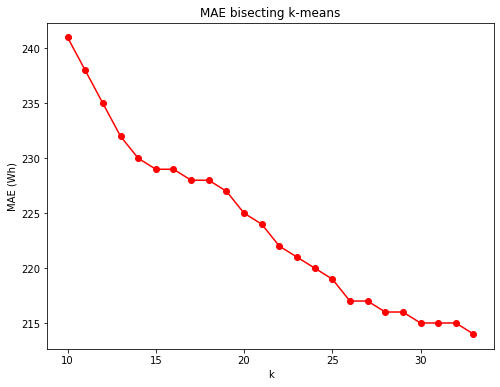

In [30]:
#Visualizing the silhouette scores in a plot

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(kMin,kMax),MAE_BIS_NO_DECIMAL,marker="o",color="red")
ax.set_xlabel('k')
ax.set_ylabel('MAE (Wh)')
ax.title.set_text('MAE bisecting k-means')

## Plot SIL index for kmeans and bisecting kmeans models

Text(0, 0.5, 'Wh')

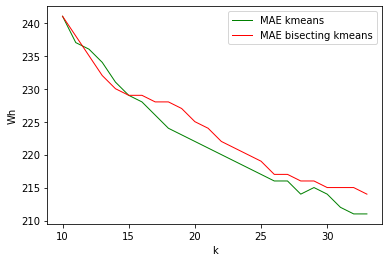

In [31]:
# Plot scoring %
bars = list(range(kMin,kMax))
plt.plot (bars,MAE_NO_DECIMAL_OK,label = "MAE kmeans", color="green", linewidth=1)
plt.plot (bars,MAE_BIS_NO_DECIMAL,label = "MAE bisecting kmeans", color = "red", linewidth=1)
plt.legend()
plt.xlabel("k")
plt.ylabel("Wh")

### Load bisecting model

In [138]:
from pyspark.ml.clustering import BisectingKMeansModel
# Load models
list_of_models_bis = []

for i in range(kMin, kMax): 
    nameModel = "bisec_model_"+str(i)
    model_ = BisectingKMeansModel.load(nameModel)
    list_of_models_bis.append(model_)

### Calculate SIL of bisecting models

In [29]:
silhouette_bisect_score = []
for model in list_of_models_bis:
    # Make predictions
    predictions = model.transform(df)

    # Evaluate clustering by computing Silhouette score
    evaluator = ClusteringEvaluator()

    silhouette = evaluator.evaluate(predictions)
    
    # Save ssilhouette score for k value
    silhouette_bisect_score.append(silhouette)
    
    

### Save SIL

In [46]:
import pickle
file_name = "silhouette_score_bisect_models.pkl"
open_file = open(file_name, "wb")
pickle.dump(silhouette_bisect_score, open_file)

In [32]:
import pickle

with open('silhouette_score_bisect_models.pkl', 'rb') as f:
    silhouette_bisect_score = pickle.load(f)

In [33]:
silhouette_bisect_score = silhouette_bisect_score [8:]

Text(0.5, 0, 'k')

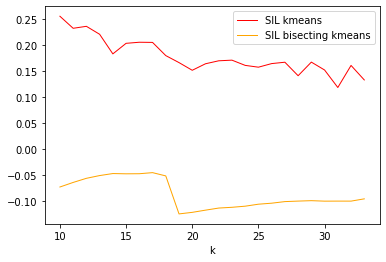

In [34]:
# Plot scoring %
bars = list(range(kMin,kMax))
plt.plot (bars,silhouette_score_kmeans_models,label = "SIL kmeans", color="red", linewidth=1)
plt.plot (bars,silhouette_bisect_score,label = "SIL bisecting kmeans", color = "orange", linewidth=1)
plt.legend()
plt.xlabel("k")

## Calculate percentage of observations on each cluster for each model

In [54]:
# ejecutar las dos siguiente celdas después de entrenar los modelos para irlanda y España

In [42]:
#Spain
#percentsArraySpain = []
#for model in list_of_models:
 #   aux = model.summary
 #   percentsObsForModel = [(i/numObs)*100 for i in aux.clusterSizes]
 #   percentsArraySpain.append(percentsObsForModel)

In [43]:
#Ireland
#percentsArrayIre = []
#for model in list_of_models_ire:
#    aux = model.summary
#    percentsObsForModel = [(i/numObs)*100 for i in aux.clusterSizes]
#    percentsArrayIre.append(percentsObsForModel)

## For each cluster or each model, calculation of: MAE, numObs, AVGConsumption

## clusters MAES  of models centroids

In [58]:
### MAE PARA CADA CENTROIDE DEL MODELO
#from pyspark.sql import SQLContext
#from pyspark import  SparkContext
#sc = SparkContext.getOrCreate()
#sqlContext = SQLContext(sc)
#from pyspark.sql import SQLContext
#from pyspark import  SparkContext
#sc = SparkContext.getOrCreate()
#sqlContext = SQLContext(sc)
#from pyspark.sql import functions as F


#MAE_FOR_CLUSTERS_OF_MODELS = [] # MAE de los centroides de todos los modelos

#CONSUMPTION_AVG_FOR_MODELS = [] # MAE de los centroides de todos los modelos

#OBS_FOR_MODELS = []

#cont = kMin

# Sacar sólo para el mejor modelo ?? Para ver si quitamos algún cluster, o todos tienen sentido
#for model_ in list_of_models:
    
   # print ("model_"+str(cont))
    
    #MAESForModel = [] # maes de los centroides de un modelo
    
    #AVGConsumptionForCluster = [] # maes de los centroides de un modelo
    
    #obsForCluster = [] # obs. del cluster
    
    #centers = model_.clusterCenters()

     # Model Centroids to dataframe
    #centers_p_df = pd.DataFrame(centers)

    #centers_p_df.insert(0, 'cluster_id', range(0, len(centers_p_df)))

    #centers_df = sqlContext.createDataFrame(centers_p_df)


    #predictions=model_.transform(df).withColumnRenamed("prediction","cluster_id")

    #dataset__ = predictions.drop("features")
    
    #print("Modelo con "+str(len(centers))+" clusters");
    
    
    #for i in range(0, len(centers)):

        # get dataframe for centroid = i
      #  dfForCluster = dataset__.filter(dataset__.cluster_id == i)


        #Join centroid with obs table by predicted centriod
       # final_df = dfForCluster.join(centers_df, on="cluster_id").drop("cluster_id")

         # get total obs predicted to centroid i
       # totalObs = final_df.count()


        #calculation column diff (centroid - obs)
       # final_df = final_df.withColumn("diff",
                          #  F.abs(F.col("X0") - F.col("0")) + F.abs(F.col("X1") - F.col("1")) +
                          #  F.abs(F.col("X2") - F.col("2")) + F.abs(F.col("X3") - F.col("3")) +
                          #  F.abs(F.col("X4") - F.col("4")) + F.abs(F.col("X5") - F.col("5")) +
                          #  F.abs(F.col("X6") - F.col("6")) + F.abs(F.col("X7") - F.col("7")) +
                           # F.abs(F.col("X8") - F.col("8")) + F.abs(F.col("X9") - F.col("9")) +
                            #F.abs(F.col("X10") - F.col("10")) + F.abs(F.col("X11") - F.col("11")) +
                            #F.abs(F.col("X12") - F.col("12")) + F.abs(F.col("X13") - F.col("13")) +
                            #F.abs(F.col("X14") - F.col("14")) + F.abs(F.col("X15") - F.col("15")) +
                            #F.abs(F.col("X16") - F.col("16")) + F.abs(F.col("X17") - F.col("17")) +
                            #F.abs(F.col("X18") - F.col("18")) + F.abs(F.col("X19") - F.col("19")) +
                            #F.abs(F.col("X20") - F.col("20")) + F.abs(F.col("X21") - F.col("21")) +
                            #F.abs(F.col("X22") - F.col("22")) + F.abs(F.col("X23") - F.col("23"))
                            #)

        #sum column
        #sumDF = final_df.agg({'diff': 'sum'})
  

        #sumDiff = sumDF.collect()[0][0]

        #maeCent = (sumDiff/totalObs)
       
        #maeFinal = maeCent/24

        #MAESForModel.append(maeFinal)
        
        
        # Consumo medio de cada cluster
        
        #dfForCluster__ = dataset__.filter(dataset__.cluster_id == i).drop("cluster_id")
        
         #calculation column diff (centroid - obs)
        #consumo = dfForCluster__.withColumn("suma",
                      #  ( (F.col("X0") ) + (F.col("X1")) +
                      #  (F.col("X2") ) + (F.col("X3")) +
                      #  (F.col("X4") ) + (F.col("X5")) +
                      #  (F.col("X6") ) + (F.col("X7")) +
                      #  (F.col("X8") ) + (F.col("X9")) +
                      #  (F.col("X10") ) + (F.col("X11")) +
                      #  (F.col("X12") ) + (F.col("X13")) +
                      #  (F.col("X14") ) + (F.col("X15")) +
                      #  (F.col("X16") ) + (F.col("X17")) +
                      #  (F.col("X18") ) + (F.col("X19")) +
                      #  (F.col("X20") ) + (F.col("X21")) +
                      #  (F.col("X22") ) + (F.col("X23"))
                      #  )/24 )
    
        #consumo_medio = consumo.agg({'suma': 'sum'})

       # valor = consumo_medio.collect()[0][0]
        
        
        #consumo_medio_total = (valor/totalObs)
        
        #obsForCluster.append (totalObs)
        
        
       # AVGConsumptionForCluster.append (consumo_medio_total)

        
        

     #   print("CENTROIDE:"+str(i))

      #  print("MAE:"+str(maeFinal))
        
      #  print("Total obs:"+str(totalObs));
        
       # print("consumo medio:"+str(consumo_medio_total));
        
  #  cont = cont+1


    ## PAra cada modelo, guardamos una lista de MAES por centroide
  #  MAE_FOR_CLUSTERS_OF_MODELS.append(MAESForModel)
  #  OBS_FOR_MODELS.append (obsForCluster)
  #  CONSUMPTION_AVG_FOR_MODELS.append(AVGConsumptionForCluster)




In [ ]:
## Guardar e arrays MAE_FOR_CLUSTERS_OF_MODELS, OBS_FOR_MODELS, AVGConsumptionForCluster

In [22]:
#import pickle
#file_name = "OBS_FOR_MODELS.pkl"
#open_file = open(file_name, "wb")
#pickle.dump(OBS_FOR_MODELS, open_file)

#file_name = "MAE_FOR_CLUSTERS_OF_MODELS.pkl"
#open_file = open(file_name, "wb")
#pickle.dump(MAE_FOR_CLUSTERS_OF_MODELS, open_file)

#file_name = "CONSUMPTION_AVG_FOR_MODELS.pkl"
#open_file = open(file_name, "wb")
#pickle.dump(CONSUMPTION_AVG_FOR_MODELS, open_file)

In [ ]:
# Guardar para Ireland

In [329]:
#import pickle
#file_name = "OBS_FOR_MODELS_IRE.pkl"
#open_file = open(file_name, "wb")
#pickle.dump(percentsArray, open_file)

In [62]:
#import pickle

#with open('OBS_FOR_MODELS.pkl', 'rb') as f:
#    OBS_FOR_MODELS = pickle.load(f)
#with open('MAE_FOR_CLUSTERS_OF_MODELS.pkl', 'rb') as f:
#    MAE_FOR_CLUSTERS_OF_MODELS = pickle.load(f)
#with open('CONSUMPTION_AVG_FOR_MODELS.pkl', 'rb') as f:
#    CONSUMPTION_AVG_FOR_MODELS = pickle.load(f)

In [62]:
#import pickle

#with open('OBS_FOR_MODELS_IRE.pkl', 'rb') as f:
#    OBS_FOR_MODELS = pickle.load(f)
#with open('MAE_FOR_CLUSTERS_OF_MODELS_IRE.pkl', 'rb') as f:
#    MAE_FOR_CLUSTERS_OF_MODELS = pickle.load(f)
#with open('CONSUMPTION_AVG_FOR_MODELS_IRE.pkl', 'rb') as f:
#    CONSUMPTION_AVG_FOR_MODELS = pickle.load(f)

# Calculo de % de observaciones en cada cluster para cada modelo

In [59]:
#Spain
OBS_FOR_MODELS_OK = percentsArraySpain

In [ ]:
#Ire
OBS_FOR_MODELS_OK = percentsArrayIre

In [60]:
#Plot percentag of observations on each cluster for k=21 Ireland

In [350]:
kArray = list(range(0, 21))

In [351]:
d = {'k':kArray,'Percentage obs.':percentsArray[11]}

In [352]:
d

{'k': [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20],
 'Percentage obs.': [1.0015604615602265,
  26.51993552895513,
  1.1762794163396255,
  1.1094635810935773,
  3.281744381500958,
  4.115285289362456,
  4.794633067032141,
  3.4628063862397154,
  9.12084258509932,
  2.569362854885627,
  7.483444817781636,
  0.3813669700283762,
  3.0829717260329814,
  4.910233370785836,
  1.821381851251202,
  8.001757523730312,
  1.832393100899751,
  3.0929851925418563,
  2.566476410802998,
  6.734216585222617,
  2.940858898853654]}

In [353]:
import pandas as pd
df = pd.DataFrame(d)
df


k  Percentage obs.
0    0         1.001560
1    1        26.519936
2    2         1.176279
3    3         1.109464
4    4         3.281744
5    5         4.115285
6    6         4.794633
7    7         3.462806
8    8         9.120843
9    9         2.569363
10  10         7.483445
11  11         0.381367
12  12         3.082972
13  13         4.910233
14  14         1.821382
15  15         8.001758
16  16         1.832393
17  17         3.092985
18  18         2.566476
19  19         6.734217
20  20         2.940859

In [354]:
df.to_csv("IrlandaPercentObsToCluster", sep=',')

# Number of clusters less than PERCENT_CUT for each model

In [62]:
PERCENT_CUT = 1

In [13]:
#Spain
lessThanOneSpa = []
for model in percentsArraySpain:
    count = 0
    for clus in model:
        if clus<PERCENT_CUT:
            count = count + 1
    lessThanOneSpa.append (count)
    

In [ ]:
#Ire
lessThanOneIre = []
for model in percentsArrayIre:
    count = 0
    for clus in model:
        if clus<PERCENT_CUT:
            count = count + 1
    lessThanOneIre.append (count)

In [66]:
# Save curves
file_name = "numClusPercLes1Ire.pkl"
open_file = open(file_name, "wb")
pickle.dump(lessThanOneIre, open_file)
file_name = "numClusPerLes1Spa.pkl"
open_file = open(file_name, "wb")
pickle.dump(lessThanOneSpa, open_file)

In [7]:
# load MAE
import pickle

with open('numClusPercLes1Ire.pkl', 'rb') as f:
    numClusPercLes1Ire = pickle.load(f)
with open('numClusPerLes1Spa.pkl', 'rb') as f:
    numClusPerLes1Spa = pickle.load(f)

In [64]:
#numClusPercLes1Ire = [1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 4, 1, 3, 3, 2, 3, 4, 4, 4, 5, 5, 5, 7, 6]
#numClusPerLes1Spa = [2, 2, 2, 3, 4, 3, 5, 5, 6, 5, 7, 6, 7, 7, 8, 8, 8, 9, 10, 11, 12, 12, 11, 15]

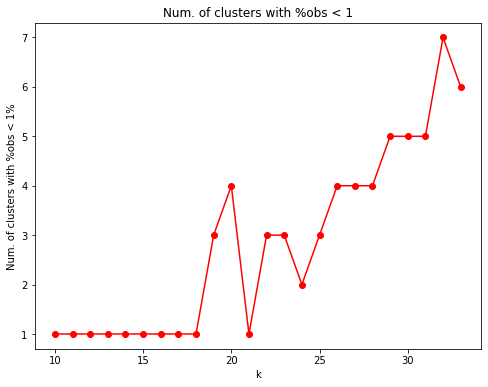

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(kMin,kMax),numClusPercLes1Ire,marker="o",color="red")
ax.set_xlabel('k')
ax.set_ylabel('Num. of clusters with %obs < 1%')
ax.title.set_text('Num. of clusters with %obs < 1')

## MAE for kmeans models

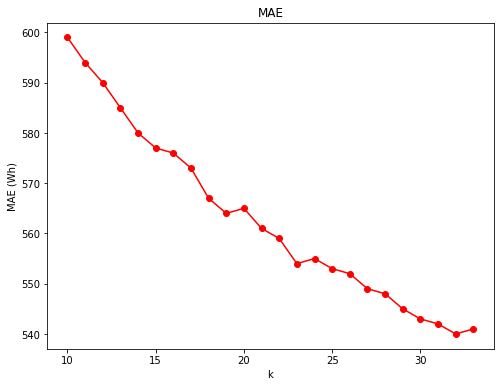

In [11]:
#Visualizing the silhouette scores in a plot

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(kMin,kMax),MAE_NO_DECIMAL_Ire,marker="o",color="red")
ax.set_xlabel('k')
ax.set_ylabel('MAE (Wh)')
ax.title.set_text('MAE')

In [98]:
kMin=10
kMax=33

# Scoring algorithm

In [32]:
# import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import random
import math


def random_color():
    x = [0, 1, 2]
    y = [0, 1, 2]
    r = random.random()
    b = random.random()
    g = random.random()
    color_ = (r, g, b)
    return color_

def calculateArea(p1,p2,p3):
    areaTriangle = abs (1/2 * ( ( (p2[0]*p1[1])-(p1[0]*p2[1]) )+ ( (p3[0]*p2[1])-(p2[0]*p3[1]) ) +
    ( (p1[0]*p3[1])-(p3[0]*p1[1]) ) ) )
    return areaTriangle

def calculateSlope(p1,p2):
    slopeTwoPoints = math.degrees(math.atan((p2[1]-p1[1])/(p2[0]-p1[0])))
    return slopeTwoPoints

def RenderTriangle (p1,p2,p3,ax):
    p = np.array([p1,p2,p3])
    colorRandom = random_color()  
    poly = Polygon(p, closed=False, color = colorRandom, ec="black")
    #ax = plt.gca()
    ax.add_patch(poly)
    #ax.annotate(areaTriang, [p2[0], p2[1]+1], color="black", fontsize=8)

#curve type: 0 curva de numClusteresPequeños o cualquier otra, 1 curva de MAE (para fijar parámetros de áreaTolerance y SlopeTolerance)
def triangulation(measureArray,kMin,kMax,curveName,curveType):
    
    # set variables
    slideWindowsSize = 3
    jumpPointDistance = 1
    

    # cuve with muber of cluster with percentage of obs. less than PERCENT_CUT
    if (curveType==0):
        areaTolerance = 3/2
        slopeTolerance = 22.5  
        print ("AreaTolerance:"+str(areaTolerance))
        print ("SlopeTolerance:"+str(slopeTolerance))
        ax = plt.gca()
        
    else: #Calculamos los valores del triangulo grande
        p1 = [kMin,measureArray[0]]
        p3 = [kMax,measureArray[len(measureArray)-1] ]
        p2x = math.floor((kMin+kMax)/2) #punto medio X
        p2y = measureArray[p2x-kMin]
        p2 = [p2x,p2y]
        
        # Se pinta el triangulo grande
        p = np.array([p1,p2,p3])
        colorRandom = random_color()  
        poly = Polygon(p, closed=False, color = "turquoise", ec="black")
        ax = plt.gca()
        ax.add_patch(poly)
        #ax.annotate("Big trien", [p2[0], p2[1]+1], color="black", fontsize=8)
        
        # Se construye el triangulo "pequeño" en el centro (con la forma del grande)
        # ENTENDER BIEN ESTA PARTE ****
        p2LessTriangle = p2
        p1Lessx = p2x-slideWindowsSize
        p3Lessx = p2x+slideWindowsSize
        factReductionp1_p2 = slideWindowsSize*100/(p2x-kMin)
        factReductionp2_p3 = slideWindowsSize*100/(p3[0]-p2x)
        p1Lessy = p2y+(p1[1]-p2[1])*factReductionp1_p2/100
        p3Lessy = p2y+(p3[1]-p2[1])*factReductionp2_p3/100
        p1LessTriangle = [p1Lessx,p1Lessy]
        p3LessTriangle = [p3Lessx,p3Lessy]
        
        # Se pinta el triangulo pequeño
        p = np.array([p1LessTriangle,p2LessTriangle,p3LessTriangle])
        colorRandom = random_color()  
        poly = Polygon(p, closed=False, color = "violet", ec="black")
        ax = plt.gca()
        ax.add_patch(poly)
        areaTriang = calculateArea (p1LessTriangle,p2LessTriangle,p3LessTriangle)
        areaTriang = round(areaTriang, 2)
       
        #Tomamos como tolerancia al área, el área del triángulo construido con la forma del triángulo formado con los extremos y el punto medio, escalado al tamaño de slidewindowssize
        areaTolerance = areaTriang
        print ("AreaTolerance:"+str(areaTolerance))
        
        #Tomamos como pendiente la del mayor triángulo (punto inicial y final de la curva)
        slopeTolerance = calculateSlope (p1,p3)       
        print ("SlopeTolerance:"+str(slopeTolerance))
        
    # 3 consecutives triangles with a area less than equal numbersOfContiguousAreas determines a canditade for optimal k
    numbersOfContiguousAreas = 3
    
    AREAS = []
    SLOPES = []
    
    
    for k in range(0,len(measureArray)-(slideWindowsSize*2),jumpPointDistance):
        
    # Calculamos el área y la pendiente de cada triángulo
    
        # get 3 points of triangle
        measure = measureArray[k]
        p1 = [k+kMin,measure]
        p2 = [k+kMin+slideWindowsSize,measureArray[k+slideWindowsSize]]
        p3 = [k+kMin+(slideWindowsSize*2),measureArray[k+slideWindowsSize*2]]

         # calculate area of triangle
        areaTriang = calculateArea (p1,p2,p3)
        areaTriang = round(areaTriang, 2)
        # append to AREAS array
        AREAS.append (areaTriang)
        
        
        # calculate SLOPE of triangle
        slope = calculateSlope(p1,p3)
        slope = round(slope, 2)
        # append to AREAS array
        SLOPES.append(slope)

    #Obtener k values donde aparecen 3 triángulos conssecutivos con un área < a la tolerantia de área
    posStop = 0
    i = 0
    #encontrado = False
    positionsStopAreas = [] # En qué valores de k encontramos contiguous areas que cumplen la condición
    firstFound = 0

    while (i<len(AREAS)+1-numbersOfContiguousAreas):
        matches = 0
        for j in range (i,i+numbersOfContiguousAreas):          
            if ( (AREAS[j]>=0 and AREAS[j]<=areaTolerance)  ):
                matches = matches+1
        if (matches==numbersOfContiguousAreas):
            posStop = i+kMin
            positionsStopAreas.append (posStop)
        i=i+1
        
    #Obtener k values donde aparecen 3 triángulos conssecutivos con una pendiente < a la tolerantia de pendiente   
    posStop = 0
    i = 0
    #encontrado = False
    positionsStopSlopes = [] # En qué valores de k encontramos contiguous areas que cumplen la condición
    firstFound = 0

    while (i<len(SLOPES)+1-numbersOfContiguousAreas):
        matches = 0         
        if ( (SLOPES[i]>=slopeTolerance)  ):
            posStop = i+kMin
            positionsStopSlopes.append (posStop)        
        i=i+1
        
       
    # Plot curve
    ax.plot(range(kMin,kMax),measureArray,marker="o",color="red",markersize=2,linewidth=.5)
    ax.set_xlabel('k')
    ax.set_ylabel(curveName)
    ax.title.set_text(curveName)
    ax.set_xlim(kMin,kMax)
    ax.set_ylim(min(measureArray),max(measureArray))
   
    
    #k values common for both criteria
    commonCriteriaKValues = list(set(positionsStopAreas).intersection(positionsStopSlopes))
    minKCommonValue = min (commonCriteriaKValues)
  
    #Pintamos los 3 triangulos a partir de min
    p1 = [minKCommonValue,measureArray[minKCommonValue-kMin]]
    p2 = [minKCommonValue+slideWindowsSize,measureArray[minKCommonValue-kMin+slideWindowsSize]]
    p3 = [minKCommonValue+(slideWindowsSize*2),measureArray[minKCommonValue-kMin+slideWindowsSize*2]]
    
      #Pintamos los 3 triangulos a partir de min
    p1_ = [minKCommonValue+1,measureArray[minKCommonValue+1-kMin]]
    p2_ = [minKCommonValue+1+slideWindowsSize,measureArray[minKCommonValue+1-kMin+slideWindowsSize]]
    p3_ = [minKCommonValue+1+(slideWindowsSize*2),measureArray[minKCommonValue+1-kMin+slideWindowsSize*2]]

       #Pintamos los 3 triangulos a partir de min
    p1__ = [minKCommonValue+2,measureArray[minKCommonValue+2-kMin]]
    p2__ = [minKCommonValue+2+slideWindowsSize,measureArray[minKCommonValue+2-kMin+slideWindowsSize]]
    p3__ = [minKCommonValue+2+(slideWindowsSize*2),measureArray[minKCommonValue+2-kMin+slideWindowsSize*2]]

    #ax.annotate("k="+str(minKCommonValue), [p1[0], p1[1]+1], color="red", fontsize=12)

    RenderTriangle (p1,p2,p3,ax)
    RenderTriangle (p1_,p2_,p3_,ax)
    RenderTriangle (p1__,p2__,p3__,ax)
    
    plt.show()
    
    # return array with areas of triangles array and value for areaTolerance
    return [AREAS,SLOPES,positionsStopAreas,positionsStopSlopes,commonCriteriaKValues,minKCommonValue]


AreaTolerance:8.25
SlopeTolerance:-67.52056560289688


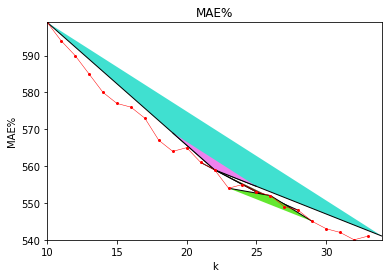

Triangles Areas:[7.5, 10.5, 4.5, 4.5, 1.5, 6.0, 10.5, 4.5, 0.0, 1.5, 13.5, 0.0, 1.5, 7.5, 0.0, 1.5, 3.0, 6.0]
Triangles Slopes:[-75.38, -74.05, -75.38, -74.05, -68.2, -69.44, -70.56, -72.47, -63.43, -61.39, -65.22, -63.43, -61.39, -56.31, -63.43, -61.39, -63.43, -53.13]
Kvalues where area condition is TRUE:[12, 13, 17, 21, 22, 23, 24, 25]
Kvalues where slopes condition is TRUE:[18, 19, 20, 21, 22, 23, 24, 25]
Common k values for both criteria :[21, 22, 23, 24, 25]
Min common k value:21


In [38]:
triang = triangulation(MAE_NO_DECIMAL_Ire,kMin,kMax,"MAE%",1)
print("Triangles Areas:"+str(triang[0]))
print("Triangles Slopes:"+str(triang[1]))
print("Kvalues where area condition is TRUE:"+str(triang[2]))
print("Kvalues where slopes condition is TRUE:"+str(triang[3]))
print("Common k values for both criteria :"+str(triang[4]))
print ("Min common k value:"+str(triang[5]))


In [262]:
triang

[[1.5,
  1.5,
  3.0,
  3.0,
  1.5,
  4.5,
  3.0,
  3.0,
  3.0,
  1.5,
  1.5,
  1.5,
  1.5,
  3.0,
  3.0,
  0.0,
  4.5,
  0.0],
 [26.57,
  26.57,
  33.69,
  18.43,
  26.57,
  26.57,
  18.43,
  18.43,
  18.43,
  26.57,
  9.46,
  26.57,
  26.57,
  33.69,
  33.69,
  33.69,
  26.57,
  45.0],
 [19, 20],
 [10, 11, 12, 14, 15, 19, 21, 22, 23, 24, 25],
 [24, 21],
 21]

In [187]:
pow(2,3)

8

### ALG ELBOW AUTOMATICO

In [222]:
def distEuclidea(p1,p2):
    euclideanD = math.sqrt(pow(p1[0]-p2[0],2)+pow(p1[1]-p2[1],2))
    return euclideanD

In [228]:
import math
def angle(Eij,Ejk,Eik):
    res = (pow(Eij,2)+pow(Ejk,2)-pow(Eik,2))/(2*Eij*Ejk)
    angle = math.acos(res)
    return angle

In [234]:
import math
def elbowAutomatic(measureArray,kMin,kMax,curveName):
    angleArray = []
    kOptimal = 0
    alphaMin = math.pi
    for i in range(0,len(measureArray)-2):
        # get 3 points 
        j = i+1
        k = i+2
        p1 = [i+kMin,measureArray[i]] #point i (primero)
        p2 = [j+kMin,measureArray[j]] # point j (2º)
        p3 = [k+kMin,measureArray[k]] # point k (3º)
        a = distEuclidea (p1,p2) #Eij
        b = distEuclidea (p2,p3) #Ejk
        c = distEuclidea (p3,p1) #Eki
        alpha = angle (a,b,c)
        angleArray.append(alpha)
        if (alpha<alphaMin):
            alphaMin = alpha
            kOptimal = j+kMin-1          
    return (kOptimal,alphaMin,angleArray)

In [239]:
elbowAutomatic (lessThanOne,kMin,kMax,"num. clust. with % obs less than 1%")

(21,
 1.0303768265243123,
 [2.3561944901923453,
  2.3561944901923453,
  2.3561944901923453,
  2.3561944901923453,
  2.3561944901923453,
  2.819842099193149,
  2.819842099193149,
  1.5707963267948963,
  1.5707963267948963,
  2.3561944901923453,
  1.8157749899217612,
  1.0303768265243123,
  1.5707963267948963,
  3.141592653589793,
  3.141592653589793,
  3.141592653589793,
  2.3561944901923453,
  3.141592653589793,
  3.141592653589793,
  2.3561944901923453,
  2.3561944901923453,
  1.8925468811915382])

In [238]:
lessThanOne

[6,
 6,
 7,
 7,
 8,
 8,
 9,
 11,
 12,
 11,
 12,
 12,
 16,
 15,
 16,
 17,
 18,
 19,
 19,
 19,
 19,
 20,
 20,
 23]

In [213]:
a = math.pi / 6
       
# returning the value of arc cosine of pi / 6  
print ("The value of arc cosine of pi / 6 is : ", end ="")  
print (math.acos(a))

The value of arc cosine of pi / 6 is : 1.0197267436954502
